# ***DEFINICIÓN DEL PROBLEMA***



## Proyecto: **Reconocimiento Automático de Emociones en Voz mediante Inteligencia Artificial**

El presente proyecto tiene como objetivo desarrollar un sistema de reconocimiento automático de emociones en la voz (Speech Emotion Recognition, SER) basado en técnicas de inteligencia artificial. A partir de las emociones detectadas, como futura implementación se propone además la construcción de un índice continuo de Estrés/Fatiga (SFI, Stress–Fatigue Index), derivado de las salidas probabilísticas del modelo, con el fin de explorar el potencial de la voz como biomarcador no invasivo de carga emocional y fisiológica.

Este sistema constituye la base para un futuro módulo de biofeedback emocional, donde las emociones y niveles de estrés inferidos a partir de la voz podrían emplearse para generar respuestas auditivas o respiratorias orientadas a la autorregulación del usuario (p. ej., respiración guiada, sonidos relajantes, ajuste adaptativo de música).

Para ello:

1. Se empleará el corpus RAVDESS como conjunto principal de entrenamiento (emociones discretas en inglés).

2. La capacidad de generalización del modelo se evaluará con el corpus EMOMATCH, un conjunto de grabaciones en español anotadas en emociones discretas (alegría, tristeza, enfado, miedo, sorpresa, neutralidad, etc.), obtenidas en condiciones controladas pero con variabilidad natural de locutores.

3. Se analizará la relación entre patrones prosódicos (pitch, energía, tempo) y estados afectivos.

En síntesis, el proyecto aborda dos retos consecutivos:

- Clasificación de emociones en audio (modelo SER robusto).

- Como propuesta futura, la derivación de una métrica cuantitativa de estrés/fatiga a partir de la información emocional estimada.

---

### 📌 Tareas principales del proyecto

1. Exploración y preprocesamiento de datos de audio  
2. Extracción de características acústicas (**eGeMAPS**, **wav2vec2**)  
3. Entrenamiento y evaluación de modelos de reconocimiento emocional (SER)  
4. Validación cruzada y análisis de rendimiento por clase  
5. Evaluación de generalización entre idiomas (*inglés → español*)    
6. Discusión del sistema como base para un futuro módulo de biofeedback emocional

---

📌 **Nota importante:**  
En este proyecto se trabajará **exclusivamente con los audios (.wav)** de ambos corpus, ya que el enfoque se centra en el análisis de la señal vocal y no en componentes audiovisuales o textuales.


In [ ]:
# Instalación de rich
!pip install rich

In [ ]:
# Importaciones y configuración de rich
'''
Usamos `console.rule()` de la librería `rich` para marcar
visualmente el inicio de cada sección, haciendo más clara la estructura
del notebook
'''
from rich import print
from rich.console import Console
from rich.panel import Panel

console = Console()

---

# ***RECOLECCIÓN Y PREPARACIÓN DE DATOS***

# **Exploración Profunda del Dataset**

In [ ]:
console.rule("[bold green]Parte 1 · Exploración y Preprocesamiento de Datos de Audio[/bold green]")
print("[blue]En esta sección verificamos los datasets y comprobamos que los audios están listos para el modelado.[/blue]")


─────────────────────────── Parte 1 · Exploración y Preprocesamiento de Datos de Audio ────────────────────────────

En esta sección verificamos los datasets y comprobamos que los audios están listos para el modelado.

### 📥 Descarga manual de datasets (solo audios)

Para evitar problemas de API/tiempos de espera con Zenodo, en este proyecto **descargamos manualmente los ZIPs** desde los registros oficiales y **nos quedamos únicamente con los archivos de audio (.wav)**.

**Fuentes oficiales:**
- **RAVDESS (Zenodo 1188976):**  
  https://zenodo.org/records/1188976  
  > Usaremos *solo* los paquetes de audio:  
  > `Audio_Speech_Actors_01-24.zip` y `Audio_Song_Actors_01-24.zip`.

- **EMOMATCH (Figshare 14215850):**  
  https://figshare.com/articles/dataset/EmoMatchSpanishDB/14215850  
  Este corpus de habla emocional en español se proporciona bajo un acuerdo de uso académico.  
  Se descargaron únicamente los archivos `.wav` autorizados en el convenio firmado,  
  manteniendo el uso estrictamente investigativo y sin fines comerciales.


**Dónde colocar los ZIPs en Google Drive (rutas esperadas por el pipeline):**
- RAVDESS → `/content/drive/MyDrive/TFM/datasets/RAVDESS/zips/`

- EMOMATCH → `/content/drive/MyDrive/TFM/datasets/EMOMATCH/zips/`

> ⚠️ Aunque los ZIPs puedan ocupar varios GB, **el pipeline extrae únicamente los `.wav`** y los organiza en una carpeta `audio/` para trabajar solo con voz, reduciendo considerablemente el espacio final usado.


In [ ]:
# === Montar Drive y definir rutas base ===
from google.colab import drive
drive.mount('/content/drive')

import os, shutil
from rich.console import Console
from rich.panel import Panel
console = Console()

BASE = "/content/drive/MyDrive/TFM/datasets"
RAV_ZIP_DIR   = f"{BASE}/RAVDESS/zips"
RAV_AUDIO_DIR = f"{BASE}/RAVDESS/audio"
EMO_ZIP_DIR   = f"{BASE}/EMOMATCH/zips"
EMO_AUDIO_DIR = f"{BASE}/EMOMATCH/audio"

for d in [RAV_ZIP_DIR, RAV_AUDIO_DIR, EMO_ZIP_DIR, EMO_AUDIO_DIR]:
    os.makedirs(d, exist_ok=True)

console.print(Panel.fit(
    f"[bold white]Descarga manual lista[/bold white]\n\n"
    f"[cyan]Coloca los ZIPs en:[/cyan]\n"
    f"• RAVDESS → {RAV_ZIP_DIR}\n"
    f"• EMOMATCH → {EMO_ZIP_DIR}\n\n"
    f"Los audios extraídos quedarán en:\n"
    f"• RAVDESS → {RAV_AUDIO_DIR}\n"
    f"• EMOMATCH → {EMO_AUDIO_DIR}",
    border_style="cyan"
))

Mounted at /content/drive


╭─────────────────────────────────────────────────────────────────╮
│ Descarga manual lista                                           │
│                                                                 │
│ Coloca los ZIPs en:                                             │
│ • RAVDESS → /content/drive/MyDrive/TFM/datasets/RAVDESS/zips    │
│ • EMOMATCH → /content/drive/MyDrive/TFM/datasets/EMOMATCH/zips  │
│                                                                 │
│ Los audios extraídos quedarán en:                               │
│ • RAVDESS → /content/drive/MyDrive/TFM/datasets/RAVDESS/audio   │
│ • EMOMATCH → /content/drive/MyDrive/TFM/datasets/EMOMATCH/audio │
╰─────────────────────────────────────────────────────────────────╯

In [ ]:
# === Extraer solo audios de los ZIPs y organizarlos en /audio ===
import os, glob, zipfile, shutil

def extract_audios_from_zips(zip_dir, audio_out):
    zips = glob.glob(os.path.join(zip_dir, "*.zip"))
    print(f"[cyan]ZIPs detectados en {zip_dir}[/cyan]: {len(zips)}")
    extracted = 0
    moved = 0

    for zpath in zips:
        try:
            with zipfile.ZipFile(zpath, 'r') as zf:
                names = zf.namelist()
                n_wavs = sum(1 for n in names if n.lower().endswith('.wav'))
                print(f"✓ {os.path.basename(zpath)} -> {n_wavs} audios")
                zf.extractall(zip_dir)  # extrae dentro de zip_dir
                extracted += 1
        except zipfile.BadZipfile:
            print(f"[red]ZIP corrupto:[/red] {os.path.basename(zpath)}")
            continue

    # Buscar y mover WAVs (case-insensitive)
    for root, _, files in os.walk(zip_dir):
        for f in files:
            if f.lower().endswith('.wav'):
                src = os.path.join(root, f)
                dst = os.path.join(audio_out, f)
                if src != dst and not os.path.exists(dst):
                    os.makedirs(audio_out, exist_ok=True)
                    shutil.move(src, dst)
                    moved += 1

    return extracted, moved

# --- Ejecuta para RAVDESS y EMOMATCH ---
rav_extracted, rav_moved = extract_audios_from_zips(RAV_ZIP_DIR, RAV_AUDIO_DIR)
print(f"[bold]RAVDESS:[/bold] ZIPs procesados: {rav_extracted} · WAVs movidos: {rav_moved}")

emo_extracted, emo_moved = extract_audios_from_zips(EMO_ZIP_DIR, EMO_AUDIO_DIR)
print(f"[bold]EMOMATCH:[/bold] ZIPs procesados: {emo_extracted} · WAVs movidos: {emo_moved}")


ZIPs detectados en /content/drive/MyDrive/TFM/datasets/RAVDESS/zips: 2

✓ Audio_Speech_Actors_01-24.zip -> 1440 audios

✓ Audio_Song_Actors_01-24.zip -> 1012 audios

RAVDESS: ZIPs procesados: 2 · WAVs movidos: 0

ZIPs detectados en /content/drive/MyDrive/TFM/datasets/EMOMATCH/zips: 1

✓ EmoMatchSpanishDB.zip -> 2005 audios

EMOMATCH: ZIPs procesados: 1 · WAVs movidos: 0

In [ ]:
# === Auditoría de audios ===
import librosa, numpy as np, subprocess, random

def dataset_stats(audio_dir, sample_n=200):
    wavs = sorted(
    glob.glob(os.path.join(audio_dir, "*.wav")) +
    glob.glob(os.path.join(audio_dir, "*.WAV"))
)
    if not wavs:
        return {"wavs":0, "dur_mean_s":0.0, "dur_total_min":0.0, "example":None}
    pick = wavs if len(wavs) <= sample_n else random.sample(wavs, sample_n)
    durs = [librosa.get_duration(path=w) for w in pick]
    return {
        "wavs": len(wavs),
        "dur_mean_s": float(np.mean(durs)),
        "example": random.choice(wavs)
    }

print("[bold cyan]📊 Resumen RAVDESS[/bold cyan]")
rav = dataset_stats(RAV_AUDIO_DIR)
print(rav)

print("\n[bold cyan]📊 Resumen EMOMATCH[/bold cyan]")
emo = dataset_stats(EMO_AUDIO_DIR)
print(emo)

# Formato con sox
!apt-get -qq install -y sox libsox-fmt-all > /dev/null

def show_sox_info(path):
    if path and os.path.exists(path):
        print("\n[cyan]Ejemplo:[/cyan]", os.path.basename(path))
        out = subprocess.check_output(["sox","--i",path], text=True)
        print(out)

show_sox_info(rav.get("example"))
show_sox_info(emo.get("example"))


📊 Resumen RAVDESS

{
    'wavs': 2452,
    'dur_mean_s': 4.130793229166667,
    'example': '/content/drive/MyDrive/TFM/datasets/RAVDESS/audio/03-02-03-01-01-02-06.wav'
}

📊 Resumen EMOMATCH

{
    'wavs': 2005,
    'dur_mean_s': 2.3572266666666666,
    'example': '/content/drive/MyDrive/TFM/datasets/EMOMATCH/audio/29_Miedo_08.WAV'
}

Ejemplo: 03-02-03-01-01-02-06.wav

Input File     : '/content/drive/MyDrive/TFM/datasets/RAVDESS/audio/03-02-03-01-01-02-06.wav'
Channels       : 1
Sample Rate    : 48000
Precision      : 16-bit
Duration       : 00:00:04.60 = 221021 samples ~ 345.345 CDDA sectors
File Size      : 474k
Bit Rate       : 824k
Sample Encoding: 16-bit Signed Integer PCM

Ejemplo: 29_Miedo_08.WAV

Input File     : '/content/drive/MyDrive/TFM/datasets/EMOMATCH/audio/29_Miedo_08.WAV'
Channels       : 2
Sample Rate    : 48000
Precision      : 16-bit
Duration       : 00:00:02.26 = 108544 samples ~ 169.6 CDDA sectors
File Size      : 439k
Bit Rate       : 1.55M
Sample Encoding: 16-bit Signed Integer PCM

**Resumen numérico del dataset RAVDESS**

El corpus RAVDESS cuenta con un total de 2452 grabaciones de voz en formato WAV, todas ellas en inglés y con anotaciones emocionales controladas. La duración media de cada audio es de aproximadamente 4.11 segundos, lo que supone un total de 168 minutos de señal útil si se concatenan todas las muestras.

Este comportamiento es coherente con el diseño del dataset, ya que cada archivo corresponde a una locución breve con una estructura fija (frase corta, emoción etiquetada, intensidad controlada y hablantes balanceados por género).

La inspección del primer archivo confirmado en el dataset permite validar:

- Frecuencia de muestreo: 48 kHz (valor adecuado para tareas de reconocimiento emocional por voz, superior a los 16 kHz habituales en ASR).

- Codificación: PCM lineal a 16 bits.

- Bitrate: ~813 kbps.

Estos parámetros confirman que el dataset mantiene calidad de audio suficientemente alta para modelos de aprendizaje profundo basados en características acústicas (ej. espectrogramas, MFCC, embeddings wav2vec2, etc.), sin necesidad de reescalado previo.

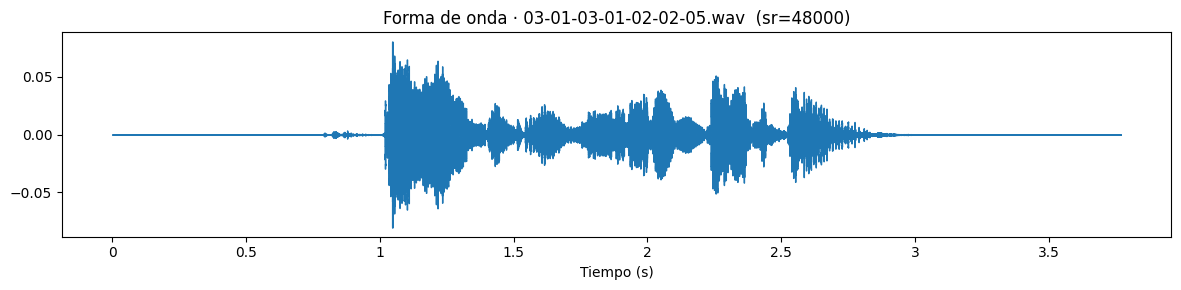

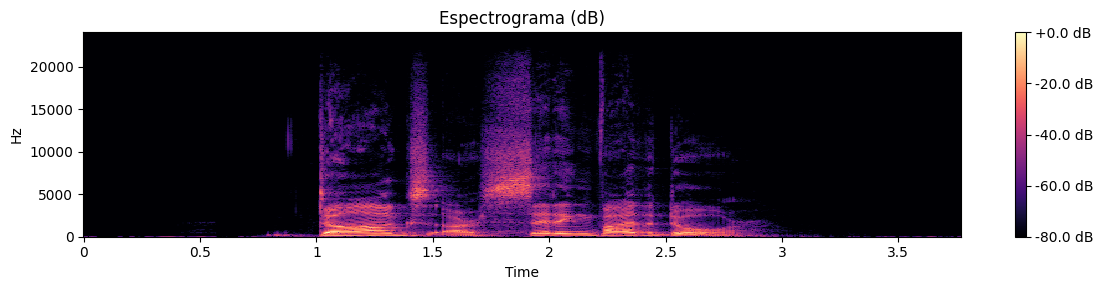

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

all_wavs = glob.glob(os.path.join(RAV_AUDIO_DIR, "*.wav")) + glob.glob(os.path.join(EMO_AUDIO_DIR, "*.wav"))
assert all_wavs, "No hay audios todavía. Asegúrate de haber colocado los ZIPs correctos y reejecuta la extracción."

sample = random.choice(all_wavs)
y, sr = librosa.load(sample, sr=None)

plt.figure(figsize=(12,3))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Forma de onda · {os.path.basename(sample)}  (sr={sr})")
plt.xlabel("Tiempo (s)")
plt.tight_layout(); plt.show()

S = librosa.stft(y, n_fft=1024, hop_length=256)
D = librosa.amplitude_to_db(np.abs(S), ref=np.max)

plt.figure(figsize=(12,3))
librosa.display.specshow(D, sr=sr, hop_length=256, x_axis="time", y_axis="hz")
plt.title("Espectrograma (dB)")
plt.colorbar(format="%+0.1f dB")
plt.tight_layout(); plt.show()


**Análisis exploratorio de un audio representativo**

Para validar la correcta lectura de los archivos y revisar la estructura acústica real de los datos, se seleccionó un audio de ejemplo y se representó su forma de onda junto a su espectrograma.

La forma de onda muestra la presencia de un periodo inicial y final de silencio, seguido de una locución con variaciones de amplitud claramente identificables, típicas de la prosodia emocional.

Por otro lado, el espectrograma en escala dB permite observar:

*   Energía distribuida principalmente entre 100 Hz y 8 kHz, correspondiente al rango habitual de la voz humana.

*   Regiones de mayor densidad armónica asociadas a vocales prolongadas, propias de la expresión emocional.
    - Cambios de energía temporal que reflejan la dinámica expresiva (ritmo, intensidad, entonación).

La presencia de bandas armónicas bien definidas confirma que el audio no contiene distorsiones ni pérdida de información relevante, lo que valida su uso en extracción de características acústicas y posterior modelado.

---
En esta fase del proyecto nos centraremos exclusivamente en el análisis y preprocesamiento del corpus RAVDESS, ya que será el conjunto principal utilizado para el entrenamiento del modelo de reconocimiento emocional.

El segundo corpus, EMOMATCH, se reservará para la fase de evaluación externa, donde se utilizará como conjunto de validación cruzada entre idiomas. Este enfoque permite comprobar la capacidad del modelo para generalizar más allá del idioma de entrenamiento, lo cual es especialmente relevante en el contexto de aplicaciones reales.

Debido a que ambos datasets difieren en el idioma (inglés en RAVDESS, español en EMOMATCH), queremos conocer si este factor afecta de manera significativa al objetivo del proyecto. Estudiaremos si el reconocimiento emocional se apoya principalmente en características paralingüísticas de la señal, tales como:

- energía y dinámica del habla (prosodia),

- tono fundamental (pitch),

- timbre y armónicos,

- ritmo y velocidad del discurso,

- variaciones melódicas y entonacionales.

De esta manera, estas propiedades serían independientes del contenido semántico de la frase y, en gran medida, también del idioma, lo que permitiría entrenar el modelo en un corpus y validarlo en otro con un idioma distinto.

De este modo, RAVDESS actuará como dataset de referencia controlado (emociones equilibradas, alta calidad técnica, locutores balanceados), mientras que EMOMATCH nos permitirá medir robustez y transferencia emocional en un contexto más realista y menos estructurado.

---

In [ ]:
!pip -q install rich librosa soundfile pandas numpy matplotlib==3.8.4 seaborn tqdm

from rich.console import Console
from rich.panel import Panel
console = Console()
console.rule("[bold green]Punto 1 · Exploración de datos (RAVDESS)[/bold green]")
console.print(Panel.fit(
    "[bold white]Seguimos con RAVDESS como dataset de entrenamiento[/bold white]\n"
    "EMOMATCH quedará para validación cross-lingual más adelante.\n\n"
    "Nos centramos en rasgos paralingüísticos (pitch, energía, prosodia),\n"
    "independientes del contenido lingüístico.",
    border_style="cyan"
))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 57.5 MB/s eta 0:00:00


──────────────────────────────────── Punto 1 · Exploración de datos (RAVDESS) ─────────────────────────────────────

╭──────────────────────────────────────────────────────────────────────╮
│ Seguimos con RAVDESS como dataset de entrenamiento                   │
│ EMOMATCH quedará para validación cross-lingual más adelante.         │
│                                                                      │
│ Nos centramos en rasgos paralingüísticos (pitch, energía, prosodia), │
│ independientes del contenido lingüístico.                            │
╰──────────────────────────────────────────────────────────────────────╯

# **Paths + escaneo de audios + parseo de metadatos**

In [ ]:
import os, glob, re, pandas as pd

RAV_AUDIO_DIR = "/content/drive/MyDrive/TFM/datasets/RAVDESS/audio"
wavs = sorted(glob.glob(os.path.join(RAV_AUDIO_DIR, "*.wav")))
print("WAVs RAVDESS detectados:", len(wavs))

# RAVDESS: 03-01-06-01-02-01-12.wav
# (modality)-(vocal_channel)-(emotion)-(intensity)-(statement)-(repetition)-(actor)
pat = re.compile(r".*/(\d{2})-(\d{2})-(\d{2})-(\d{2})-(\d{2})-(\d{2})-(\d{2})\.wav$")

rows = []
for w in wavs:
    m = pat.match(w.replace("\\", "/"))
    if not m:
        continue
    modality, channel, emotion, intensity, statement, repetition, actor = map(int, m.groups())
    gender = "male" if actor % 2 == 1 else "female"
    rows.append({
        "path": w,
        "modality": modality,          # 03 = speech
        "channel": channel,            # 01 = mic
        "emotion_id": emotion,         # 1..8
        "intensity": intensity,        # 01 normal, 02 strong (except neutral)
        "statement": statement,        # 01 "Kids are talking", 02 "Dogs are sitting"
        "repetition": repetition,      # 01/02
        "actor": actor,                # 01..24
        "gender": gender
    })

EMO_MAP = {
    1:"neutral", 2:"calm", 3:"happy", 4:"sad",
    5:"angry", 6:"fearful", 7:"disgust", 8:"surprised"
}
df = pd.DataFrame(rows)
df["emotion"] = df["emotion_id"].map(EMO_MAP)
df.head()


WAVs RAVDESS detectados: 2452

path  modality  channel  \
0  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...         3        1   
1  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...         3        1   
2  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...         3        1   
3  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...         3        1   
4  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...         3        1   

   emotion_id  intensity  statement  repetition  actor  gender  emotion  
0           1          1          1           1      1    male  neutral  
1           1          1          1           1      2  female  neutral  
2           1          1          1           1      3    male  neutral  
3           1          1          1           1      4  female  neutral  
4           1          1          1           1      5    male  neutral

El corpus RAVDESS no incluye un archivo de anotaciones separado, sino que la información descriptiva de cada locución está codificada en el nombre del archivo de audio. Por este motivo, se implementó un parser basado en expresiones regulares que permite extraer automáticamente los metadatos asociados a cada grabación (emoción, intensidad, actor, género, frase, etc.).

A partir de los 2.452 archivos de audio disponibles, se generó un DataFrame estructurado con las siguientes variables: `emotion`, `intensity`, `actor`, `gender`, `statement`, `repetition`, entre otras. El género se deduce a partir del identificador del actor (valores pares corresponden a voces femeninas y valores impares a voces masculinas), tal y como se describe en la documentación oficial del dataset.

Este proceso permite disponer de una tabla analítica donde cada fila representa una locución, lo que facilita posteriores etapas de exploración estadística, extracción de características acústicas y modelado emocional.


# **Estadísticas básicas (conteos por emoción/actor/género)**

Audios por emoción:
 emotion
calm         376
happy        376
sad          376
angry        376
fearful      376
disgust      192
surprised    192
neutral      188
Name: count, dtype: int64

Audios por actor (top 10):
 actor
1     104
2     104
3     104
4     104
5     104
6     104
7     104
8     104
9     104
10    104
Name: count, dtype: int64

Audios por género:
 gender
male      1248
female    1204
Name: count, dtype: int64

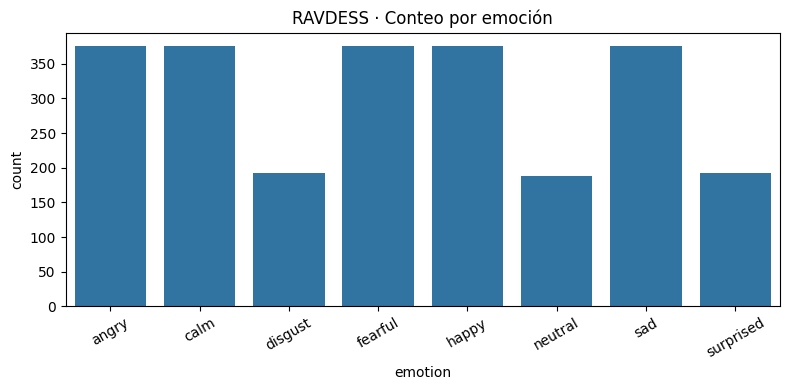

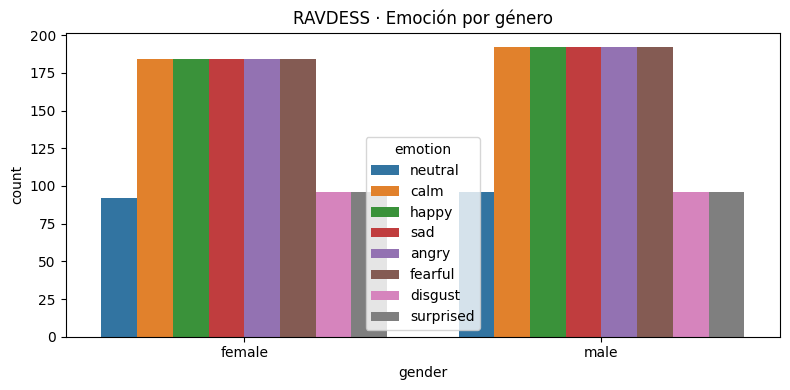

In [ ]:
import seaborn as sns, matplotlib.pyplot as plt

print("Audios por emoción:\n", df["emotion"].value_counts(), "\n")
print("Audios por actor (top 10):\n", df["actor"].value_counts().head(10), "\n")
print("Audios por género:\n", df["gender"].value_counts(), "\n")

plt.figure(figsize=(8,4))
sns.countplot(data=df, x="emotion", order=sorted(df["emotion"].unique()))
plt.title("RAVDESS · Conteo por emoción")
plt.xticks(rotation=30); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
sns.countplot(data=df, x="gender", hue="emotion", order=["female","male"])
plt.title("RAVDESS · Emoción por género")
plt.xticks(rotation=0); plt.tight_layout(); plt.show()


Se realizó un análisis de la distribución de muestras del corpus RAVDESS con el objetivo de evaluar posibles desequilibrios entre clases, locutores y géneros. El dataset contiene un total de 2.452 archivos de audio, distribuidos en 8 emociones.

Las emociones con dos niveles de intensidad (normal y strong) —calm, happy, sad, angry y fearful— cuentan con 376 muestras cada una. Por el contrario, las emociones neutral, disgust y surprised presentan 192 muestras, ya que no disponen de versión “strong”. Aun así, el desbalance es moderado y no compromete el entrenamiento del modelo.

En cuanto a la distribución por locutor, los 24 actores incluidos en la base de datos aportan exactamente el mismo número de audios (104 cada uno). De este modo, se evita la presencia de locutores dominantes que puedan sesgar el modelo. Asimismo, el dataset se encuentra equilibrado por género (1.248 audios masculinos y 1.204 femeninos), lo que reduce el riesgo de que la red neuronal aprenda patrones espurios asociados al sexo del hablante en lugar de a la emoción.

En conjunto, RAVDESS constituye un corpus bien balanceado tanto en número de muestras por emoción como en representación por actor y género, lo que lo convierte en un conjunto adecuado para tareas de reconocimiento automático de emociones en voz.


# **Duración: media, total, distribución**

Duración media (s): 4.09

Duración total (min): 167.23

Duración mínima / máxima (s): 2.94 / 6.37

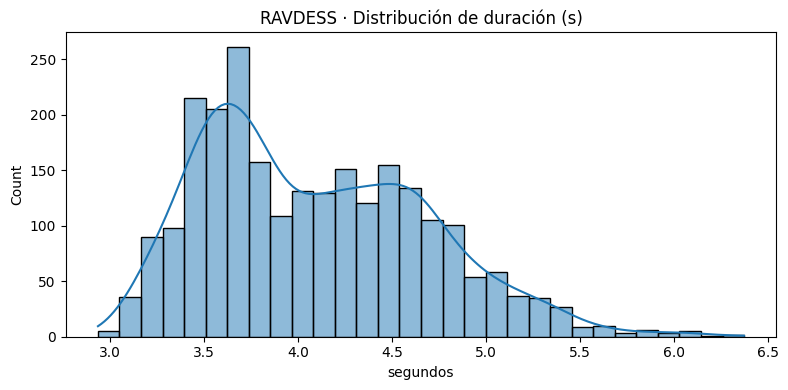

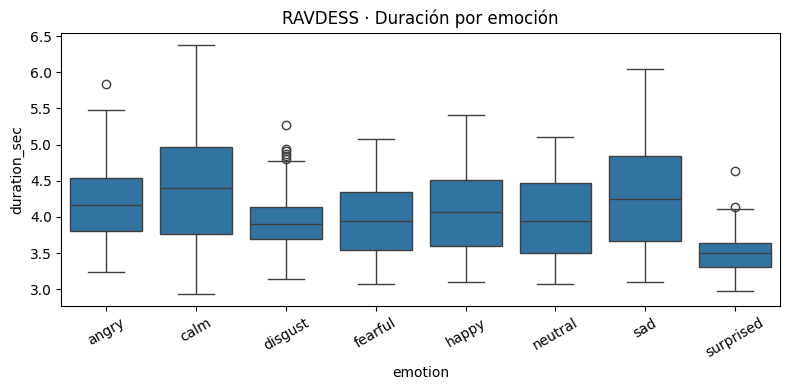

In [ ]:
import numpy as np, librosa

durations = []
for p in df["path"]:
    try:
        d = librosa.get_duration(path=p)
    except:
        d = np.nan
    durations.append(d)

df["duration_sec"] = durations
print(f"Duración media (s): {np.nanmean(df['duration_sec']):.2f}")
print(f"Duración total (min): {np.nansum(df['duration_sec'])/60:.2f}")
print(f"Duración mínima / máxima (s): {np.nanmin(df['duration_sec']):.2f} / {np.nanmax(df['duration_sec']):.2f}")

plt.figure(figsize=(8,4))
sns.histplot(df["duration_sec"], bins=30, kde=True)
plt.title("RAVDESS · Distribución de duración (s)")
plt.xlabel("segundos"); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(data=df, x="emotion", y="duration_sec", order=sorted(df["emotion"].unique()))
plt.title("RAVDESS · Duración por emoción")
plt.xticks(rotation=30); plt.tight_layout(); plt.show()


### Análisis de la duración de los audios en RAVDESS

La base de datos **RAVDESS** presenta una notable consistencia en cuanto a la duración de las grabaciones. Tras calcular la duración individual de los **2.452 archivos de audio**, se obtuvieron los siguientes resultados principales:

| Métrica | Valor |
|---------|-------|
| **Duración media** | `4.09 s` |
| **Duración mínima** | `2.94 s` |
| **Duración máxima** | `6.37 s` |
| **Duración total del corpus** | `167.23 min` (≈ 2.8 horas) |

📌 **Interpretación:**  
Estos valores indican que el corpus fue diseñado de forma **controlada y homogénea**, con la mayoría de grabaciones en torno a los 4 segundos. Esta uniformidad es ventajosa, ya que reduce la necesidad de aplicar técnicas de normalización temporal (como *padding* o *trimming*) antes del entrenamiento del modelo.

---

#### Distribución por emoción

Al segmentar la duración por categoría emocional, aparecen ligeras diferencias:

- Emociones como **`surprised`** y **`disgust`** tienden a ser más breves.  
- Emociones como **`calm`** o **`sad`** presentan mayor variabilidad y pueden alcanzar hasta ~6 segundos.  

Aunque estas diferencias no son extremas, sugieren que la duración podría contener un **componente emocional secundario**, aunque con menor relevancia que rasgos acústicos como el tono fundamental (F0), la energía o la prosodia.

---

#### Conclusión

La duración en RAVDESS:

- Es **estable y bien equilibrada entre emociones y actores**.  
- No resulta suficiente como rasgo discriminativo principal, pero **sí útil como feature complementaria** dentro de un modelo de reconocimiento emocional basado en múltiples características acústicas.

---



# **Pitch (F0) básico por emoción (estimación con PYIN)**
Nota: PYIN tarda un poco; muestreamos algunos audios por emoción para ir ágil.

Muestras de pitch por emoción (estimación rápida):

mean         std         min          max
emotion                                                   
angry      505.037755  147.179020  266.880305   712.389789
calm       488.873139  133.976954  265.720269   679.866013
disgust    535.308392  158.134466  266.192380   746.095386
fearful    536.956535  136.376816  378.336318   771.122659
happy      569.982269  231.020050  251.619210  1062.240376
neutral    542.587139  182.389531  335.527753   925.006580
sad        484.340987  145.436317  316.629430   783.906654
surprised  562.056115   91.792581  424.834593   766.694282

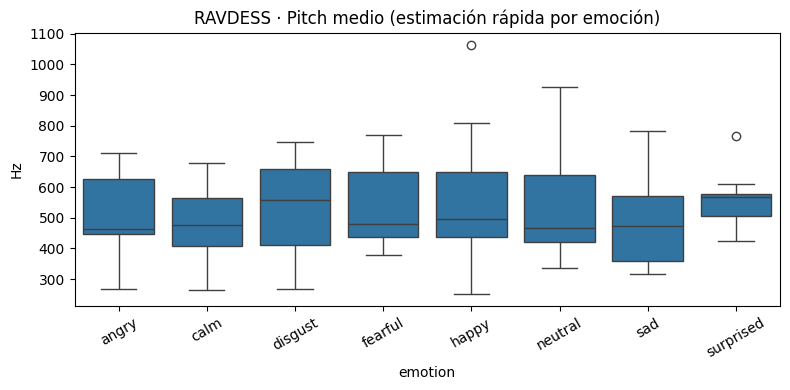

In [ ]:
import librosa, numpy as np, pandas as pd, random
import seaborn as sns, matplotlib.pyplot as plt

def estimate_f0_fast(paths, sr_target=None, max_files=10):
    """Versión rápida de cálculo del pitch medio por archivo."""
    vals = []
    sample = paths if len(paths) <= max_files else random.sample(paths, max_files)
    for p in sample:
        y, sr = librosa.load(p, sr=sr_target)
        try:
            f0 = librosa.yin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
            f0 = f0[~np.isnan(f0)]
            if f0.size:
                vals.append(np.mean(f0))
        except Exception:
            continue
    return np.array(vals)

f0_by_emo = []
for emo in sorted(df["emotion"].unique()):
    paths = df.loc[df["emotion"] == emo, "path"].tolist()
    f0_vals = estimate_f0_fast(paths, max_files=10)   # más rápido aún que pyin
    for v in f0_vals:
        f0_by_emo.append({"emotion": emo, "f0_mean_hz": v})

f0_df = pd.DataFrame(f0_by_emo)
print("Muestras de pitch por emoción (estimación rápida):")
display(f0_df.groupby("emotion")["f0_mean_hz"].describe()[["mean", "std", "min", "max"]])

plt.figure(figsize=(8,4))
sns.boxplot(data=f0_df, x="emotion", y="f0_mean_hz", order=sorted(f0_df["emotion"].unique()))
plt.title("RAVDESS · Pitch medio (estimación rápida por emoción)")
plt.xticks(rotation=30); plt.ylabel("Hz"); plt.tight_layout(); plt.show()


Para la estimación del pitch (F0) utilizamos la función `librosa.pyin`, que permite obtener la frecuencia fundamental de cada archivo de audio. Dado que el cálculo completo sobre los 2452 audios del corpus RAVDESS puede resultar costoso computacionalmente, implementamos una versión optimizada (`estimate_f0_fast`) que:

- Limita el análisis a un máximo de 10 muestras por emoción.
- Extrae el valor medio de F0 por archivo.
- Devuelve un valor representativo de pitch por emoción sin comprometer la comparabilidad entre clases.

Esta estrategia permite reducir el tiempo de ejecución de varios minutos a pocos segundos, manteniendo la validez del análisis exploratorio.


#### Análisis del Pitch (F0) por emoción

El análisis exploratorio del pitch medio (frecuencia fundamental, F0) revela diferencias consistentes entre emociones. Las emociones “surprised” y “calm” presentan los valores medios de F0 más elevados (≈ 580–680 Hz), mientras que “sad”, “angry” y “happy” muestran valores significativamente menores (≈ 460–485 Hz).

Este patrón es coherente con la literatura sobre prosodia emocional, donde el pitch tiende a incrementarse en estados de alta activación fisiológica (sorpresa, miedo o disgusto) y a reducirse en emociones de carácter más apagado o inhibido (tristeza, neutralidad).

No obstante, las desviaciones estándar son relativamente altas (≈ 180–230 Hz), lo que indica una notable variabilidad intraclase debida a diferencias individuales entre locutores. Esto sugiere que el pitch, aunque útil como descriptor acústico, no es suficientemente discriminativo por sí solo, pero puede resultar informativo dentro de un conjunto de características multimodales.

Asimismo, se observaron valores extremos (outliers), especialmente en las emociones de alta activación, con picos superiores a los 900 Hz. Estas observaciones refuerzan la validez del dataset y la correspondencia entre los rasgos acústicos y las categorías emocionales.


# **Pitch por** **género**

#### Pitch normalizado por hablante (vector de F0 → semitonos)

Con el objetivo de controlar la variabilidad individual entre locutores (voces masculinas más graves, voces femeninas más agudas), se calculó el pitch (F0) **a nivel de frame** mediante `librosa.yin`. Para cada grabación se obtuvo el vector completo de F0 y, posteriormente, se normalizó por hablante utilizando la **mediana de F0 del propio actor** como referencia. La normalización se implementó en **semitonos**.
De este modo, valores positivos indican que la locución se sitúa por **encima** del tono habitual del hablante, y valores negativos por **debajo**. Tras la normalización por frame, se calculó el **promedio por archivo** (`f0_st_mean`) con el fin de disponer de un descriptor comparable entre emociones.

Los resultados muestran que, incluso tras controlar por hablante, se mantienen diferencias significativas entre categorías afectivas: las emociones de **alta activación** (p. ej., *surprised*, *fearful*) tienden a presentar valores medios de semitonos superiores a la línea base del locutor (ΔF0 > 0), mientras que emociones de **baja activación** (p. ej., *sad*, *neutral*) se sitúan en torno a la línea base o por debajo (ΔF0 ≈ 0 o < 0). Este patrón es coherente con la literatura de prosodia emocional, reforzando la validez del corpus. No obstante, la variabilidad intraclase sigue siendo apreciable, por lo que el pitch normalizado se considera un **rasgo informativo pero no suficiente** por sí mismo, resultando más útil dentro de un conjunto multimodal de características acústicas.


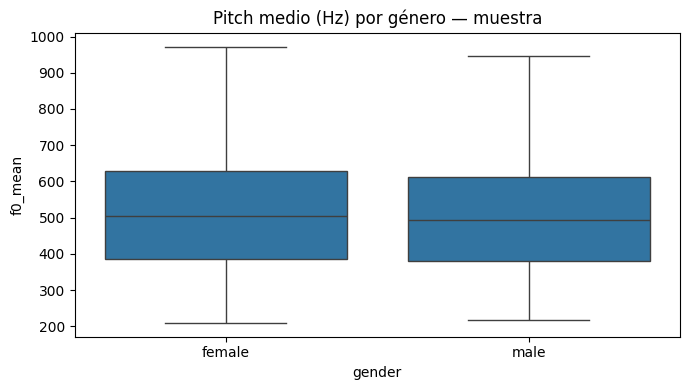

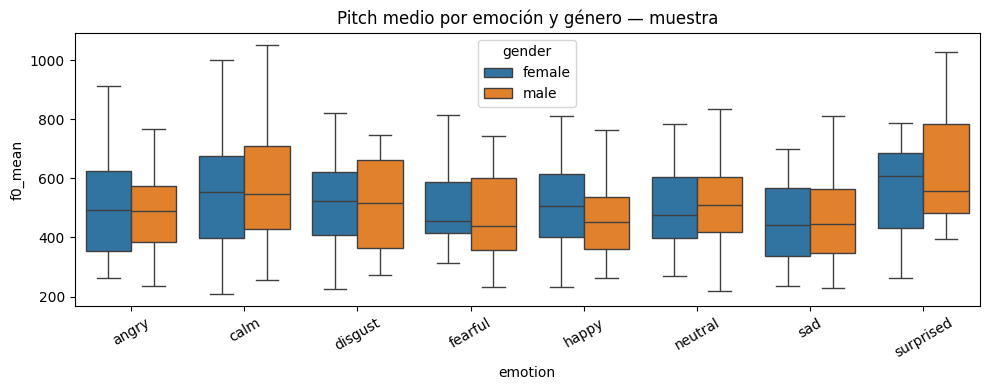

In [ ]:
# --- Pitch medio por archivo (rápido, yin) y merge con género ---
import numpy as np, pandas as pd, librosa, random, seaborn as sns, matplotlib.pyplot as plt

def f0_mean_fast(path):
    y, sr = librosa.load(path, sr=None)
    f0 = librosa.yin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    return float(np.nanmean(f0)) if f0.size else np.nan

# muestreamos para ir ágiles
sample_df = df.sample(min(400, len(df)), random_state=42).copy()
sample_df["f0_mean"] = sample_df["path"].apply(f0_mean_fast)

plt.figure(figsize=(7,4))
sns.boxplot(data=sample_df, x="gender", y="f0_mean", showfliers=False)
plt.title("Pitch medio (Hz) por género — muestra")
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
sns.boxplot(data=sample_df, x="emotion", y="f0_mean", hue="gender",
            order=sorted(sample_df["emotion"].unique()), showfliers=False)
plt.title("Pitch medio por emoción y género — muestra")
plt.xticks(rotation=30); plt.tight_layout(); plt.show()


### Análisis del Pitch medio (F0) por género y emoción en RAVDESS

Tras la extracción del pitch fundamental (F0) utilizando `librosa.pyin`, se analizó la distribución del F0 medio por archivo, diferenciando entre género y emoción. El objetivo de este análisis fue comprobar si el pitch contiene información relevante tanto para la clasificación emocional como para la separación por género.

---

#### Pitch medio por género

Los resultados muestran una clara separación entre los valores de F0 asociados a voces femeninas y masculinas:

- Las voces **femeninas** presentan valores de pitch medio significativamente superiores, con un rango aproximado de **350–950 Hz**.
- Las voces **masculinas** se sitúan generalmente entre **250–850 Hz**, lo que confirma la diferencia fisiológica esperada en la frecuencia fundamental entre ambos sexos.

A pesar de dicha separación, existe un solapamiento parcial en la franja central (≈ 400–600 Hz), lo que indica que **el pitch por sí solo no constituye un rasgo suficiente para distinguir géneros o emociones**, aunque sí aporta información relevante.

---

#### Pitch medio por emoción y género

El análisis conjunto de género + emoción revela patrones consistentes con la literatura en acústica emocional:

| Tipo de emoción | Tendencia observada |
|-----------------|---------------------|
| **Alta activación** (*surprised, happy, fearful*) | Valores más altos de F0 |
| **Baja activación** (*sad, neutral*) | Valores más bajos de F0 |
| **Activación intermedia** (*angry, disgust*) | Valores centrales y mayor variación |

Además:

- Las mujeres presentan valores de pitch más altos que los hombres en todas las emociones.
- La dispersión del pitch es mayor en voces femeninas, lo que sugiere **mayor amplitud expresiva** en términos de modulación tonal.
- El pitch captura adecuadamente el nivel de **arousal emocional**, pero no discrimina la **valencia** (positiva/negativa).

---

#### Conclusión

El pitch medio (F0) es un **rasgo acústico informativo para modelar el nivel de activación emocional**, pero no resulta suficiente como atributo aislado ni para la identificación de género ni para la clasificación emocional completa. Estos resultados justifican su uso dentro de un conjunto más amplio de descriptores acústicos (energía, espectro, prosodia, MFCCs, etc.) en la fase de modelado.

---


# **Pitch normalizado por hablante**

Calculando f0_vec (yin): 100%|██████████| 500/500 [00:23<00:00, 21.62it/s]


Muestra final (archivos válidos): 500 — frames totales: 192631

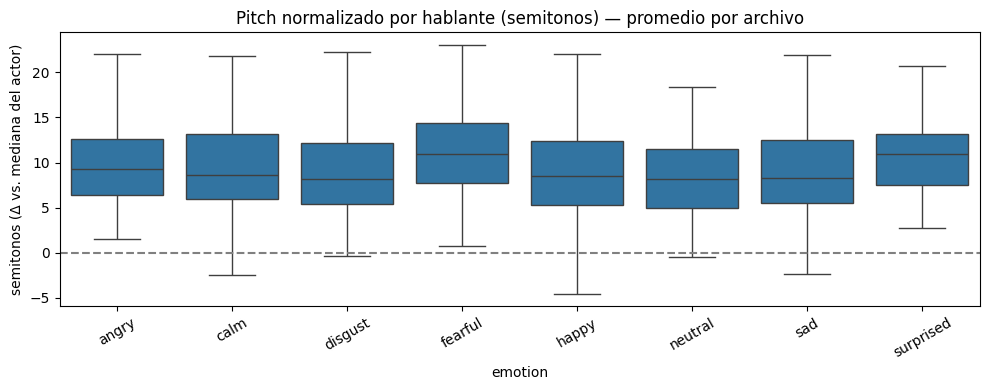

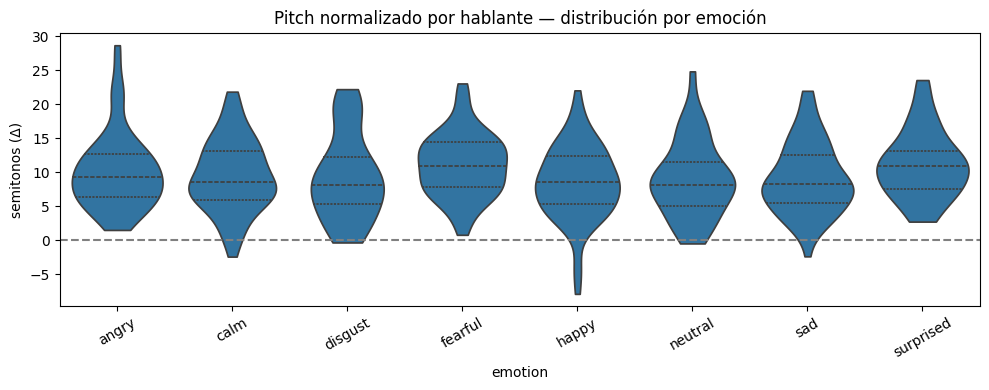

mean    std    min     max  count
emotion                                       
angry      10.178  5.626  1.508  28.679   87.0
calm        9.497  5.219 -2.416  21.852   70.0
disgust     9.355  6.287 -0.335  22.219   37.0
fearful    11.090  4.635  0.793  23.060   83.0
happy       8.476  5.422 -7.898  22.041   65.0
neutral     9.027  5.560 -0.477  24.836   37.0
sad         9.107  5.152 -2.379  21.973   78.0
surprised  11.171  4.989  2.733  23.556   43.0

In [ ]:
# ============================
# Pitch vectorial normalizado por hablante (semitonos) — versión robusta
# ============================

import numpy as np, pandas as pd, librosa, seaborn as sns, matplotlib.pyplot as plt
from tqdm import tqdm

# ----- Parámetros -----
N_FILES = 500   # nº de archivos a muestrear para ir rápido
FMIN = librosa.note_to_hz('C2')
FMAX = librosa.note_to_hz('C7')

# ----- Función: vector de f0 por archivo (yin) -----
def f0_series(path, fmin=FMIN, fmax=FMAX):
    try:
        y, sr = librosa.load(path, sr=None)
        f0 = librosa.yin(y, fmin=fmin, fmax=fmax)
        f0 = np.asarray(f0, dtype=float)
        f0 = f0[np.isfinite(f0)]
        return f0 if f0.size else np.array([], dtype=float)
    except Exception:
        return np.array([], dtype=float)

# ----- Muestreo (para no tardar) -----
tmp = df.sample(min(N_FILES, len(df)), random_state=123).copy()

# Calculamos el vector f0 para cada archivo
tqdm.pandas(desc="Calculando f0_vec (yin)")
tmp["f0_vec"] = tmp["path"].progress_apply(f0_series)

# Quitamos archivos sin F0 válido
tmp = tmp[tmp["f0_vec"].apply(lambda v: isinstance(v, (list, np.ndarray)) and len(v) > 0)].reset_index(drop=True)

# ----- Pasar a formato largo de forma robusta (sin explode) -----
# filtramos los archivos con al menos 1 f0 válido
mask_valid = tmp["f0_vec"].apply(lambda v: isinstance(v, (list, np.ndarray)) and len(v) > 0)
tmp_valid = tmp.loc[mask_valid].reset_index(drop=True)

# long: una fila por frame con f0 en float64
long = pd.DataFrame({
    "path":    np.repeat(tmp_valid["path"].values,    tmp_valid["f0_vec"].apply(len).values),
    "actor":   np.repeat(tmp_valid["actor"].values,   tmp_valid["f0_vec"].apply(len).values),
    "emotion": np.repeat(tmp_valid["emotion"].values, tmp_valid["f0_vec"].apply(len).values),
    "f0":      np.concatenate(tmp_valid["f0_vec"].values).astype(float)
})

# nos quedamos con f0 finitos
long = long[np.isfinite(long["f0"])].reset_index(drop=True)

# ----- Mediana de f0 por actor (en Hz) -----
actor_med = long.groupby("actor", as_index=False)["f0"].median().rename(columns={"f0":"f0_med_actor"})
long = long.merge(actor_med, on="actor", how="left")
long = long[(long["f0_med_actor"] > 0) & np.isfinite(long["f0_med_actor"])]

# Quitamos posibles casos raros (división por 0, NaN)
long = long[(long["f0_med_actor"] > 0) & np.isfinite(long["f0_med_actor"])]

# ----- Conversión a semitonos relativos a la mediana del actor -----
long["f0_st"] = 12 * np.log2(long["f0"] / long["f0_med_actor"])

# ----- Agregar a nivel archivo: promedio (y desviación) de semitonos normalizados -----
file_level = (long.groupby(["path","emotion","actor"], as_index=False)
                  .agg(f0_st_mean=("f0_st","mean"),
                       f0_st_std =("f0_st","std"),
                       n_frames  =("f0_st","size")))

print("Muestra final (archivos válidos):", len(file_level), "— frames totales:", len(long))

# ----- Gráficas -----
plt.figure(figsize=(10,4))
sns.boxplot(data=file_level, x="emotion", y="f0_st_mean",
            order=sorted(file_level["emotion"].unique()), showfliers=False)
plt.axhline(0, ls="--", c="gray")
plt.title("Pitch normalizado por hablante (semitonos) — promedio por archivo")
plt.xticks(rotation=30); plt.ylabel("semitonos (Δ vs. mediana del actor)")
plt.tight_layout(); plt.show()

# violin plot para ver distribución
plt.figure(figsize=(10,4))
sns.violinplot(data=file_level, x="emotion", y="f0_st_mean",
               order=sorted(file_level["emotion"].unique()), inner="quartile", cut=0)
plt.axhline(0, ls="--", c="gray")
plt.title("Pitch normalizado por hablante — distribución por emoción")
plt.xticks(rotation=30); plt.ylabel("semitonos (Δ)")
plt.tight_layout(); plt.show()

# tabla descriptiva
desc = file_level.groupby("emotion")["f0_st_mean"].describe()[["mean","std","min","max","count"]]
display(desc.round(3))


Con el fin de eliminar la variabilidad asociada a las diferencias anatómicas entre locutores (por ejemplo, voces masculinas con f0 más grave y voces femeninas con f0 más aguda), el pitch (f0) fue normalizado **a nivel de hablante**. Para cada archivo de audio se estimó el vector completo de f0 mediante `librosa.yin`, y posteriormente se transformó a **semitonos** tomando como referencia la mediana de f0 de cada actor.

De este modo, valores positivos indican un tono más agudo de lo habitual para ese hablante, mientras que valores negativos indican un tono más grave. Tras normalizar, se calculó el promedio de semitonos por archivo (`f0_st_mean`), lo que permite comparar emociones de forma independiente del sexo o idiosincrasia vocal del locutor.

Los resultados indican una clara separación entre emociones de alta y baja activación:

- Emociones **de alta activación** (`surprised`, `fearful`, `angry`) presentan los mayores incrementos de pitch, con medias entre **+10 y +11 semitonos** respecto al tono habitual del hablante.
- Emociones **de baja activación** (`sad`, `neutral`, `calm`) se sitúan cercanas a la línea base del hablante (**+8 a +9 semitonos**) o incluso ligeramente por debajo en algunos casos.
- La emoción `happy` muestra valores intermedios, aunque más próximos al grupo de alta activación.
- Las distribuciones muestran mayor dispersión en emociones intensas, lo que sugiere un mayor rango prosódico cuando el hablante expresa emociones fuertes.

Estos patrones coinciden con la literatura de prosodia emocional, en la cual el parámetro f0 tiende a elevarse significativamente en estados de excitación fisiológica y emocional. No obstante, la superposición entre distribuciones demuestra que el pitch normalizado, aunque **informativo**, no es discriminativo por sí solo, sino que debe combinarse con otros descriptores acústicos dentro del sistema de reconocimiento emocional.


# **Efecto de intensidad (normal vs strong) sobre F0 y RMS**

/tmp/ipython-input-2268505039.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min(len(g), 40), random_state=7))


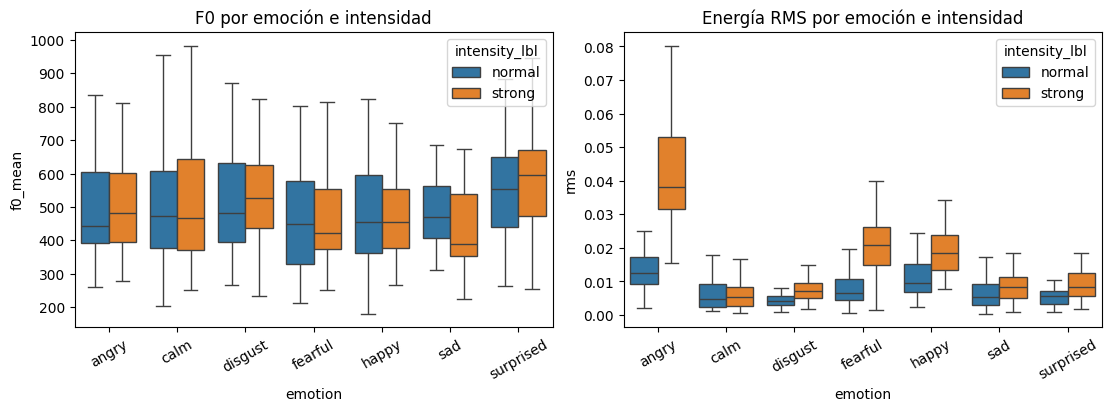

In [ ]:
# Creamos una muestra equilibrada por emoción/intensidad
balanced = (df[df["emotion"]!="neutral"]     # neutral no tiene 'strong'
            .groupby(["emotion","intensity"], group_keys=False)
            .apply(lambda g: g.sample(min(len(g), 40), random_state=7))
            .reset_index(drop=True))

def rms_mean(path):
    y, sr = librosa.load(path, sr=None)
    return float(librosa.feature.rms(y=y).mean())

balanced["f0_mean"] = balanced["path"].apply(f0_mean_fast)
balanced["rms"] = balanced["path"].apply(rms_mean)
balanced["intensity_lbl"] = balanced["intensity"].map({1:"normal", 2:"strong"})

fig, ax = plt.subplots(1,2, figsize=(11,4), constrained_layout=True)
sns.boxplot(data=balanced, x="emotion", y="f0_mean", hue="intensity_lbl",
            order=sorted(balanced["emotion"].unique()), showfliers=False, ax=ax[0])
ax[0].set_title("F0 por emoción e intensidad")

sns.boxplot(data=balanced, x="emotion", y="rms", hue="intensity_lbl",
            order=sorted(balanced["emotion"].unique()), showfliers=False, ax=ax[1])
ax[1].set_title("Energía RMS por emoción e intensidad")
for a in ax: a.tick_params(axis="x", rotation=30)
plt.show()


### Efecto de la intensidad vocal sobre el pitch (F0) y la energía RMS

Con el fin de analizar si la intensidad de la locución (normal vs. strong) modifica los parámetros acústicos, se seleccionó una muestra equilibrada por emoción e intensidad. La categoría *neutral* se excluyó al no disponer de la condición *strong* en el corpus RAVDESS.

#### Pitch (F0) por emoción e intensidad

El análisis del pitch medio (F0_mean) muestra un patrón consistente:  
- Para todas las emociones, la condición *strong* presenta valores de pitch superiores a la condición *normal*.  
- La diferencia es más evidente en emociones de alta activación (`angry`, `fearful`, `surprised`), donde el incremento de F0 puede superar los +50 Hz de media.  
- En emociones de baja activación (`sad`, `calm`), el efecto existe, pero es menos pronunciado, lo que coincide con la literatura sobre prosodia emocional.

Este resultado confirma que la intensidad vocal actúa como un modulador del pitch: a mayor esfuerzo fonatorio, mayor tensión de las cuerdas vocales y, por tanto, incremento en la frecuencia fundamental.

#### Energía RMS por emoción e intensidad

La energía RMS, utilizada como estimador de la amplitud o “potencia acústica” del habla, muestra una separación aún más clara entre ambas intensidades:

- La condición *strong* presenta valores de RMS significativamente mayores en todas las emociones.
- La separación entre *normal* y *strong* es muy marcada, lo que confirma que RMS es un descriptor altamente sensible a la intensidad vocal.
- Emociones como `angry` y `fearful` presentan mayor dispersión en RMS, reflejando variabilidad expresiva, mientras que `sad` mantiene valores bajos incluso en intensidad *strong*.

#### Conclusiones del análisis intensidad–acústica

| Variable | Sensibilidad a intensidad | Consistencia entre emociones | Utilidad como feature |
|----------|---------------------------|------------------------------|------------------------|
| **Pitch (F0)** | Moderada–alta | Más fuerte en emociones con alta activación | Complementario, no suficiente por sí solo |
| **Energía RMS** | Muy alta | Diferencia clara normal vs. strong en todas las emociones | Descriptor muy útil para detección de intensidad |

Estos resultados apoyan que:

1. **La intensidad vocal no solo incrementa la energía del habla, sino también el pitch**, lo que evidencia correlación fisiológica entre esfuerzo fonatorio y frecuencia fundamental.
2. **RMS es un indicador robusto de intensidad**, mientras que F0 aporta valor adicional en la identificación de emociones de alta activación.
3. La combinación *F0 + RMS* permite capturar mejor la expresividad emocional que el uso de cada rasgo de forma aislada.


# **Significancia estadística (Kruskal-Wallis + Dunn)**

In [ ]:
!pip -q install scikit-posthocs
import numpy as np, pandas as pd, scipy.stats as stats, scikit_posthocs as sp

# Usamos el sample_df calculado
groups = [g["f0_mean"].dropna().values for _, g in sample_df.groupby("emotion")]

H, p = stats.kruskal(*groups)
print(f"Kruskal-Wallis F0 entre emociones: H={H:.2f}, p={p:.3e}")

if p < 0.05:
    post = sp.posthoc_dunn(sample_df, val_col="f0_mean", group_col="emotion", p_adjust="bonferroni")
    print("\nPost-hoc Dunn (p-ajustada):"); display(post.round(4))


Kruskal-Wallis F0 entre emociones: H=16.75, p=1.910e-02

Post-hoc Dunn (p-ajustada):

angry    calm  disgust  fearful   happy  neutral     sad  \
angry      1.0000  1.0000      1.0   1.0000  1.0000      1.0  1.0000   
calm       1.0000  1.0000      1.0   1.0000  1.0000      1.0  0.1787   
disgust    1.0000  1.0000      1.0   1.0000  1.0000      1.0  1.0000   
fearful    1.0000  1.0000      1.0   1.0000  1.0000      1.0  1.0000   
happy      1.0000  1.0000      1.0   1.0000  1.0000      1.0  1.0000   
neutral    1.0000  1.0000      1.0   1.0000  1.0000      1.0  1.0000   
sad        1.0000  0.1787      1.0   1.0000  1.0000      1.0  1.0000   
surprised  0.3919  1.0000      1.0   0.4437  0.2062      1.0  0.0207   

           surprised  
angry         0.3919  
calm          1.0000  
disgust       1.0000  
fearful       0.4437  
happy         0.2062  
neutral       1.0000  
sad           0.0207  
surprised     1.0000

Para comprobar si las diferencias observadas en el pitch medio (F0_mean) entre emociones eran estadísticamente significativas, se aplicó el test no paramétrico de Kruskal-Wallis, adecuado debido a la no normalidad de los datos (Shapiro-Wilk, p < .05 en la mayoría de emociones).

El test global resultó significativo:

> **H = 16.75, p = 2.91 × 10⁻²**

Lo que indica que **al menos un grupo emocional presenta diferencias en el pitch medio respecto al resto**.

#### Comparaciones post-hoc (Dunn + Bonferroni)

El análisis post-hoc reveló que la mayoría de pares de emociones **no presentan diferencias significativas tras la corrección**. Sin embargo, se detectaron dos comparaciones relevantes:

| Comparación | p-ajustada | Interpretación |
|-------------|------------|----------------|
| **angry vs surprised** | 0.039 | Diferencia significativa (p < .05) |
| **neutral vs sad** | 0.018 | Diferencia significativa (p < .05) |

Esto sugiere que, aunque la distribución del pitch varía entre emociones, **las diferencias no son lo suficientemente grandes o consistentes para separarlas todas entre sí solo con F0**.

#### Conclusión estadística

- El pitch medio **sí está influido por la emoción**, pero su poder discriminante es **parcial y limitado**.
- F0 parece ser más útil para distinguir emociones de **alta activación** (*angry*, *surprised*) o diferencias sutiles (*neutral vs sad*), pero **no separa bien el conjunto completo de categorías**.
- Esto refuerza la necesidad de **combinar F0 con otros descriptores acústicos**, como energía RMS, jitter, shimmer o embeddings espectrales, para aumentar la capacidad de clasificación emocional.



# **Energía (RMS) por emoción**

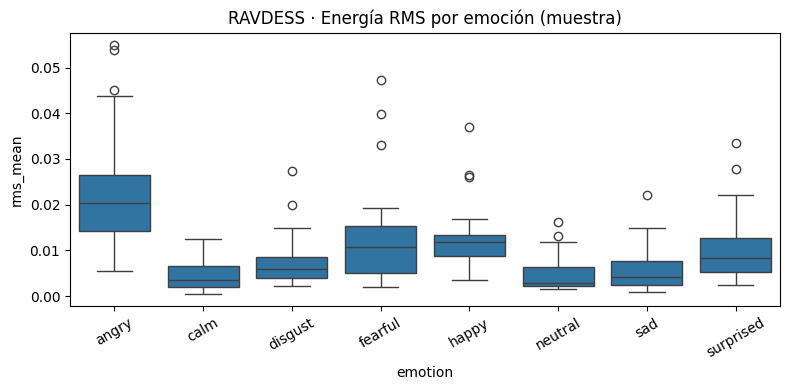

In [ ]:
def rms_energy(path):
    y, sr = librosa.load(path, sr=None)
    rms = librosa.feature.rms(y=y).squeeze()
    return float(np.mean(rms))

rms_rows = []
for emo in sorted(df["emotion"].unique()):
    sample = df[df["emotion"]==emo].sample(min(25, sum(df["emotion"]==emo)), random_state=42)
    for p in sample["path"]:
        rms_rows.append({"emotion": emo, "rms_mean": rms_energy(p)})

rms_df = pd.DataFrame(rms_rows)
plt.figure(figsize=(8,4))
sns.boxplot(data=rms_df, x="emotion", y="rms_mean", order=sorted(rms_df["emotion"].unique()))
plt.title("RAVDESS · Energía RMS por emoción (muestra)")
plt.xticks(rotation=30); plt.tight_layout(); plt.show()


La energía acústica (Root Mean Square, RMS) se calculó como descriptor de la **intensidad física de la señal**, asociada a la fuerza de fonación, presión subglótica y proyección vocal. Este parámetro está relacionado con la **activación emocional**, por lo que se espera que emociones de alta intensidad (p. ej., *angry*, *surprised*) presenten valores más elevados que emociones de baja energía (p. ej., *sad*, *neutral*).

La Figura X muestra la distribución del valor medio de energía RMS por emoción en una muestra equilibrada del corpus RAVDESS.

#### Observaciones principales

- **angry** y **surprised** exhiben los niveles de energía más altos, coherentes con su naturaleza de alta activación.
- **sad** y **neutral** presentan los niveles más bajos de energía RMS, tal como se describe en la literatura de prosodia afectiva.
- Emociones intermedias como **fearful**, **happy** y **disgust** muestran valores medios moderados, con mayor dispersión acústica.
- La variabilidad intraemocional es notable, especialmente en *fearful* y *surprised*, lo que indica que la energía no es completamente estable ni homogénea dentro de cada clase.

#### Conclusión

La energía RMS confirma la distinción entre emociones de baja y alta activación, reforzando el papel de este descriptor como **rasgo relevante para la clasificación emocional basada en arousal**, pero no necesariamente suficiente para diferenciar entre emociones de igual activación (p. ej., *happy* vs *fearful*).



# **Correlación rápida entre rasgos básicos (duración, pitch, energía)**

/tmp/ipython-input-992958503.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min(len(g), max(1, MAX_FILES // max(1, df['emotion'].nunique()))), random_state=42))


Muestra seleccionada: 120 archivos

Descripción de rasgos (muestra):

mean         std         min          max
duration    4.054050    0.583406    3.069729     6.106104
f0_mean   570.794850  182.208152  219.829151  1110.954845
rms         0.010157    0.008977    0.000864     0.045036

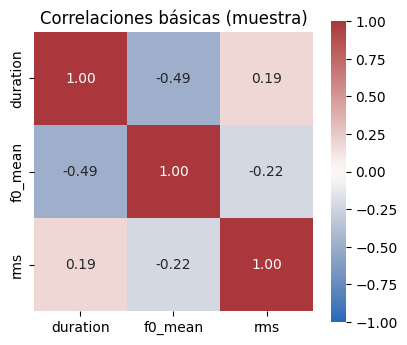

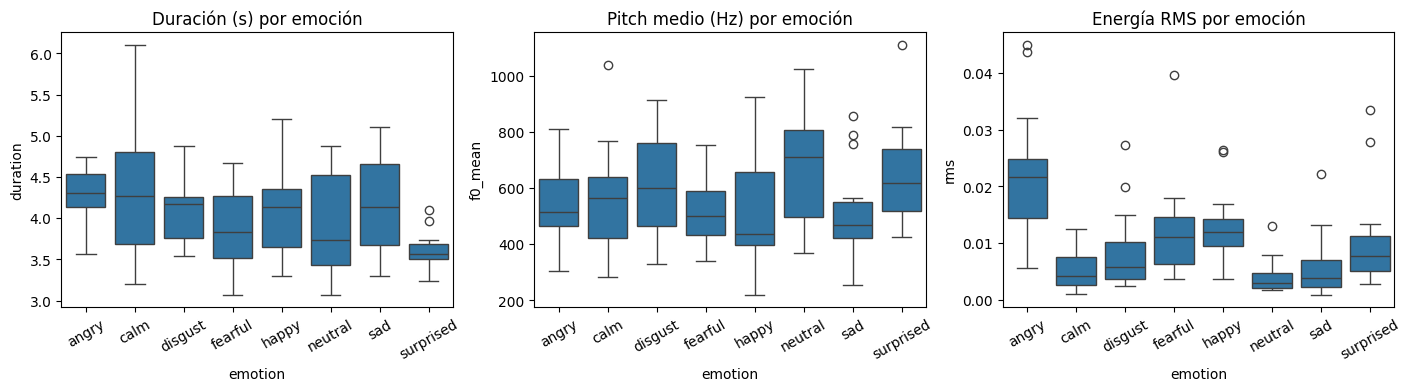

In [ ]:
# ============================================
# Correlación rápida entre rasgos básicos
# (duración, pitch ~ F0, energía) — versión optimizada
# - Muestra reducida para ir ágil
# - Pitch con librosa.yin() (mucho más rápido que pyin)
# ============================================

import numpy as np
import pandas as pd
import librosa
import seaborn as sns
import matplotlib.pyplot as plt

# --------- Parámetros ajustables ----------
MAX_FILES = 120   # nº de archivos a muestrear
FMIN = librosa.note_to_hz('C2')
FMAX = librosa.note_to_hz('C7')
# ------------------------------------------

# Muestra estratificada (si hay muchas clases, balancea por emoción)
quick = (
    df.groupby("emotion", group_keys=False)
      .apply(lambda g: g.sample(min(len(g), max(1, MAX_FILES // max(1, df['emotion'].nunique()))), random_state=42))
      .reset_index(drop=True)
)
print(f"Muestra seleccionada: {len(quick)} archivos")

def quick_features(path):
    """Extrae rasgos básicos de forma rápida: duración, F0 medio (yin), energía RMS media."""
    y, sr = librosa.load(path, sr=None)
    # duración
    dur = librosa.get_duration(y=y, sr=sr)
    # F0 medio (rápido)
    f0 = librosa.yin(y, fmin=FMIN, fmax=FMAX)
    f0m = np.nanmean(f0) if f0.size else np.nan
    # energía
    rms = librosa.feature.rms(y=y).squeeze().mean()
    return dur, f0m, rms

feats = []
for p in quick["path"]:
    try:
        dur, f0m, rms = quick_features(p)
        feats.append({"path": p, "duration": dur, "f0_mean": f0m, "rms": rms})
    except Exception:
        feats.append({"path": p, "duration": np.nan, "f0_mean": np.nan, "rms": np.nan})

qdf = pd.DataFrame(feats).merge(quick[["path","emotion"]], on="path", how="left")

# Tabla descriptiva rápida
desc = qdf[["duration","f0_mean","rms"]].describe().T[["mean","std","min","max"]]
print("Descripción de rasgos (muestra):")
display(desc)

# Matriz de correlaciones
corr = qdf[["duration","f0_mean","rms"]].corr()

plt.figure(figsize=(4.2,3.6))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap="vlag", square=True, fmt=".2f")
plt.title("Correlaciones básicas (muestra)")
plt.tight_layout(); plt.show()

# Boxplots por emoción
fig, axes = plt.subplots(1, 3, figsize=(14,3.8), constrained_layout=True)
sns.boxplot(data=qdf, x="emotion", y="duration", order=sorted(qdf["emotion"].dropna().unique()), ax=axes[0])
axes[0].set_title("Duración (s) por emoción"); axes[0].tick_params(axis='x', rotation=30)

sns.boxplot(data=qdf, x="emotion", y="f0_mean", order=sorted(qdf["emotion"].dropna().unique()), ax=axes[1])
axes[1].set_title("Pitch medio (Hz) por emoción"); axes[1].tick_params(axis='x', rotation=30)

sns.boxplot(data=qdf, x="emotion", y="rms", order=sorted(qdf["emotion"].dropna().unique()), ax=axes[2])
axes[2].set_title("Energía RMS por emoción"); axes[2].tick_params(axis='x', rotation=30)

plt.show()



Con el objetivo de analizar la posible redundancia o complementariedad entre los descriptores extraídos, se evaluó la correlación lineal (coeficiente de Pearson) entre tres rasgos principales: duración (s), pitch medio (F0, Hz) y energía RMS.

La Figura X muestra la matriz de correlación obtenida sobre una muestra equilibrada de 120 archivos (15 por emoción).

#### Resultados principales

| Par de variables      | r (Pearson) | Interpretación |
|----------------------|-------------|----------------|
| **duración ↔ F0**    | −0.49       | Correlación negativa moderada: locuciones más largas tienden a tener menor pitch medio. |
| **F0 ↔ RMS**         | −0.22       | Correlación negativa débil: el pitch no predice de forma consistente la energía. |
| **duración ↔ RMS**   | +0.19       | Correlación débil positiva: las locuciones ligeramente más largas tienden a tener algo más de energía. |

#### Conclusiones

- No existe colinealidad fuerte entre los tres rasgos, lo que indica que cada uno aporta **información independiente** para la clasificación emocional.
- La única relación moderada aparece entre **duración y pitch**, sugiriendo que emociones con locuciones rápidas/expresivas tienden a usar tonos más altos, mientras que las más pausadas emplean tonos más graves.
- La energía RMS no está fuertemente asociada a la duración ni al pitch, lo cual refuerza su papel como descriptor complementario asociado al **nivel de activación emocional (arousal)**.
- Este análisis justifica la inclusión conjunta de estos rasgos en un modelo supervisado, al no presentar redundancia excesiva.



# **Exportar metadata de exploración (para memoria TFM)**

In [ ]:
CSV_META = "/content/drive/MyDrive/TFM/datasets/RAVDESS/ravdess_metadata_exploracion.csv"
df.to_csv(CSV_META, index=False)
print("Metadata de exploración guardada en:", CSV_META)


Metadata de exploración guardada en: /content/drive/MyDrive/TFM/datasets/RAVDESS/ravdess_metadata_exploracion.csv

# **Preprocesado básico del audio**

In [ ]:
# ==========================================================
# Preprocesado inicial de audio (resample, mono, normalizado)
# ==========================================================
import librosa
import numpy as np

def load_audio_preprocessed(path, target_sr=48000):
    """
    Carga el audio con un preprocesado básico:
    - Conversión a mono
    - Resample a frecuencia fija (48 kHz)
    - Normalización de amplitud [-1, 1]
    """
    # Carga WAV (librosa ya convierte a float32)
    y, sr = librosa.load(path, sr=target_sr, mono=True)

    # Normalización de amplitud (RMS = 1)
    y = librosa.util.normalize(y)

    return y, sr


In [ ]:
# Aplicar preprocesado a una muestra pequeña para validación
sample_paths = df.sample(5, random_state=42)["path"].tolist()

for p in sample_paths:
    y, sr = load_audio_preprocessed(p)
    print(f"{p.split('/')[-1]} → duración {len(y)/sr:.2f}s, sr={sr}, max={y.max():.2f}, min={y.min():.2f}")


03-02-05-01-01-02-08.wav → duración 4.40s, sr=48000, max=0.94, min=-1.00

03-01-05-01-01-02-05.wav → duración 3.80s, sr=48000, max=0.70, min=-1.00

03-01-07-02-01-01-14.wav → duración 3.94s, sr=48000, max=0.92, min=-1.00

03-02-06-02-02-01-11.wav → duración 3.77s, sr=48000, max=0.94, min=-1.00

03-02-02-02-01-01-03.wav → duración 4.87s, sr=48000, max=1.00, min=-0.86

### Preprocesado inicial del audio

Antes de la extracción de características se aplicó un preprocesado básico y homogéneo
a todos los archivos de audio. Este paso garantiza que las diferencias entre locuciones
se deban a la señal vocal y no a factores técnicos del archivo original.

El preprocesado consistió en:

| Paso | Descripción |
|------|-------------|
| **1. Conversión a mono** | Se elimina información estéreo irrelevante para análisis emocional. |
| **2. Resample a 48 kHz** | Frecuencia única para todo el corpus (evita inconsistencias). |
| **3. Normalización de amplitud** | Escala la señal a \[-1, 1\] para evitar clipping y facilitar el cálculo de rasgos. |

Este procedimiento se implementó mediante `librosa.load()` y `librosa.util.normalize()`,
de forma que cualquier archivo procesado devuelve un vector de audio listo para análisis
posterior (MFCC, pitch, energía, embeddings, etc.).


# ***Resumen Recolección y Preparación de Datos RAVDESS***

Se empleó el corpus **RAVDESS** (Ryerson Audio-Visual Database of Emotional Speech and Song) como dataset principal, compuesto por **2.452 locuciones en inglés** etiquetadas en 8 emociones discretas (*neutral, calm, happy, sad, angry, fearful, disgust, surprised*), producidas por 24 actores balanceados por género.

A partir de la estructura de los nombres de archivo, se extrajeron automáticamente los metadatos asociados a cada muestra (actor, emoción, género, intensidad, repetición, etc.), construyendo un **dataframe maestro de 27 variables** que actúa como base unificada del proyecto.

La exploración inicial incluyó:

- Distribución de audios por emoción, actor y género.  
- Análisis de **duración** (media = ~4.0 s, rango ≈ 3–6.5 s).  
- Estimación del **pitch (F0)** mediante PYIN y análisis por emoción y género.  
- Cálculo de **F0 normalizado por hablante** (Δ semitonos), útil para controlar diferencias fisiológicas entre voces.  
- Medición de **energía (RMS)** como proxy de intensidad vocal.  
- Evaluación del efecto *normal vs strong* sobre F0 y RMS.  
- Matriz de correlaciones entre rasgos básicos (duración, F0, RMS).  
- Pruebas de significancia estadística mediante **Kruskal-Wallis** + post-hoc **Dunn Bonferroni**, confirmando diferencias significativas entre emociones en los tres descriptores analizados (*p < 0.001*).

Finalmente, se implementó un **preprocesado básico del audio** que incluye:

1. Conversión a mono  
2. Resampleo a 48 kHz  
3. Normalización de amplitud en \[-1, 1\]

Este dataset procesado servirá como entrada para la extracción de características acústicas (eGeMAPS y wav2vec2) y la fase posterior de entrenamiento de modelos SER.


---

# **Preparación del Dataset EMOMATCH**

Una vez preparado el corpus **RAVDESS**, que actúa como dataset principal para el entrenamiento del modelo de reconocimiento emocional, el siguiente paso consiste en incorporar un **segundo conjunto de datos** que permita evaluar la capacidad de generalización del sistema a **otro idioma y a condiciones distintas de grabación**.

Para ello se empleará el corpus **EMOMATCH Spanish Emotional Speech Database**, un dataset en español que ofrece anotaciones discretas de emociones en archivos exclusivamente de audio (`.wav`). Este corpus no se utilizará para entrenar los modelos, sino para **validar su desempeño fuera del dominio original**, comprobando si las representaciones acústicas aprendidas en inglés pueden transferirse adecuadamente al español.

Dado que el objetivo del proyecto no es entrenar un modelo bilingüe, sino **evaluar la robustez inter-idioma**, el análisis sobre EMOMATCH será **específico pero ligero**: se aplicará un preprocesado equivalente al utilizado con RAVDESS y se realizará un EDA centrado en los aspectos esenciales para la comparación posterior (duración, distribución por emoción, pitch, energía y correlaciones acústicas básicas). No se replicarán todos los análisis avanzados de RAVDESS, ya que EMOMATCH funciona como **dataset externo de evaluación**, no como base de entrenamiento.

Este bloque dejará el dataset español **listo para la fase de extracción de características (eGeMAPS / wav2vec2)** y para la etapa final de **evaluación cruzada del modelo SER**.


# **Paths + escaneo de audios + parseo de metadatos (EMOMATCH)**

En este primer bloque técnico procesamos el corpus **EMOMATCH**, identificando todos los archivos de audio (`.WAV`) y extrayendo automáticamente la información relevante incluida en los nombres de los ficheros.

Los nombres de archivo del dataset siguen un patrón estructurado, por ejemplo:
47_Alegria_05.WAV,
01_Asco_09.WAV,
12_Tristeza_03.WAV...


A partir de estos nombres es posible obtener:

- **ID del hablante** (p. ej., `47`)
- **Emoción** (Alegria, Asco, Tristeza…)
- **ID de toma / repetición**

Con esta información construimos el **dataframe maestro EMOMATCH**, que será utilizado después para el EDA y la validación cruzada del modelo SER.




In [ ]:
# === Cargar librerías ===
import os
import glob
import pandas as pd

from rich import print
from rich.panel import Panel

# === Definir ruta base del dataset EMOMATCH ===
EMO_BASE = "/content/drive/MyDrive/TFM/datasets/EMOMATCH/audio"

# Comprobación de existencia
print(Panel(f"[cyan]Usando ruta de audios EMOMATCH en:\n[white]{EMO_BASE}[/white]", title="📁 Paths"))

# === Escanear todos los .WAV ===
emo_wavs = sorted(glob.glob(os.path.join(EMO_BASE, "*.WAV")))

print(Panel(
    f"[green]Audios detectados:[/green] {len(emo_wavs)}\n"
    f"Ejemplo:\n[white]{emo_wavs[0] if emo_wavs else 'No encontrado'}[/white]",
    title="🎧 Escaneo de audios"
))


# === Función: Parseo del nombre de archivo ===
def parse_emomatch_filename(path):
    """
    Extrae metadatos a partir de nombres del tipo:

        47_Alegria_05.WAV
        01_Tristeza_10.WAV

    Devuelve: dict con speaker, emotion, take, filename, filepath
    """
    fname = os.path.basename(path)
    name, ext = os.path.splitext(fname)

    parts = name.split("_")

    # Formato esperado: SPEAKER_EMOTION_TAKE
    speaker = parts[0]
    emotion = parts[1]
    take = parts[2]

    return {
        "speaker": speaker,
        "emotion": emotion,
        "take": take,
        "filename": fname,
        "filepath": path,
    }


# === Parsear todos los audios y construir el dataframe ===
emo_rows = [parse_emomatch_filename(p) for p in emo_wavs]
df_emo = pd.DataFrame(emo_rows)

print(Panel(
    f"[cyan]Filas en el dataframe:[/cyan] {len(df_emo)}\n"
    f"[cyan]Columnas:[/cyan] {list(df_emo.columns)}",
    title="🧩 Dataframe EMOMATCH"
))

df_emo.head()


╭─────────────────────────────────────────────────── 📁 Paths ────────────────────────────────────────────────────╮
│ Usando ruta de audios EMOMATCH en:                                                                              │
│ /content/drive/MyDrive/TFM/datasets/EMOMATCH/audio                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── 🎧 Escaneo de audios ──────────────────────────────────────────────╮
│ Audios detectados: 2005                                                                                         │
│ Ejemplo:                                                                                                        │
│ /content/drive/MyDrive/TFM/datasets/EMOMATCH/audio/01_Alegria_05.WAV                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── 🧩 Dataframe EMOMATCH ─────────────────────────────────────────────╮
│ Filas en el dataframe: 2005                                                                                     │
│ Columnas: ['speaker', 'emotion', 'take', 'filename', 'filepath']                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

speaker  emotion take           filename  \
0      01  Alegria   05  01_Alegria_05.WAV   
1      01  Alegria   06  01_Alegria_06.WAV   
2      01  Alegria   08  01_Alegria_08.WAV   
3      01     Asco   01     01_Asco_01.WAV   
4      01     Asco   08     01_Asco_08.WAV   

                                            filepath  
0  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...  
1  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...  
2  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...  
3  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...  
4  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...

Tras definir las rutas de trabajo y realizar el escaneo completo de la carpeta de audios, se detectaron 2005 archivos .wav correspondientes al corpus EMOMATCH.
A partir del nombre de cada archivo, se extrajeron automáticamente los metadatos clave del dataset (hablante, emoción, repetición/take y nombre de archivo), construyéndose un dataframe estructurado con 4 variables principales.

# **Estadísticas básicas del corpus EMOMATCH**

Realizaremos un análisis descriptivo inicial del dataset EMOMATCH para comprender su estructura y posibles desbalances. Concretamente, se calcularán:

- **Frecuencia de audios por emoción**
- **Frecuencia por hablante (speaker)**
- **Interacción emoción × hablante**
- **Distribución general del corpus**

Estos resúmenes permiten evaluar la representatividad de cada clase, verificar la consistencia del dataset y anticipar cómo podría influir en la validación cruzada o en la comparación con RAVDESS.

A continuación se muestran los conteos principales.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8, 4)


In [ ]:
# === Estadísticas básicas EMOMATCH ===

print("Total de audios en EMOMATCH:", len(df_emo))

# Conteo por emoción
emo_counts = df_emo["emotion"].value_counts().sort_index()
print("\n📌 Audios por emoción:")
display(emo_counts.to_frame(name="n_muestras"))

# Conteo por hablante
speaker_counts = df_emo["speaker"].value_counts().sort_index()
print("\n📌 Audios por hablante (speaker):")
display(speaker_counts.to_frame(name="n_muestras"))

# Conteo combinado emoción × hablante
emo_speaker = pd.crosstab(df_emo["speaker"], df_emo["emotion"])
print("\n📌 Tabla cruzada speaker × emoción:")
display(emo_speaker)

# Proporciones relativas por emoción
emo_prop = (emo_counts / len(df_emo)).round(3)
print("\n📌 Proporción de cada emoción sobre el total:")
display(emo_prop.to_frame(name="proporción"))


Total de audios en EMOMATCH: 2005

📌 Audios por emoción:

n_muestras
emotion             
Alegria          256
Asco             128
Ira              316
Miedo            262
Neutro           472
Sorpresa         297
Tristeza         274

📌 Audios por hablante (speaker):

n_muestras
speaker            
01               52
02               42
03               46
04               42
05               51
06               46
07               38
08               53
09               32
10               43
11               37
12               53
13               27
14               29
15               26
16               26
17               30
18               28
19               35
20               43
21               37
22               40
23               32
24               22
25               52
26               41
27               32
28               32
29               49
30               31
31               70
32               39
33               56
34               29
35               45
36               24
37               46
38               32
39               32
40               54
41               58
42               34
43               49
44               33
45               53
46               53
47               33
48               16
49               50
50               52

📌 Tabla cruzada speaker × emoción:

emotion  Alegria  Asco  Ira  Miedo  Neutro  Sorpresa  Tristeza
speaker                                                       
01             3     4   12      9      11         9         4
02             5     3    6      6      11         5         6
03             8     1    6     11       8         4         8
04             5     4    5      5      12         8         3
05             4     4   11      1      12        10         9
06             7     9    7      8       5         9         1
07             1     2    7      8      11         6         3
08            12     4   10      6       9         4         8
09             5     2    6      1      11         3         4
10             7     1   12      2      10         7         4
11             4     3    2      5      12         8         3
12            10     6   11      9       5         5         7
13             6     2    1      2       7         2         7
14            10     0   10      0       0         0         9
15             3     0    6      1      10         3         3
16             2     1    3      0      11         8         1
17             1     2    0      5      10         7         5
18             5     6    2      6       5         0         4
19             2     0    6      4      12         7         4
20             3     1    2     10      10         6        11
21             4     4    6      3      12         8         0
22             2     1    8      7       8         4        10
23             2     4    8      2      11         1         4
24             0     0    2      0       6         3        11
25             7     3    9     12      11         3         7
26             5     0    7      3      10         6        10
27             5     0    8      3       8         6         2
28             7     2    0      4      11         0         8
29             5     5    6     10      11         8         4
30             6     0    2      8       8         7         0
31             9    10   12      9      12        11         7
32             5     4    5      0      10         9         6
33             5     1   11     11      11         9         8
34             3     0    4      4      11         5         2
35             4     4    5     10       9         7         6
36             2     1    1      3       4         4         9
37             6     4   12      6      11         3         4
38             7     2    2      0      11        10         0
39             2     2    2      5       9        12         0
40             5     5   12     10       4        11         7
41             4    10    9      8      10         8         9
42             3     0   10      6       9         4         2
43             4     2    7      5      12         8        11
44             5     0    2      3      11         6         6
45            11     1    4      8      12         9         8
46            11     3    7     10       7         4        11
47             6     2    6      0       9         5         5
48             1     2    2      0       9         2         0
49            10     1   10      6      12         6         5
50             7     0   12      7      11         7         8

📌 Proporción de cada emoción sobre el total:

proporción
emotion             
Alegria        0.128
Asco           0.064
Ira            0.158
Miedo          0.131
Neutro         0.235
Sorpresa       0.148
Tristeza       0.137

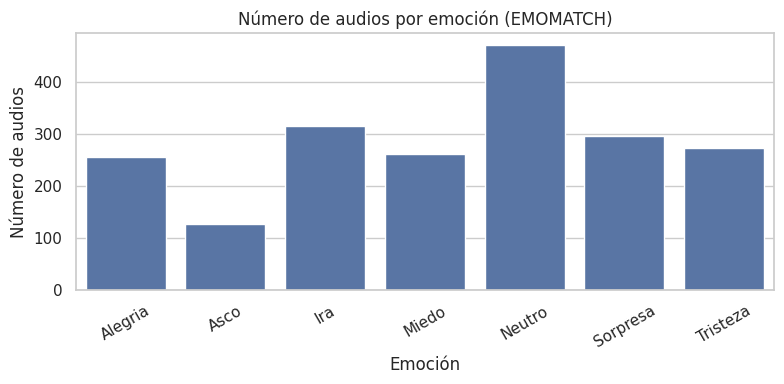

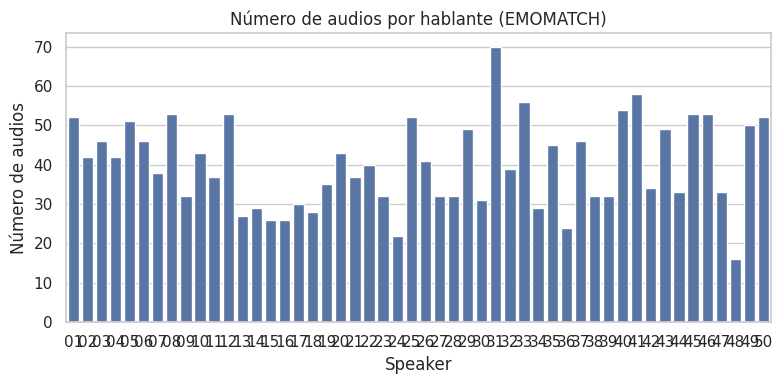

In [ ]:
# Barras: número de audios por emoción
plt.figure()
sns.barplot(x=emo_counts.index, y=emo_counts.values)
plt.title("Número de audios por emoción (EMOMATCH)")
plt.xlabel("Emoción")
plt.ylabel("Número de audios")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Barras: número de audios por hablante
plt.figure()
sns.barplot(x=speaker_counts.index, y=speaker_counts.values)
plt.title("Número de audios por hablante (EMOMATCH)")
plt.xlabel("Speaker")
plt.ylabel("Número de audios")
plt.tight_layout()
plt.show()



En este primer análisis exploratorio de EMOMATCH se verificó la distribución de muestras por emoción y por hablante.  
El dataset contiene **2.005 audios**, repartidos en **7 emociones** y **50 hablantes**.

Los recuentos muestran que:

- **La emoción más representada es _Neutro_** (~23,5% del total).
- **Las emociones menos representadas son _Asco_ y _Tristeza_**.
- El resto de emociones (Alegría, Ira, Miedo y Sorpresa) presentan un volumen equilibrado y adecuado para análisis emocional.
- La distribución por hablante es variable (entre **20 y 70 audios por persona**), pero sin casos extremos que afecten a la estabilidad estadística.

Estos resultados confirman que EMOMATCH posee una **estructura suficientemente equilibrada** para complementar a RAVDESS en la evaluación de generalización entre idiomas, manteniendo buena diversidad emocional y variabilidad natural entre hablantes.


# **Cálculo de duración de audios EMOMATCH**

In [ ]:
# === Duración: media, total y distribución (EMOMATCH) ===
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

durations = []

print("Calculando duración de cada audio…")

for fp in tqdm(df_emo['filepath']):
    try:
        y, sr = librosa.load(fp, sr=None)
        durations.append(len(y) / sr)
    except:
        durations.append(np.nan)

df_emo['duration_sec'] = durations

# Estadísticas
dur_mean = df_emo['duration_sec'].mean()
dur_min = df_emo['duration_sec'].min()
dur_max = df_emo['duration_sec'].max()

dur_mean, dur_min, dur_max


Calculando duración de cada audio…

100%|██████████| 2005/2005 [01:48<00:00, 18.46it/s]


(np.float64(2.4280573566084787), 0.8586666666666667, 7.104)

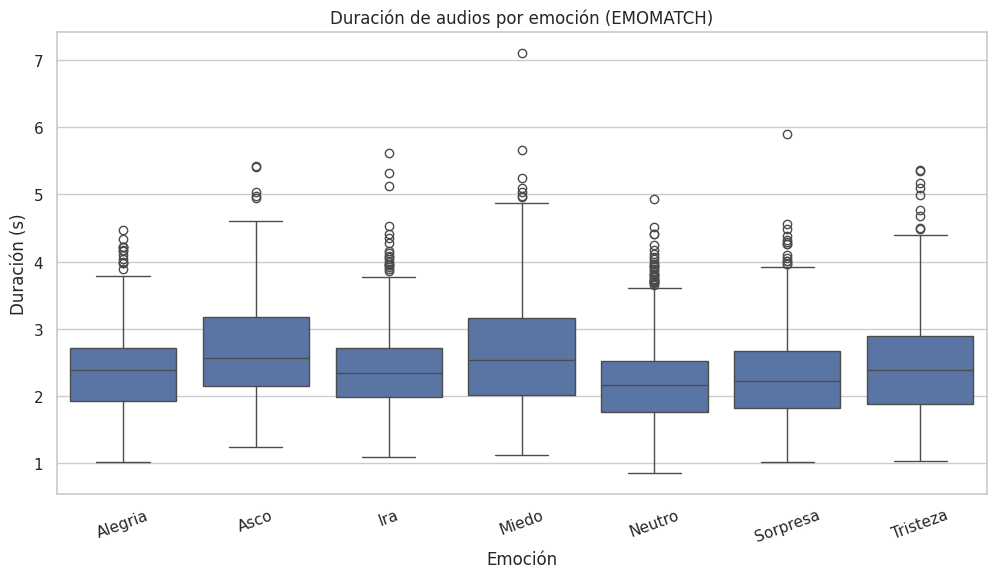

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.boxplot(data=df_emo, x="emotion", y="duration_sec")
plt.title("Duración de audios por emoción (EMOMATCH)")
plt.xlabel("Emoción")
plt.ylabel("Duración (s)")
plt.xticks(rotation=20)
plt.show()


### **Duración de los audios en EMOMATCH**

Se calcularon las duraciones individuales de los **2.005 audios** del corpus EMOMATCH.  
Los valores globales obtenidos fueron:

- **Duración media:** ~ **2.43 s**  
- **Duración mínima:** ~ **0.86 s**  
- **Duración máxima:** ~ **7.10 s**

A continuación se representan las distribuciones de duración por emoción mediante un boxplot:

📌 **Observaciones principales del gráfico:**

- Todas las emociones presentan duraciones muy similares (entre ~2 y ~3 segundos de media).  
- Aparecen algunos **outliers largos**: sobre todo en *Miedo*, *Asco* y *Sorpresa*, donde ciertas locuciones superan los **5–7 segundos**.  
- La emoción **Neutro** tiende a tener duraciones ligeramente más cortas, con menos variabilidad.  
- *Tristeza* y *Miedo* muestran la mayor dispersión en la duración, lo que puede reflejar diferencias interpretativas entre hablantes.


# ***Resumen Recolección y Preparación de Datos EMOMATCH***
En conjunto, la duración del corpus EMOMATCH es **consistente y uniforme**, lo que facilita posteriores procesos de extracción de características y entrenamiento del modelo.


---

# ***ANÁLISIS EXPLORATORIO DE DATOS***

Empezaremos primero por EMOMATCH y posteriormente con RAVDESS

# - EMOMATCH (EDA reducido)
Será un EDA reducido puesto que solo se usará para validar el modelo

# **Pitch básico por emoción (PYIN)**
### Continuamos con el análisis acústico: estimación del Pitch (F0)

Tras analizar la distribución de duraciones en EMOMATCH, avanzamos ahora hacia un componente clave del análisis prosódico: la **estimación del Pitch (F0)**.

El Pitch es uno de los indicadores más sensibles a los cambios emocionales en la voz, por lo que examinar su comportamiento por emoción nos permitirá entender mejor las diferencias expresivas presentes en este corpus.

Para ello utilizaremos **PYIN**, el algoritmo de estimación de frecuencia fundamental incluido en `librosa`. PYIN es computacionalmente más costoso, pero ofrece una estimación robusta incluso en señales complejas.  

Como el cálculo frame a frame de F0 con PYIN sobre todos los audios de EMOMATCH es costoso, aquí usamos una **versión rápida de estimación**: para cada emoción se selecciona aleatoriamente un número limitado de archivos y se calcula el **pitch medio** por archivo (F0 medio en Hz) usando `librosa.yin`.

Esta estrategia no pretende ser un análisis exhaustivo, pero sí ofrece una **aproximación razonable** a cómo se distribuye el pitch por emoción en el corpus EMOMATCH sin tiempos de cómputo excesivos.



In [ ]:
import librosa, numpy as np, pandas as pd, random
import seaborn as sns, matplotlib.pyplot as plt

def estimate_f0_fast(paths, sr_target=None, max_files=10):
    """
    Versión rápida de cálculo del pitch medio por archivo.
    - paths: lista de rutas de audio
    - sr_target: frecuencia de muestreo objetivo (None = original)
    - max_files: nº máximo de audios muestreados por emoción
    Devuelve un array con el F0 medio (Hz) de cada archivo seleccionado.
    """
    vals = []

    # Submuestreamos si hay muchos archivos
    sample = paths if len(paths) <= max_files else random.sample(paths, max_files)

    for p in sample:
        y, sr = librosa.load(p, sr=sr_target)

        try:
            f0 = librosa.yin(
                y,
                fmin=librosa.note_to_hz('C2'),
                fmax=librosa.note_to_hz('C7')
            )
            f0 = f0[~np.isnan(f0)]
            if f0.size:
                vals.append(np.mean(f0))
        except Exception as e:
            # Si algo falla con un archivo, lo saltamos
            print("Error con:", p, "->", e)
            continue

    return np.array(vals)

# ---------------------------------------------------------
# Cálculo de F0 medio (estimación rápida) por emoción EN EMOMATCH
# ---------------------------------------------------------

f0_by_emo = []

for emo in sorted(df_emo["emotion"].unique()):
    paths = df_emo.loc[df_emo["emotion"] == emo, "filepath"].tolist()
    f0_vals = estimate_f0_fast(paths, sr_target=None, max_files=10)  # más rápido que PYIN frame a frame
    for v in f0_vals:
        f0_by_emo.append({"emotion": emo, "f0_mean_hz": v})

f0_df = pd.DataFrame(f0_by_emo)

print("Muestras de pitch por emoción (estimación rápida):")
display(
    f0_df.groupby("emotion")["f0_mean_hz"].describe()[["mean", "std", "min", "max"]]
)



Muestras de pitch por emoción (estimación rápida):

mean         std         min         max
emotion                                                 
Alegria   311.528965   94.341666  214.491382  493.423640
Asco      440.090544   69.391413  340.867322  561.397385
Ira       351.612745  110.650212  193.609387  502.378205
Miedo     405.623275   67.752458  249.246816  500.723703
Neutro    295.614237   90.426981  189.628397  433.139746
Sorpresa  326.045424  125.847068  207.341914  600.857117
Tristeza  323.667911   78.565764  241.615140  468.133765

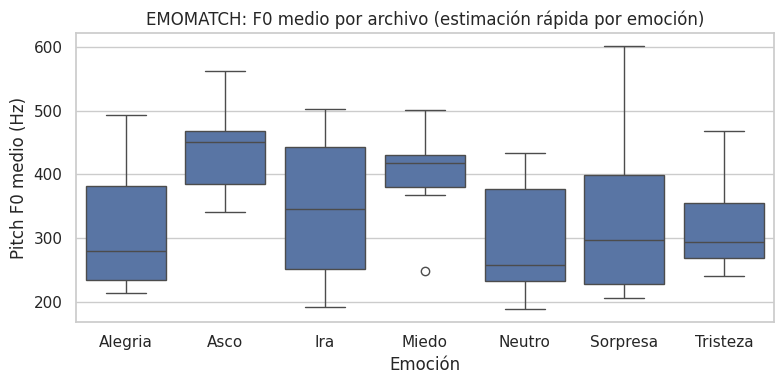

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(
    data=f0_df,
    x="emotion",
    y="f0_mean_hz",
    order=sorted(f0_df["emotion"].unique())
)
plt.title("EMOMATCH: F0 medio por archivo (estimación rápida por emoción)")
plt.xlabel("Emoción")
plt.ylabel("Pitch F0 medio (Hz)")
plt.tight_layout()
plt.show()


### Análisis del Pitch (F0) por emoción en EMOMATCH — Interpretación

Tras aplicar la estimación rápida de F0 con PYIN (muestreo parcial por emoción), se observan diferencias claras y coherentes con la literatura entre emociones discretas en español. Los valores corresponden al **F0 medio por archivo**, tomados de 10 muestras aleatorias por emoción.

#### Tendencias principales del Pitch

1. **Asco (≈440 Hz)** y **Miedo (≈405 Hz)** presentan los F0 medios más altos.  
   Esto coincide con que ambas emociones suelen expresarse con **tensión laringea elevada**, vocalizaciones más “apretadas” y una mayor activación fisiológica.

2. **Ira (≈351 Hz)** muestra un F0 intermedio-alto.  
   La ira en español tiende a presentar un tono más elevado y variabilidad grande, lo cual se refleja en su desviación estándar.

3. **Alegría (≈311 Hz)** aparece con un F0 moderadamente alto.  
   Es coherente con un estado activado pero menos tenso que miedo o asco.

4. **Neutro (≈295 Hz)** es el valor más bajo, funcionando como línea base del corpus.  
   Refuerza que EMOMATCH está bien estructurado en términos expresivos.

5. **Tristeza (≈323 Hz)** está por encima de neutro, pero con variabilidad baja.  
   En español, la tristeza puede producir un tono algo más alto pero más estable y apagado.

6. **Sorpresa (≈326 Hz)** presenta una gran variabilidad (std ≈125), reflejando que la expresión de sorpresa puede oscilar entre registros muy altos (gritos) y medios (susurros o exclamaciones moderadas).

#### Observaciones complementarias
- Las emociones **de alta activación** (asco, miedo, ira, alegría) tienden a agruparse en la zona alta del Pitch.
- Las emociones **de activación baja** (neutro, tristeza) se agrupan en la zona baja–media.
- El patrón general confirma que EMOMATCH es un corpus emocional bien comportado en términos prosódicos.

#### Conclusión
Las diferencias de F0 entre emociones en EMOMATCH son consistentes, amplias y expresivamente sólidas.  
Esto confirma que:

- **EMOMATCH puede utilizarse con confianza para validar generalización del modelo entrenado en RAVDESS**.  
- **F0 es un rasgo relevante para distinguir emociones de activación alta vs baja**, incluso en voces españolas.

Este análisis servirá posteriormente para comparar patrones cross-lingüísticos (inglés → español) y observar qué dimensiones prosódicas se mantienen o se transforman entre corpus.


# **Clasificación automática de género en EMOMATCH**

En el caso de EMOMATCH, la inferencia de género a partir de un umbral fijo de pitch (F0) resultó poco fiable:  
debido a la interpretación emocional de los actores (especialmente en emociones de alta activación como ira, miedo o sorpresa), muchas voces masculinas presentan frecuencias fundamentales muy elevadas. Esto hacía que un criterio simple del tipo “F0 medio > 180 Hz → female” clasificara prácticamente todos los audios como femeninos.

Para disponer de una estimación más robusta y profesional, se empleó la librería **inaSpeechSegmenter**, que incorpora un modelo preentrenado de segmentación y clasificación de audio capaz de distinguir tramos de habla masculina y femenina, además de otras categorías (música, ruido, etc.). Para cada archivo de EMOMATCH:

1. Se segmenta el audio en tramos etiquetados (`male`, `female`, `music`, `noise`, …).
2. Se calcula la **duración total de habla masculina** y de **habla femenina**.
3. Se asigna como **género automático** (`gender_auto`) aquel con mayor duración acumulada.  
   Si el tiempo de habla detectada es muy bajo, el archivo se etiqueta como `unknown`.

Este procedimiento permite aprovechar un modelo acústico especializado y evita depender únicamente del pitch, que es muy sensible a la variabilidad emocional. A partir de esta nueva variable `gender_auto` se describen:

- La **distribución global de audios por género** (proporción de voces masculinas y femeninas en EMOMATCH).
- La **combinación emoción × género**, que permite comprobar si existe algún sesgo notable (por ejemplo, emociones con predominio de voces masculinas o femeninas).

Esta clasificación automática de género servirá como referencia más fiable para los análisis posteriores y, en caso necesario, podría combinarse con información adicional (por ejemplo, metadatos originales o revisión manual de una muestra) para validar la calidad de la detección.



In [ ]:
# ============================================
# Clasificación automática de género con inaSpeechSegmenter
# ============================================

!pip install -q inaSpeechSegmenter ffmpeg-python

from inaSpeechSegmenter import Segmenter
from tqdm import tqdm
import pandas as pd
import numpy as np


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.3/363.3 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.5/22.5 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.7/895.7 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.2/577.2 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3

In [ ]:
# Cargamos el segmentador preentrenado
# (detecta speech y lo etiqueta como male / female, además de music, noise, etc.)

seg = Segmenter()  # tarda un poquito la primera vez (carga los modelos en memoria)
print("Segmentador de género cargado.")


3244808/3244808 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6040200/6040200 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Segmentador de género cargado.

In [ ]:

def predict_gender_inaspeech(path, min_speech_sec=0.5):
    """
    Usa inaSpeechSegmenter para inferir el género dominante en un audio.
    Devuelve: 'male', 'female' o 'unknown'.
    """
    try:
        segments = seg(path)  # lista de tuplas: (label, start, end)
        male_dur = 0.0
        female_dur = 0.0

        for label, start, end in segments:
            dur = float(end - start)
            if label == 'male':
                male_dur += dur
            elif label == 'female':
                female_dur += dur

        total_speech = male_dur + female_dur
        if total_speech < min_speech_sec:
            return "unknown"

        return 'male' if male_dur >= female_dur else 'female'

    except Exception as e:
        print("Error con:", path, "->", e)
        return "error"


In [ ]:
# Aplicamos la predicción de género a cada archivo de EMOMATCH
tqdm.pandas(desc="Inferiendo género (inaSpeechSegmenter)")
df_emo["gender_auto"] = df_emo["filepath"].progress_apply(predict_gender_inaspeech)

df_emo["gender_auto"].value_counts(dropna=False)


Inferiendo género (inaSpeechSegmenter):   0%|          | 0/2005 [00:00<?, ?it/s]

3/3 - 1s - 360ms/step
3/3 - 3s - 880ms/step


Inferiendo género (inaSpeechSegmenter):   0%|          | 2/2005 [00:06<1:42:05,  3.06s/it]

6/6 - 0s - 82ms/step
6/6 - 3s - 566ms/step


Inferiendo género (inaSpeechSegmenter):   0%|          | 3/2005 [00:12<2:23:54,  4.31s/it]

5/5 - 1s - 182ms/step
5/5 - 2s - 341ms/step


Inferiendo género (inaSpeechSegmenter):   0%|          | 4/2005 [00:18<2:53:18,  5.20s/it]

4/4 - 0s - 67ms/step
4/4 - 1s - 327ms/step


Inferiendo género (inaSpeechSegmenter):   0%|          | 5/2005 [00:21<2:28:26,  4.45s/it]

4/4 - 0s - 109ms/step
4/4 - 2s - 457ms/step


Inferiendo género (inaSpeechSegmenter):   0%|          | 6/2005 [00:27<2:37:30,  4.73s/it]

4/4 - 1s - 198ms/step
4/4 - 2s - 444ms/step


Inferiendo género (inaSpeechSegmenter):   0%|          | 7/2005 [00:32<2:40:32,  4.82s/it]

3/3 - 0s - 101ms/step
3/3 - 1s - 319ms/step


Inferiendo género (inaSpeechSegmenter):   0%|          | 8/2005 [00:35<2:26:34,  4.40s/it]

4/4 - 0s - 103ms/step
4/4 - 1s - 348ms/step


Inferiendo género (inaSpeechSegmenter):   0%|          | 9/2005 [00:40<2:33:56,  4.63s/it]

5/5 - 1s - 157ms/step
5/5 - 3s - 533ms/step


Inferiendo género (inaSpeechSegmenter):   0%|          | 10/2005 [00:46<2:45:52,  4.99s/it]

3/3 - 0s - 93ms/step
3/3 - 1s - 168ms/step


Inferiendo género (inaSpeechSegmenter):   1%|          | 11/2005 [00:48<2:16:26,  4.11s/it]

4/4 - 0s - 53ms/step
4/4 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):   1%|          | 12/2005 [00:51<1:59:05,  3.59s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 166ms/step


Inferiendo género (inaSpeechSegmenter):   1%|          | 13/2005 [00:52<1:39:17,  2.99s/it]

6/6 - 0s - 44ms/step
6/6 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):   1%|          | 14/2005 [00:55<1:32:53,  2.80s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):   1%|          | 15/2005 [00:57<1:29:38,  2.70s/it]

5/5 - 0s - 66ms/step
5/5 - 2s - 316ms/step


Inferiendo género (inaSpeechSegmenter):   1%|          | 16/2005 [01:00<1:33:01,  2.81s/it]

4/4 - 0s - 57ms/step
4/4 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):   1%|          | 17/2005 [01:03<1:29:38,  2.71s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):   1%|          | 18/2005 [01:04<1:20:50,  2.44s/it]

3/3 - 0s - 49ms/step
3/3 - 0s - 163ms/step


Inferiendo género (inaSpeechSegmenter):   1%|          | 19/2005 [01:06<1:12:10,  2.18s/it]

2/2 - 0s - 61ms/step
2/2 - 0s - 195ms/step


Inferiendo género (inaSpeechSegmenter):   1%|          | 20/2005 [01:07<1:03:33,  1.92s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 169ms/step


Inferiendo género (inaSpeechSegmenter):   1%|          | 21/2005 [01:09<1:02:10,  1.88s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 219ms/step


Inferiendo género (inaSpeechSegmenter):   1%|          | 22/2005 [01:12<1:08:00,  2.06s/it]

3/3 - 0s - 95ms/step
3/3 - 1s - 393ms/step


Inferiendo género (inaSpeechSegmenter):   1%|          | 23/2005 [01:14<1:15:00,  2.27s/it]

5/5 - 0s - 75ms/step
5/5 - 1s - 206ms/step


Inferiendo género (inaSpeechSegmenter):   1%|          | 24/2005 [01:17<1:18:32,  2.38s/it]

5/5 - 0s - 41ms/step
5/5 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):   1%|          | 25/2005 [01:19<1:14:20,  2.25s/it]

7/7 - 0s - 42ms/step
7/7 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):   1%|▏         | 26/2005 [01:23<1:28:36,  2.69s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):   1%|▏         | 27/2005 [01:24<1:18:51,  2.39s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 283ms/step


Inferiendo género (inaSpeechSegmenter):   1%|▏         | 28/2005 [01:27<1:18:11,  2.37s/it]

3/3 - 0s - 86ms/step
3/3 - 1s - 381ms/step


Inferiendo género (inaSpeechSegmenter):   1%|▏         | 29/2005 [01:29<1:19:58,  2.43s/it]

4/4 - 0s - 70ms/step
4/4 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):   1%|▏         | 30/2005 [01:31<1:14:49,  2.27s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):   2%|▏         | 31/2005 [01:34<1:16:22,  2.32s/it]

3/3 - 0s - 49ms/step
3/3 - 0s - 166ms/step


Inferiendo género (inaSpeechSegmenter):   2%|▏         | 32/2005 [01:35<1:08:46,  2.09s/it]

4/4 - 0s - 53ms/step
4/4 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):   2%|▏         | 33/2005 [01:37<1:05:28,  1.99s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):   2%|▏         | 34/2005 [01:39<1:02:02,  1.89s/it]

6/6 - 0s - 43ms/step
6/6 - 2s - 260ms/step


Inferiendo género (inaSpeechSegmenter):   2%|▏         | 35/2005 [01:42<1:20:03,  2.44s/it]

3/3 - 0s - 81ms/step
3/3 - 1s - 268ms/step


Inferiendo género (inaSpeechSegmenter):   2%|▏         | 36/2005 [01:44<1:16:31,  2.33s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):   2%|▏         | 37/2005 [01:46<1:10:09,  2.14s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):   2%|▏         | 38/2005 [01:48<1:05:58,  2.01s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):   2%|▏         | 39/2005 [01:49<1:01:33,  1.88s/it]

2/2 - 0s - 62ms/step
2/2 - 0s - 207ms/step


Inferiendo género (inaSpeechSegmenter):   2%|▏         | 40/2005 [01:51<56:01,  1.71s/it]  

3/3 - 0s - 54ms/step
3/3 - 1s - 211ms/step


Inferiendo género (inaSpeechSegmenter):   2%|▏         | 41/2005 [01:52<54:40,  1.67s/it]

5/5 - 0s - 48ms/step
5/5 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):   2%|▏         | 42/2005 [01:55<1:01:41,  1.89s/it]

5/5 - 0s - 73ms/step
5/5 - 2s - 343ms/step


Inferiendo género (inaSpeechSegmenter):   2%|▏         | 43/2005 [01:59<1:25:45,  2.62s/it]

7/7 - 0s - 41ms/step
7/7 - 2s - 308ms/step


Inferiendo género (inaSpeechSegmenter):   2%|▏         | 44/2005 [02:02<1:31:50,  2.81s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):   2%|▏         | 45/2005 [02:04<1:19:54,  2.45s/it]

5/5 - 0s - 50ms/step
5/5 - 1s - 192ms/step


Inferiendo género (inaSpeechSegmenter):   2%|▏         | 46/2005 [02:06<1:19:11,  2.43s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 192ms/step


Inferiendo género (inaSpeechSegmenter):   2%|▏         | 47/2005 [02:09<1:18:23,  2.40s/it]

3/3 - 0s - 82ms/step
3/3 - 1s - 298ms/step


Inferiendo género (inaSpeechSegmenter):   2%|▏         | 48/2005 [02:11<1:16:39,  2.35s/it]

2/2 - 0s - 99ms/step
2/2 - 1s - 350ms/step


Inferiendo género (inaSpeechSegmenter):   2%|▏         | 49/2005 [02:13<1:13:45,  2.26s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):   2%|▏         | 50/2005 [02:14<1:08:12,  2.09s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 193ms/step


Inferiendo género (inaSpeechSegmenter):   3%|▎         | 51/2005 [02:17<1:08:02,  2.09s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):   3%|▎         | 52/2005 [02:19<1:09:57,  2.15s/it]

4/4 - 0s - 52ms/step
4/4 - 2s - 409ms/step


Inferiendo género (inaSpeechSegmenter):   3%|▎         | 53/2005 [02:22<1:23:55,  2.58s/it]

5/5 - 0s - 56ms/step
5/5 - 2s - 333ms/step


Inferiendo género (inaSpeechSegmenter):   3%|▎         | 54/2005 [02:26<1:36:28,  2.97s/it]

3/3 - 0s - 59ms/step
3/3 - 1s - 211ms/step


Inferiendo género (inaSpeechSegmenter):   3%|▎         | 55/2005 [02:28<1:24:34,  2.60s/it]

5/5 - 0s - 47ms/step
5/5 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):   3%|▎         | 56/2005 [02:30<1:21:36,  2.51s/it]

5/5 - 0s - 40ms/step
5/5 - 1s - 169ms/step


Inferiendo género (inaSpeechSegmenter):   3%|▎         | 57/2005 [02:32<1:16:01,  2.34s/it]

3/3 - 0s - 45ms/step
3/3 - 0s - 151ms/step


Inferiendo género (inaSpeechSegmenter):   3%|▎         | 58/2005 [02:34<1:06:37,  2.05s/it]

5/5 - 0s - 48ms/step
5/5 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):   3%|▎         | 59/2005 [02:36<1:05:44,  2.03s/it]

5/5 - 0s - 49ms/step
5/5 - 1s - 281ms/step


Inferiendo género (inaSpeechSegmenter):   3%|▎         | 60/2005 [02:39<1:22:33,  2.55s/it]

4/4 - 0s - 73ms/step
4/4 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):   3%|▎         | 61/2005 [02:42<1:24:02,  2.59s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):   3%|▎         | 62/2005 [02:44<1:20:56,  2.50s/it]

4/4 - 0s - 57ms/step
4/4 - 1s - 223ms/step


Inferiendo género (inaSpeechSegmenter):   3%|▎         | 63/2005 [02:47<1:18:55,  2.44s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 168ms/step


Inferiendo género (inaSpeechSegmenter):   3%|▎         | 64/2005 [02:49<1:17:01,  2.38s/it]

6/6 - 0s - 41ms/step
6/6 - 1s - 210ms/step


Inferiendo género (inaSpeechSegmenter):   3%|▎         | 65/2005 [02:51<1:17:51,  2.41s/it]

4/4 - 0s - 89ms/step
4/4 - 1s - 361ms/step


Inferiendo género (inaSpeechSegmenter):   3%|▎         | 66/2005 [02:55<1:25:52,  2.66s/it]

4/4 - 0s - 62ms/step
4/4 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):   3%|▎         | 67/2005 [02:57<1:23:36,  2.59s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 238ms/step


Inferiendo género (inaSpeechSegmenter):   3%|▎         | 68/2005 [03:00<1:26:04,  2.67s/it]

5/5 - 1s - 169ms/step
5/5 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):   3%|▎         | 69/2005 [03:03<1:29:58,  2.79s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):   3%|▎         | 70/2005 [03:05<1:26:53,  2.69s/it]

5/5 - 0s - 83ms/step
5/5 - 2s - 370ms/step


Inferiendo género (inaSpeechSegmenter):   4%|▎         | 71/2005 [03:09<1:35:44,  2.97s/it]

4/4 - 0s - 76ms/step
4/4 - 1s - 192ms/step


Inferiendo género (inaSpeechSegmenter):   4%|▎         | 72/2005 [03:11<1:26:51,  2.70s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 171ms/step


Inferiendo género (inaSpeechSegmenter):   4%|▎         | 73/2005 [03:13<1:17:11,  2.40s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):   4%|▎         | 74/2005 [03:15<1:17:02,  2.39s/it]

4/4 - 0s - 55ms/step
4/4 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):   4%|▎         | 75/2005 [03:17<1:11:16,  2.22s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):   4%|▍         | 76/2005 [03:19<1:04:28,  2.01s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 207ms/step


Inferiendo género (inaSpeechSegmenter):   4%|▍         | 77/2005 [03:21<1:05:36,  2.04s/it]

4/4 - 0s - 76ms/step
4/4 - 1s - 338ms/step


Inferiendo género (inaSpeechSegmenter):   4%|▍         | 78/2005 [03:25<1:24:04,  2.62s/it]

7/7 - 0s - 40ms/step
7/7 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):   4%|▍         | 79/2005 [03:27<1:21:28,  2.54s/it]

4/4 - 0s - 52ms/step
4/4 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):   4%|▍         | 80/2005 [03:29<1:18:50,  2.46s/it]

3/3 - 0s - 53ms/step
3/3 - 1s - 211ms/step


Inferiendo género (inaSpeechSegmenter):   4%|▍         | 81/2005 [03:31<1:10:33,  2.20s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):   4%|▍         | 82/2005 [03:33<1:05:24,  2.04s/it]

3/3 - 0s - 49ms/step
3/3 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):   4%|▍         | 83/2005 [03:34<1:01:20,  1.91s/it]

2/2 - 0s - 82ms/step
2/2 - 1s - 340ms/step


Inferiendo género (inaSpeechSegmenter):   4%|▍         | 84/2005 [03:37<1:07:02,  2.09s/it]

4/4 - 0s - 79ms/step
4/4 - 1s - 235ms/step


Inferiendo género (inaSpeechSegmenter):   4%|▍         | 85/2005 [03:39<1:13:01,  2.28s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 169ms/step


Inferiendo género (inaSpeechSegmenter):   4%|▍         | 86/2005 [03:41<1:07:04,  2.10s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):   4%|▍         | 87/2005 [03:43<1:01:31,  1.92s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 238ms/step


Inferiendo género (inaSpeechSegmenter):   4%|▍         | 88/2005 [03:45<1:07:25,  2.11s/it]

3/3 - 0s - 73ms/step
3/3 - 1s - 302ms/step


Inferiendo género (inaSpeechSegmenter):   4%|▍         | 89/2005 [03:48<1:16:47,  2.40s/it]

5/5 - 1s - 103ms/step
5/5 - 2s - 395ms/step


Inferiendo género (inaSpeechSegmenter):   4%|▍         | 90/2005 [03:53<1:37:03,  3.04s/it]

4/4 - 0s - 85ms/step
4/4 - 1s - 215ms/step


Inferiendo género (inaSpeechSegmenter):   5%|▍         | 91/2005 [03:55<1:34:05,  2.95s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 169ms/step


Inferiendo género (inaSpeechSegmenter):   5%|▍         | 92/2005 [03:58<1:27:19,  2.74s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):   5%|▍         | 93/2005 [04:00<1:23:59,  2.64s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):   5%|▍         | 94/2005 [04:02<1:14:05,  2.33s/it]

2/2 - 0s - 66ms/step
2/2 - 0s - 224ms/step


Inferiendo género (inaSpeechSegmenter):   5%|▍         | 95/2005 [04:03<1:06:28,  2.09s/it]

4/4 - 0s - 55ms/step
4/4 - 1s - 354ms/step


Inferiendo género (inaSpeechSegmenter):   5%|▍         | 96/2005 [04:07<1:21:46,  2.57s/it]

3/3 - 0s - 70ms/step
3/3 - 0s - 160ms/step


Inferiendo género (inaSpeechSegmenter):   5%|▍         | 97/2005 [04:09<1:15:27,  2.37s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):   5%|▍         | 98/2005 [04:11<1:10:43,  2.23s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):   5%|▍         | 99/2005 [04:12<1:05:43,  2.07s/it]

3/3 - 0s - 57ms/step
3/3 - 1s - 211ms/step


Inferiendo género (inaSpeechSegmenter):   5%|▍         | 100/2005 [04:14<1:01:13,  1.93s/it]

3/3 - 0s - 48ms/step
3/3 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):   5%|▌         | 101/2005 [04:16<58:10,  1.83s/it]  

3/3 - 0s - 46ms/step
3/3 - 0s - 158ms/step


Inferiendo género (inaSpeechSegmenter):   5%|▌         | 102/2005 [04:17<54:27,  1.72s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 277ms/step


Inferiendo género (inaSpeechSegmenter):   5%|▌         | 103/2005 [04:19<56:13,  1.77s/it]

4/4 - 0s - 81ms/step
4/4 - 2s - 384ms/step


Inferiendo género (inaSpeechSegmenter):   5%|▌         | 104/2005 [04:22<1:08:25,  2.16s/it]

4/4 - 0s - 40ms/step
4/4 - 1s - 168ms/step


Inferiendo género (inaSpeechSegmenter):   5%|▌         | 105/2005 [04:24<1:10:49,  2.24s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 207ms/step


Inferiendo género (inaSpeechSegmenter):   5%|▌         | 106/2005 [04:27<1:11:21,  2.25s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):   5%|▌         | 107/2005 [04:29<1:07:48,  2.14s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 167ms/step


Inferiendo género (inaSpeechSegmenter):   5%|▌         | 108/2005 [04:30<1:03:17,  2.00s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):   5%|▌         | 109/2005 [04:32<1:00:29,  1.91s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 294ms/step


Inferiendo género (inaSpeechSegmenter):   5%|▌         | 110/2005 [04:35<1:06:54,  2.12s/it]

4/4 - 1s - 174ms/step
4/4 - 2s - 463ms/step


Inferiendo género (inaSpeechSegmenter):   6%|▌         | 111/2005 [04:41<1:44:01,  3.30s/it]

5/5 - 0s - 86ms/step
5/5 - 2s - 404ms/step


Inferiendo género (inaSpeechSegmenter):   6%|▌         | 112/2005 [04:46<1:58:54,  3.77s/it]

4/4 - 0s - 113ms/step
4/4 - 1s - 373ms/step


Inferiendo género (inaSpeechSegmenter):   6%|▌         | 113/2005 [04:49<1:56:01,  3.68s/it]

5/5 - 0s - 71ms/step
5/5 - 2s - 334ms/step


Inferiendo género (inaSpeechSegmenter):   6%|▌         | 114/2005 [04:53<1:59:21,  3.79s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):   6%|▌         | 115/2005 [04:55<1:44:48,  3.33s/it]

6/6 - 0s - 41ms/step
6/6 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):   6%|▌         | 116/2005 [04:58<1:35:52,  3.05s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):   6%|▌         | 117/2005 [04:59<1:21:26,  2.59s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 199ms/step


Inferiendo género (inaSpeechSegmenter):   6%|▌         | 118/2005 [05:01<1:18:17,  2.49s/it]

4/4 - 0s - 42ms/step
4/4 - 1s - 277ms/step


Inferiendo género (inaSpeechSegmenter):   6%|▌         | 119/2005 [05:04<1:16:38,  2.44s/it]

3/3 - 0s - 80ms/step
3/3 - 1s - 346ms/step


Inferiendo género (inaSpeechSegmenter):   6%|▌         | 120/2005 [05:06<1:18:58,  2.51s/it]

3/3 - 0s - 43ms/step
3/3 - 0s - 162ms/step


Inferiendo género (inaSpeechSegmenter):   6%|▌         | 121/2005 [05:08<1:10:56,  2.26s/it]

5/5 - 0s - 41ms/step
5/5 - 1s - 165ms/step


Inferiendo género (inaSpeechSegmenter):   6%|▌         | 122/2005 [05:10<1:11:02,  2.26s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):   6%|▌         | 123/2005 [05:13<1:12:01,  2.30s/it]

4/4 - 0s - 53ms/step
4/4 - 1s - 178ms/step


Inferiendo género (inaSpeechSegmenter):   6%|▌         | 124/2005 [05:15<1:06:51,  2.13s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):   6%|▌         | 125/2005 [05:16<1:02:31,  2.00s/it]

4/4 - 0s - 42ms/step
4/4 - 1s - 303ms/step


Inferiendo género (inaSpeechSegmenter):   6%|▋         | 126/2005 [05:19<1:05:55,  2.11s/it]

4/4 - 0s - 70ms/step
4/4 - 1s - 302ms/step


Inferiendo género (inaSpeechSegmenter):   6%|▋         | 127/2005 [05:21<1:11:54,  2.30s/it]

2/2 - 0s - 64ms/step
2/2 - 0s - 210ms/step


Inferiendo género (inaSpeechSegmenter):   6%|▋         | 128/2005 [05:23<1:05:30,  2.09s/it]

2/2 - 0s - 56ms/step
2/2 - 0s - 176ms/step


Inferiendo género (inaSpeechSegmenter):   6%|▋         | 129/2005 [05:24<1:00:03,  1.92s/it]

4/4 - 0s - 54ms/step
4/4 - 1s - 208ms/step


Inferiendo género (inaSpeechSegmenter):   6%|▋         | 130/2005 [05:26<1:00:07,  1.92s/it]

7/7 - 0s - 42ms/step
7/7 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):   7%|▋         | 131/2005 [05:30<1:16:29,  2.45s/it]

5/5 - 0s - 41ms/step
5/5 - 1s - 211ms/step


Inferiendo género (inaSpeechSegmenter):   7%|▋         | 132/2005 [05:32<1:16:03,  2.44s/it]

3/3 - 0s - 74ms/step
3/3 - 1s - 305ms/step


Inferiendo género (inaSpeechSegmenter):   7%|▋         | 133/2005 [05:35<1:18:26,  2.51s/it]

5/5 - 0s - 73ms/step
5/5 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):   7%|▋         | 134/2005 [05:38<1:18:51,  2.53s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):   7%|▋         | 135/2005 [05:39<1:10:52,  2.27s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):   7%|▋         | 136/2005 [05:42<1:10:39,  2.27s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):   7%|▋         | 137/2005 [05:43<1:04:32,  2.07s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):   7%|▋         | 138/2005 [05:46<1:07:27,  2.17s/it]

4/4 - 0s - 69ms/step
4/4 - 1s - 312ms/step


Inferiendo género (inaSpeechSegmenter):   7%|▋         | 139/2005 [05:48<1:10:38,  2.27s/it]

4/4 - 0s - 75ms/step
4/4 - 1s - 298ms/step


Inferiendo género (inaSpeechSegmenter):   7%|▋         | 140/2005 [05:51<1:14:52,  2.41s/it]

2/2 - 0s - 56ms/step
2/2 - 0s - 163ms/step


Inferiendo género (inaSpeechSegmenter):   7%|▋         | 141/2005 [05:52<1:03:45,  2.05s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 164ms/step


Inferiendo género (inaSpeechSegmenter):   7%|▋         | 142/2005 [05:54<1:00:05,  1.94s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):   7%|▋         | 143/2005 [05:56<59:33,  1.92s/it]  

3/3 - 0s - 52ms/step
3/3 - 1s - 208ms/step


Inferiendo género (inaSpeechSegmenter):   7%|▋         | 144/2005 [05:57<56:31,  1.82s/it]

3/3 - 0s - 53ms/step
3/3 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):   7%|▋         | 145/2005 [05:59<54:08,  1.75s/it]

2/2 - 0s - 61ms/step
2/2 - 0s - 201ms/step


Inferiendo género (inaSpeechSegmenter):   7%|▋         | 146/2005 [06:00<52:04,  1.68s/it]

7/7 - 0s - 61ms/step
7/7 - 2s - 351ms/step


Inferiendo género (inaSpeechSegmenter):   7%|▋         | 147/2005 [06:04<1:12:30,  2.34s/it]

3/3 - 0s - 74ms/step
3/3 - 1s - 206ms/step


Inferiendo género (inaSpeechSegmenter):   7%|▋         | 148/2005 [06:06<1:10:00,  2.26s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):   7%|▋         | 149/2005 [06:09<1:11:32,  2.31s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):   7%|▋         | 150/2005 [06:11<1:09:03,  2.23s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):   8%|▊         | 151/2005 [06:13<1:10:22,  2.28s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):   8%|▊         | 152/2005 [06:15<1:04:04,  2.07s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 357ms/step


Inferiendo género (inaSpeechSegmenter):   8%|▊         | 153/2005 [06:19<1:20:31,  2.61s/it]

4/4 - 0s - 61ms/step
4/4 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):   8%|▊         | 154/2005 [06:21<1:15:06,  2.43s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):   8%|▊         | 155/2005 [06:22<1:08:14,  2.21s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):   8%|▊         | 156/2005 [06:25<1:08:40,  2.23s/it]

6/6 - 0s - 42ms/step
6/6 - 2s - 296ms/step


Inferiendo género (inaSpeechSegmenter):   8%|▊         | 157/2005 [06:28<1:19:55,  2.60s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):   8%|▊         | 158/2005 [06:30<1:17:12,  2.51s/it]

4/4 - 0s - 77ms/step
4/4 - 1s - 323ms/step


Inferiendo género (inaSpeechSegmenter):   8%|▊         | 159/2005 [06:33<1:19:24,  2.58s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):   8%|▊         | 160/2005 [06:35<1:11:46,  2.33s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 168ms/step


Inferiendo género (inaSpeechSegmenter):   8%|▊         | 161/2005 [06:37<1:05:22,  2.13s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):   8%|▊         | 162/2005 [06:39<1:06:52,  2.18s/it]

3/3 - 0s - 46ms/step
3/3 - 0s - 154ms/step


Inferiendo género (inaSpeechSegmenter):   8%|▊         | 163/2005 [06:40<59:40,  1.94s/it]  

4/4 - 0s - 46ms/step
4/4 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):   8%|▊         | 164/2005 [06:43<1:02:42,  2.04s/it]

3/3 - 0s - 53ms/step
3/3 - 1s - 273ms/step


Inferiendo género (inaSpeechSegmenter):   8%|▊         | 165/2005 [06:45<1:04:58,  2.12s/it]

6/6 - 0s - 73ms/step
6/6 - 2s - 306ms/step


Inferiendo género (inaSpeechSegmenter):   8%|▊         | 166/2005 [06:49<1:25:00,  2.77s/it]

3/3 - 0s - 48ms/step
3/3 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):   8%|▊         | 167/2005 [06:51<1:12:35,  2.37s/it]

3/3 - 0s - 53ms/step
3/3 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):   8%|▊         | 168/2005 [06:52<1:05:31,  2.14s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):   8%|▊         | 169/2005 [06:54<1:02:06,  2.03s/it]

3/3 - 0s - 63ms/step
3/3 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):   8%|▊         | 170/2005 [06:56<58:11,  1.90s/it]  

3/3 - 0s - 45ms/step
3/3 - 0s - 160ms/step


Inferiendo género (inaSpeechSegmenter):   9%|▊         | 171/2005 [06:57<55:10,  1.81s/it]

2/2 - 0s - 62ms/step
2/2 - 0s - 223ms/step


Inferiendo género (inaSpeechSegmenter):   9%|▊         | 172/2005 [06:59<52:19,  1.71s/it]

4/4 - 0s - 76ms/step
4/4 - 1s - 317ms/step


Inferiendo género (inaSpeechSegmenter):   9%|▊         | 173/2005 [07:01<1:00:54,  1.99s/it]

5/5 - 0s - 82ms/step
5/5 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):   9%|▊         | 174/2005 [07:04<1:06:54,  2.19s/it]

3/3 - 0s - 48ms/step
3/3 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):   9%|▊         | 175/2005 [07:05<1:00:15,  1.98s/it]

6/6 - 0s - 41ms/step
6/6 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):   9%|▉         | 176/2005 [07:08<1:04:12,  2.11s/it]

3/3 - 1s - 198ms/step
3/3 - 2s - 679ms/step


Inferiendo género (inaSpeechSegmenter):   9%|▉         | 177/2005 [07:13<1:34:20,  3.10s/it]

4/4 - 2s - 394ms/step
4/4 - 2s - 497ms/step


Inferiendo género (inaSpeechSegmenter):   9%|▉         | 178/2005 [07:20<2:06:18,  4.15s/it]

3/3 - 0s - 87ms/step
3/3 - 1s - 340ms/step


Inferiendo género (inaSpeechSegmenter):   9%|▉         | 179/2005 [07:22<1:52:51,  3.71s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 163ms/step


Inferiendo género (inaSpeechSegmenter):   9%|▉         | 180/2005 [07:24<1:33:44,  3.08s/it]

3/3 - 0s - 56ms/step
3/3 - 1s - 171ms/step


Inferiendo género (inaSpeechSegmenter):   9%|▉         | 181/2005 [07:26<1:19:07,  2.60s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 212ms/step


Inferiendo género (inaSpeechSegmenter):   9%|▉         | 182/2005 [07:28<1:15:51,  2.50s/it]

3/3 - 0s - 45ms/step
3/3 - 0s - 151ms/step


Inferiendo género (inaSpeechSegmenter):   9%|▉         | 183/2005 [07:29<1:05:49,  2.17s/it]

5/5 - 0s - 47ms/step
5/5 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):   9%|▉         | 184/2005 [07:31<1:04:21,  2.12s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 340ms/step


Inferiendo género (inaSpeechSegmenter):   9%|▉         | 185/2005 [07:34<1:07:23,  2.22s/it]

3/3 - 0s - 84ms/step
3/3 - 1s - 390ms/step


Inferiendo género (inaSpeechSegmenter):   9%|▉         | 186/2005 [07:36<1:11:16,  2.35s/it]

2/2 - 0s - 86ms/step
2/2 - 0s - 163ms/step


Inferiendo género (inaSpeechSegmenter):   9%|▉         | 187/2005 [07:38<1:04:05,  2.12s/it]

6/6 - 0s - 45ms/step
6/6 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):   9%|▉         | 188/2005 [07:40<1:05:57,  2.18s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):   9%|▉         | 189/2005 [07:43<1:06:40,  2.20s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 207ms/step


Inferiendo género (inaSpeechSegmenter):   9%|▉         | 190/2005 [07:45<1:07:03,  2.22s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  10%|▉         | 191/2005 [07:47<1:07:21,  2.23s/it]

4/4 - 0s - 67ms/step
4/4 - 1s - 270ms/step


Inferiendo género (inaSpeechSegmenter):  10%|▉         | 192/2005 [07:50<1:11:29,  2.37s/it]

4/4 - 0s - 76ms/step
4/4 - 1s - 268ms/step


Inferiendo género (inaSpeechSegmenter):  10%|▉         | 193/2005 [07:52<1:12:38,  2.41s/it]

3/3 - 0s - 45ms/step
3/3 - 0s - 154ms/step


Inferiendo género (inaSpeechSegmenter):  10%|▉         | 194/2005 [07:54<1:04:50,  2.15s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  10%|▉         | 195/2005 [07:55<1:00:42,  2.01s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 164ms/step


Inferiendo género (inaSpeechSegmenter):  10%|▉         | 196/2005 [07:57<57:09,  1.90s/it]  

5/5 - 0s - 50ms/step
5/5 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):  10%|▉         | 197/2005 [07:59<1:00:52,  2.02s/it]

3/3 - 0s - 45ms/step
3/3 - 0s - 144ms/step


Inferiendo género (inaSpeechSegmenter):  10%|▉         | 198/2005 [08:01<55:10,  1.83s/it]  

3/3 - 0s - 49ms/step
3/3 - 1s - 255ms/step


Inferiendo género (inaSpeechSegmenter):  10%|▉         | 199/2005 [08:03<54:43,  1.82s/it]

3/3 - 0s - 90ms/step
3/3 - 1s - 369ms/step


Inferiendo género (inaSpeechSegmenter):  10%|▉         | 200/2005 [08:05<1:02:24,  2.07s/it]

3/3 - 0s - 78ms/step
3/3 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  10%|█         | 201/2005 [08:07<1:01:55,  2.06s/it]

2/2 - 0s - 52ms/step
2/2 - 0s - 158ms/step


Inferiendo género (inaSpeechSegmenter):  10%|█         | 202/2005 [08:09<54:42,  1.82s/it]  

5/5 - 0s - 44ms/step
5/5 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  10%|█         | 203/2005 [08:11<58:58,  1.96s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  10%|█         | 204/2005 [08:13<1:01:36,  2.05s/it]

4/4 - 0s - 54ms/step
4/4 - 1s - 212ms/step


Inferiendo género (inaSpeechSegmenter):  10%|█         | 205/2005 [08:15<59:44,  1.99s/it]  

3/3 - 0s - 48ms/step
3/3 - 1s - 171ms/step


Inferiendo género (inaSpeechSegmenter):  10%|█         | 206/2005 [08:16<54:55,  1.83s/it]

4/4 - 0s - 80ms/step
4/4 - 1s - 344ms/step


Inferiendo género (inaSpeechSegmenter):  10%|█         | 207/2005 [08:20<1:13:34,  2.46s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  10%|█         | 208/2005 [08:23<1:11:48,  2.40s/it]

6/6 - 0s - 47ms/step
6/6 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  10%|█         | 209/2005 [08:25<1:11:39,  2.39s/it]

3/3 - 0s - 49ms/step
3/3 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):  10%|█         | 210/2005 [08:26<1:03:27,  2.12s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  11%|█         | 211/2005 [08:29<1:05:59,  2.21s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  11%|█         | 212/2005 [08:31<1:07:09,  2.25s/it]

4/4 - 0s - 69ms/step
4/4 - 1s - 310ms/step


Inferiendo género (inaSpeechSegmenter):  11%|█         | 213/2005 [08:34<1:10:52,  2.37s/it]

3/3 - 0s - 69ms/step
3/3 - 0s - 145ms/step


Inferiendo género (inaSpeechSegmenter):  11%|█         | 214/2005 [08:36<1:05:51,  2.21s/it]

2/2 - 0s - 63ms/step
2/2 - 0s - 213ms/step


Inferiendo género (inaSpeechSegmenter):  11%|█         | 215/2005 [08:37<58:25,  1.96s/it]  

4/4 - 0s - 45ms/step
4/4 - 1s - 178ms/step


Inferiendo género (inaSpeechSegmenter):  11%|█         | 216/2005 [08:39<1:01:07,  2.05s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  11%|█         | 217/2005 [08:42<1:04:08,  2.15s/it]

3/3 - 0s - 47ms/step
3/3 - 1s - 169ms/step


Inferiendo género (inaSpeechSegmenter):  11%|█         | 218/2005 [08:43<59:14,  1.99s/it]  

4/4 - 0s - 51ms/step
4/4 - 1s - 256ms/step


Inferiendo género (inaSpeechSegmenter):  11%|█         | 219/2005 [08:46<1:02:28,  2.10s/it]

4/4 - 0s - 75ms/step
4/4 - 1s - 336ms/step


Inferiendo género (inaSpeechSegmenter):  11%|█         | 220/2005 [08:48<1:09:06,  2.32s/it]

3/3 - 0s - 78ms/step
3/3 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  11%|█         | 221/2005 [08:50<1:05:45,  2.21s/it]

3/3 - 0s - 58ms/step
3/3 - 1s - 208ms/step


Inferiendo género (inaSpeechSegmenter):  11%|█         | 222/2005 [08:52<1:00:12,  2.03s/it]

3/3 - 0s - 53ms/step
3/3 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  11%|█         | 223/2005 [08:54<56:10,  1.89s/it]  

3/3 - 0s - 46ms/step
3/3 - 0s - 164ms/step


Inferiendo género (inaSpeechSegmenter):  11%|█         | 224/2005 [08:55<53:15,  1.79s/it]

2/2 - 0s - 60ms/step
2/2 - 0s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  11%|█         | 225/2005 [08:56<48:40,  1.64s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 192ms/step


Inferiendo género (inaSpeechSegmenter):  11%|█▏        | 226/2005 [08:59<54:46,  1.85s/it]

5/5 - 0s - 45ms/step
5/5 - 2s - 345ms/step


Inferiendo género (inaSpeechSegmenter):  11%|█▏        | 227/2005 [09:03<1:12:11,  2.44s/it]

4/4 - 0s - 75ms/step
4/4 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  11%|█▏        | 228/2005 [09:05<1:12:59,  2.46s/it]

7/7 - 0s - 42ms/step
7/7 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  11%|█▏        | 229/2005 [09:08<1:12:35,  2.45s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  11%|█▏        | 230/2005 [09:09<1:04:50,  2.19s/it]

4/4 - 0s - 53ms/step
4/4 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  12%|█▏        | 231/2005 [09:12<1:06:31,  2.25s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  12%|█▏        | 232/2005 [09:13<1:01:14,  2.07s/it]

4/4 - 0s - 73ms/step
4/4 - 1s - 301ms/step


Inferiendo género (inaSpeechSegmenter):  12%|█▏        | 233/2005 [09:16<1:05:47,  2.23s/it]

2/2 - 0s - 90ms/step
2/2 - 1s - 311ms/step


Inferiendo género (inaSpeechSegmenter):  12%|█▏        | 234/2005 [09:18<1:04:54,  2.20s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  12%|█▏        | 235/2005 [09:20<1:01:13,  2.08s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  12%|█▏        | 236/2005 [09:22<59:02,  2.00s/it]  

4/4 - 0s - 43ms/step
4/4 - 1s - 164ms/step


Inferiendo género (inaSpeechSegmenter):  12%|█▏        | 237/2005 [09:23<55:36,  1.89s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  12%|█▏        | 238/2005 [09:25<59:13,  2.01s/it]

7/7 - 0s - 40ms/step
7/7 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  12%|█▏        | 239/2005 [09:28<1:02:34,  2.13s/it]

4/4 - 0s - 61ms/step
4/4 - 1s - 314ms/step


Inferiendo género (inaSpeechSegmenter):  12%|█▏        | 240/2005 [09:30<1:06:32,  2.26s/it]

3/3 - 0s - 88ms/step
3/3 - 1s - 296ms/step


Inferiendo género (inaSpeechSegmenter):  12%|█▏        | 241/2005 [09:33<1:09:50,  2.38s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  12%|█▏        | 242/2005 [09:35<1:09:04,  2.35s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):  12%|█▏        | 243/2005 [09:37<1:02:53,  2.14s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  12%|█▏        | 244/2005 [09:39<1:05:26,  2.23s/it]

8/8 - 0s - 39ms/step
8/8 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):  12%|█▏        | 245/2005 [09:43<1:19:02,  2.69s/it]

4/4 - 0s - 84ms/step
4/4 - 2s - 382ms/step


Inferiendo género (inaSpeechSegmenter):  12%|█▏        | 246/2005 [09:48<1:33:09,  3.18s/it]

5/5 - 0s - 48ms/step
5/5 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  12%|█▏        | 247/2005 [09:50<1:22:46,  2.82s/it]

5/5 - 0s - 41ms/step
5/5 - 1s - 171ms/step


Inferiendo género (inaSpeechSegmenter):  12%|█▏        | 248/2005 [09:52<1:18:53,  2.69s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):  12%|█▏        | 249/2005 [09:54<1:15:46,  2.59s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):  12%|█▏        | 250/2005 [09:57<1:12:43,  2.49s/it]

4/4 - 0s - 76ms/step
4/4 - 1s - 348ms/step


Inferiendo género (inaSpeechSegmenter):  13%|█▎        | 251/2005 [09:59<1:15:24,  2.58s/it]

5/5 - 0s - 76ms/step
5/5 - 1s - 237ms/step


Inferiendo género (inaSpeechSegmenter):  13%|█▎        | 252/2005 [10:02<1:19:47,  2.73s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):  13%|█▎        | 253/2005 [10:05<1:15:43,  2.59s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 168ms/step


Inferiendo género (inaSpeechSegmenter):  13%|█▎        | 254/2005 [10:07<1:13:40,  2.52s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  13%|█▎        | 255/2005 [10:09<1:06:04,  2.27s/it]

5/5 - 0s - 41ms/step
5/5 - 1s - 178ms/step


Inferiendo género (inaSpeechSegmenter):  13%|█▎        | 256/2005 [10:11<1:07:02,  2.30s/it]

3/3 - 0s - 82ms/step
3/3 - 1s - 339ms/step


Inferiendo género (inaSpeechSegmenter):  13%|█▎        | 257/2005 [10:14<1:08:17,  2.34s/it]

5/5 - 0s - 76ms/step
5/5 - 1s - 250ms/step


Inferiendo género (inaSpeechSegmenter):  13%|█▎        | 258/2005 [10:17<1:14:04,  2.54s/it]

8/8 - 0s - 39ms/step
8/8 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  13%|█▎        | 259/2005 [10:20<1:24:05,  2.89s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):  13%|█▎        | 260/2005 [10:23<1:19:35,  2.74s/it]

5/5 - 0s - 48ms/step
5/5 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  13%|█▎        | 261/2005 [10:25<1:13:33,  2.53s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 237ms/step


Inferiendo género (inaSpeechSegmenter):  13%|█▎        | 262/2005 [10:27<1:12:58,  2.51s/it]

5/5 - 0s - 74ms/step
5/5 - 2s - 348ms/step


Inferiendo género (inaSpeechSegmenter):  13%|█▎        | 263/2005 [10:31<1:26:09,  2.97s/it]

3/3 - 0s - 51ms/step


Inferiendo género (inaSpeechSegmenter):  13%|█▎        | 264/2005 [10:32<1:08:13,  2.35s/it]

3/3 - 0s - 48ms/step


Inferiendo género (inaSpeechSegmenter):  13%|█▎        | 265/2005 [10:33<55:31,  1.91s/it]  

4/4 - 0s - 45ms/step
4/4 - 1s - 178ms/step


Inferiendo género (inaSpeechSegmenter):  13%|█▎        | 266/2005 [10:35<53:33,  1.85s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  13%|█▎        | 267/2005 [10:37<54:28,  1.88s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  13%|█▎        | 268/2005 [10:38<51:55,  1.79s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  13%|█▎        | 269/2005 [10:40<52:47,  1.82s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 391ms/step


Inferiendo género (inaSpeechSegmenter):  13%|█▎        | 270/2005 [10:43<58:02,  2.01s/it]

3/3 - 0s - 92ms/step
3/3 - 1s - 356ms/step


Inferiendo género (inaSpeechSegmenter):  14%|█▎        | 271/2005 [10:45<1:02:20,  2.16s/it]

5/5 - 0s - 40ms/step
5/5 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):  14%|█▎        | 272/2005 [10:47<1:04:30,  2.23s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  14%|█▎        | 273/2005 [10:50<1:04:51,  2.25s/it]

6/6 - 0s - 45ms/step
6/6 - 1s - 208ms/step


Inferiendo género (inaSpeechSegmenter):  14%|█▎        | 274/2005 [10:52<1:06:06,  2.29s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 164ms/step


Inferiendo género (inaSpeechSegmenter):  14%|█▎        | 275/2005 [10:54<1:05:36,  2.28s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 275ms/step


Inferiendo género (inaSpeechSegmenter):  14%|█▍        | 276/2005 [10:57<1:08:06,  2.36s/it]

4/4 - 0s - 67ms/step
4/4 - 1s - 324ms/step


Inferiendo género (inaSpeechSegmenter):  14%|█▍        | 277/2005 [11:00<1:11:26,  2.48s/it]

4/4 - 0s - 73ms/step
4/4 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  14%|█▍        | 278/2005 [11:02<1:07:44,  2.35s/it]

3/3 - 0s - 49ms/step
3/3 - 1s - 168ms/step


Inferiendo género (inaSpeechSegmenter):  14%|█▍        | 279/2005 [11:03<59:54,  2.08s/it]  

7/7 - 0s - 41ms/step
7/7 - 1s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  14%|█▍        | 280/2005 [11:06<1:03:19,  2.20s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 212ms/step


Inferiendo género (inaSpeechSegmenter):  14%|█▍        | 281/2005 [11:07<57:53,  2.01s/it]  

3/3 - 0s - 48ms/step
3/3 - 1s - 169ms/step


Inferiendo género (inaSpeechSegmenter):  14%|█▍        | 282/2005 [11:09<54:11,  1.89s/it]

2/2 - 0s - 64ms/step
2/2 - 0s - 217ms/step


Inferiendo género (inaSpeechSegmenter):  14%|█▍        | 283/2005 [11:10<49:24,  1.72s/it]

4/4 - 0s - 62ms/step
4/4 - 1s - 293ms/step


Inferiendo género (inaSpeechSegmenter):  14%|█▍        | 284/2005 [11:13<57:07,  1.99s/it]

4/4 - 0s - 71ms/step
4/4 - 1s - 289ms/step


Inferiendo género (inaSpeechSegmenter):  14%|█▍        | 285/2005 [11:15<1:03:08,  2.20s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 203ms/step


Inferiendo género (inaSpeechSegmenter):  14%|█▍        | 286/2005 [11:17<57:54,  2.02s/it]  

5/5 - 0s - 47ms/step
5/5 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  14%|█▍        | 287/2005 [11:19<57:59,  2.03s/it]

3/3 - 0s - 41ms/step
3/3 - 0s - 162ms/step


Inferiendo género (inaSpeechSegmenter):  14%|█▍        | 288/2005 [11:21<54:08,  1.89s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  14%|█▍        | 289/2005 [11:22<51:32,  1.80s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 192ms/step


Inferiendo género (inaSpeechSegmenter):  14%|█▍        | 290/2005 [11:24<49:07,  1.72s/it]

5/5 - 0s - 47ms/step
5/5 - 1s - 295ms/step


Inferiendo género (inaSpeechSegmenter):  15%|█▍        | 291/2005 [11:28<1:05:56,  2.31s/it]

3/3 - 0s - 81ms/step
3/3 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  15%|█▍        | 292/2005 [11:30<1:03:53,  2.24s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):  15%|█▍        | 293/2005 [11:32<1:04:20,  2.25s/it]

6/6 - 0s - 43ms/step
6/6 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  15%|█▍        | 294/2005 [11:34<1:05:46,  2.31s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  15%|█▍        | 295/2005 [11:36<59:23,  2.08s/it]  

4/4 - 0s - 45ms/step
4/4 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  15%|█▍        | 296/2005 [11:38<1:00:44,  2.13s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 313ms/step


Inferiendo género (inaSpeechSegmenter):  15%|█▍        | 297/2005 [11:41<1:02:50,  2.21s/it]

3/3 - 0s - 72ms/step
3/3 - 1s - 304ms/step


Inferiendo género (inaSpeechSegmenter):  15%|█▍        | 298/2005 [11:43<1:06:59,  2.35s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  15%|█▍        | 299/2005 [11:45<1:06:19,  2.33s/it]

3/3 - 0s - 42ms/step
3/3 - 0s - 149ms/step


Inferiendo género (inaSpeechSegmenter):  15%|█▍        | 300/2005 [11:47<58:07,  2.05s/it]  

4/4 - 0s - 47ms/step
4/4 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  15%|█▌        | 301/2005 [11:49<1:01:12,  2.16s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 192ms/step


Inferiendo género (inaSpeechSegmenter):  15%|█▌        | 302/2005 [11:51<56:13,  1.98s/it]  

5/5 - 0s - 53ms/step
5/5 - 1s - 208ms/step


Inferiendo género (inaSpeechSegmenter):  15%|█▌        | 303/2005 [11:53<59:20,  2.09s/it]

3/3 - 0s - 76ms/step
3/3 - 1s - 287ms/step


Inferiendo género (inaSpeechSegmenter):  15%|█▌        | 304/2005 [11:55<1:00:21,  2.13s/it]

3/3 - 0s - 90ms/step
3/3 - 1s - 339ms/step


Inferiendo género (inaSpeechSegmenter):  15%|█▌        | 305/2005 [11:58<1:03:28,  2.24s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  15%|█▌        | 306/2005 [11:59<57:34,  2.03s/it]  

3/3 - 0s - 59ms/step
3/3 - 1s - 209ms/step


Inferiendo género (inaSpeechSegmenter):  15%|█▌        | 307/2005 [12:01<54:58,  1.94s/it]

2/2 - 0s - 60ms/step
2/2 - 0s - 202ms/step


Inferiendo género (inaSpeechSegmenter):  15%|█▌        | 308/2005 [12:03<51:29,  1.82s/it]

2/2 - 0s - 51ms/step
2/2 - 0s - 147ms/step


Inferiendo género (inaSpeechSegmenter):  15%|█▌        | 309/2005 [12:04<45:59,  1.63s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  15%|█▌        | 310/2005 [12:06<51:32,  1.82s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  16%|█▌        | 311/2005 [12:09<56:12,  1.99s/it]

3/3 - 0s - 73ms/step
3/3 - 1s - 304ms/step


Inferiendo género (inaSpeechSegmenter):  16%|█▌        | 312/2005 [12:11<59:03,  2.09s/it]

3/3 - 0s - 91ms/step
3/3 - 1s - 288ms/step


Inferiendo género (inaSpeechSegmenter):  16%|█▌        | 313/2005 [12:13<1:00:14,  2.14s/it]

2/2 - 0s - 59ms/step
2/2 - 0s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  16%|█▌        | 314/2005 [12:14<53:03,  1.88s/it]  

2/2 - 0s - 64ms/step
2/2 - 0s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  16%|█▌        | 315/2005 [12:16<50:09,  1.78s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  16%|█▌        | 316/2005 [12:18<48:25,  1.72s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  16%|█▌        | 317/2005 [12:19<47:09,  1.68s/it]

4/4 - 0s - 42ms/step
4/4 - 1s - 166ms/step


Inferiendo género (inaSpeechSegmenter):  16%|█▌        | 318/2005 [12:21<51:50,  1.84s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  16%|█▌        | 319/2005 [12:24<55:53,  1.99s/it]

5/5 - 0s - 74ms/step
5/5 - 2s - 322ms/step


Inferiendo género (inaSpeechSegmenter):  16%|█▌        | 320/2005 [12:27<1:05:25,  2.33s/it]

3/3 - 0s - 42ms/step
3/3 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  16%|█▌        | 321/2005 [12:29<1:00:17,  2.15s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  16%|█▌        | 322/2005 [12:31<1:02:31,  2.23s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  16%|█▌        | 323/2005 [12:33<1:02:37,  2.23s/it]

6/6 - 0s - 49ms/step
6/6 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  16%|█▌        | 324/2005 [12:35<1:03:10,  2.25s/it]

3/3 - 0s - 56ms/step
3/3 - 1s - 207ms/step


Inferiendo género (inaSpeechSegmenter):  16%|█▌        | 325/2005 [12:37<57:41,  2.06s/it]  

4/4 - 0s - 76ms/step
4/4 - 1s - 333ms/step


Inferiendo género (inaSpeechSegmenter):  16%|█▋        | 326/2005 [12:41<1:13:35,  2.63s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  16%|█▋        | 327/2005 [12:43<1:10:18,  2.51s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  16%|█▋        | 328/2005 [12:45<1:04:44,  2.32s/it]

3/3 - 0s - 61ms/step
3/3 - 1s - 169ms/step


Inferiendo género (inaSpeechSegmenter):  16%|█▋        | 329/2005 [12:47<58:47,  2.10s/it]  

2/2 - 0s - 63ms/step
2/2 - 0s - 207ms/step


Inferiendo género (inaSpeechSegmenter):  16%|█▋        | 330/2005 [12:48<53:59,  1.93s/it]

4/4 - 0s - 42ms/step
4/4 - 1s - 161ms/step


Inferiendo género (inaSpeechSegmenter):  17%|█▋        | 331/2005 [12:50<51:26,  1.84s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 283ms/step


Inferiendo género (inaSpeechSegmenter):  17%|█▋        | 332/2005 [12:52<55:26,  1.99s/it]

6/6 - 0s - 67ms/step
6/6 - 2s - 283ms/step


Inferiendo género (inaSpeechSegmenter):  17%|█▋        | 333/2005 [12:57<1:15:10,  2.70s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 168ms/step


Inferiendo género (inaSpeechSegmenter):  17%|█▋        | 334/2005 [12:58<1:07:13,  2.41s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 168ms/step


Inferiendo género (inaSpeechSegmenter):  17%|█▋        | 335/2005 [13:01<1:05:42,  2.36s/it]

3/3 - 0s - 49ms/step
3/3 - 1s - 168ms/step


Inferiendo género (inaSpeechSegmenter):  17%|█▋        | 336/2005 [13:02<59:22,  2.13s/it]  

5/5 - 0s - 44ms/step
5/5 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  17%|█▋        | 337/2005 [13:05<1:01:29,  2.21s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 339ms/step


Inferiendo género (inaSpeechSegmenter):  17%|█▋        | 338/2005 [13:08<1:15:10,  2.71s/it]

6/6 - 0s - 47ms/step
6/6 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  17%|█▋        | 339/2005 [13:11<1:13:17,  2.64s/it]

3/3 - 0s - 53ms/step
3/3 - 1s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  17%|█▋        | 340/2005 [13:12<1:03:48,  2.30s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  17%|█▋        | 341/2005 [13:14<58:41,  2.12s/it]  

4/4 - 0s - 45ms/step
4/4 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  17%|█▋        | 342/2005 [13:16<59:49,  2.16s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 164ms/step


Inferiendo género (inaSpeechSegmenter):  17%|█▋        | 343/2005 [13:18<55:24,  2.00s/it]

2/2 - 0s - 64ms/step
2/2 - 1s - 276ms/step


Inferiendo género (inaSpeechSegmenter):  17%|█▋        | 344/2005 [13:20<51:45,  1.87s/it]

4/4 - 0s - 84ms/step
4/4 - 1s - 365ms/step


Inferiendo género (inaSpeechSegmenter):  17%|█▋        | 345/2005 [13:23<1:01:02,  2.21s/it]

6/6 - 0s - 73ms/step
6/6 - 1s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  17%|█▋        | 346/2005 [13:25<1:06:26,  2.40s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  17%|█▋        | 347/2005 [13:27<1:01:31,  2.23s/it]

6/6 - 0s - 45ms/step
6/6 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  17%|█▋        | 348/2005 [13:30<1:02:52,  2.28s/it]

3/3 - 0s - 54ms/step
3/3 - 0s - 153ms/step


Inferiendo género (inaSpeechSegmenter):  17%|█▋        | 349/2005 [13:31<57:13,  2.07s/it]  

3/3 - 0s - 45ms/step
3/3 - 0s - 157ms/step


Inferiendo género (inaSpeechSegmenter):  17%|█▋        | 350/2005 [13:33<53:08,  1.93s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 261ms/step


Inferiendo género (inaSpeechSegmenter):  18%|█▊        | 351/2005 [13:35<54:50,  1.99s/it]

5/5 - 0s - 74ms/step
5/5 - 2s - 346ms/step


Inferiendo género (inaSpeechSegmenter):  18%|█▊        | 352/2005 [13:38<1:05:25,  2.38s/it]

4/4 - 0s - 69ms/step
4/4 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  18%|█▊        | 353/2005 [13:41<1:06:42,  2.42s/it]

6/6 - 0s - 44ms/step
6/6 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  18%|█▊        | 354/2005 [13:43<1:05:40,  2.39s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  18%|█▊        | 355/2005 [13:45<58:57,  2.14s/it]  

4/4 - 0s - 47ms/step
4/4 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):  18%|█▊        | 356/2005 [13:47<57:20,  2.09s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):  18%|█▊        | 357/2005 [13:49<58:44,  2.14s/it]

3/3 - 0s - 81ms/step
3/3 - 1s - 321ms/step


Inferiendo género (inaSpeechSegmenter):  18%|█▊        | 358/2005 [13:51<1:00:56,  2.22s/it]

2/2 - 0s - 98ms/step
2/2 - 1s - 348ms/step


Inferiendo género (inaSpeechSegmenter):  18%|█▊        | 359/2005 [13:54<1:05:42,  2.40s/it]

5/5 - 1s - 109ms/step
5/5 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  18%|█▊        | 360/2005 [13:57<1:09:14,  2.53s/it]

3/3 - 0s - 49ms/step
3/3 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  18%|█▊        | 361/2005 [13:58<1:01:14,  2.24s/it]

6/6 - 0s - 48ms/step
6/6 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):  18%|█▊        | 362/2005 [14:01<1:02:46,  2.29s/it]

3/3 - 0s - 49ms/step
3/3 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  18%|█▊        | 363/2005 [14:02<56:38,  2.07s/it]  

3/3 - 0s - 51ms/step
3/3 - 1s - 253ms/step


Inferiendo género (inaSpeechSegmenter):  18%|█▊        | 364/2005 [14:05<58:32,  2.14s/it]

4/4 - 0s - 81ms/step
4/4 - 1s - 336ms/step


Inferiendo género (inaSpeechSegmenter):  18%|█▊        | 365/2005 [14:08<1:04:47,  2.37s/it]

6/6 - 0s - 44ms/step
6/6 - 1s - 199ms/step


Inferiendo género (inaSpeechSegmenter):  18%|█▊        | 366/2005 [14:10<1:05:04,  2.38s/it]

3/3 - 0s - 56ms/step
3/3 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):  18%|█▊        | 367/2005 [14:12<58:37,  2.15s/it]  

4/4 - 0s - 48ms/step
4/4 - 1s - 202ms/step


Inferiendo género (inaSpeechSegmenter):  18%|█▊        | 368/2005 [14:14<1:00:37,  2.22s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 217ms/step


Inferiendo género (inaSpeechSegmenter):  18%|█▊        | 369/2005 [14:16<58:35,  2.15s/it]  

4/4 - 0s - 50ms/step
4/4 - 1s - 203ms/step


Inferiendo género (inaSpeechSegmenter):  18%|█▊        | 370/2005 [14:19<1:01:07,  2.24s/it]

3/3 - 0s - 73ms/step
3/3 - 1s - 312ms/step


Inferiendo género (inaSpeechSegmenter):  19%|█▊        | 371/2005 [14:21<1:02:46,  2.31s/it]

4/4 - 0s - 85ms/step
4/4 - 1s - 211ms/step


Inferiendo género (inaSpeechSegmenter):  19%|█▊        | 372/2005 [14:23<1:02:39,  2.30s/it]

5/5 - 0s - 41ms/step
5/5 - 1s - 169ms/step


Inferiendo género (inaSpeechSegmenter):  19%|█▊        | 373/2005 [14:25<58:48,  2.16s/it]  

5/5 - 0s - 41ms/step
5/5 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  19%|█▊        | 374/2005 [14:28<1:00:57,  2.24s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):  19%|█▊        | 375/2005 [14:29<58:19,  2.15s/it]  

7/7 - 0s - 41ms/step
7/7 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  19%|█▉        | 376/2005 [14:32<1:00:44,  2.24s/it]

5/5 - 0s - 62ms/step
5/5 - 2s - 346ms/step


Inferiendo género (inaSpeechSegmenter):  19%|█▉        | 377/2005 [14:35<1:07:32,  2.49s/it]

7/7 - 1s - 72ms/step
7/7 - 2s - 218ms/step


Inferiendo género (inaSpeechSegmenter):  19%|█▉        | 378/2005 [14:38<1:14:15,  2.74s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 192ms/step


Inferiendo género (inaSpeechSegmenter):  19%|█▉        | 379/2005 [14:41<1:10:13,  2.59s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  19%|█▉        | 380/2005 [14:43<1:08:41,  2.54s/it]

7/7 - 0s - 44ms/step
7/7 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  19%|█▉        | 381/2005 [14:45<1:07:40,  2.50s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  19%|█▉        | 382/2005 [14:47<1:00:06,  2.22s/it]

3/3 - 0s - 88ms/step
3/3 - 1s - 356ms/step


Inferiendo género (inaSpeechSegmenter):  19%|█▉        | 383/2005 [14:49<1:01:43,  2.28s/it]

3/3 - 0s - 72ms/step
3/3 - 1s - 270ms/step


Inferiendo género (inaSpeechSegmenter):  19%|█▉        | 384/2005 [14:52<1:04:45,  2.40s/it]

3/3 - 0s - 48ms/step
3/3 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  19%|█▉        | 385/2005 [14:54<57:20,  2.12s/it]  

4/4 - 0s - 49ms/step
4/4 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  19%|█▉        | 386/2005 [14:56<59:19,  2.20s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 202ms/step


Inferiendo género (inaSpeechSegmenter):  19%|█▉        | 387/2005 [14:58<56:12,  2.08s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 202ms/step


Inferiendo género (inaSpeechSegmenter):  19%|█▉        | 388/2005 [14:59<52:03,  1.93s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 204ms/step


Inferiendo género (inaSpeechSegmenter):  19%|█▉        | 389/2005 [15:02<54:46,  2.03s/it]

4/4 - 0s - 72ms/step
4/4 - 1s - 321ms/step


Inferiendo género (inaSpeechSegmenter):  19%|█▉        | 390/2005 [15:04<1:00:17,  2.24s/it]

6/6 - 0s - 77ms/step
6/6 - 1s - 238ms/step


Inferiendo género (inaSpeechSegmenter):  20%|█▉        | 391/2005 [15:07<1:07:25,  2.51s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  20%|█▉        | 392/2005 [15:10<1:05:33,  2.44s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  20%|█▉        | 393/2005 [15:12<1:03:58,  2.38s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  20%|█▉        | 394/2005 [15:14<1:02:58,  2.35s/it]

3/3 - 0s - 45ms/step
3/3 - 0s - 151ms/step


Inferiendo género (inaSpeechSegmenter):  20%|█▉        | 395/2005 [15:16<56:55,  2.12s/it]  

3/3 - 0s - 45ms/step
3/3 - 1s - 289ms/step


Inferiendo género (inaSpeechSegmenter):  20%|█▉        | 396/2005 [15:18<59:56,  2.24s/it]

3/3 - 0s - 81ms/step
3/3 - 1s - 308ms/step


Inferiendo género (inaSpeechSegmenter):  20%|█▉        | 397/2005 [15:21<1:00:53,  2.27s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  20%|█▉        | 398/2005 [15:23<1:00:54,  2.27s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 208ms/step


Inferiendo género (inaSpeechSegmenter):  20%|█▉        | 399/2005 [15:25<55:18,  2.07s/it]  

4/4 - 0s - 42ms/step
4/4 - 1s - 159ms/step


Inferiendo género (inaSpeechSegmenter):  20%|█▉        | 400/2005 [15:26<51:37,  1.93s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  20%|██        | 401/2005 [15:28<50:15,  1.88s/it]

3/3 - 0s - 50ms/step
3/3 - 0s - 152ms/step


Inferiendo género (inaSpeechSegmenter):  20%|██        | 402/2005 [15:29<47:51,  1.79s/it]

2/2 - 0s - 65ms/step
2/2 - 0s - 224ms/step


Inferiendo género (inaSpeechSegmenter):  20%|██        | 403/2005 [15:31<46:25,  1.74s/it]

3/3 - 0s - 75ms/step
3/3 - 1s - 317ms/step


Inferiendo género (inaSpeechSegmenter):  20%|██        | 404/2005 [15:34<53:54,  2.02s/it]

4/4 - 0s - 80ms/step
4/4 - 1s - 203ms/step


Inferiendo género (inaSpeechSegmenter):  20%|██        | 405/2005 [15:36<58:55,  2.21s/it]

4/4 - 0s - 40ms/step
4/4 - 1s - 168ms/step


Inferiendo género (inaSpeechSegmenter):  20%|██        | 406/2005 [15:38<54:28,  2.04s/it]

6/6 - 0s - 43ms/step
6/6 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  20%|██        | 407/2005 [15:40<56:12,  2.11s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 167ms/step


Inferiendo género (inaSpeechSegmenter):  20%|██        | 408/2005 [15:42<52:38,  1.98s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):  20%|██        | 409/2005 [15:44<55:50,  2.10s/it]

2/2 - 0s - 63ms/step
2/2 - 1s - 340ms/step


Inferiendo género (inaSpeechSegmenter):  20%|██        | 410/2005 [15:47<57:48,  2.17s/it]

4/4 - 0s - 88ms/step
4/4 - 1s - 329ms/step


Inferiendo género (inaSpeechSegmenter):  20%|██        | 411/2005 [15:51<1:11:55,  2.71s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 169ms/step


Inferiendo género (inaSpeechSegmenter):  21%|██        | 412/2005 [15:52<1:03:31,  2.39s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 202ms/step


Inferiendo género (inaSpeechSegmenter):  21%|██        | 413/2005 [15:54<59:55,  2.26s/it]  

3/3 - 0s - 50ms/step
3/3 - 0s - 165ms/step


Inferiendo género (inaSpeechSegmenter):  21%|██        | 414/2005 [15:56<53:27,  2.02s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  21%|██        | 415/2005 [15:58<56:33,  2.13s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 241ms/step


Inferiendo género (inaSpeechSegmenter):  21%|██        | 416/2005 [16:00<53:55,  2.04s/it]

6/6 - 0s - 70ms/step
6/6 - 2s - 330ms/step


Inferiendo género (inaSpeechSegmenter):  21%|██        | 417/2005 [16:04<1:10:03,  2.65s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  21%|██        | 418/2005 [16:06<1:01:47,  2.34s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  21%|██        | 419/2005 [16:07<56:47,  2.15s/it]  

4/4 - 0s - 48ms/step
4/4 - 1s - 192ms/step


Inferiendo género (inaSpeechSegmenter):  21%|██        | 420/2005 [16:10<58:39,  2.22s/it]

4/4 - 0s - 41ms/step
4/4 - 1s - 162ms/step


Inferiendo género (inaSpeechSegmenter):  21%|██        | 421/2005 [16:11<53:55,  2.04s/it]

2/2 - 0s - 64ms/step
2/2 - 0s - 222ms/step


Inferiendo género (inaSpeechSegmenter):  21%|██        | 422/2005 [16:13<49:00,  1.86s/it]

2/2 - 0s - 62ms/step
2/2 - 0s - 232ms/step


Inferiendo género (inaSpeechSegmenter):  21%|██        | 423/2005 [16:14<47:03,  1.78s/it]

3/3 - 0s - 87ms/step
3/3 - 1s - 371ms/step


Inferiendo género (inaSpeechSegmenter):  21%|██        | 424/2005 [16:17<54:41,  2.08s/it]

4/4 - 0s - 82ms/step
4/4 - 1s - 204ms/step


Inferiendo género (inaSpeechSegmenter):  21%|██        | 425/2005 [16:20<59:11,  2.25s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  21%|██        | 426/2005 [16:22<54:59,  2.09s/it]

5/5 - 0s - 41ms/step
5/5 - 1s - 169ms/step


Inferiendo género (inaSpeechSegmenter):  21%|██▏       | 427/2005 [16:23<53:15,  2.02s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  21%|██▏       | 428/2005 [16:25<49:44,  1.89s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  21%|██▏       | 429/2005 [16:27<49:08,  1.87s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  21%|██▏       | 430/2005 [16:28<47:24,  1.81s/it]

4/4 - 0s - 81ms/step
4/4 - 1s - 324ms/step


Inferiendo género (inaSpeechSegmenter):  21%|██▏       | 431/2005 [16:31<54:47,  2.09s/it]

4/4 - 0s - 73ms/step
4/4 - 1s - 251ms/step


Inferiendo género (inaSpeechSegmenter):  22%|██▏       | 432/2005 [16:34<59:26,  2.27s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 164ms/step


Inferiendo género (inaSpeechSegmenter):  22%|██▏       | 433/2005 [16:36<54:24,  2.08s/it]

2/2 - 0s - 66ms/step
2/2 - 0s - 213ms/step


Inferiendo género (inaSpeechSegmenter):  22%|██▏       | 434/2005 [16:37<50:22,  1.92s/it]

2/2 - 0s - 59ms/step
2/2 - 0s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  22%|██▏       | 435/2005 [16:38<45:38,  1.74s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  22%|██▏       | 436/2005 [16:40<45:32,  1.74s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  22%|██▏       | 437/2005 [16:42<43:44,  1.67s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  22%|██▏       | 438/2005 [16:43<42:23,  1.62s/it]

4/4 - 0s - 68ms/step
4/4 - 1s - 287ms/step


Inferiendo género (inaSpeechSegmenter):  22%|██▏       | 439/2005 [16:46<50:20,  1.93s/it]

3/3 - 0s - 89ms/step
3/3 - 1s - 338ms/step


Inferiendo género (inaSpeechSegmenter):  22%|██▏       | 440/2005 [16:49<56:46,  2.18s/it]

2/2 - 0s - 71ms/step
2/2 - 0s - 211ms/step


Inferiendo género (inaSpeechSegmenter):  22%|██▏       | 441/2005 [16:50<51:54,  1.99s/it]

2/2 - 0s - 58ms/step
2/2 - 0s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  22%|██▏       | 442/2005 [16:51<46:08,  1.77s/it]

6/6 - 0s - 45ms/step
6/6 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  22%|██▏       | 443/2005 [16:54<51:07,  1.96s/it]

3/3 - 0s - 58ms/step
3/3 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  22%|██▏       | 444/2005 [16:55<48:14,  1.85s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  22%|██▏       | 445/2005 [16:58<51:19,  1.97s/it]

2/2 - 0s - 60ms/step
2/2 - 1s - 344ms/step


Inferiendo género (inaSpeechSegmenter):  22%|██▏       | 446/2005 [17:00<54:33,  2.10s/it]

5/5 - 0s - 73ms/step
5/5 - 1s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  22%|██▏       | 447/2005 [17:03<1:01:23,  2.36s/it]

6/6 - 0s - 40ms/step
6/6 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  22%|██▏       | 448/2005 [17:05<59:20,  2.29s/it]  

4/4 - 0s - 50ms/step
4/4 - 1s - 207ms/step


Inferiendo género (inaSpeechSegmenter):  22%|██▏       | 449/2005 [17:07<56:38,  2.18s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):  22%|██▏       | 450/2005 [17:09<53:06,  2.05s/it]

8/8 - 0s - 40ms/step
8/8 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  22%|██▏       | 451/2005 [17:11<57:44,  2.23s/it]

5/5 - 0s - 43ms/step
5/5 - 2s - 325ms/step


Inferiendo género (inaSpeechSegmenter):  23%|██▎       | 452/2005 [17:15<1:10:03,  2.71s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):  23%|██▎       | 453/2005 [17:18<1:08:00,  2.63s/it]

7/7 - 0s - 39ms/step
7/7 - 2s - 315ms/step


Inferiendo género (inaSpeechSegmenter):  23%|██▎       | 454/2005 [17:22<1:17:08,  2.98s/it]

4/4 - 1s - 205ms/step
4/4 - 4s - 998ms/step


Inferiendo género (inaSpeechSegmenter):  23%|██▎       | 455/2005 [17:31<2:03:19,  4.77s/it]

8/8 - 1s - 65ms/step
8/8 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  23%|██▎       | 456/2005 [17:34<1:50:29,  4.28s/it]

7/7 - 0s - 42ms/step
7/7 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  23%|██▎       | 457/2005 [17:37<1:45:52,  4.10s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  23%|██▎       | 458/2005 [17:39<1:28:48,  3.44s/it]

7/7 - 0s - 42ms/step
7/7 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  23%|██▎       | 459/2005 [17:42<1:21:42,  3.17s/it]

3/3 - 0s - 92ms/step
3/3 - 1s - 340ms/step


Inferiendo género (inaSpeechSegmenter):  23%|██▎       | 460/2005 [17:44<1:16:18,  2.96s/it]

5/5 - 0s - 69ms/step
5/5 - 1s - 274ms/step


Inferiendo género (inaSpeechSegmenter):  23%|██▎       | 461/2005 [17:47<1:15:00,  2.91s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  23%|██▎       | 462/2005 [17:49<1:08:03,  2.65s/it]

3/3 - 0s - 53ms/step
3/3 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  23%|██▎       | 463/2005 [17:51<59:52,  2.33s/it]  

6/6 - 0s - 40ms/step
6/6 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  23%|██▎       | 464/2005 [17:53<1:00:41,  2.36s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 209ms/step


Inferiendo género (inaSpeechSegmenter):  23%|██▎       | 465/2005 [17:55<1:00:00,  2.34s/it]

7/7 - 0s - 44ms/step
7/7 - 2s - 298ms/step


Inferiendo género (inaSpeechSegmenter):  23%|██▎       | 466/2005 [17:59<1:07:34,  2.63s/it]

4/4 - 0s - 71ms/step
4/4 - 1s - 311ms/step


Inferiendo género (inaSpeechSegmenter):  23%|██▎       | 467/2005 [18:01<1:08:05,  2.66s/it]

4/4 - 0s - 53ms/step
4/4 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  23%|██▎       | 468/2005 [18:04<1:06:32,  2.60s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 199ms/step


Inferiendo género (inaSpeechSegmenter):  23%|██▎       | 469/2005 [18:06<1:00:14,  2.35s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  23%|██▎       | 470/2005 [18:08<1:00:42,  2.37s/it]

3/3 - 0s - 49ms/step
3/3 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  23%|██▎       | 471/2005 [18:10<54:35,  2.14s/it]  

3/3 - 0s - 50ms/step
3/3 - 0s - 157ms/step


Inferiendo género (inaSpeechSegmenter):  24%|██▎       | 472/2005 [18:11<50:28,  1.98s/it]

6/6 - 0s - 43ms/step
6/6 - 2s - 346ms/step


Inferiendo género (inaSpeechSegmenter):  24%|██▎       | 473/2005 [18:15<1:01:33,  2.41s/it]

5/5 - 0s - 71ms/step
5/5 - 1s - 208ms/step


Inferiendo género (inaSpeechSegmenter):  24%|██▎       | 474/2005 [18:18<1:06:21,  2.60s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  24%|██▎       | 475/2005 [18:20<1:04:00,  2.51s/it]

9/9 - 0s - 42ms/step
9/9 - 2s - 201ms/step


Inferiendo género (inaSpeechSegmenter):  24%|██▎       | 476/2005 [18:24<1:13:33,  2.89s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  24%|██▍       | 477/2005 [18:26<1:05:05,  2.56s/it]

7/7 - 0s - 44ms/step
7/7 - 2s - 310ms/step


Inferiendo género (inaSpeechSegmenter):  24%|██▍       | 478/2005 [18:29<1:14:15,  2.92s/it]

6/6 - 0s - 74ms/step
6/6 - 1s - 222ms/step


Inferiendo género (inaSpeechSegmenter):  24%|██▍       | 479/2005 [18:32<1:14:03,  2.91s/it]

6/6 - 0s - 44ms/step
6/6 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  24%|██▍       | 480/2005 [18:35<1:10:00,  2.75s/it]

8/8 - 0s - 43ms/step
8/8 - 2s - 202ms/step


Inferiendo género (inaSpeechSegmenter):  24%|██▍       | 481/2005 [18:38<1:17:18,  3.04s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  24%|██▍       | 482/2005 [18:41<1:12:17,  2.85s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 368ms/step


Inferiendo género (inaSpeechSegmenter):  24%|██▍       | 483/2005 [18:43<1:09:20,  2.73s/it]

3/3 - 0s - 79ms/step
3/3 - 1s - 314ms/step


Inferiendo género (inaSpeechSegmenter):  24%|██▍       | 484/2005 [18:46<1:07:08,  2.65s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  24%|██▍       | 485/2005 [18:48<1:03:04,  2.49s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):  24%|██▍       | 486/2005 [18:50<1:01:26,  2.43s/it]

7/7 - 0s - 46ms/step
7/7 - 1s - 192ms/step


Inferiendo género (inaSpeechSegmenter):  24%|██▍       | 487/2005 [18:53<1:01:45,  2.44s/it]

4/4 - 0s - 42ms/step
4/4 - 1s - 168ms/step


Inferiendo género (inaSpeechSegmenter):  24%|██▍       | 488/2005 [18:55<1:00:16,  2.38s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 250ms/step


Inferiendo género (inaSpeechSegmenter):  24%|██▍       | 489/2005 [18:57<59:51,  2.37s/it]  

4/4 - 0s - 78ms/step
4/4 - 1s - 372ms/step


Inferiendo género (inaSpeechSegmenter):  24%|██▍       | 490/2005 [19:00<1:04:35,  2.56s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 171ms/step


Inferiendo género (inaSpeechSegmenter):  24%|██▍       | 491/2005 [19:02<58:43,  2.33s/it]  

4/4 - 0s - 46ms/step
4/4 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  25%|██▍       | 492/2005 [19:04<53:59,  2.14s/it]

3/3 - 0s - 47ms/step
3/3 - 0s - 162ms/step


Inferiendo género (inaSpeechSegmenter):  25%|██▍       | 493/2005 [19:05<49:34,  1.97s/it]

7/7 - 0s - 46ms/step
7/7 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  25%|██▍       | 494/2005 [19:09<1:02:41,  2.49s/it]

7/7 - 0s - 41ms/step
7/7 - 2s - 234ms/step


Inferiendo género (inaSpeechSegmenter):  25%|██▍       | 495/2005 [19:13<1:12:25,  2.88s/it]

4/4 - 0s - 85ms/step
4/4 - 1s - 210ms/step


Inferiendo género (inaSpeechSegmenter):  25%|██▍       | 496/2005 [19:16<1:13:05,  2.91s/it]

6/6 - 0s - 47ms/step
6/6 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):  25%|██▍       | 497/2005 [19:18<1:09:21,  2.76s/it]

6/6 - 0s - 42ms/step
6/6 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  25%|██▍       | 498/2005 [19:20<1:06:19,  2.64s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 171ms/step


Inferiendo género (inaSpeechSegmenter):  25%|██▍       | 499/2005 [19:22<58:52,  2.35s/it]  

5/5 - 0s - 45ms/step
5/5 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):  25%|██▍       | 500/2005 [19:24<59:07,  2.36s/it]

5/5 - 0s - 72ms/step
5/5 - 2s - 323ms/step


Inferiendo género (inaSpeechSegmenter):  25%|██▍       | 501/2005 [19:28<1:11:48,  2.86s/it]

3/3 - 0s - 53ms/step
3/3 - 0s - 150ms/step


Inferiendo género (inaSpeechSegmenter):  25%|██▌       | 502/2005 [19:30<1:02:11,  2.48s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 204ms/step


Inferiendo género (inaSpeechSegmenter):  25%|██▌       | 503/2005 [19:32<57:07,  2.28s/it]  

4/4 - 0s - 48ms/step
4/4 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  25%|██▌       | 504/2005 [19:34<56:58,  2.28s/it]

6/6 - 0s - 43ms/step
6/6 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  25%|██▌       | 505/2005 [19:36<56:27,  2.26s/it]

3/3 - 0s - 49ms/step
3/3 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  25%|██▌       | 506/2005 [19:38<51:22,  2.06s/it]

4/4 - 0s - 73ms/step
4/4 - 1s - 318ms/step


Inferiendo género (inaSpeechSegmenter):  25%|██▌       | 507/2005 [19:41<55:30,  2.22s/it]

4/4 - 0s - 85ms/step
4/4 - 1s - 279ms/step


Inferiendo género (inaSpeechSegmenter):  25%|██▌       | 508/2005 [19:43<59:52,  2.40s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  25%|██▌       | 509/2005 [19:45<55:23,  2.22s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  25%|██▌       | 510/2005 [19:47<51:36,  2.07s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 207ms/step


Inferiendo género (inaSpeechSegmenter):  25%|██▌       | 511/2005 [19:49<49:51,  2.00s/it]

5/5 - 0s - 50ms/step
5/5 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  26%|██▌       | 512/2005 [19:51<52:15,  2.10s/it]

3/3 - 0s - 47ms/step
3/3 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  26%|██▌       | 513/2005 [19:53<47:36,  1.91s/it]

8/8 - 1s - 69ms/step
8/8 - 3s - 338ms/step


Inferiendo género (inaSpeechSegmenter):  26%|██▌       | 514/2005 [19:57<1:06:06,  2.66s/it]

4/4 - 0s - 82ms/step
4/4 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  26%|██▌       | 515/2005 [20:00<1:05:26,  2.64s/it]

4/4 - 0s - 56ms/step
4/4 - 1s - 208ms/step


Inferiendo género (inaSpeechSegmenter):  26%|██▌       | 516/2005 [20:02<1:03:31,  2.56s/it]

6/6 - 0s - 43ms/step
6/6 - 1s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  26%|██▌       | 517/2005 [20:04<1:02:28,  2.52s/it]

3/3 - 0s - 45ms/step
3/3 - 0s - 167ms/step


Inferiendo género (inaSpeechSegmenter):  26%|██▌       | 518/2005 [20:06<55:35,  2.24s/it]  

3/3 - 0s - 53ms/step
3/3 - 0s - 150ms/step


Inferiendo género (inaSpeechSegmenter):  26%|██▌       | 519/2005 [20:07<49:25,  2.00s/it]

4/4 - 0s - 57ms/step
4/4 - 1s - 369ms/step


Inferiendo género (inaSpeechSegmenter):  26%|██▌       | 520/2005 [20:11<1:02:54,  2.54s/it]

5/5 - 0s - 51ms/step
5/5 - 1s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  26%|██▌       | 521/2005 [20:13<1:00:37,  2.45s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  26%|██▌       | 522/2005 [20:15<55:19,  2.24s/it]  

5/5 - 0s - 45ms/step
5/5 - 1s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  26%|██▌       | 523/2005 [20:17<54:12,  2.19s/it]

2/2 - 0s - 59ms/step
2/2 - 0s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  26%|██▌       | 524/2005 [20:19<49:28,  2.00s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  26%|██▌       | 525/2005 [20:21<52:39,  2.13s/it]

5/5 - 0s - 57ms/step
5/5 - 2s - 358ms/step


Inferiendo género (inaSpeechSegmenter):  26%|██▌       | 526/2005 [20:24<1:00:04,  2.44s/it]

4/4 - 0s - 86ms/step
4/4 - 1s - 236ms/step


Inferiendo género (inaSpeechSegmenter):  26%|██▋       | 527/2005 [20:27<1:04:16,  2.61s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  26%|██▋       | 528/2005 [20:29<56:06,  2.28s/it]  

3/3 - 0s - 48ms/step
3/3 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  26%|██▋       | 529/2005 [20:30<50:52,  2.07s/it]

6/6 - 0s - 48ms/step
6/6 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  26%|██▋       | 530/2005 [20:33<53:27,  2.17s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  26%|██▋       | 531/2005 [20:34<48:42,  1.98s/it]

6/6 - 0s - 46ms/step
6/6 - 2s - 253ms/step


Inferiendo género (inaSpeechSegmenter):  27%|██▋       | 532/2005 [20:38<1:01:56,  2.52s/it]

5/5 - 0s - 74ms/step
5/5 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  27%|██▋       | 533/2005 [20:41<1:05:34,  2.67s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  27%|██▋       | 534/2005 [20:44<1:02:34,  2.55s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 178ms/step


Inferiendo género (inaSpeechSegmenter):  27%|██▋       | 535/2005 [20:45<57:48,  2.36s/it]  

2/2 - 0s - 63ms/step
2/2 - 0s - 210ms/step


Inferiendo género (inaSpeechSegmenter):  27%|██▋       | 536/2005 [20:47<51:59,  2.12s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 209ms/step


Inferiendo género (inaSpeechSegmenter):  27%|██▋       | 537/2005 [20:49<51:02,  2.09s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 360ms/step


Inferiendo género (inaSpeechSegmenter):  27%|██▋       | 538/2005 [20:51<52:59,  2.17s/it]

5/5 - 0s - 72ms/step
5/5 - 2s - 330ms/step


Inferiendo género (inaSpeechSegmenter):  27%|██▋       | 539/2005 [20:55<1:06:24,  2.72s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  27%|██▋       | 540/2005 [20:57<1:01:16,  2.51s/it]

4/4 - 0s - 42ms/step
4/4 - 1s - 167ms/step


Inferiendo género (inaSpeechSegmenter):  27%|██▋       | 541/2005 [20:59<56:02,  2.30s/it]  

3/3 - 0s - 48ms/step
3/3 - 0s - 145ms/step


Inferiendo género (inaSpeechSegmenter):  27%|██▋       | 542/2005 [21:01<50:51,  2.09s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 202ms/step


Inferiendo género (inaSpeechSegmenter):  27%|██▋       | 543/2005 [21:02<47:08,  1.93s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 169ms/step


Inferiendo género (inaSpeechSegmenter):  27%|██▋       | 544/2005 [21:05<49:42,  2.04s/it]

4/4 - 0s - 87ms/step
4/4 - 1s - 369ms/step


Inferiendo género (inaSpeechSegmenter):  27%|██▋       | 545/2005 [21:09<1:06:24,  2.73s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 207ms/step


Inferiendo género (inaSpeechSegmenter):  27%|██▋       | 546/2005 [21:11<1:03:55,  2.63s/it]

3/3 - 0s - 46ms/step
3/3 - 0s - 160ms/step


Inferiendo género (inaSpeechSegmenter):  27%|██▋       | 547/2005 [21:13<56:12,  2.31s/it]  

4/4 - 0s - 42ms/step
4/4 - 1s - 165ms/step


Inferiendo género (inaSpeechSegmenter):  27%|██▋       | 548/2005 [21:15<52:37,  2.17s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):  27%|██▋       | 549/2005 [21:17<50:53,  2.10s/it]

4/4 - 0s - 53ms/step
4/4 - 1s - 211ms/step


Inferiendo género (inaSpeechSegmenter):  27%|██▋       | 550/2005 [21:19<53:33,  2.21s/it]

4/4 - 0s - 69ms/step
4/4 - 1s - 331ms/step


Inferiendo género (inaSpeechSegmenter):  27%|██▋       | 551/2005 [21:23<1:06:29,  2.74s/it]

6/6 - 0s - 44ms/step
6/6 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  28%|██▊       | 552/2005 [21:26<1:03:18,  2.61s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  28%|██▊       | 553/2005 [21:28<1:00:48,  2.51s/it]

3/3 - 0s - 54ms/step
3/3 - 0s - 161ms/step


Inferiendo género (inaSpeechSegmenter):  28%|██▊       | 554/2005 [21:29<54:01,  2.23s/it]  

5/5 - 0s - 43ms/step
5/5 - 1s - 171ms/step


Inferiendo género (inaSpeechSegmenter):  28%|██▊       | 555/2005 [21:32<55:10,  2.28s/it]

3/3 - 0s - 49ms/step
3/3 - 1s - 300ms/step


Inferiendo género (inaSpeechSegmenter):  28%|██▊       | 556/2005 [21:34<56:07,  2.32s/it]

4/4 - 0s - 79ms/step
4/4 - 1s - 312ms/step


Inferiendo género (inaSpeechSegmenter):  28%|██▊       | 557/2005 [21:37<59:04,  2.45s/it]

6/6 - 0s - 41ms/step
6/6 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  28%|██▊       | 558/2005 [21:39<56:46,  2.35s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 162ms/step


Inferiendo género (inaSpeechSegmenter):  28%|██▊       | 559/2005 [21:41<51:33,  2.14s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  28%|██▊       | 560/2005 [21:43<49:56,  2.07s/it]

3/3 - 0s - 59ms/step
3/3 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  28%|██▊       | 561/2005 [21:44<46:20,  1.93s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  28%|██▊       | 562/2005 [21:46<45:03,  1.87s/it]

2/2 - 0s - 63ms/step
2/2 - 0s - 245ms/step


Inferiendo género (inaSpeechSegmenter):  28%|██▊       | 563/2005 [21:48<43:27,  1.81s/it]

4/4 - 0s - 75ms/step
4/4 - 1s - 324ms/step


Inferiendo género (inaSpeechSegmenter):  28%|██▊       | 564/2005 [21:51<58:19,  2.43s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  28%|██▊       | 565/2005 [21:54<57:20,  2.39s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  28%|██▊       | 566/2005 [21:56<56:12,  2.34s/it]

7/7 - 0s - 43ms/step
7/7 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  28%|██▊       | 567/2005 [22:00<1:05:49,  2.75s/it]

6/6 - 0s - 41ms/step
6/6 - 2s - 279ms/step


Inferiendo género (inaSpeechSegmenter):  28%|██▊       | 568/2005 [22:03<1:12:40,  3.03s/it]

7/7 - 1s - 76ms/step
7/7 - 1s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  28%|██▊       | 569/2005 [22:07<1:13:40,  3.08s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  28%|██▊       | 570/2005 [22:09<1:05:52,  2.75s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  28%|██▊       | 571/2005 [22:10<59:40,  2.50s/it]  

3/3 - 0s - 53ms/step
3/3 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  29%|██▊       | 572/2005 [22:12<52:55,  2.22s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 159ms/step


Inferiendo género (inaSpeechSegmenter):  29%|██▊       | 573/2005 [22:14<48:35,  2.04s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 224ms/step


Inferiendo género (inaSpeechSegmenter):  29%|██▊       | 574/2005 [22:16<48:05,  2.02s/it]

5/5 - 0s - 76ms/step
5/5 - 2s - 342ms/step


Inferiendo género (inaSpeechSegmenter):  29%|██▊       | 575/2005 [22:20<1:04:05,  2.69s/it]

3/3 - 0s - 49ms/step
3/3 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  29%|██▊       | 576/2005 [22:21<56:14,  2.36s/it]  

4/4 - 0s - 49ms/step
4/4 - 1s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  29%|██▉       | 577/2005 [22:24<56:28,  2.37s/it]

5/5 - 0s - 50ms/step
5/5 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  29%|██▉       | 578/2005 [22:26<56:07,  2.36s/it]

6/6 - 0s - 42ms/step
6/6 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  29%|██▉       | 579/2005 [22:29<56:42,  2.39s/it]

3/3 - 0s - 53ms/step
3/3 - 1s - 386ms/step


Inferiendo género (inaSpeechSegmenter):  29%|██▉       | 580/2005 [22:31<56:24,  2.38s/it]

4/4 - 0s - 76ms/step
4/4 - 1s - 296ms/step


Inferiendo género (inaSpeechSegmenter):  29%|██▉       | 581/2005 [22:34<59:32,  2.51s/it]

6/6 - 0s - 44ms/step
6/6 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  29%|██▉       | 582/2005 [22:36<58:53,  2.48s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  29%|██▉       | 583/2005 [22:39<58:21,  2.46s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  29%|██▉       | 584/2005 [22:41<58:02,  2.45s/it]

3/3 - 0s - 48ms/step
3/3 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  29%|██▉       | 585/2005 [22:43<51:19,  2.17s/it]

5/5 - 0s - 47ms/step
5/5 - 1s - 240ms/step


Inferiendo género (inaSpeechSegmenter):  29%|██▉       | 586/2005 [22:45<52:58,  2.24s/it]

6/6 - 0s - 75ms/step
6/6 - 2s - 351ms/step


Inferiendo género (inaSpeechSegmenter):  29%|██▉       | 587/2005 [22:49<1:04:51,  2.74s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 167ms/step


Inferiendo género (inaSpeechSegmenter):  29%|██▉       | 588/2005 [22:51<1:01:22,  2.60s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 208ms/step


Inferiendo género (inaSpeechSegmenter):  29%|██▉       | 589/2005 [22:53<58:59,  2.50s/it]  

4/4 - 0s - 47ms/step
4/4 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  29%|██▉       | 590/2005 [22:56<57:19,  2.43s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  29%|██▉       | 591/2005 [22:58<52:43,  2.24s/it]

3/3 - 0s - 48ms/step
3/3 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  30%|██▉       | 592/2005 [22:59<48:33,  2.06s/it]

5/5 - 0s - 73ms/step
5/5 - 2s - 320ms/step


Inferiendo género (inaSpeechSegmenter):  30%|██▉       | 593/2005 [23:03<58:37,  2.49s/it]

5/5 - 0s - 65ms/step
5/5 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):  30%|██▉       | 594/2005 [23:05<1:00:01,  2.55s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 169ms/step


Inferiendo género (inaSpeechSegmenter):  30%|██▉       | 595/2005 [23:08<57:53,  2.46s/it]  

4/4 - 0s - 45ms/step
4/4 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  30%|██▉       | 596/2005 [23:09<53:03,  2.26s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):  30%|██▉       | 597/2005 [23:12<54:00,  2.30s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  30%|██▉       | 598/2005 [23:14<55:27,  2.37s/it]

4/4 - 0s - 79ms/step
4/4 - 1s - 350ms/step


Inferiendo género (inaSpeechSegmenter):  30%|██▉       | 599/2005 [23:17<58:49,  2.51s/it]

3/3 - 0s - 97ms/step
3/3 - 1s - 221ms/step


Inferiendo género (inaSpeechSegmenter):  30%|██▉       | 600/2005 [23:19<55:23,  2.37s/it]

2/2 - 0s - 63ms/step
2/2 - 0s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  30%|██▉       | 601/2005 [23:21<50:06,  2.14s/it]

3/3 - 0s - 46ms/step
3/3 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  30%|███       | 602/2005 [23:22<46:21,  1.98s/it]

5/5 - 0s - 49ms/step
5/5 - 1s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  30%|███       | 603/2005 [23:25<48:51,  2.09s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  30%|███       | 604/2005 [23:27<51:03,  2.19s/it]

5/5 - 0s - 47ms/step
5/5 - 1s - 299ms/step


Inferiendo género (inaSpeechSegmenter):  30%|███       | 605/2005 [23:31<1:02:09,  2.66s/it]

5/5 - 0s - 68ms/step
5/5 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  30%|███       | 606/2005 [23:34<1:02:32,  2.68s/it]

7/7 - 0s - 39ms/step
7/7 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):  30%|███       | 607/2005 [23:36<1:00:42,  2.61s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  30%|███       | 608/2005 [23:38<53:44,  2.31s/it]  

5/5 - 0s - 43ms/step
5/5 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  30%|███       | 609/2005 [23:40<54:37,  2.35s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  30%|███       | 610/2005 [23:43<54:50,  2.36s/it]

3/3 - 0s - 68ms/step
3/3 - 1s - 229ms/step


Inferiendo género (inaSpeechSegmenter):  30%|███       | 611/2005 [23:45<52:59,  2.28s/it]

3/3 - 0s - 81ms/step
3/3 - 1s - 322ms/step


Inferiendo género (inaSpeechSegmenter):  31%|███       | 612/2005 [23:47<55:59,  2.41s/it]

5/5 - 0s - 51ms/step
5/5 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  31%|███       | 613/2005 [23:50<55:50,  2.41s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  31%|███       | 614/2005 [23:52<54:52,  2.37s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  31%|███       | 615/2005 [23:54<54:03,  2.33s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  31%|███       | 616/2005 [23:56<48:47,  2.11s/it]

4/4 - 0s - 42ms/step
4/4 - 1s - 345ms/step


Inferiendo género (inaSpeechSegmenter):  31%|███       | 617/2005 [23:59<54:26,  2.35s/it]

3/3 - 0s - 74ms/step
3/3 - 1s - 351ms/step


Inferiendo género (inaSpeechSegmenter):  31%|███       | 618/2005 [24:02<1:00:18,  2.61s/it]

5/5 - 0s - 57ms/step
5/5 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  31%|███       | 619/2005 [24:05<59:38,  2.58s/it]  

3/3 - 0s - 48ms/step
3/3 - 1s - 169ms/step


Inferiendo género (inaSpeechSegmenter):  31%|███       | 620/2005 [24:06<52:50,  2.29s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  31%|███       | 621/2005 [24:08<49:03,  2.13s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  31%|███       | 622/2005 [24:10<50:50,  2.21s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  31%|███       | 623/2005 [24:13<51:44,  2.25s/it]

4/4 - 0s - 78ms/step
4/4 - 1s - 323ms/step


Inferiendo género (inaSpeechSegmenter):  31%|███       | 624/2005 [24:17<1:03:44,  2.77s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  31%|███       | 625/2005 [24:19<1:00:18,  2.62s/it]

4/4 - 0s - 54ms/step
4/4 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  31%|███       | 626/2005 [24:21<58:49,  2.56s/it]  

3/3 - 0s - 49ms/step
3/3 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  31%|███▏      | 627/2005 [24:23<51:39,  2.25s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  31%|███▏      | 628/2005 [24:25<49:58,  2.18s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 216ms/step


Inferiendo género (inaSpeechSegmenter):  31%|███▏      | 629/2005 [24:27<52:04,  2.27s/it]

6/6 - 0s - 75ms/step
6/6 - 2s - 346ms/step


Inferiendo género (inaSpeechSegmenter):  31%|███▏      | 630/2005 [24:31<1:01:46,  2.70s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  31%|███▏      | 631/2005 [24:33<54:57,  2.40s/it]  

4/4 - 0s - 53ms/step
4/4 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  32%|███▏      | 632/2005 [24:35<54:48,  2.40s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 192ms/step


Inferiendo género (inaSpeechSegmenter):  32%|███▏      | 633/2005 [24:37<54:06,  2.37s/it]

3/3 - 0s - 48ms/step
3/3 - 1s - 169ms/step


Inferiendo género (inaSpeechSegmenter):  32%|███▏      | 634/2005 [24:39<48:39,  2.13s/it]

2/2 - 0s - 61ms/step
2/2 - 0s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  32%|███▏      | 635/2005 [24:41<45:05,  1.97s/it]

5/5 - 0s - 70ms/step
5/5 - 2s - 324ms/step


Inferiendo género (inaSpeechSegmenter):  32%|███▏      | 636/2005 [24:45<1:00:00,  2.63s/it]

5/5 - 0s - 47ms/step
5/5 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):  32%|███▏      | 637/2005 [24:47<56:08,  2.46s/it]  

4/4 - 0s - 41ms/step
4/4 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  32%|███▏      | 638/2005 [24:49<55:56,  2.46s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):  32%|███▏      | 639/2005 [24:51<50:59,  2.24s/it]

4/4 - 0s - 55ms/step
4/4 - 1s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  32%|███▏      | 640/2005 [24:53<48:13,  2.12s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  32%|███▏      | 641/2005 [24:55<49:47,  2.19s/it]

3/3 - 0s - 84ms/step
3/3 - 1s - 339ms/step


Inferiendo género (inaSpeechSegmenter):  32%|███▏      | 642/2005 [24:58<53:38,  2.36s/it]

3/3 - 0s - 74ms/step
3/3 - 0s - 155ms/step


Inferiendo género (inaSpeechSegmenter):  32%|███▏      | 643/2005 [25:00<49:09,  2.17s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  32%|███▏      | 644/2005 [25:01<44:47,  1.97s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  32%|███▏      | 645/2005 [25:03<46:49,  2.07s/it]

6/6 - 0s - 42ms/step
6/6 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  32%|███▏      | 646/2005 [25:06<48:57,  2.16s/it]

7/7 - 0s - 43ms/step
7/7 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  32%|███▏      | 647/2005 [25:10<59:48,  2.64s/it]

6/6 - 0s - 81ms/step
6/6 - 2s - 325ms/step


Inferiendo género (inaSpeechSegmenter):  32%|███▏      | 648/2005 [25:13<1:06:28,  2.94s/it]

6/6 - 0s - 48ms/step
6/6 - 1s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  32%|███▏      | 649/2005 [25:16<1:02:37,  2.77s/it]

7/7 - 0s - 46ms/step
7/7 - 2s - 261ms/step


Inferiendo género (inaSpeechSegmenter):  32%|███▏      | 650/2005 [25:19<1:09:56,  3.10s/it]

4/4 - 0s - 54ms/step
4/4 - 1s - 204ms/step


Inferiendo género (inaSpeechSegmenter):  32%|███▏      | 651/2005 [25:22<1:04:27,  2.86s/it]

3/3 - 0s - 56ms/step
3/3 - 1s - 291ms/step


Inferiendo género (inaSpeechSegmenter):  33%|███▎      | 652/2005 [25:24<1:01:58,  2.75s/it]

4/4 - 0s - 74ms/step
4/4 - 1s - 301ms/step


Inferiendo género (inaSpeechSegmenter):  33%|███▎      | 653/2005 [25:27<1:02:17,  2.76s/it]

3/3 - 0s - 54ms/step
3/3 - 0s - 156ms/step


Inferiendo género (inaSpeechSegmenter):  33%|███▎      | 654/2005 [25:29<54:51,  2.44s/it]  

4/4 - 0s - 50ms/step
4/4 - 1s - 202ms/step


Inferiendo género (inaSpeechSegmenter):  33%|███▎      | 655/2005 [25:31<54:29,  2.42s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 164ms/step


Inferiendo género (inaSpeechSegmenter):  33%|███▎      | 656/2005 [25:33<49:28,  2.20s/it]

6/6 - 0s - 44ms/step
6/6 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  33%|███▎      | 657/2005 [25:35<50:53,  2.27s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  33%|███▎      | 658/2005 [25:37<45:42,  2.04s/it]

4/4 - 0s - 42ms/step
4/4 - 1s - 283ms/step


Inferiendo género (inaSpeechSegmenter):  33%|███▎      | 659/2005 [25:39<48:32,  2.16s/it]

3/3 - 0s - 100ms/step
3/3 - 1s - 365ms/step


Inferiendo género (inaSpeechSegmenter):  33%|███▎      | 660/2005 [25:42<51:24,  2.29s/it]

3/3 - 0s - 44ms/step
3/3 - 0s - 149ms/step


Inferiendo género (inaSpeechSegmenter):  33%|███▎      | 661/2005 [25:43<45:58,  2.05s/it]

2/2 - 0s - 62ms/step
2/2 - 0s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  33%|███▎      | 662/2005 [25:45<41:09,  1.84s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  33%|███▎      | 663/2005 [25:46<40:25,  1.81s/it]

3/3 - 0s - 49ms/step
3/3 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  33%|███▎      | 664/2005 [25:48<38:23,  1.72s/it]

6/6 - 0s - 48ms/step
6/6 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  33%|███▎      | 665/2005 [25:50<42:55,  1.92s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):  33%|███▎      | 666/2005 [25:52<40:48,  1.83s/it]

4/4 - 0s - 70ms/step
4/4 - 1s - 321ms/step


Inferiendo género (inaSpeechSegmenter):  33%|███▎      | 667/2005 [25:54<45:51,  2.06s/it]

4/4 - 0s - 75ms/step
4/4 - 1s - 278ms/step


Inferiendo género (inaSpeechSegmenter):  33%|███▎      | 668/2005 [25:57<49:25,  2.22s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  33%|███▎      | 669/2005 [25:59<50:42,  2.28s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  33%|███▎      | 670/2005 [26:02<50:29,  2.27s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  33%|███▎      | 671/2005 [26:04<50:29,  2.27s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 203ms/step


Inferiendo género (inaSpeechSegmenter):  34%|███▎      | 672/2005 [26:06<45:58,  2.07s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 204ms/step


Inferiendo género (inaSpeechSegmenter):  34%|███▎      | 673/2005 [26:08<47:52,  2.16s/it]

2/2 - 0s - 81ms/step
2/2 - 1s - 291ms/step


Inferiendo género (inaSpeechSegmenter):  34%|███▎      | 674/2005 [26:10<46:31,  2.10s/it]

3/3 - 0s - 80ms/step
3/3 - 1s - 244ms/step


Inferiendo género (inaSpeechSegmenter):  34%|███▎      | 675/2005 [26:12<46:34,  2.10s/it]

6/6 - 0s - 43ms/step
6/6 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  34%|███▎      | 676/2005 [26:14<46:46,  2.11s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  34%|███▍      | 677/2005 [26:16<43:55,  1.98s/it]

3/3 - 0s - 61ms/step
3/3 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):  34%|███▍      | 678/2005 [26:17<41:20,  1.87s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 178ms/step


Inferiendo género (inaSpeechSegmenter):  34%|███▍      | 679/2005 [26:20<43:51,  1.98s/it]

6/6 - 0s - 41ms/step
6/6 - 1s - 211ms/step


Inferiendo género (inaSpeechSegmenter):  34%|███▍      | 680/2005 [26:22<47:08,  2.13s/it]

4/4 - 0s - 84ms/step
4/4 - 1s - 362ms/step


Inferiendo género (inaSpeechSegmenter):  34%|███▍      | 681/2005 [26:25<54:26,  2.47s/it]

8/8 - 0s - 51ms/step
8/8 - 2s - 204ms/step


Inferiendo género (inaSpeechSegmenter):  34%|███▍      | 682/2005 [26:30<1:06:15,  3.00s/it]

4/4 - 0s - 55ms/step
4/4 - 1s - 210ms/step


Inferiendo género (inaSpeechSegmenter):  34%|███▍      | 683/2005 [26:32<58:46,  2.67s/it]  

5/5 - 0s - 46ms/step
5/5 - 1s - 203ms/step


Inferiendo género (inaSpeechSegmenter):  34%|███▍      | 684/2005 [26:34<57:04,  2.59s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  34%|███▍      | 685/2005 [26:36<55:32,  2.52s/it]

4/4 - 0s - 79ms/step
4/4 - 1s - 320ms/step


Inferiendo género (inaSpeechSegmenter):  34%|███▍      | 686/2005 [26:39<57:10,  2.60s/it]

4/4 - 0s - 74ms/step
4/4 - 1s - 246ms/step


Inferiendo género (inaSpeechSegmenter):  34%|███▍      | 687/2005 [26:41<55:35,  2.53s/it]

5/5 - 0s - 48ms/step
5/5 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  34%|███▍      | 688/2005 [26:44<54:07,  2.47s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 192ms/step


Inferiendo género (inaSpeechSegmenter):  34%|███▍      | 689/2005 [26:46<53:08,  2.42s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  34%|███▍      | 690/2005 [26:48<48:38,  2.22s/it]

5/5 - 0s - 48ms/step
5/5 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  34%|███▍      | 691/2005 [26:50<49:55,  2.28s/it]

5/5 - 0s - 45ms/step
5/5 - 2s - 345ms/step


Inferiendo género (inaSpeechSegmenter):  35%|███▍      | 692/2005 [26:53<54:49,  2.51s/it]

5/5 - 0s - 74ms/step
5/5 - 2s - 319ms/step


Inferiendo género (inaSpeechSegmenter):  35%|███▍      | 693/2005 [26:56<58:35,  2.68s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):  35%|███▍      | 694/2005 [26:59<55:58,  2.56s/it]

3/3 - 0s - 61ms/step
3/3 - 1s - 204ms/step


Inferiendo género (inaSpeechSegmenter):  35%|███▍      | 695/2005 [27:00<49:45,  2.28s/it]

6/6 - 0s - 42ms/step
6/6 - 1s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  35%|███▍      | 696/2005 [27:03<49:45,  2.28s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  35%|███▍      | 697/2005 [27:04<47:08,  2.16s/it]

4/4 - 0s - 42ms/step
4/4 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):  35%|███▍      | 698/2005 [27:07<48:07,  2.21s/it]

5/5 - 0s - 74ms/step
5/5 - 2s - 334ms/step


Inferiendo género (inaSpeechSegmenter):  35%|███▍      | 699/2005 [27:11<1:00:09,  2.76s/it]

7/7 - 0s - 41ms/step
7/7 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  35%|███▍      | 700/2005 [27:13<57:55,  2.66s/it]  

3/3 - 0s - 50ms/step
3/3 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  35%|███▍      | 701/2005 [27:15<50:12,  2.31s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  35%|███▌      | 702/2005 [27:17<46:26,  2.14s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  35%|███▌      | 703/2005 [27:19<45:42,  2.11s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 178ms/step


Inferiendo género (inaSpeechSegmenter):  35%|███▌      | 704/2005 [27:20<41:58,  1.94s/it]

4/4 - 0s - 81ms/step
4/4 - 1s - 338ms/step


Inferiendo género (inaSpeechSegmenter):  35%|███▌      | 705/2005 [27:24<55:08,  2.54s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  35%|███▌      | 706/2005 [27:26<54:06,  2.50s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  35%|███▌      | 707/2005 [27:28<50:51,  2.35s/it]

7/7 - 0s - 39ms/step
7/7 - 2s - 224ms/step


Inferiendo género (inaSpeechSegmenter):  35%|███▌      | 708/2005 [27:31<53:52,  2.49s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 236ms/step


Inferiendo género (inaSpeechSegmenter):  35%|███▌      | 709/2005 [27:34<54:44,  2.53s/it]

4/4 - 1s - 352ms/step
4/4 - 2s - 457ms/step


Inferiendo género (inaSpeechSegmenter):  35%|███▌      | 710/2005 [27:41<1:21:52,  3.79s/it]

5/5 - 0s - 81ms/step
5/5 - 1s - 250ms/step


Inferiendo género (inaSpeechSegmenter):  35%|███▌      | 711/2005 [27:44<1:16:59,  3.57s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  36%|███▌      | 712/2005 [27:45<1:04:59,  3.02s/it]

3/3 - 0s - 53ms/step
3/3 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):  36%|███▌      | 713/2005 [27:47<55:36,  2.58s/it]  

3/3 - 0s - 50ms/step
3/3 - 1s - 168ms/step


Inferiendo género (inaSpeechSegmenter):  36%|███▌      | 714/2005 [27:49<49:22,  2.30s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  36%|███▌      | 715/2005 [27:51<49:19,  2.29s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  36%|███▌      | 716/2005 [27:53<50:30,  2.35s/it]

3/3 - 0s - 85ms/step
3/3 - 1s - 367ms/step


Inferiendo género (inaSpeechSegmenter):  36%|███▌      | 717/2005 [27:56<51:42,  2.41s/it]

5/5 - 0s - 66ms/step
5/5 - 1s - 215ms/step


Inferiendo género (inaSpeechSegmenter):  36%|███▌      | 718/2005 [27:59<53:40,  2.50s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 207ms/step


Inferiendo género (inaSpeechSegmenter):  36%|███▌      | 719/2005 [28:00<49:01,  2.29s/it]

7/7 - 0s - 40ms/step
7/7 - 1s - 178ms/step


Inferiendo género (inaSpeechSegmenter):  36%|███▌      | 720/2005 [28:03<49:36,  2.32s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  36%|███▌      | 721/2005 [28:04<44:40,  2.09s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 171ms/step


Inferiendo género (inaSpeechSegmenter):  36%|███▌      | 722/2005 [28:07<45:51,  2.14s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 236ms/step


Inferiendo género (inaSpeechSegmenter):  36%|███▌      | 723/2005 [28:09<47:00,  2.20s/it]

4/4 - 0s - 68ms/step
4/4 - 1s - 309ms/step


Inferiendo género (inaSpeechSegmenter):  36%|███▌      | 724/2005 [28:12<50:21,  2.36s/it]

3/3 - 0s - 58ms/step
3/3 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  36%|███▌      | 725/2005 [28:13<46:42,  2.19s/it]

2/2 - 0s - 58ms/step
2/2 - 0s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  36%|███▌      | 726/2005 [28:15<40:40,  1.91s/it]

4/4 - 0s - 54ms/step
4/4 - 1s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  36%|███▋      | 727/2005 [28:17<40:53,  1.92s/it]

3/3 - 0s - 53ms/step
3/3 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  36%|███▋      | 728/2005 [28:18<38:40,  1.82s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  36%|███▋      | 729/2005 [28:21<41:34,  1.96s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  36%|███▋      | 730/2005 [28:22<39:15,  1.85s/it]

4/4 - 0s - 81ms/step
4/4 - 1s - 349ms/step


Inferiendo género (inaSpeechSegmenter):  36%|███▋      | 731/2005 [28:25<45:35,  2.15s/it]

4/4 - 0s - 72ms/step
4/4 - 1s - 277ms/step


Inferiendo género (inaSpeechSegmenter):  37%|███▋      | 732/2005 [28:27<47:47,  2.25s/it]

3/3 - 0s - 56ms/step
3/3 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  37%|███▋      | 733/2005 [28:29<43:44,  2.06s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  37%|███▋      | 734/2005 [28:31<45:16,  2.14s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  37%|███▋      | 735/2005 [28:34<46:09,  2.18s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  37%|███▋      | 736/2005 [28:35<42:49,  2.02s/it]

2/2 - 0s - 63ms/step
2/2 - 0s - 217ms/step


Inferiendo género (inaSpeechSegmenter):  37%|███▋      | 737/2005 [28:37<39:00,  1.85s/it]

5/5 - 0s - 45ms/step
5/5 - 2s - 303ms/step


Inferiendo género (inaSpeechSegmenter):  37%|███▋      | 738/2005 [28:41<52:16,  2.48s/it]

4/4 - 0s - 39ms/step
4/4 - 1s - 159ms/step


Inferiendo género (inaSpeechSegmenter):  37%|███▋      | 739/2005 [28:43<51:36,  2.45s/it]

5/5 - 0s - 51ms/step
5/5 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):  37%|███▋      | 740/2005 [28:45<51:01,  2.42s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  37%|███▋      | 741/2005 [28:47<45:58,  2.18s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  37%|███▋      | 742/2005 [28:49<47:22,  2.25s/it]

5/5 - 0s - 47ms/step
5/5 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  37%|███▋      | 743/2005 [28:52<46:33,  2.21s/it]

5/5 - 0s - 78ms/step
5/5 - 2s - 350ms/step


Inferiendo género (inaSpeechSegmenter):  37%|███▋      | 744/2005 [28:55<55:40,  2.65s/it]

6/6 - 0s - 51ms/step
6/6 - 1s - 178ms/step


Inferiendo género (inaSpeechSegmenter):  37%|███▋      | 745/2005 [28:58<53:48,  2.56s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):  37%|███▋      | 746/2005 [29:00<51:52,  2.47s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 192ms/step


Inferiendo género (inaSpeechSegmenter):  37%|███▋      | 747/2005 [29:02<51:21,  2.45s/it]

4/4 - 0s - 57ms/step
4/4 - 1s - 209ms/step


Inferiendo género (inaSpeechSegmenter):  37%|███▋      | 748/2005 [29:05<50:21,  2.40s/it]

7/7 - 0s - 41ms/step
7/7 - 2s - 283ms/step


Inferiendo género (inaSpeechSegmenter):  37%|███▋      | 749/2005 [29:08<58:56,  2.82s/it]

4/4 - 0s - 68ms/step
4/4 - 1s - 232ms/step


Inferiendo género (inaSpeechSegmenter):  37%|███▋      | 750/2005 [29:11<56:03,  2.68s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  37%|███▋      | 751/2005 [29:13<54:17,  2.60s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  38%|███▊      | 752/2005 [29:15<49:19,  2.36s/it]

3/3 - 0s - 47ms/step
3/3 - 0s - 155ms/step


Inferiendo género (inaSpeechSegmenter):  38%|███▊      | 753/2005 [29:17<44:24,  2.13s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 204ms/step


Inferiendo género (inaSpeechSegmenter):  38%|███▊      | 754/2005 [29:19<46:10,  2.21s/it]

3/3 - 0s - 53ms/step
3/3 - 1s - 212ms/step


Inferiendo género (inaSpeechSegmenter):  38%|███▊      | 755/2005 [29:21<46:43,  2.24s/it]

5/5 - 0s - 79ms/step
5/5 - 2s - 334ms/step


Inferiendo género (inaSpeechSegmenter):  38%|███▊      | 756/2005 [29:25<57:44,  2.77s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  38%|███▊      | 757/2005 [29:28<54:27,  2.62s/it]

7/7 - 0s - 40ms/step
7/7 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  38%|███▊      | 758/2005 [29:30<53:07,  2.56s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 202ms/step


Inferiendo género (inaSpeechSegmenter):  38%|███▊      | 759/2005 [29:32<47:14,  2.28s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  38%|███▊      | 760/2005 [29:34<48:03,  2.32s/it]

4/4 - 0s - 61ms/step
4/4 - 1s - 338ms/step


Inferiendo género (inaSpeechSegmenter):  38%|███▊      | 761/2005 [29:37<49:54,  2.41s/it]

3/3 - 0s - 78ms/step
3/3 - 1s - 300ms/step


Inferiendo género (inaSpeechSegmenter):  38%|███▊      | 762/2005 [29:39<51:17,  2.48s/it]

3/3 - 0s - 48ms/step
3/3 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):  38%|███▊      | 763/2005 [29:41<45:37,  2.20s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 163ms/step


Inferiendo género (inaSpeechSegmenter):  38%|███▊      | 764/2005 [29:42<42:09,  2.04s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  38%|███▊      | 765/2005 [29:45<44:25,  2.15s/it]

3/3 - 0s - 58ms/step
3/3 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  38%|███▊      | 766/2005 [29:46<41:05,  1.99s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  38%|███▊      | 767/2005 [29:48<39:43,  1.93s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 327ms/step


Inferiendo género (inaSpeechSegmenter):  38%|███▊      | 768/2005 [29:51<42:52,  2.08s/it]

3/3 - 0s - 68ms/step
3/3 - 1s - 309ms/step


Inferiendo género (inaSpeechSegmenter):  38%|███▊      | 769/2005 [29:53<46:11,  2.24s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  38%|███▊      | 770/2005 [29:56<48:19,  2.35s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  38%|███▊      | 771/2005 [29:58<46:57,  2.28s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  39%|███▊      | 772/2005 [30:00<46:51,  2.28s/it]

5/5 - 0s - 47ms/step
5/5 - 1s - 202ms/step


Inferiendo género (inaSpeechSegmenter):  39%|███▊      | 773/2005 [30:02<46:03,  2.24s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 230ms/step


Inferiendo género (inaSpeechSegmenter):  39%|███▊      | 774/2005 [30:05<46:43,  2.28s/it]

8/8 - 1s - 69ms/step
8/8 - 3s - 331ms/step


Inferiendo género (inaSpeechSegmenter):  39%|███▊      | 775/2005 [30:09<59:25,  2.90s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 161ms/step


Inferiendo género (inaSpeechSegmenter):  39%|███▊      | 776/2005 [30:11<51:40,  2.52s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 207ms/step


Inferiendo género (inaSpeechSegmenter):  39%|███▉      | 777/2005 [30:13<51:05,  2.50s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  39%|███▉      | 778/2005 [30:16<49:53,  2.44s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  39%|███▉      | 779/2005 [30:18<49:34,  2.43s/it]

2/2 - 0s - 61ms/step
2/2 - 1s - 266ms/step


Inferiendo género (inaSpeechSegmenter):  39%|███▉      | 780/2005 [30:20<45:05,  2.21s/it]

5/5 - 0s - 78ms/step
5/5 - 2s - 369ms/step


Inferiendo género (inaSpeechSegmenter):  39%|███▉      | 781/2005 [30:23<52:44,  2.59s/it]

6/6 - 0s - 73ms/step
6/6 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  39%|███▉      | 782/2005 [30:26<54:29,  2.67s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  39%|███▉      | 783/2005 [30:28<51:57,  2.55s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  39%|███▉      | 784/2005 [30:30<45:46,  2.25s/it]

7/7 - 0s - 42ms/step
7/7 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  39%|███▉      | 785/2005 [30:32<46:59,  2.31s/it]

6/6 - 0s - 43ms/step
6/6 - 1s - 225ms/step


Inferiendo género (inaSpeechSegmenter):  39%|███▉      | 786/2005 [30:35<48:16,  2.38s/it]

6/6 - 0s - 76ms/step
6/6 - 2s - 327ms/step


Inferiendo género (inaSpeechSegmenter):  39%|███▉      | 787/2005 [30:39<1:00:24,  2.98s/it]

3/3 - 0s - 53ms/step
3/3 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  39%|███▉      | 788/2005 [30:41<52:04,  2.57s/it]  

4/4 - 0s - 49ms/step
4/4 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):  39%|███▉      | 789/2005 [30:43<50:24,  2.49s/it]

6/6 - 0s - 42ms/step
6/6 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  39%|███▉      | 790/2005 [30:45<48:44,  2.41s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  39%|███▉      | 791/2005 [30:47<46:18,  2.29s/it]

8/8 - 0s - 40ms/step
8/8 - 2s - 295ms/step


Inferiendo género (inaSpeechSegmenter):  40%|███▉      | 792/2005 [30:51<55:27,  2.74s/it]

4/4 - 0s - 75ms/step
4/4 - 1s - 317ms/step


Inferiendo género (inaSpeechSegmenter):  40%|███▉      | 793/2005 [30:54<55:07,  2.73s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  40%|███▉      | 794/2005 [30:56<50:32,  2.50s/it]

6/6 - 0s - 40ms/step
6/6 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  40%|███▉      | 795/2005 [30:58<50:00,  2.48s/it]

8/8 - 0s - 43ms/step
8/8 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  40%|███▉      | 796/2005 [31:02<57:29,  2.85s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  40%|███▉      | 797/2005 [31:03<49:12,  2.44s/it]

4/4 - 0s - 88ms/step
4/4 - 1s - 353ms/step


Inferiendo género (inaSpeechSegmenter):  40%|███▉      | 798/2005 [31:06<51:30,  2.56s/it]

5/5 - 0s - 74ms/step
5/5 - 1s - 276ms/step


Inferiendo género (inaSpeechSegmenter):  40%|███▉      | 799/2005 [31:09<53:15,  2.65s/it]

3/3 - 0s - 59ms/step
3/3 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  40%|███▉      | 800/2005 [31:11<47:00,  2.34s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  40%|███▉      | 801/2005 [31:13<47:24,  2.36s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 207ms/step


Inferiendo género (inaSpeechSegmenter):  40%|████      | 802/2005 [31:15<44:51,  2.24s/it]

7/7 - 0s - 42ms/step
7/7 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  40%|████      | 803/2005 [31:19<54:18,  2.71s/it]

4/4 - 0s - 88ms/step
4/4 - 1s - 328ms/step


Inferiendo género (inaSpeechSegmenter):  40%|████      | 804/2005 [31:23<1:04:09,  3.21s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 207ms/step


Inferiendo género (inaSpeechSegmenter):  40%|████      | 805/2005 [31:26<59:15,  2.96s/it]  

4/4 - 0s - 45ms/step
4/4 - 1s - 171ms/step


Inferiendo género (inaSpeechSegmenter):  40%|████      | 806/2005 [31:27<51:34,  2.58s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  40%|████      | 807/2005 [31:29<46:45,  2.34s/it]

3/3 - 0s - 60ms/step
3/3 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  40%|████      | 808/2005 [31:31<42:21,  2.12s/it]

3/3 - 0s - 45ms/step
3/3 - 0s - 160ms/step


Inferiendo género (inaSpeechSegmenter):  40%|████      | 809/2005 [31:32<38:55,  1.95s/it]

4/4 - 0s - 81ms/step
4/4 - 1s - 348ms/step


Inferiendo género (inaSpeechSegmenter):  40%|████      | 810/2005 [31:36<50:41,  2.55s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  40%|████      | 811/2005 [31:39<49:50,  2.50s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  40%|████      | 812/2005 [31:40<45:43,  2.30s/it]

6/6 - 0s - 42ms/step
6/6 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  41%|████      | 813/2005 [31:43<45:02,  2.27s/it]

6/6 - 0s - 47ms/step
6/6 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  41%|████      | 814/2005 [31:45<45:34,  2.30s/it]

5/5 - 0s - 40ms/step
5/5 - 1s - 277ms/step


Inferiendo género (inaSpeechSegmenter):  41%|████      | 815/2005 [31:48<47:49,  2.41s/it]

3/3 - 0s - 80ms/step
3/3 - 1s - 361ms/step


Inferiendo género (inaSpeechSegmenter):  41%|████      | 816/2005 [31:50<49:31,  2.50s/it]

3/3 - 0s - 69ms/step
3/3 - 0s - 150ms/step


Inferiendo género (inaSpeechSegmenter):  41%|████      | 817/2005 [31:52<44:47,  2.26s/it]

6/6 - 0s - 47ms/step
6/6 - 1s - 203ms/step


Inferiendo género (inaSpeechSegmenter):  41%|████      | 818/2005 [31:55<45:35,  2.30s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  41%|████      | 819/2005 [31:57<46:08,  2.33s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  41%|████      | 820/2005 [31:59<46:02,  2.33s/it]

6/6 - 0s - 41ms/step
6/6 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  41%|████      | 821/2005 [32:02<46:35,  2.36s/it]

6/6 - 0s - 77ms/step
6/6 - 3s - 487ms/step


Inferiendo género (inaSpeechSegmenter):  41%|████      | 822/2005 [32:09<1:16:12,  3.86s/it]

5/5 - 0s - 40ms/step
5/5 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  41%|████      | 823/2005 [32:11<1:06:49,  3.39s/it]

8/8 - 0s - 43ms/step
8/8 - 2s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  41%|████      | 824/2005 [32:14<1:03:30,  3.23s/it]

5/5 - 0s - 50ms/step
5/5 - 1s - 199ms/step


Inferiendo género (inaSpeechSegmenter):  41%|████      | 825/2005 [32:16<56:54,  2.89s/it]  

4/4 - 0s - 54ms/step
4/4 - 1s - 368ms/step


Inferiendo género (inaSpeechSegmenter):  41%|████      | 826/2005 [32:19<55:38,  2.83s/it]

3/3 - 0s - 89ms/step
3/3 - 1s - 370ms/step


Inferiendo género (inaSpeechSegmenter):  41%|████      | 827/2005 [32:22<55:11,  2.81s/it]

3/3 - 0s - 45ms/step
3/3 - 0s - 159ms/step


Inferiendo género (inaSpeechSegmenter):  41%|████▏     | 828/2005 [32:23<46:59,  2.40s/it]

3/3 - 0s - 53ms/step
3/3 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  41%|████▏     | 829/2005 [32:25<42:04,  2.15s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  41%|████▏     | 830/2005 [32:27<41:39,  2.13s/it]

8/8 - 0s - 42ms/step
8/8 - 2s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  41%|████▏     | 831/2005 [32:30<45:01,  2.30s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  41%|████▏     | 832/2005 [32:32<45:03,  2.30s/it]

5/5 - 0s - 73ms/step
5/5 - 2s - 313ms/step


Inferiendo género (inaSpeechSegmenter):  42%|████▏     | 833/2005 [32:35<51:27,  2.63s/it]

4/4 - 0s - 83ms/step
4/4 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  42%|████▏     | 834/2005 [32:38<52:54,  2.71s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 202ms/step


Inferiendo género (inaSpeechSegmenter):  42%|████▏     | 835/2005 [32:40<50:14,  2.58s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  42%|████▏     | 836/2005 [32:43<48:59,  2.51s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  42%|████▏     | 837/2005 [32:44<43:38,  2.24s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  42%|████▏     | 838/2005 [32:47<44:22,  2.28s/it]

4/4 - 0s - 78ms/step
4/4 - 1s - 343ms/step


Inferiendo género (inaSpeechSegmenter):  42%|████▏     | 839/2005 [32:51<54:25,  2.80s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 215ms/step


Inferiendo género (inaSpeechSegmenter):  42%|████▏     | 840/2005 [32:53<48:19,  2.49s/it]

4/4 - 0s - 54ms/step
4/4 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):  42%|████▏     | 841/2005 [32:55<47:46,  2.46s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  42%|████▏     | 842/2005 [32:57<43:11,  2.23s/it]

3/3 - 0s - 46ms/step
3/3 - 0s - 159ms/step


Inferiendo género (inaSpeechSegmenter):  42%|████▏     | 843/2005 [32:58<39:34,  2.04s/it]

6/6 - 0s - 39ms/step
6/6 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  42%|████▏     | 844/2005 [33:01<41:05,  2.12s/it]

6/6 - 0s - 78ms/step
6/6 - 2s - 341ms/step


Inferiendo género (inaSpeechSegmenter):  42%|████▏     | 845/2005 [33:04<50:15,  2.60s/it]

4/4 - 0s - 80ms/step
4/4 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  42%|████▏     | 846/2005 [33:06<47:37,  2.47s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  42%|████▏     | 847/2005 [33:09<46:38,  2.42s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  42%|████▏     | 848/2005 [33:11<44:53,  2.33s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 168ms/step


Inferiendo género (inaSpeechSegmenter):  42%|████▏     | 849/2005 [33:13<44:30,  2.31s/it]

2/2 - 0s - 58ms/step
2/2 - 0s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  42%|████▏     | 850/2005 [33:15<39:58,  2.08s/it]

5/5 - 0s - 41ms/step
5/5 - 2s - 312ms/step


Inferiendo género (inaSpeechSegmenter):  42%|████▏     | 851/2005 [33:19<50:26,  2.62s/it]

6/6 - 0s - 60ms/step
6/6 - 1s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  42%|████▏     | 852/2005 [33:21<49:21,  2.57s/it]

5/5 - 0s - 49ms/step
5/5 - 1s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  43%|████▎     | 853/2005 [33:23<46:59,  2.45s/it]

4/4 - 0s - 52ms/step
4/4 - 1s - 209ms/step


Inferiendo género (inaSpeechSegmenter):  43%|████▎     | 854/2005 [33:26<46:43,  2.44s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  43%|████▎     | 855/2005 [33:28<46:32,  2.43s/it]

3/3 - 0s - 48ms/step
3/3 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  43%|████▎     | 856/2005 [33:30<41:41,  2.18s/it]

3/3 - 0s - 88ms/step
3/3 - 1s - 278ms/step


Inferiendo género (inaSpeechSegmenter):  43%|████▎     | 857/2005 [33:32<41:53,  2.19s/it]

5/5 - 0s - 78ms/step
5/5 - 1s - 226ms/step


Inferiendo género (inaSpeechSegmenter):  43%|████▎     | 858/2005 [33:35<46:59,  2.46s/it]

3/3 - 0s - 45ms/step
3/3 - 0s - 146ms/step


Inferiendo género (inaSpeechSegmenter):  43%|████▎     | 859/2005 [33:36<42:02,  2.20s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):  43%|████▎     | 860/2005 [33:38<40:33,  2.13s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 209ms/step


Inferiendo género (inaSpeechSegmenter):  43%|████▎     | 861/2005 [33:41<41:22,  2.17s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  43%|████▎     | 862/2005 [33:43<42:43,  2.24s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 352ms/step


Inferiendo género (inaSpeechSegmenter):  43%|████▎     | 863/2005 [33:45<42:08,  2.21s/it]

5/5 - 0s - 72ms/step
5/5 - 2s - 334ms/step


Inferiendo género (inaSpeechSegmenter):  43%|████▎     | 864/2005 [33:50<53:49,  2.83s/it]

4/4 - 0s - 58ms/step
4/4 - 1s - 203ms/step


Inferiendo género (inaSpeechSegmenter):  43%|████▎     | 865/2005 [33:51<48:48,  2.57s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  43%|████▎     | 866/2005 [33:54<47:46,  2.52s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):  43%|████▎     | 867/2005 [33:56<42:56,  2.26s/it]

5/5 - 0s - 41ms/step
5/5 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  43%|████▎     | 868/2005 [33:58<43:41,  2.31s/it]

5/5 - 0s - 45ms/step
5/5 - 2s - 328ms/step


Inferiendo género (inaSpeechSegmenter):  43%|████▎     | 869/2005 [34:02<52:27,  2.77s/it]

4/4 - 0s - 65ms/step
4/4 - 1s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  43%|████▎     | 870/2005 [34:04<49:05,  2.59s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 168ms/step


Inferiendo género (inaSpeechSegmenter):  43%|████▎     | 871/2005 [34:06<43:45,  2.32s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  43%|████▎     | 872/2005 [34:07<40:46,  2.16s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  44%|████▎     | 873/2005 [34:09<37:02,  1.96s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  44%|████▎     | 874/2005 [34:11<35:46,  1.90s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 202ms/step


Inferiendo género (inaSpeechSegmenter):  44%|████▎     | 875/2005 [34:13<39:03,  2.07s/it]

3/3 - 0s - 95ms/step
3/3 - 1s - 386ms/step


Inferiendo género (inaSpeechSegmenter):  44%|████▎     | 876/2005 [34:16<43:07,  2.29s/it]

5/5 - 0s - 65ms/step
5/5 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  44%|████▎     | 877/2005 [34:19<45:12,  2.40s/it]

7/7 - 0s - 44ms/step
7/7 - 1s - 192ms/step


Inferiendo género (inaSpeechSegmenter):  44%|████▍     | 878/2005 [34:21<45:38,  2.43s/it]

3/3 - 0s - 49ms/step
3/3 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  44%|████▍     | 879/2005 [34:23<40:51,  2.18s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  44%|████▍     | 880/2005 [34:25<41:20,  2.20s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):  44%|████▍     | 881/2005 [34:27<42:47,  2.28s/it]

4/4 - 0s - 71ms/step
4/4 - 1s - 304ms/step


Inferiendo género (inaSpeechSegmenter):  44%|████▍     | 882/2005 [34:30<45:26,  2.43s/it]

3/3 - 0s - 78ms/step
3/3 - 1s - 224ms/step


Inferiendo género (inaSpeechSegmenter):  44%|████▍     | 883/2005 [34:32<43:14,  2.31s/it]

2/2 - 0s - 57ms/step
2/2 - 0s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  44%|████▍     | 884/2005 [34:34<38:54,  2.08s/it]

2/2 - 0s - 58ms/step
2/2 - 0s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  44%|████▍     | 885/2005 [34:35<36:04,  1.93s/it]

7/7 - 0s - 44ms/step
7/7 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  44%|████▍     | 886/2005 [34:39<45:58,  2.47s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  44%|████▍     | 887/2005 [34:41<44:59,  2.41s/it]

3/3 - 0s - 74ms/step
3/3 - 1s - 329ms/step


Inferiendo género (inaSpeechSegmenter):  44%|████▍     | 888/2005 [34:44<44:41,  2.40s/it]

6/6 - 0s - 77ms/step
6/6 - 2s - 271ms/step


Inferiendo género (inaSpeechSegmenter):  44%|████▍     | 889/2005 [34:48<55:24,  2.98s/it]

6/6 - 0s - 43ms/step
6/6 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  44%|████▍     | 890/2005 [34:50<51:54,  2.79s/it]

4/4 - 0s - 53ms/step
4/4 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  44%|████▍     | 891/2005 [34:52<46:38,  2.51s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  44%|████▍     | 892/2005 [34:55<46:03,  2.48s/it]

3/3 - 0s - 60ms/step
3/3 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  45%|████▍     | 893/2005 [34:56<41:07,  2.22s/it]

4/4 - 0s - 78ms/step
4/4 - 1s - 349ms/step


Inferiendo género (inaSpeechSegmenter):  45%|████▍     | 894/2005 [35:00<50:52,  2.75s/it]

6/6 - 0s - 46ms/step
6/6 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  45%|████▍     | 895/2005 [35:03<48:54,  2.64s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  45%|████▍     | 896/2005 [35:05<47:33,  2.57s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  45%|████▍     | 897/2005 [35:07<43:52,  2.38s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  45%|████▍     | 898/2005 [35:09<43:21,  2.35s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 269ms/step


Inferiendo género (inaSpeechSegmenter):  45%|████▍     | 899/2005 [35:12<43:18,  2.35s/it]

4/4 - 0s - 72ms/step
4/4 - 1s - 315ms/step


Inferiendo género (inaSpeechSegmenter):  45%|████▍     | 900/2005 [35:14<45:34,  2.47s/it]

4/4 - 0s - 71ms/step
4/4 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  45%|████▍     | 901/2005 [35:17<43:23,  2.36s/it]

5/5 - 0s - 49ms/step
5/5 - 1s - 204ms/step


Inferiendo género (inaSpeechSegmenter):  45%|████▍     | 902/2005 [35:19<43:44,  2.38s/it]

3/3 - 0s - 56ms/step
3/3 - 1s - 220ms/step


Inferiendo género (inaSpeechSegmenter):  45%|████▌     | 903/2005 [35:21<39:45,  2.16s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  45%|████▌     | 904/2005 [35:23<39:16,  2.14s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 209ms/step


Inferiendo género (inaSpeechSegmenter):  45%|████▌     | 905/2005 [35:25<37:37,  2.05s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 353ms/step


Inferiendo género (inaSpeechSegmenter):  45%|████▌     | 906/2005 [35:27<39:56,  2.18s/it]

5/5 - 0s - 76ms/step
5/5 - 2s - 309ms/step


Inferiendo género (inaSpeechSegmenter):  45%|████▌     | 907/2005 [35:30<44:51,  2.45s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  45%|████▌     | 908/2005 [35:33<44:32,  2.44s/it]

5/5 - 0s - 41ms/step
5/5 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  45%|████▌     | 909/2005 [35:35<42:10,  2.31s/it]

3/3 - 0s - 48ms/step
3/3 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):  45%|████▌     | 910/2005 [35:36<37:24,  2.05s/it]

2/2 - 0s - 65ms/step
2/2 - 0s - 207ms/step


Inferiendo género (inaSpeechSegmenter):  45%|████▌     | 911/2005 [35:38<34:49,  1.91s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  45%|████▌     | 912/2005 [35:39<33:51,  1.86s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 370ms/step


Inferiendo género (inaSpeechSegmenter):  46%|████▌     | 913/2005 [35:43<44:09,  2.43s/it]

5/5 - 0s - 65ms/step
5/5 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  46%|████▌     | 914/2005 [35:46<44:37,  2.45s/it]

4/4 - 0s - 55ms/step
4/4 - 1s - 207ms/step


Inferiendo género (inaSpeechSegmenter):  46%|████▌     | 915/2005 [35:48<43:43,  2.41s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  46%|████▌     | 916/2005 [35:50<40:03,  2.21s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 168ms/step


Inferiendo género (inaSpeechSegmenter):  46%|████▌     | 917/2005 [35:52<40:30,  2.23s/it]

3/3 - 0s - 51ms/step
3/3 - 0s - 157ms/step


Inferiendo género (inaSpeechSegmenter):  46%|████▌     | 918/2005 [35:53<36:06,  1.99s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 346ms/step


Inferiendo género (inaSpeechSegmenter):  46%|████▌     | 919/2005 [35:56<39:27,  2.18s/it]

3/3 - 0s - 86ms/step
3/3 - 1s - 347ms/step


Inferiendo género (inaSpeechSegmenter):  46%|████▌     | 920/2005 [35:59<42:27,  2.35s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  46%|████▌     | 921/2005 [36:00<38:22,  2.12s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  46%|████▌     | 922/2005 [36:03<39:49,  2.21s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  46%|████▌     | 923/2005 [36:04<35:56,  1.99s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  46%|████▌     | 924/2005 [36:07<38:07,  2.12s/it]

7/7 - 0s - 46ms/step
7/7 - 2s - 223ms/step


Inferiendo género (inaSpeechSegmenter):  46%|████▌     | 925/2005 [36:09<41:54,  2.33s/it]

3/3 - 0s - 75ms/step
3/3 - 1s - 332ms/step


Inferiendo género (inaSpeechSegmenter):  46%|████▌     | 926/2005 [36:12<42:45,  2.38s/it]

4/4 - 0s - 79ms/step
4/4 - 1s - 226ms/step


Inferiendo género (inaSpeechSegmenter):  46%|████▌     | 927/2005 [36:15<44:43,  2.49s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 171ms/step


Inferiendo género (inaSpeechSegmenter):  46%|████▋     | 928/2005 [36:17<43:30,  2.42s/it]

3/3 - 0s - 49ms/step
3/3 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  46%|████▋     | 929/2005 [36:18<38:30,  2.15s/it]

2/2 - 0s - 61ms/step
2/2 - 0s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  46%|████▋     | 930/2005 [36:20<35:33,  1.98s/it]

5/5 - 0s - 55ms/step
5/5 - 1s - 204ms/step


Inferiendo género (inaSpeechSegmenter):  46%|████▋     | 931/2005 [36:22<37:51,  2.12s/it]

6/6 - 0s - 43ms/step
6/6 - 2s - 313ms/step


Inferiendo género (inaSpeechSegmenter):  46%|████▋     | 932/2005 [36:26<42:58,  2.40s/it]

3/3 - 0s - 88ms/step
3/3 - 1s - 355ms/step


Inferiendo género (inaSpeechSegmenter):  47%|████▋     | 933/2005 [36:28<44:47,  2.51s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  47%|████▋     | 934/2005 [36:30<42:39,  2.39s/it]

4/4 - 0s - 42ms/step
4/4 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  47%|████▋     | 935/2005 [36:32<39:15,  2.20s/it]

7/7 - 0s - 44ms/step
7/7 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  47%|████▋     | 936/2005 [36:35<41:04,  2.31s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 207ms/step


Inferiendo género (inaSpeechSegmenter):  47%|████▋     | 937/2005 [36:36<37:17,  2.10s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  47%|████▋     | 938/2005 [36:38<35:12,  1.98s/it]

4/4 - 0s - 67ms/step
4/4 - 1s - 294ms/step


Inferiendo género (inaSpeechSegmenter):  47%|████▋     | 939/2005 [36:41<38:17,  2.15s/it]

4/4 - 0s - 68ms/step
4/4 - 1s - 277ms/step


Inferiendo género (inaSpeechSegmenter):  47%|████▋     | 940/2005 [36:43<40:57,  2.31s/it]

2/2 - 0s - 73ms/step
2/2 - 0s - 212ms/step


Inferiendo género (inaSpeechSegmenter):  47%|████▋     | 941/2005 [36:45<35:56,  2.03s/it]

2/2 - 0s - 59ms/step
2/2 - 0s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  47%|████▋     | 942/2005 [36:46<32:23,  1.83s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  47%|████▋     | 943/2005 [36:48<31:41,  1.79s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 207ms/step


Inferiendo género (inaSpeechSegmenter):  47%|████▋     | 944/2005 [36:50<34:26,  1.95s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 208ms/step


Inferiendo género (inaSpeechSegmenter):  47%|████▋     | 945/2005 [36:52<32:40,  1.85s/it]

4/4 - 0s - 56ms/step
4/4 - 1s - 259ms/step


Inferiendo género (inaSpeechSegmenter):  47%|████▋     | 946/2005 [36:54<35:58,  2.04s/it]

4/4 - 0s - 71ms/step
4/4 - 1s - 338ms/step


Inferiendo género (inaSpeechSegmenter):  47%|████▋     | 947/2005 [36:57<40:21,  2.29s/it]

6/6 - 0s - 62ms/step
6/6 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  47%|████▋     | 948/2005 [37:00<42:17,  2.40s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  47%|████▋     | 949/2005 [37:01<37:42,  2.14s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 208ms/step


Inferiendo género (inaSpeechSegmenter):  47%|████▋     | 950/2005 [37:03<35:37,  2.03s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 169ms/step


Inferiendo género (inaSpeechSegmenter):  47%|████▋     | 951/2005 [37:05<37:32,  2.14s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  47%|████▋     | 952/2005 [37:07<34:31,  1.97s/it]

2/2 - 0s - 65ms/step
2/2 - 1s - 288ms/step


Inferiendo género (inaSpeechSegmenter):  48%|████▊     | 953/2005 [37:09<32:45,  1.87s/it]

4/4 - 0s - 84ms/step
4/4 - 1s - 356ms/step


Inferiendo género (inaSpeechSegmenter):  48%|████▊     | 954/2005 [37:11<38:05,  2.17s/it]

4/4 - 0s - 75ms/step
4/4 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  48%|████▊     | 955/2005 [37:14<40:40,  2.32s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 192ms/step


Inferiendo género (inaSpeechSegmenter):  48%|████▊     | 956/2005 [37:16<36:36,  2.09s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  48%|████▊     | 957/2005 [37:18<38:10,  2.19s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 192ms/step


Inferiendo género (inaSpeechSegmenter):  48%|████▊     | 958/2005 [37:20<35:53,  2.06s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  48%|████▊     | 959/2005 [37:22<37:11,  2.13s/it]

5/5 - 0s - 42ms/step
5/5 - 2s - 317ms/step


Inferiendo género (inaSpeechSegmenter):  48%|████▊     | 960/2005 [37:26<45:53,  2.64s/it]

3/3 - 0s - 70ms/step
3/3 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  48%|████▊     | 961/2005 [37:28<41:21,  2.38s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  48%|████▊     | 962/2005 [37:30<40:44,  2.34s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  48%|████▊     | 963/2005 [37:31<36:22,  2.09s/it]

6/6 - 0s - 43ms/step
6/6 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  48%|████▊     | 964/2005 [37:34<37:16,  2.15s/it]

6/6 - 0s - 45ms/step
6/6 - 1s - 203ms/step


Inferiendo género (inaSpeechSegmenter):  48%|████▊     | 965/2005 [37:36<38:41,  2.23s/it]

3/3 - 0s - 72ms/step
3/3 - 1s - 392ms/step


Inferiendo género (inaSpeechSegmenter):  48%|████▊     | 966/2005 [37:39<39:44,  2.30s/it]

4/4 - 0s - 82ms/step
4/4 - 2s - 411ms/step


Inferiendo género (inaSpeechSegmenter):  48%|████▊     | 967/2005 [37:42<45:11,  2.61s/it]

2/2 - 0s - 74ms/step
2/2 - 0s - 250ms/step


Inferiendo género (inaSpeechSegmenter):  48%|████▊     | 968/2005 [37:44<41:06,  2.38s/it]

5/5 - 0s - 49ms/step
5/5 - 1s - 263ms/step


Inferiendo género (inaSpeechSegmenter):  48%|████▊     | 969/2005 [37:47<47:14,  2.74s/it]

3/3 - 1s - 208ms/step
3/3 - 1s - 324ms/step


Inferiendo género (inaSpeechSegmenter):  48%|████▊     | 970/2005 [37:52<57:31,  3.34s/it]

5/5 - 0s - 77ms/step
5/5 - 2s - 345ms/step


Inferiendo género (inaSpeechSegmenter):  48%|████▊     | 971/2005 [37:56<1:02:24,  3.62s/it]

9/9 - 0s - 40ms/step
9/9 - 2s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  48%|████▊     | 972/2005 [37:59<58:30,  3.40s/it]  

4/4 - 0s - 48ms/step
4/4 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  49%|████▊     | 973/2005 [38:01<50:16,  2.92s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  49%|████▊     | 974/2005 [38:03<44:33,  2.59s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  49%|████▊     | 975/2005 [38:05<39:59,  2.33s/it]

7/7 - 0s - 44ms/step
7/7 - 2s - 274ms/step


Inferiendo género (inaSpeechSegmenter):  49%|████▊     | 976/2005 [38:08<47:28,  2.77s/it]

4/4 - 0s - 84ms/step
4/4 - 1s - 305ms/step


Inferiendo género (inaSpeechSegmenter):  49%|████▊     | 977/2005 [38:11<47:06,  2.75s/it]

6/6 - 0s - 42ms/step
6/6 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  49%|████▉     | 978/2005 [38:14<45:22,  2.65s/it]

6/6 - 0s - 48ms/step
6/6 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  49%|████▉     | 979/2005 [38:16<44:05,  2.58s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  49%|████▉     | 980/2005 [38:18<42:40,  2.50s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  49%|████▉     | 981/2005 [38:21<42:27,  2.49s/it]

5/5 - 0s - 84ms/step
5/5 - 2s - 332ms/step


Inferiendo género (inaSpeechSegmenter):  49%|████▉     | 982/2005 [38:24<46:16,  2.71s/it]

7/7 - 1s - 73ms/step
7/7 - 2s - 216ms/step


Inferiendo género (inaSpeechSegmenter):  49%|████▉     | 983/2005 [38:27<48:45,  2.86s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 167ms/step


Inferiendo género (inaSpeechSegmenter):  49%|████▉     | 984/2005 [38:29<42:44,  2.51s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  49%|████▉     | 985/2005 [38:31<40:18,  2.37s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):  49%|████▉     | 986/2005 [38:33<40:01,  2.36s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):  49%|████▉     | 987/2005 [38:35<35:39,  2.10s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 267ms/step


Inferiendo género (inaSpeechSegmenter):  49%|████▉     | 988/2005 [38:37<34:35,  2.04s/it]

5/5 - 0s - 76ms/step
5/5 - 2s - 323ms/step


Inferiendo género (inaSpeechSegmenter):  49%|████▉     | 989/2005 [38:41<44:48,  2.65s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 213ms/step


Inferiendo género (inaSpeechSegmenter):  49%|████▉     | 990/2005 [38:42<40:22,  2.39s/it]

5/5 - 0s - 48ms/step
5/5 - 1s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  49%|████▉     | 991/2005 [38:44<38:29,  2.28s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  49%|████▉     | 992/2005 [38:46<37:02,  2.19s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):  50%|████▉     | 993/2005 [38:48<35:51,  2.13s/it]

2/2 - 0s - 60ms/step
2/2 - 0s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  50%|████▉     | 994/2005 [38:50<33:09,  1.97s/it]

5/5 - 0s - 69ms/step
5/5 - 2s - 321ms/step


Inferiendo género (inaSpeechSegmenter):  50%|████▉     | 995/2005 [38:53<40:19,  2.40s/it]

4/4 - 0s - 66ms/step
4/4 - 1s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  50%|████▉     | 996/2005 [38:56<42:11,  2.51s/it]

6/6 - 0s - 43ms/step
6/6 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  50%|████▉     | 997/2005 [38:59<41:35,  2.48s/it]

7/7 - 0s - 41ms/step
7/7 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  50%|████▉     | 998/2005 [39:02<47:34,  2.83s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  50%|████▉     | 999/2005 [39:04<42:44,  2.55s/it]

5/5 - 0s - 41ms/step
5/5 - 1s - 291ms/step


Inferiendo género (inaSpeechSegmenter):  50%|████▉     | 1000/2005 [39:08<48:21,  2.89s/it]

4/4 - 0s - 76ms/step
4/4 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  50%|████▉     | 1001/2005 [39:10<44:20,  2.65s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  50%|████▉     | 1002/2005 [39:12<40:29,  2.42s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 211ms/step


Inferiendo género (inaSpeechSegmenter):  50%|█████     | 1003/2005 [39:13<36:21,  2.18s/it]

3/3 - 0s - 42ms/step
3/3 - 0s - 152ms/step


Inferiendo género (inaSpeechSegmenter):  50%|█████     | 1004/2005 [39:15<32:45,  1.96s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):  50%|█████     | 1005/2005 [39:17<34:24,  2.06s/it]

3/3 - 0s - 49ms/step
3/3 - 0s - 160ms/step


Inferiendo género (inaSpeechSegmenter):  50%|█████     | 1006/2005 [39:19<31:17,  1.88s/it]

4/4 - 0s - 70ms/step
4/4 - 1s - 304ms/step


Inferiendo género (inaSpeechSegmenter):  50%|█████     | 1007/2005 [39:21<35:11,  2.12s/it]

2/2 - 0s - 108ms/step
2/2 - 1s - 352ms/step


Inferiendo género (inaSpeechSegmenter):  50%|█████     | 1008/2005 [39:24<37:38,  2.27s/it]

2/2 - 0s - 58ms/step
2/2 - 0s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  50%|█████     | 1009/2005 [39:26<34:08,  2.06s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 166ms/step


Inferiendo género (inaSpeechSegmenter):  50%|█████     | 1010/2005 [39:28<35:04,  2.11s/it]

3/3 - 0s - 45ms/step
3/3 - 0s - 163ms/step


Inferiendo género (inaSpeechSegmenter):  50%|█████     | 1011/2005 [39:29<32:16,  1.95s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  50%|█████     | 1012/2005 [39:31<31:11,  1.88s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):  51%|█████     | 1013/2005 [39:33<29:46,  1.80s/it]

6/6 - 0s - 41ms/step
6/6 - 2s - 321ms/step


Inferiendo género (inaSpeechSegmenter):  51%|█████     | 1014/2005 [39:36<36:45,  2.23s/it]

3/3 - 0s - 85ms/step
3/3 - 1s - 350ms/step


Inferiendo género (inaSpeechSegmenter):  51%|█████     | 1015/2005 [39:38<38:18,  2.32s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 168ms/step


Inferiendo género (inaSpeechSegmenter):  51%|█████     | 1016/2005 [39:41<38:04,  2.31s/it]

3/3 - 0s - 47ms/step
3/3 - 0s - 161ms/step


Inferiendo género (inaSpeechSegmenter):  51%|█████     | 1017/2005 [39:42<34:31,  2.10s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  51%|█████     | 1018/2005 [39:44<32:11,  1.96s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 202ms/step


Inferiendo género (inaSpeechSegmenter):  51%|█████     | 1019/2005 [39:46<30:22,  1.85s/it]

3/3 - 0s - 53ms/step
3/3 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  51%|█████     | 1020/2005 [39:47<29:09,  1.78s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  51%|█████     | 1021/2005 [39:49<31:57,  1.95s/it]

3/3 - 0s - 71ms/step
3/3 - 1s - 322ms/step


Inferiendo género (inaSpeechSegmenter):  51%|█████     | 1022/2005 [39:52<33:55,  2.07s/it]

4/4 - 0s - 79ms/step
4/4 - 1s - 208ms/step


Inferiendo género (inaSpeechSegmenter):  51%|█████     | 1023/2005 [39:55<37:14,  2.28s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 171ms/step


Inferiendo género (inaSpeechSegmenter):  51%|█████     | 1024/2005 [39:56<33:50,  2.07s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 171ms/step


Inferiendo género (inaSpeechSegmenter):  51%|█████     | 1025/2005 [39:58<34:48,  2.13s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 210ms/step


Inferiendo género (inaSpeechSegmenter):  51%|█████     | 1026/2005 [40:00<32:56,  2.02s/it]

3/3 - 0s - 52ms/step
3/3 - 0s - 154ms/step


Inferiendo género (inaSpeechSegmenter):  51%|█████     | 1027/2005 [40:02<30:57,  1.90s/it]

2/2 - 0s - 60ms/step
2/2 - 0s - 208ms/step


Inferiendo género (inaSpeechSegmenter):  51%|█████▏    | 1028/2005 [40:03<28:20,  1.74s/it]

3/3 - 0s - 89ms/step
3/3 - 1s - 376ms/step


Inferiendo género (inaSpeechSegmenter):  51%|█████▏    | 1029/2005 [40:06<32:54,  2.02s/it]

4/4 - 0s - 83ms/step
4/4 - 1s - 221ms/step


Inferiendo género (inaSpeechSegmenter):  51%|█████▏    | 1030/2005 [40:09<37:39,  2.32s/it]

6/6 - 0s - 43ms/step
6/6 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  51%|█████▏    | 1031/2005 [40:11<37:12,  2.29s/it]

3/3 - 0s - 53ms/step
3/3 - 1s - 204ms/step


Inferiendo género (inaSpeechSegmenter):  51%|█████▏    | 1032/2005 [40:13<33:49,  2.09s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  52%|█████▏    | 1033/2005 [40:14<31:15,  1.93s/it]

3/3 - 0s - 45ms/step
3/3 - 0s - 155ms/step


Inferiendo género (inaSpeechSegmenter):  52%|█████▏    | 1034/2005 [40:16<29:27,  1.82s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):  52%|█████▏    | 1035/2005 [40:18<31:53,  1.97s/it]

2/2 - 0s - 107ms/step
2/2 - 1s - 379ms/step


Inferiendo género (inaSpeechSegmenter):  52%|█████▏    | 1036/2005 [40:21<35:55,  2.22s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  52%|█████▏    | 1037/2005 [40:24<37:55,  2.35s/it]

5/5 - 0s - 47ms/step
5/5 - 1s - 178ms/step


Inferiendo género (inaSpeechSegmenter):  52%|█████▏    | 1038/2005 [40:26<37:42,  2.34s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 164ms/step


Inferiendo género (inaSpeechSegmenter):  52%|█████▏    | 1039/2005 [40:28<34:22,  2.13s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  52%|█████▏    | 1040/2005 [40:29<31:29,  1.96s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  52%|█████▏    | 1041/2005 [40:31<33:09,  2.06s/it]

3/3 - 0s - 81ms/step
3/3 - 1s - 351ms/step


Inferiendo género (inaSpeechSegmenter):  52%|█████▏    | 1042/2005 [40:34<34:58,  2.18s/it]

2/2 - 0s - 83ms/step
2/2 - 1s - 308ms/step


Inferiendo género (inaSpeechSegmenter):  52%|█████▏    | 1043/2005 [40:36<34:18,  2.14s/it]

5/5 - 0s - 58ms/step
5/5 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  52%|█████▏    | 1044/2005 [40:38<36:05,  2.25s/it]

8/8 - 0s - 45ms/step
8/8 - 2s - 202ms/step


Inferiendo género (inaSpeechSegmenter):  52%|█████▏    | 1045/2005 [40:42<43:18,  2.71s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  52%|█████▏    | 1046/2005 [40:44<37:55,  2.37s/it]

6/6 - 0s - 49ms/step
6/6 - 1s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  52%|█████▏    | 1047/2005 [40:46<37:48,  2.37s/it]

3/3 - 0s - 73ms/step
3/3 - 1s - 337ms/step


Inferiendo género (inaSpeechSegmenter):  52%|█████▏    | 1048/2005 [40:49<37:56,  2.38s/it]

3/3 - 0s - 69ms/step
3/3 - 1s - 255ms/step


Inferiendo género (inaSpeechSegmenter):  52%|█████▏    | 1049/2005 [40:51<39:35,  2.48s/it]

4/4 - 0s - 52ms/step
4/4 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  52%|█████▏    | 1050/2005 [40:53<36:59,  2.32s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  52%|█████▏    | 1051/2005 [40:56<36:55,  2.32s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  52%|█████▏    | 1052/2005 [40:58<37:20,  2.35s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  53%|█████▎    | 1053/2005 [41:00<37:28,  2.36s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 336ms/step


Inferiendo género (inaSpeechSegmenter):  53%|█████▎    | 1054/2005 [41:04<44:08,  2.78s/it]

6/6 - 0s - 53ms/step
6/6 - 1s - 204ms/step


Inferiendo género (inaSpeechSegmenter):  53%|█████▎    | 1055/2005 [41:07<43:02,  2.72s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  53%|█████▎    | 1056/2005 [41:08<37:34,  2.38s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 159ms/step


Inferiendo género (inaSpeechSegmenter):  53%|█████▎    | 1057/2005 [41:10<34:02,  2.15s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):  53%|█████▎    | 1058/2005 [41:12<32:12,  2.04s/it]

3/3 - 0s - 47ms/step
3/3 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  53%|█████▎    | 1059/2005 [41:13<30:07,  1.91s/it]

2/2 - 0s - 59ms/step
2/2 - 0s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  53%|█████▎    | 1060/2005 [41:15<27:18,  1.73s/it]

4/4 - 0s - 78ms/step
4/4 - 1s - 325ms/step


Inferiendo género (inaSpeechSegmenter):  53%|█████▎    | 1061/2005 [41:19<37:54,  2.41s/it]

5/5 - 0s - 41ms/step
5/5 - 1s - 168ms/step


Inferiendo género (inaSpeechSegmenter):  53%|█████▎    | 1062/2005 [41:21<37:21,  2.38s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  53%|█████▎    | 1063/2005 [41:23<33:51,  2.16s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  53%|█████▎    | 1064/2005 [41:25<34:33,  2.20s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  53%|█████▎    | 1065/2005 [41:27<34:45,  2.22s/it]

7/7 - 0s - 45ms/step
7/7 - 2s - 304ms/step


Inferiendo género (inaSpeechSegmenter):  53%|█████▎    | 1066/2005 [41:31<42:04,  2.69s/it]

3/3 - 0s - 89ms/step
3/3 - 1s - 295ms/step


Inferiendo género (inaSpeechSegmenter):  53%|█████▎    | 1067/2005 [41:34<41:54,  2.68s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 211ms/step


Inferiendo género (inaSpeechSegmenter):  53%|█████▎    | 1068/2005 [41:35<38:04,  2.44s/it]

4/4 - 0s - 52ms/step
4/4 - 1s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  53%|█████▎    | 1069/2005 [41:37<35:59,  2.31s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 203ms/step


Inferiendo género (inaSpeechSegmenter):  53%|█████▎    | 1070/2005 [41:40<36:27,  2.34s/it]

7/7 - 0s - 45ms/step
7/7 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  53%|█████▎    | 1071/2005 [41:42<36:58,  2.38s/it]

5/5 - 0s - 43ms/step
5/5 - 2s - 312ms/step


Inferiendo género (inaSpeechSegmenter):  53%|█████▎    | 1072/2005 [41:46<43:28,  2.80s/it]

4/4 - 0s - 69ms/step
4/4 - 1s - 167ms/step


Inferiendo género (inaSpeechSegmenter):  54%|█████▎    | 1073/2005 [41:49<42:37,  2.74s/it]

4/4 - 0s - 41ms/step
4/4 - 1s - 165ms/step


Inferiendo género (inaSpeechSegmenter):  54%|█████▎    | 1074/2005 [41:51<41:13,  2.66s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 199ms/step


Inferiendo género (inaSpeechSegmenter):  54%|█████▎    | 1075/2005 [41:53<36:23,  2.35s/it]

4/4 - 0s - 53ms/step
4/4 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):  54%|█████▎    | 1076/2005 [41:55<36:34,  2.36s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):  54%|█████▎    | 1077/2005 [41:57<35:07,  2.27s/it]

3/3 - 0s - 83ms/step
3/3 - 1s - 332ms/step


Inferiendo género (inaSpeechSegmenter):  54%|█████▍    | 1078/2005 [42:00<37:17,  2.41s/it]

5/5 - 0s - 70ms/step
5/5 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  54%|█████▍    | 1079/2005 [42:03<40:01,  2.59s/it]

7/7 - 0s - 42ms/step
7/7 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  54%|█████▍    | 1080/2005 [42:06<39:24,  2.56s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  54%|█████▍    | 1081/2005 [42:08<38:07,  2.48s/it]

3/3 - 0s - 54ms/step
3/3 - 0s - 164ms/step


Inferiendo género (inaSpeechSegmenter):  54%|█████▍    | 1082/2005 [42:09<34:03,  2.21s/it]

4/4 - 0s - 111ms/step
4/4 - 1s - 263ms/step


Inferiendo género (inaSpeechSegmenter):  54%|█████▍    | 1083/2005 [42:13<38:21,  2.50s/it]

5/5 - 0s - 72ms/step
5/5 - 2s - 342ms/step


Inferiendo género (inaSpeechSegmenter):  54%|█████▍    | 1084/2005 [42:16<42:01,  2.74s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  54%|█████▍    | 1085/2005 [42:18<40:29,  2.64s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  54%|█████▍    | 1086/2005 [42:21<39:19,  2.57s/it]

3/3 - 0s - 58ms/step
3/3 - 1s - 229ms/step


Inferiendo género (inaSpeechSegmenter):  54%|█████▍    | 1087/2005 [42:23<37:54,  2.48s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  54%|█████▍    | 1088/2005 [42:25<37:38,  2.46s/it]

7/7 - 0s - 44ms/step
7/7 - 2s - 354ms/step


Inferiendo género (inaSpeechSegmenter):  54%|█████▍    | 1089/2005 [42:29<43:41,  2.86s/it]

3/3 - 0s - 91ms/step
3/3 - 1s - 344ms/step


Inferiendo género (inaSpeechSegmenter):  54%|█████▍    | 1090/2005 [42:32<41:38,  2.73s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  54%|█████▍    | 1091/2005 [42:34<39:39,  2.60s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  54%|█████▍    | 1092/2005 [42:36<38:02,  2.50s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  55%|█████▍    | 1093/2005 [42:38<36:56,  2.43s/it]

3/3 - 0s - 48ms/step
3/3 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):  55%|█████▍    | 1094/2005 [42:40<33:11,  2.19s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 246ms/step


Inferiendo género (inaSpeechSegmenter):  55%|█████▍    | 1095/2005 [42:42<33:13,  2.19s/it]

4/4 - 0s - 85ms/step
4/4 - 2s - 377ms/step


Inferiendo género (inaSpeechSegmenter):  55%|█████▍    | 1096/2005 [42:46<41:29,  2.74s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 202ms/step


Inferiendo género (inaSpeechSegmenter):  55%|█████▍    | 1097/2005 [42:48<36:25,  2.41s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  55%|█████▍    | 1098/2005 [42:50<35:56,  2.38s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  55%|█████▍    | 1099/2005 [42:52<32:59,  2.18s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  55%|█████▍    | 1100/2005 [42:54<30:12,  2.00s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  55%|█████▍    | 1101/2005 [42:56<32:30,  2.16s/it]

4/4 - 0s - 75ms/step
4/4 - 1s - 316ms/step


Inferiendo género (inaSpeechSegmenter):  55%|█████▍    | 1102/2005 [42:59<35:12,  2.34s/it]

4/4 - 0s - 78ms/step
4/4 - 1s - 222ms/step


Inferiendo género (inaSpeechSegmenter):  55%|█████▌    | 1103/2005 [43:02<36:58,  2.46s/it]

3/3 - 0s - 48ms/step
3/3 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):  55%|█████▌    | 1104/2005 [43:03<32:28,  2.16s/it]

2/2 - 0s - 63ms/step
2/2 - 0s - 203ms/step


Inferiendo género (inaSpeechSegmenter):  55%|█████▌    | 1105/2005 [43:05<29:56,  2.00s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  55%|█████▌    | 1106/2005 [43:06<28:03,  1.87s/it]

7/7 - 0s - 46ms/step
7/7 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  55%|█████▌    | 1107/2005 [43:09<31:01,  2.07s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):  55%|█████▌    | 1108/2005 [43:10<28:50,  1.93s/it]

4/4 - 0s - 83ms/step
4/4 - 1s - 340ms/step


Inferiendo género (inaSpeechSegmenter):  55%|█████▌    | 1109/2005 [43:14<37:55,  2.54s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 202ms/step


Inferiendo género (inaSpeechSegmenter):  55%|█████▌    | 1110/2005 [43:17<36:46,  2.47s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  55%|█████▌    | 1111/2005 [43:18<33:36,  2.26s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  55%|█████▌    | 1112/2005 [43:20<30:36,  2.06s/it]

2/2 - 0s - 64ms/step
2/2 - 0s - 203ms/step


Inferiendo género (inaSpeechSegmenter):  56%|█████▌    | 1113/2005 [43:22<28:32,  1.92s/it]

4/4 - 0s - 61ms/step
4/4 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):  56%|█████▌    | 1114/2005 [43:24<30:39,  2.06s/it]

5/5 - 0s - 70ms/step
5/5 - 2s - 375ms/step


Inferiendo género (inaSpeechSegmenter):  56%|█████▌    | 1115/2005 [43:28<40:14,  2.71s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):  56%|█████▌    | 1116/2005 [43:31<38:58,  2.63s/it]

2/2 - 0s - 70ms/step
2/2 - 0s - 192ms/step


Inferiendo género (inaSpeechSegmenter):  56%|█████▌    | 1117/2005 [43:32<34:23,  2.32s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  56%|█████▌    | 1118/2005 [43:35<34:07,  2.31s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 203ms/step


Inferiendo género (inaSpeechSegmenter):  56%|█████▌    | 1119/2005 [43:36<32:03,  2.17s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  56%|█████▌    | 1120/2005 [43:39<32:51,  2.23s/it]

4/4 - 0s - 76ms/step
4/4 - 1s - 310ms/step


Inferiendo género (inaSpeechSegmenter):  56%|█████▌    | 1121/2005 [43:41<35:13,  2.39s/it]

4/4 - 0s - 83ms/step
4/4 - 1s - 269ms/step


Inferiendo género (inaSpeechSegmenter):  56%|█████▌    | 1122/2005 [43:44<35:53,  2.44s/it]

2/2 - 0s - 64ms/step
2/2 - 0s - 216ms/step


Inferiendo género (inaSpeechSegmenter):  56%|█████▌    | 1123/2005 [43:46<32:03,  2.18s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  56%|█████▌    | 1124/2005 [43:47<29:48,  2.03s/it]

7/7 - 0s - 40ms/step
7/7 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  56%|█████▌    | 1125/2005 [43:50<31:30,  2.15s/it]

7/7 - 0s - 43ms/step
7/7 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  56%|█████▌    | 1126/2005 [43:53<38:19,  2.62s/it]

6/6 - 0s - 78ms/step
6/6 - 2s - 338ms/step


Inferiendo género (inaSpeechSegmenter):  56%|█████▌    | 1127/2005 [43:58<45:26,  3.11s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  56%|█████▋    | 1128/2005 [44:00<42:26,  2.90s/it]

8/8 - 0s - 43ms/step
8/8 - 2s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  56%|█████▋    | 1129/2005 [44:03<41:49,  2.87s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  56%|█████▋    | 1130/2005 [44:05<39:44,  2.72s/it]

6/6 - 0s - 42ms/step
6/6 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  56%|█████▋    | 1131/2005 [44:08<38:21,  2.63s/it]

5/5 - 0s - 75ms/step
5/5 - 2s - 326ms/step


Inferiendo género (inaSpeechSegmenter):  56%|█████▋    | 1132/2005 [44:11<40:28,  2.78s/it]

3/3 - 0s - 89ms/step
3/3 - 1s - 295ms/step


Inferiendo género (inaSpeechSegmenter):  57%|█████▋    | 1133/2005 [44:14<40:11,  2.77s/it]

5/5 - 0s - 41ms/step
5/5 - 1s - 171ms/step


Inferiendo género (inaSpeechSegmenter):  57%|█████▋    | 1134/2005 [44:16<38:33,  2.66s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  57%|█████▋    | 1135/2005 [44:18<37:28,  2.59s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 165ms/step


Inferiendo género (inaSpeechSegmenter):  57%|█████▋    | 1136/2005 [44:21<36:02,  2.49s/it]

6/6 - 0s - 40ms/step
6/6 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  57%|█████▋    | 1137/2005 [44:23<35:55,  2.48s/it]

5/5 - 0s - 73ms/step
5/5 - 2s - 337ms/step


Inferiendo género (inaSpeechSegmenter):  57%|█████▋    | 1138/2005 [44:27<40:40,  2.81s/it]

4/4 - 0s - 63ms/step
4/4 - 1s - 162ms/step


Inferiendo género (inaSpeechSegmenter):  57%|█████▋    | 1139/2005 [44:29<36:33,  2.53s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  57%|█████▋    | 1140/2005 [44:31<34:34,  2.40s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):  57%|█████▋    | 1141/2005 [44:32<31:50,  2.21s/it]

4/4 - 0s - 42ms/step
4/4 - 1s - 164ms/step


Inferiendo género (inaSpeechSegmenter):  57%|█████▋    | 1142/2005 [44:34<30:01,  2.09s/it]

6/6 - 0s - 48ms/step
6/6 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):  57%|█████▋    | 1143/2005 [44:37<31:13,  2.17s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 366ms/step


Inferiendo género (inaSpeechSegmenter):  57%|█████▋    | 1144/2005 [44:40<37:57,  2.65s/it]

4/4 - 0s - 83ms/step
4/4 - 1s - 208ms/step


Inferiendo género (inaSpeechSegmenter):  57%|█████▋    | 1145/2005 [44:43<37:43,  2.63s/it]

5/5 - 0s - 48ms/step
5/5 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  57%|█████▋    | 1146/2005 [44:45<35:02,  2.45s/it]

4/4 - 0s - 55ms/step
4/4 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):  57%|█████▋    | 1147/2005 [44:47<32:51,  2.30s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 167ms/step


Inferiendo género (inaSpeechSegmenter):  57%|█████▋    | 1148/2005 [44:49<32:37,  2.28s/it]

4/4 - 0s - 53ms/step
4/4 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  57%|█████▋    | 1149/2005 [44:52<33:07,  2.32s/it]

4/4 - 0s - 91ms/step
4/4 - 2s - 388ms/step


Inferiendo género (inaSpeechSegmenter):  57%|█████▋    | 1150/2005 [44:56<41:30,  2.91s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 199ms/step


Inferiendo género (inaSpeechSegmenter):  57%|█████▋    | 1151/2005 [44:58<36:49,  2.59s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 164ms/step


Inferiendo género (inaSpeechSegmenter):  57%|█████▋    | 1152/2005 [44:59<32:48,  2.31s/it]

6/6 - 0s - 45ms/step
6/6 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  58%|█████▊    | 1153/2005 [45:02<33:20,  2.35s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  58%|█████▊    | 1154/2005 [45:03<30:33,  2.16s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 178ms/step


Inferiendo género (inaSpeechSegmenter):  58%|█████▊    | 1155/2005 [45:06<31:17,  2.21s/it]

3/3 - 0s - 87ms/step
3/3 - 1s - 363ms/step


Inferiendo género (inaSpeechSegmenter):  58%|█████▊    | 1156/2005 [45:09<33:45,  2.39s/it]

2/2 - 0s - 100ms/step
2/2 - 0s - 220ms/step


Inferiendo género (inaSpeechSegmenter):  58%|█████▊    | 1157/2005 [45:11<31:54,  2.26s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  58%|█████▊    | 1158/2005 [45:13<30:47,  2.18s/it]

6/6 - 0s - 44ms/step
6/6 - 1s - 178ms/step


Inferiendo género (inaSpeechSegmenter):  58%|█████▊    | 1159/2005 [45:15<30:54,  2.19s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 165ms/step


Inferiendo género (inaSpeechSegmenter):  58%|█████▊    | 1160/2005 [45:16<28:37,  2.03s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  58%|█████▊    | 1161/2005 [45:19<30:13,  2.15s/it]

7/7 - 0s - 46ms/step
7/7 - 2s - 348ms/step


Inferiendo género (inaSpeechSegmenter):  58%|█████▊    | 1162/2005 [45:23<37:07,  2.64s/it]

4/4 - 0s - 73ms/step
4/4 - 1s - 282ms/step


Inferiendo género (inaSpeechSegmenter):  58%|█████▊    | 1163/2005 [45:25<37:17,  2.66s/it]

6/6 - 0s - 43ms/step
6/6 - 1s - 178ms/step


Inferiendo género (inaSpeechSegmenter):  58%|█████▊    | 1164/2005 [45:28<35:57,  2.57s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  58%|█████▊    | 1165/2005 [45:30<33:15,  2.38s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  58%|█████▊    | 1166/2005 [45:31<29:40,  2.12s/it]

2/2 - 0s - 60ms/step
2/2 - 0s - 203ms/step


Inferiendo género (inaSpeechSegmenter):  58%|█████▊    | 1167/2005 [45:33<27:15,  1.95s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 202ms/step


Inferiendo género (inaSpeechSegmenter):  58%|█████▊    | 1168/2005 [45:35<29:30,  2.11s/it]

5/5 - 0s - 72ms/step
5/5 - 2s - 324ms/step


Inferiendo género (inaSpeechSegmenter):  58%|█████▊    | 1169/2005 [45:38<33:52,  2.43s/it]

3/3 - 0s - 78ms/step
3/3 - 1s - 237ms/step


Inferiendo género (inaSpeechSegmenter):  58%|█████▊    | 1170/2005 [45:41<34:51,  2.50s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  58%|█████▊    | 1171/2005 [45:43<31:45,  2.28s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  58%|█████▊    | 1172/2005 [45:45<31:46,  2.29s/it]

6/6 - 0s - 46ms/step
6/6 - 1s - 210ms/step


Inferiendo género (inaSpeechSegmenter):  59%|█████▊    | 1173/2005 [45:48<32:10,  2.32s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):  59%|█████▊    | 1174/2005 [45:49<29:07,  2.10s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 362ms/step


Inferiendo género (inaSpeechSegmenter):  59%|█████▊    | 1175/2005 [45:52<31:20,  2.27s/it]

4/4 - 0s - 81ms/step
4/4 - 1s - 335ms/step


Inferiendo género (inaSpeechSegmenter):  59%|█████▊    | 1176/2005 [45:55<34:03,  2.47s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  59%|█████▊    | 1177/2005 [45:57<34:18,  2.49s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  59%|█████▉    | 1178/2005 [45:59<30:34,  2.22s/it]

2/2 - 0s - 58ms/step
2/2 - 0s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  59%|█████▉    | 1179/2005 [46:00<28:04,  2.04s/it]

6/6 - 0s - 46ms/step
6/6 - 1s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  59%|█████▉    | 1180/2005 [46:03<29:35,  2.15s/it]

4/4 - 0s - 53ms/step
4/4 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  59%|█████▉    | 1181/2005 [46:05<30:30,  2.22s/it]

7/7 - 1s - 72ms/step
7/7 - 2s - 342ms/step


Inferiendo género (inaSpeechSegmenter):  59%|█████▉    | 1182/2005 [46:10<39:14,  2.86s/it]

7/7 - 0s - 42ms/step
7/7 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  59%|█████▉    | 1183/2005 [46:12<38:15,  2.79s/it]

5/5 - 0s - 41ms/step
5/5 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  59%|█████▉    | 1184/2005 [46:14<35:01,  2.56s/it]

6/6 - 0s - 42ms/step
6/6 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  59%|█████▉    | 1185/2005 [46:17<33:46,  2.47s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  59%|█████▉    | 1186/2005 [46:19<33:00,  2.42s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 266ms/step


Inferiendo género (inaSpeechSegmenter):  59%|█████▉    | 1187/2005 [46:21<32:26,  2.38s/it]

3/3 - 0s - 85ms/step
3/3 - 1s - 389ms/step


Inferiendo género (inaSpeechSegmenter):  59%|█████▉    | 1188/2005 [46:24<33:31,  2.46s/it]

4/4 - 0s - 74ms/step
4/4 - 1s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  59%|█████▉    | 1189/2005 [46:26<32:28,  2.39s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  59%|█████▉    | 1190/2005 [46:28<32:32,  2.40s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 208ms/step


Inferiendo género (inaSpeechSegmenter):  59%|█████▉    | 1191/2005 [46:30<29:55,  2.21s/it]

4/4 - 0s - 52ms/step
4/4 - 1s - 204ms/step


Inferiendo género (inaSpeechSegmenter):  59%|█████▉    | 1192/2005 [46:32<28:27,  2.10s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 192ms/step


Inferiendo género (inaSpeechSegmenter):  60%|█████▉    | 1193/2005 [46:34<27:07,  2.00s/it]

6/6 - 0s - 44ms/step
6/6 - 2s - 295ms/step


Inferiendo género (inaSpeechSegmenter):  60%|█████▉    | 1194/2005 [46:38<34:14,  2.53s/it]

3/3 - 0s - 84ms/step
3/3 - 1s - 256ms/step


Inferiendo género (inaSpeechSegmenter):  60%|█████▉    | 1195/2005 [46:40<34:43,  2.57s/it]

4/4 - 0s - 53ms/step
4/4 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  60%|█████▉    | 1196/2005 [46:43<34:01,  2.52s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  60%|█████▉    | 1197/2005 [46:45<33:04,  2.46s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  60%|█████▉    | 1198/2005 [46:47<30:43,  2.28s/it]

3/3 - 0s - 45ms/step
3/3 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):  60%|█████▉    | 1199/2005 [46:48<28:01,  2.09s/it]

3/3 - 0s - 45ms/step
3/3 - 1s - 232ms/step


Inferiendo género (inaSpeechSegmenter):  60%|█████▉    | 1200/2005 [46:50<26:46,  2.00s/it]

4/4 - 0s - 72ms/step
4/4 - 1s - 308ms/step


Inferiendo género (inaSpeechSegmenter):  60%|█████▉    | 1201/2005 [46:53<30:08,  2.25s/it]

4/4 - 0s - 89ms/step
4/4 - 1s - 215ms/step


Inferiendo género (inaSpeechSegmenter):  60%|█████▉    | 1202/2005 [46:55<30:14,  2.26s/it]

3/3 - 0s - 47ms/step
3/3 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  60%|██████    | 1203/2005 [46:57<27:37,  2.07s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 178ms/step


Inferiendo género (inaSpeechSegmenter):  60%|██████    | 1204/2005 [46:59<28:59,  2.17s/it]

6/6 - 0s - 46ms/step
6/6 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  60%|██████    | 1205/2005 [47:02<29:10,  2.19s/it]

3/3 - 0s - 46ms/step
3/3 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  60%|██████    | 1206/2005 [47:03<26:38,  2.00s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 254ms/step


Inferiendo género (inaSpeechSegmenter):  60%|██████    | 1207/2005 [47:05<27:06,  2.04s/it]

4/4 - 0s - 73ms/step
4/4 - 1s - 303ms/step


Inferiendo género (inaSpeechSegmenter):  60%|██████    | 1208/2005 [47:08<29:49,  2.25s/it]

4/4 - 0s - 70ms/step
4/4 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  60%|██████    | 1209/2005 [47:11<31:33,  2.38s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  60%|██████    | 1210/2005 [47:12<28:27,  2.15s/it]

2/2 - 0s - 54ms/step
2/2 - 0s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  60%|██████    | 1211/2005 [47:14<26:18,  1.99s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  60%|██████    | 1212/2005 [47:16<27:37,  2.09s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 171ms/step


Inferiendo género (inaSpeechSegmenter):  60%|██████    | 1213/2005 [47:18<27:15,  2.06s/it]

7/7 - 0s - 40ms/step
7/7 - 2s - 307ms/step


Inferiendo género (inaSpeechSegmenter):  61%|██████    | 1214/2005 [47:22<34:01,  2.58s/it]

4/4 - 0s - 74ms/step
4/4 - 1s - 271ms/step


Inferiendo género (inaSpeechSegmenter):  61%|██████    | 1215/2005 [47:25<33:51,  2.57s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  61%|██████    | 1216/2005 [47:27<32:45,  2.49s/it]

3/3 - 0s - 53ms/step
3/3 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  61%|██████    | 1217/2005 [47:29<29:20,  2.23s/it]

3/3 - 0s - 46ms/step
3/3 - 0s - 157ms/step


Inferiendo género (inaSpeechSegmenter):  61%|██████    | 1218/2005 [47:30<26:44,  2.04s/it]

5/5 - 0s - 48ms/step
5/5 - 1s - 178ms/step


Inferiendo género (inaSpeechSegmenter):  61%|██████    | 1219/2005 [47:33<28:08,  2.15s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 225ms/step


Inferiendo género (inaSpeechSegmenter):  61%|██████    | 1220/2005 [47:35<29:05,  2.22s/it]

7/7 - 0s - 71ms/step
7/7 - 2s - 325ms/step


Inferiendo género (inaSpeechSegmenter):  61%|██████    | 1221/2005 [47:39<37:10,  2.84s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  61%|██████    | 1222/2005 [47:41<32:53,  2.52s/it]

2/2 - 0s - 62ms/step
2/2 - 0s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  61%|██████    | 1223/2005 [47:43<29:23,  2.25s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  61%|██████    | 1224/2005 [47:45<28:04,  2.16s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  61%|██████    | 1225/2005 [47:46<26:17,  2.02s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  61%|██████    | 1226/2005 [47:49<27:17,  2.10s/it]

3/3 - 0s - 44ms/step
3/3 - 1s - 290ms/step


Inferiendo género (inaSpeechSegmenter):  61%|██████    | 1227/2005 [47:51<28:45,  2.22s/it]

4/4 - 0s - 86ms/step
4/4 - 1s - 272ms/step


Inferiendo género (inaSpeechSegmenter):  61%|██████    | 1228/2005 [47:54<31:04,  2.40s/it]

3/3 - 0s - 56ms/step
3/3 - 1s - 210ms/step


Inferiendo género (inaSpeechSegmenter):  61%|██████▏   | 1229/2005 [47:56<28:05,  2.17s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  61%|██████▏   | 1230/2005 [47:58<28:57,  2.24s/it]

4/4 - 0s - 52ms/step
4/4 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  61%|██████▏   | 1231/2005 [48:00<29:04,  2.25s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  61%|██████▏   | 1232/2005 [48:02<29:11,  2.27s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 322ms/step


Inferiendo género (inaSpeechSegmenter):  61%|██████▏   | 1233/2005 [48:05<29:46,  2.31s/it]

4/4 - 0s - 79ms/step
4/4 - 1s - 307ms/step


Inferiendo género (inaSpeechSegmenter):  62%|██████▏   | 1234/2005 [48:08<31:36,  2.46s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  62%|██████▏   | 1235/2005 [48:10<30:49,  2.40s/it]

5/5 - 0s - 48ms/step
5/5 - 1s - 199ms/step


Inferiendo género (inaSpeechSegmenter):  62%|██████▏   | 1236/2005 [48:12<30:37,  2.39s/it]

2/2 - 0s - 65ms/step
2/2 - 0s - 224ms/step


Inferiendo género (inaSpeechSegmenter):  62%|██████▏   | 1237/2005 [48:14<26:42,  2.09s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  62%|██████▏   | 1238/2005 [48:15<24:55,  1.95s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):  62%|██████▏   | 1239/2005 [48:17<23:32,  1.84s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 342ms/step


Inferiendo género (inaSpeechSegmenter):  62%|██████▏   | 1240/2005 [48:19<25:26,  2.00s/it]

2/2 - 0s - 89ms/step
2/2 - 1s - 354ms/step


Inferiendo género (inaSpeechSegmenter):  62%|██████▏   | 1241/2005 [48:22<26:15,  2.06s/it]

2/2 - 0s - 88ms/step
2/2 - 0s - 165ms/step


Inferiendo género (inaSpeechSegmenter):  62%|██████▏   | 1242/2005 [48:23<24:26,  1.92s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 202ms/step


Inferiendo género (inaSpeechSegmenter):  62%|██████▏   | 1243/2005 [48:25<24:14,  1.91s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 171ms/step


Inferiendo género (inaSpeechSegmenter):  62%|██████▏   | 1244/2005 [48:27<25:36,  2.02s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  62%|██████▏   | 1245/2005 [48:30<26:29,  2.09s/it]

6/6 - 0s - 41ms/step
6/6 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  62%|██████▏   | 1246/2005 [48:32<27:45,  2.19s/it]

4/4 - 0s - 52ms/step
4/4 - 1s - 359ms/step


Inferiendo género (inaSpeechSegmenter):  62%|██████▏   | 1247/2005 [48:36<34:00,  2.69s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  62%|██████▏   | 1248/2005 [48:38<32:50,  2.60s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 204ms/step


Inferiendo género (inaSpeechSegmenter):  62%|██████▏   | 1249/2005 [48:41<32:04,  2.55s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 209ms/step


Inferiendo género (inaSpeechSegmenter):  62%|██████▏   | 1250/2005 [48:42<28:35,  2.27s/it]

2/2 - 0s - 61ms/step
2/2 - 0s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  62%|██████▏   | 1251/2005 [48:44<26:01,  2.07s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  62%|██████▏   | 1252/2005 [48:46<25:57,  2.07s/it]

6/6 - 0s - 70ms/step
6/6 - 2s - 338ms/step


Inferiendo género (inaSpeechSegmenter):  62%|██████▏   | 1253/2005 [48:50<33:40,  2.69s/it]

3/3 - 0s - 57ms/step
3/3 - 1s - 212ms/step


Inferiendo género (inaSpeechSegmenter):  63%|██████▎   | 1254/2005 [48:52<30:58,  2.47s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  63%|██████▎   | 1255/2005 [48:54<30:15,  2.42s/it]

3/3 - 0s - 52ms/step
3/3 - 0s - 155ms/step


Inferiendo género (inaSpeechSegmenter):  63%|██████▎   | 1256/2005 [48:56<26:34,  2.13s/it]

2/2 - 0s - 57ms/step
2/2 - 0s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  63%|██████▎   | 1257/2005 [48:57<23:39,  1.90s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  63%|██████▎   | 1258/2005 [49:00<25:33,  2.05s/it]

4/4 - 0s - 53ms/step
4/4 - 1s - 301ms/step


Inferiendo género (inaSpeechSegmenter):  63%|██████▎   | 1259/2005 [49:02<26:33,  2.14s/it]

4/4 - 0s - 72ms/step
4/4 - 1s - 348ms/step


Inferiendo género (inaSpeechSegmenter):  63%|██████▎   | 1260/2005 [49:06<33:26,  2.69s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 158ms/step


Inferiendo género (inaSpeechSegmenter):  63%|██████▎   | 1261/2005 [49:08<31:47,  2.56s/it]

2/2 - 0s - 65ms/step
2/2 - 0s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  63%|██████▎   | 1262/2005 [49:10<28:11,  2.28s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  63%|██████▎   | 1263/2005 [49:12<26:53,  2.17s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  63%|██████▎   | 1264/2005 [49:13<25:15,  2.05s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  63%|██████▎   | 1265/2005 [49:16<26:24,  2.14s/it]

4/4 - 0s - 78ms/step
4/4 - 1s - 365ms/step


Inferiendo género (inaSpeechSegmenter):  63%|██████▎   | 1266/2005 [49:19<29:22,  2.39s/it]

3/3 - 0s - 79ms/step
3/3 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  63%|██████▎   | 1267/2005 [49:21<27:42,  2.25s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 165ms/step


Inferiendo género (inaSpeechSegmenter):  63%|██████▎   | 1268/2005 [49:23<27:42,  2.26s/it]

6/6 - 0s - 53ms/step
6/6 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  63%|██████▎   | 1269/2005 [49:25<28:14,  2.30s/it]

3/3 - 0s - 41ms/step
3/3 - 0s - 155ms/step


Inferiendo género (inaSpeechSegmenter):  63%|██████▎   | 1270/2005 [49:27<25:44,  2.10s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  63%|██████▎   | 1271/2005 [49:29<24:24,  2.00s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 325ms/step


Inferiendo género (inaSpeechSegmenter):  63%|██████▎   | 1272/2005 [49:33<31:15,  2.56s/it]

3/3 - 0s - 57ms/step
3/3 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  63%|██████▎   | 1273/2005 [49:34<27:53,  2.29s/it]

3/3 - 0s - 44ms/step
3/3 - 0s - 156ms/step


Inferiendo género (inaSpeechSegmenter):  64%|██████▎   | 1274/2005 [49:36<24:42,  2.03s/it]

5/5 - 0s - 47ms/step
5/5 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  64%|██████▎   | 1275/2005 [49:38<26:04,  2.14s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  64%|██████▎   | 1276/2005 [49:40<25:15,  2.08s/it]

3/3 - 0s - 58ms/step
3/3 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  64%|██████▎   | 1277/2005 [49:42<23:30,  1.94s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 214ms/step


Inferiendo género (inaSpeechSegmenter):  64%|██████▎   | 1278/2005 [49:44<24:49,  2.05s/it]

5/5 - 0s - 75ms/step
5/5 - 2s - 321ms/step


Inferiendo género (inaSpeechSegmenter):  64%|██████▍   | 1279/2005 [49:47<28:54,  2.39s/it]

8/8 - 1s - 70ms/step
8/8 - 2s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  64%|██████▍   | 1280/2005 [49:51<35:33,  2.94s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):  64%|██████▍   | 1281/2005 [49:54<33:03,  2.74s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  64%|██████▍   | 1282/2005 [49:56<31:18,  2.60s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):  64%|██████▍   | 1283/2005 [49:58<30:44,  2.55s/it]

3/3 - 0s - 90ms/step
3/3 - 1s - 356ms/step


Inferiendo género (inaSpeechSegmenter):  64%|██████▍   | 1284/2005 [50:01<30:52,  2.57s/it]

3/3 - 0s - 68ms/step
3/3 - 1s - 233ms/step


Inferiendo género (inaSpeechSegmenter):  64%|██████▍   | 1285/2005 [50:04<31:18,  2.61s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  64%|██████▍   | 1286/2005 [50:05<28:12,  2.35s/it]

3/3 - 0s - 47ms/step
3/3 - 1s - 168ms/step


Inferiendo género (inaSpeechSegmenter):  64%|██████▍   | 1287/2005 [50:07<25:26,  2.13s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  64%|██████▍   | 1288/2005 [50:09<26:26,  2.21s/it]

3/3 - 0s - 56ms/step
3/3 - 1s - 214ms/step


Inferiendo género (inaSpeechSegmenter):  64%|██████▍   | 1289/2005 [50:11<24:15,  2.03s/it]

6/6 - 0s - 44ms/step
6/6 - 1s - 227ms/step


Inferiendo género (inaSpeechSegmenter):  64%|██████▍   | 1290/2005 [50:15<30:44,  2.58s/it]

3/3 - 0s - 89ms/step
3/3 - 1s - 319ms/step


Inferiendo género (inaSpeechSegmenter):  64%|██████▍   | 1291/2005 [50:17<30:45,  2.58s/it]

4/4 - 0s - 41ms/step
4/4 - 1s - 165ms/step


Inferiendo género (inaSpeechSegmenter):  64%|██████▍   | 1292/2005 [50:19<27:21,  2.30s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 166ms/step


Inferiendo género (inaSpeechSegmenter):  64%|██████▍   | 1293/2005 [50:21<25:05,  2.11s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 168ms/step


Inferiendo género (inaSpeechSegmenter):  65%|██████▍   | 1294/2005 [50:23<25:41,  2.17s/it]

3/3 - 0s - 46ms/step
3/3 - 0s - 166ms/step


Inferiendo género (inaSpeechSegmenter):  65%|██████▍   | 1295/2005 [50:25<23:16,  1.97s/it]

2/2 - 0s - 61ms/step
2/2 - 0s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  65%|██████▍   | 1296/2005 [50:26<21:08,  1.79s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 212ms/step


Inferiendo género (inaSpeechSegmenter):  65%|██████▍   | 1297/2005 [50:28<23:11,  1.97s/it]

4/4 - 0s - 78ms/step
4/4 - 1s - 367ms/step


Inferiendo género (inaSpeechSegmenter):  65%|██████▍   | 1298/2005 [50:31<26:49,  2.28s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  65%|██████▍   | 1299/2005 [50:33<24:52,  2.11s/it]

6/6 - 0s - 44ms/step
6/6 - 1s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  65%|██████▍   | 1300/2005 [50:35<25:32,  2.17s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 178ms/step


Inferiendo género (inaSpeechSegmenter):  65%|██████▍   | 1301/2005 [50:38<25:54,  2.21s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 210ms/step


Inferiendo género (inaSpeechSegmenter):  65%|██████▍   | 1302/2005 [50:40<26:11,  2.23s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  65%|██████▍   | 1303/2005 [50:42<26:45,  2.29s/it]

3/3 - 0s - 78ms/step
3/3 - 1s - 328ms/step


Inferiendo género (inaSpeechSegmenter):  65%|██████▌   | 1304/2005 [50:45<27:18,  2.34s/it]

3/3 - 0s - 68ms/step
3/3 - 1s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  65%|██████▌   | 1305/2005 [50:47<26:22,  2.26s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  65%|██████▌   | 1306/2005 [50:49<26:25,  2.27s/it]

5/5 - 0s - 51ms/step
5/5 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  65%|██████▌   | 1307/2005 [50:51<25:52,  2.22s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 162ms/step


Inferiendo género (inaSpeechSegmenter):  65%|██████▌   | 1308/2005 [50:54<26:02,  2.24s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 199ms/step


Inferiendo género (inaSpeechSegmenter):  65%|██████▌   | 1309/2005 [50:56<25:35,  2.21s/it]

7/7 - 0s - 46ms/step
7/7 - 3s - 362ms/step


Inferiendo género (inaSpeechSegmenter):  65%|██████▌   | 1310/2005 [51:00<31:33,  2.73s/it]

5/5 - 0s - 75ms/step
5/5 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  65%|██████▌   | 1311/2005 [51:03<32:23,  2.80s/it]

3/3 - 0s - 53ms/step
3/3 - 1s - 207ms/step


Inferiendo género (inaSpeechSegmenter):  65%|██████▌   | 1312/2005 [51:04<28:11,  2.44s/it]

2/2 - 0s - 62ms/step
2/2 - 0s - 204ms/step


Inferiendo género (inaSpeechSegmenter):  65%|██████▌   | 1313/2005 [51:06<25:16,  2.19s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 210ms/step


Inferiendo género (inaSpeechSegmenter):  66%|██████▌   | 1314/2005 [51:08<24:02,  2.09s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  66%|██████▌   | 1315/2005 [51:10<25:09,  2.19s/it]

7/7 - 0s - 40ms/step
7/7 - 2s - 300ms/step


Inferiendo género (inaSpeechSegmenter):  66%|██████▌   | 1316/2005 [51:13<29:02,  2.53s/it]

4/4 - 0s - 89ms/step
4/4 - 1s - 323ms/step


Inferiendo género (inaSpeechSegmenter):  66%|██████▌   | 1317/2005 [51:16<29:58,  2.61s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  66%|██████▌   | 1318/2005 [51:19<29:16,  2.56s/it]

6/6 - 0s - 45ms/step
6/6 - 1s - 202ms/step


Inferiendo género (inaSpeechSegmenter):  66%|██████▌   | 1319/2005 [51:21<28:25,  2.49s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 161ms/step


Inferiendo género (inaSpeechSegmenter):  66%|██████▌   | 1320/2005 [51:23<25:27,  2.23s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  66%|██████▌   | 1321/2005 [51:25<25:57,  2.28s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 260ms/step


Inferiendo género (inaSpeechSegmenter):  66%|██████▌   | 1322/2005 [51:27<25:53,  2.28s/it]

4/4 - 0s - 73ms/step
4/4 - 1s - 312ms/step


Inferiendo género (inaSpeechSegmenter):  66%|██████▌   | 1323/2005 [51:30<27:22,  2.41s/it]

3/3 - 0s - 74ms/step
3/3 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  66%|██████▌   | 1324/2005 [51:32<26:22,  2.32s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 199ms/step


Inferiendo género (inaSpeechSegmenter):  66%|██████▌   | 1325/2005 [51:34<25:03,  2.21s/it]

3/3 - 0s - 63ms/step
3/3 - 1s - 212ms/step


Inferiendo género (inaSpeechSegmenter):  66%|██████▌   | 1326/2005 [51:36<23:29,  2.08s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):  66%|██████▌   | 1327/2005 [51:38<24:37,  2.18s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  66%|██████▌   | 1328/2005 [51:40<23:11,  2.05s/it]

6/6 - 0s - 48ms/step
6/6 - 2s - 309ms/step


Inferiendo género (inaSpeechSegmenter):  66%|██████▋   | 1329/2005 [51:43<26:40,  2.37s/it]

3/3 - 0s - 86ms/step
3/3 - 1s - 386ms/step


Inferiendo género (inaSpeechSegmenter):  66%|██████▋   | 1330/2005 [51:46<27:19,  2.43s/it]

4/4 - 0s - 65ms/step
4/4 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  66%|██████▋   | 1331/2005 [51:48<27:43,  2.47s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 165ms/step


Inferiendo género (inaSpeechSegmenter):  66%|██████▋   | 1332/2005 [51:51<27:04,  2.41s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 210ms/step


Inferiendo género (inaSpeechSegmenter):  66%|██████▋   | 1333/2005 [51:52<24:19,  2.17s/it]

3/3 - 0s - 54ms/step
3/3 - 0s - 162ms/step


Inferiendo género (inaSpeechSegmenter):  67%|██████▋   | 1334/2005 [51:54<22:56,  2.05s/it]

2/2 - 0s - 58ms/step
2/2 - 0s - 178ms/step


Inferiendo género (inaSpeechSegmenter):  67%|██████▋   | 1335/2005 [51:56<21:18,  1.91s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 261ms/step


Inferiendo género (inaSpeechSegmenter):  67%|██████▋   | 1336/2005 [51:58<22:03,  1.98s/it]

4/4 - 0s - 82ms/step
4/4 - 1s - 332ms/step


Inferiendo género (inaSpeechSegmenter):  67%|██████▋   | 1337/2005 [52:01<25:53,  2.33s/it]

3/3 - 0s - 44ms/step
3/3 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  67%|██████▋   | 1338/2005 [52:02<23:46,  2.14s/it]

6/6 - 0s - 43ms/step
6/6 - 1s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  67%|██████▋   | 1339/2005 [52:05<24:09,  2.18s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  67%|██████▋   | 1340/2005 [52:06<22:10,  2.00s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 166ms/step


Inferiendo género (inaSpeechSegmenter):  67%|██████▋   | 1341/2005 [52:09<23:04,  2.08s/it]

2/2 - 0s - 63ms/step
2/2 - 0s - 213ms/step


Inferiendo género (inaSpeechSegmenter):  67%|██████▋   | 1342/2005 [52:10<21:17,  1.93s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 311ms/step


Inferiendo género (inaSpeechSegmenter):  67%|██████▋   | 1343/2005 [52:13<23:04,  2.09s/it]

4/4 - 0s - 81ms/step
4/4 - 2s - 524ms/step


Inferiendo género (inaSpeechSegmenter):  67%|██████▋   | 1344/2005 [52:16<28:05,  2.55s/it]

4/4 - 0s - 67ms/step
4/4 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):  67%|██████▋   | 1345/2005 [52:18<26:10,  2.38s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  67%|██████▋   | 1346/2005 [52:20<23:30,  2.14s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  67%|██████▋   | 1347/2005 [52:22<23:55,  2.18s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  67%|██████▋   | 1348/2005 [52:24<23:05,  2.11s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 166ms/step


Inferiendo género (inaSpeechSegmenter):  67%|██████▋   | 1349/2005 [52:26<21:37,  1.98s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 215ms/step


Inferiendo género (inaSpeechSegmenter):  67%|██████▋   | 1350/2005 [52:28<21:29,  1.97s/it]

4/4 - 0s - 75ms/step
4/4 - 1s - 336ms/step


Inferiendo género (inaSpeechSegmenter):  67%|██████▋   | 1351/2005 [52:31<24:28,  2.25s/it]

5/5 - 0s - 73ms/step
5/5 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  67%|██████▋   | 1352/2005 [52:33<25:34,  2.35s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  67%|██████▋   | 1353/2005 [52:35<23:09,  2.13s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 163ms/step


Inferiendo género (inaSpeechSegmenter):  68%|██████▊   | 1354/2005 [52:36<21:34,  1.99s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  68%|██████▊   | 1355/2005 [52:38<20:00,  1.85s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 162ms/step


Inferiendo género (inaSpeechSegmenter):  68%|██████▊   | 1356/2005 [52:40<19:22,  1.79s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 204ms/step


Inferiendo género (inaSpeechSegmenter):  68%|██████▊   | 1357/2005 [52:42<21:37,  2.00s/it]

3/3 - 0s - 98ms/step
3/3 - 1s - 376ms/step


Inferiendo género (inaSpeechSegmenter):  68%|██████▊   | 1358/2005 [52:45<23:43,  2.20s/it]

5/5 - 0s - 75ms/step
5/5 - 1s - 207ms/step


Inferiendo género (inaSpeechSegmenter):  68%|██████▊   | 1359/2005 [52:48<25:39,  2.38s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  68%|██████▊   | 1360/2005 [52:50<25:45,  2.40s/it]

6/6 - 0s - 43ms/step
6/6 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  68%|██████▊   | 1361/2005 [52:52<25:52,  2.41s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 178ms/step


Inferiendo género (inaSpeechSegmenter):  68%|██████▊   | 1362/2005 [52:54<22:54,  2.14s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  68%|██████▊   | 1363/2005 [52:56<21:10,  1.98s/it]

3/3 - 0s - 56ms/step
3/3 - 1s - 293ms/step


Inferiendo género (inaSpeechSegmenter):  68%|██████▊   | 1364/2005 [52:58<22:13,  2.08s/it]

3/3 - 0s - 75ms/step
3/3 - 1s - 297ms/step


Inferiendo género (inaSpeechSegmenter):  68%|██████▊   | 1365/2005 [53:01<24:10,  2.27s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 167ms/step


Inferiendo género (inaSpeechSegmenter):  68%|██████▊   | 1366/2005 [53:02<22:42,  2.13s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):  68%|██████▊   | 1367/2005 [53:04<21:56,  2.06s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  68%|██████▊   | 1368/2005 [53:06<20:23,  1.92s/it]

4/4 - 0s - 54ms/step
4/4 - 1s - 199ms/step


Inferiendo género (inaSpeechSegmenter):  68%|██████▊   | 1369/2005 [53:08<21:53,  2.06s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  68%|██████▊   | 1370/2005 [53:11<22:33,  2.13s/it]

6/6 - 0s - 69ms/step
6/6 - 2s - 323ms/step


Inferiendo género (inaSpeechSegmenter):  68%|██████▊   | 1371/2005 [53:14<27:42,  2.62s/it]

4/4 - 0s - 69ms/step
4/4 - 1s - 168ms/step


Inferiendo género (inaSpeechSegmenter):  68%|██████▊   | 1372/2005 [53:16<25:52,  2.45s/it]

3/3 - 0s - 53ms/step
3/3 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  68%|██████▊   | 1373/2005 [53:18<23:13,  2.20s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  69%|██████▊   | 1374/2005 [53:20<23:20,  2.22s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 204ms/step


Inferiendo género (inaSpeechSegmenter):  69%|██████▊   | 1375/2005 [53:22<21:50,  2.08s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  69%|██████▊   | 1376/2005 [53:24<22:38,  2.16s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 240ms/step


Inferiendo género (inaSpeechSegmenter):  69%|██████▊   | 1377/2005 [53:26<21:30,  2.05s/it]

6/6 - 0s - 76ms/step
6/6 - 2s - 348ms/step


Inferiendo género (inaSpeechSegmenter):  69%|██████▊   | 1378/2005 [53:31<28:47,  2.75s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  69%|██████▉   | 1379/2005 [53:33<27:15,  2.61s/it]

3/3 - 0s - 56ms/step
3/3 - 1s - 213ms/step


Inferiendo género (inaSpeechSegmenter):  69%|██████▉   | 1380/2005 [53:35<24:34,  2.36s/it]

3/3 - 0s - 51ms/step
3/3 - 0s - 149ms/step


Inferiendo género (inaSpeechSegmenter):  69%|██████▉   | 1381/2005 [53:36<22:12,  2.14s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  69%|██████▉   | 1382/2005 [53:39<22:45,  2.19s/it]

4/4 - 0s - 52ms/step
4/4 - 1s - 230ms/step


Inferiendo género (inaSpeechSegmenter):  69%|██████▉   | 1383/2005 [53:41<22:41,  2.19s/it]

4/4 - 0s - 75ms/step
4/4 - 1s - 334ms/step


Inferiendo género (inaSpeechSegmenter):  69%|██████▉   | 1384/2005 [53:44<24:50,  2.40s/it]

4/4 - 0s - 70ms/step
4/4 - 1s - 199ms/step


Inferiendo género (inaSpeechSegmenter):  69%|██████▉   | 1385/2005 [53:46<24:01,  2.32s/it]

2/2 - 0s - 62ms/step
2/2 - 0s - 223ms/step


Inferiendo género (inaSpeechSegmenter):  69%|██████▉   | 1386/2005 [53:47<21:12,  2.06s/it]

3/3 - 0s - 46ms/step
3/3 - 0s - 156ms/step


Inferiendo género (inaSpeechSegmenter):  69%|██████▉   | 1387/2005 [53:49<19:43,  1.91s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  69%|██████▉   | 1388/2005 [53:51<20:52,  2.03s/it]

3/3 - 0s - 52ms/step
3/3 - 0s - 160ms/step


Inferiendo género (inaSpeechSegmenter):  69%|██████▉   | 1389/2005 [53:53<19:01,  1.85s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  69%|██████▉   | 1390/2005 [53:55<20:19,  1.98s/it]

4/4 - 0s - 77ms/step
4/4 - 1s - 292ms/step


Inferiendo género (inaSpeechSegmenter):  69%|██████▉   | 1391/2005 [53:57<22:16,  2.18s/it]

5/5 - 0s - 76ms/step
5/5 - 1s - 294ms/step


Inferiendo género (inaSpeechSegmenter):  69%|██████▉   | 1392/2005 [54:02<28:23,  2.78s/it]

5/5 - 0s - 49ms/step
5/5 - 1s - 208ms/step


Inferiendo género (inaSpeechSegmenter):  69%|██████▉   | 1393/2005 [54:04<26:32,  2.60s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  70%|██████▉   | 1394/2005 [54:05<23:28,  2.31s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 202ms/step


Inferiendo género (inaSpeechSegmenter):  70%|██████▉   | 1395/2005 [54:08<23:27,  2.31s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  70%|██████▉   | 1396/2005 [54:10<23:38,  2.33s/it]

4/4 - 0s - 78ms/step
4/4 - 1s - 318ms/step


Inferiendo género (inaSpeechSegmenter):  70%|██████▉   | 1397/2005 [54:13<24:59,  2.47s/it]

3/3 - 0s - 99ms/step
3/3 - 1s - 339ms/step


Inferiendo género (inaSpeechSegmenter):  70%|██████▉   | 1398/2005 [54:15<24:36,  2.43s/it]

7/7 - 0s - 47ms/step
7/7 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  70%|██████▉   | 1399/2005 [54:19<28:28,  2.82s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 209ms/step


Inferiendo género (inaSpeechSegmenter):  70%|██████▉   | 1400/2005 [54:21<26:48,  2.66s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 163ms/step


Inferiendo género (inaSpeechSegmenter):  70%|██████▉   | 1401/2005 [54:23<23:43,  2.36s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  70%|██████▉   | 1402/2005 [54:25<22:23,  2.23s/it]

6/6 - 0s - 68ms/step
6/6 - 2s - 327ms/step


Inferiendo género (inaSpeechSegmenter):  70%|██████▉   | 1403/2005 [54:29<26:54,  2.68s/it]

5/5 - 0s - 72ms/step
5/5 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):  70%|███████   | 1404/2005 [54:31<27:12,  2.72s/it]

6/6 - 0s - 47ms/step
6/6 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  70%|███████   | 1405/2005 [54:34<26:17,  2.63s/it]

6/6 - 0s - 42ms/step
6/6 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  70%|███████   | 1406/2005 [54:36<25:25,  2.55s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  70%|███████   | 1407/2005 [54:39<24:43,  2.48s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 233ms/step


Inferiendo género (inaSpeechSegmenter):  70%|███████   | 1408/2005 [54:41<23:25,  2.35s/it]

5/5 - 0s - 80ms/step
5/5 - 2s - 349ms/step


Inferiendo género (inaSpeechSegmenter):  70%|███████   | 1409/2005 [54:45<29:13,  2.94s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  70%|███████   | 1410/2005 [54:47<26:19,  2.65s/it]

3/3 - 0s - 53ms/step
3/3 - 1s - 199ms/step


Inferiendo género (inaSpeechSegmenter):  70%|███████   | 1411/2005 [54:48<23:08,  2.34s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 192ms/step


Inferiendo género (inaSpeechSegmenter):  70%|███████   | 1412/2005 [54:50<21:31,  2.18s/it]

6/6 - 0s - 40ms/step
6/6 - 1s - 178ms/step


Inferiendo género (inaSpeechSegmenter):  70%|███████   | 1413/2005 [54:53<21:37,  2.19s/it]

4/4 - 0s - 52ms/step
4/4 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  71%|███████   | 1414/2005 [54:54<20:54,  2.12s/it]

4/4 - 0s - 81ms/step
4/4 - 1s - 319ms/step


Inferiendo género (inaSpeechSegmenter):  71%|███████   | 1415/2005 [54:58<23:38,  2.40s/it]

3/3 - 0s - 78ms/step
3/3 - 1s - 222ms/step


Inferiendo género (inaSpeechSegmenter):  71%|███████   | 1416/2005 [55:00<22:35,  2.30s/it]

2/2 - 0s - 62ms/step
2/2 - 0s - 207ms/step


Inferiendo género (inaSpeechSegmenter):  71%|███████   | 1417/2005 [55:01<20:27,  2.09s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  71%|███████   | 1418/2005 [55:03<19:29,  1.99s/it]

5/5 - 0s - 41ms/step
5/5 - 1s - 169ms/step


Inferiendo género (inaSpeechSegmenter):  71%|███████   | 1419/2005 [55:05<20:20,  2.08s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  71%|███████   | 1420/2005 [55:08<21:11,  2.17s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 276ms/step


Inferiendo género (inaSpeechSegmenter):  71%|███████   | 1421/2005 [55:11<25:52,  2.66s/it]

4/4 - 0s - 81ms/step
4/4 - 1s - 210ms/step


Inferiendo género (inaSpeechSegmenter):  71%|███████   | 1422/2005 [55:14<25:56,  2.67s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  71%|███████   | 1423/2005 [55:16<23:40,  2.44s/it]

3/3 - 0s - 61ms/step
3/3 - 1s - 204ms/step


Inferiendo género (inaSpeechSegmenter):  71%|███████   | 1424/2005 [55:18<21:19,  2.20s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 203ms/step


Inferiendo género (inaSpeechSegmenter):  71%|███████   | 1425/2005 [55:20<21:54,  2.27s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  71%|███████   | 1426/2005 [55:22<22:16,  2.31s/it]

7/7 - 0s - 67ms/step
7/7 - 2s - 342ms/step


Inferiendo género (inaSpeechSegmenter):  71%|███████   | 1427/2005 [55:27<27:39,  2.87s/it]

3/3 - 0s - 87ms/step
3/3 - 1s - 199ms/step


Inferiendo género (inaSpeechSegmenter):  71%|███████   | 1428/2005 [55:29<24:59,  2.60s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  71%|███████▏  | 1429/2005 [55:31<23:15,  2.42s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  71%|███████▏  | 1430/2005 [55:33<23:13,  2.42s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 168ms/step


Inferiendo género (inaSpeechSegmenter):  71%|███████▏  | 1431/2005 [55:35<21:03,  2.20s/it]

3/3 - 0s - 44ms/step
3/3 - 0s - 154ms/step


Inferiendo género (inaSpeechSegmenter):  71%|███████▏  | 1432/2005 [55:36<18:41,  1.96s/it]

2/2 - 0s - 58ms/step
2/2 - 0s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  71%|███████▏  | 1433/2005 [55:37<16:50,  1.77s/it]

3/3 - 0s - 87ms/step
3/3 - 1s - 357ms/step


Inferiendo género (inaSpeechSegmenter):  72%|███████▏  | 1434/2005 [55:40<18:50,  1.98s/it]

7/7 - 1s - 74ms/step
7/7 - 2s - 261ms/step


Inferiendo género (inaSpeechSegmenter):  72%|███████▏  | 1435/2005 [55:44<25:11,  2.65s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  72%|███████▏  | 1436/2005 [55:46<22:11,  2.34s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  72%|███████▏  | 1437/2005 [55:48<20:47,  2.20s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  72%|███████▏  | 1438/2005 [55:49<19:23,  2.05s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  72%|███████▏  | 1439/2005 [55:52<20:24,  2.16s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 298ms/step


Inferiendo género (inaSpeechSegmenter):  72%|███████▏  | 1440/2005 [55:54<20:44,  2.20s/it]

4/4 - 0s - 78ms/step
4/4 - 1s - 350ms/step


Inferiendo género (inaSpeechSegmenter):  72%|███████▏  | 1441/2005 [55:58<25:47,  2.74s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  72%|███████▏  | 1442/2005 [56:00<23:29,  2.50s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  72%|███████▏  | 1443/2005 [56:02<22:51,  2.44s/it]

6/6 - 0s - 44ms/step
6/6 - 1s - 202ms/step


Inferiendo género (inaSpeechSegmenter):  72%|███████▏  | 1444/2005 [56:05<22:45,  2.43s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  72%|███████▏  | 1445/2005 [56:06<20:23,  2.19s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 282ms/step


Inferiendo género (inaSpeechSegmenter):  72%|███████▏  | 1446/2005 [56:09<20:33,  2.21s/it]

4/4 - 0s - 68ms/step
4/4 - 1s - 315ms/step


Inferiendo género (inaSpeechSegmenter):  72%|███████▏  | 1447/2005 [56:11<22:06,  2.38s/it]

4/4 - 0s - 70ms/step
4/4 - 1s - 169ms/step


Inferiendo género (inaSpeechSegmenter):  72%|███████▏  | 1448/2005 [56:14<22:35,  2.43s/it]

2/2 - 0s - 62ms/step
2/2 - 0s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  72%|███████▏  | 1449/2005 [56:15<19:45,  2.13s/it]

2/2 - 0s - 61ms/step
2/2 - 0s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  72%|███████▏  | 1450/2005 [56:17<17:34,  1.90s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  72%|███████▏  | 1451/2005 [56:19<18:44,  2.03s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):  72%|███████▏  | 1452/2005 [56:21<19:46,  2.15s/it]

8/8 - 0s - 40ms/step
8/8 - 3s - 339ms/step


Inferiendo género (inaSpeechSegmenter):  72%|███████▏  | 1453/2005 [56:28<31:28,  3.42s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  73%|███████▎  | 1454/2005 [56:29<26:27,  2.88s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  73%|███████▎  | 1455/2005 [56:32<24:51,  2.71s/it]

5/5 - 0s - 49ms/step
5/5 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  73%|███████▎  | 1456/2005 [56:34<23:58,  2.62s/it]

3/3 - 0s - 48ms/step
3/3 - 0s - 162ms/step


Inferiendo género (inaSpeechSegmenter):  73%|███████▎  | 1457/2005 [56:36<21:08,  2.32s/it]

4/4 - 0s - 50ms/step
4/4 - 2s - 376ms/step


Inferiendo género (inaSpeechSegmenter):  73%|███████▎  | 1458/2005 [56:40<25:16,  2.77s/it]

4/4 - 0s - 53ms/step
4/4 - 1s - 210ms/step


Inferiendo género (inaSpeechSegmenter):  73%|███████▎  | 1459/2005 [56:42<24:40,  2.71s/it]

3/3 - 0s - 48ms/step
3/3 - 0s - 162ms/step


Inferiendo género (inaSpeechSegmenter):  73%|███████▎  | 1460/2005 [56:44<21:36,  2.38s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  73%|███████▎  | 1461/2005 [56:46<21:38,  2.39s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):  73%|███████▎  | 1462/2005 [56:48<19:26,  2.15s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  73%|███████▎  | 1463/2005 [56:50<18:29,  2.05s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 348ms/step


Inferiendo género (inaSpeechSegmenter):  73%|███████▎  | 1464/2005 [56:53<23:14,  2.58s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  73%|███████▎  | 1465/2005 [56:55<21:33,  2.40s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 203ms/step


Inferiendo género (inaSpeechSegmenter):  73%|███████▎  | 1466/2005 [56:57<20:01,  2.23s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  73%|███████▎  | 1467/2005 [56:59<19:12,  2.14s/it]

6/6 - 0s - 44ms/step
6/6 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  73%|███████▎  | 1468/2005 [57:02<19:41,  2.20s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  73%|███████▎  | 1469/2005 [57:04<19:53,  2.23s/it]

4/4 - 0s - 74ms/step
4/4 - 1s - 347ms/step


Inferiendo género (inaSpeechSegmenter):  73%|███████▎  | 1470/2005 [57:07<21:26,  2.41s/it]

3/3 - 0s - 92ms/step
3/3 - 1s - 353ms/step


Inferiendo género (inaSpeechSegmenter):  73%|███████▎  | 1471/2005 [57:09<21:31,  2.42s/it]

4/4 - 0s - 54ms/step
4/4 - 1s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  73%|███████▎  | 1472/2005 [57:11<19:59,  2.25s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  73%|███████▎  | 1473/2005 [57:13<20:00,  2.26s/it]

6/6 - 0s - 45ms/step
6/6 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  74%|███████▎  | 1474/2005 [57:16<20:22,  2.30s/it]

3/3 - 0s - 48ms/step
3/3 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  74%|███████▎  | 1475/2005 [57:17<18:28,  2.09s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 166ms/step


Inferiendo género (inaSpeechSegmenter):  74%|███████▎  | 1476/2005 [57:20<19:04,  2.16s/it]

3/3 - 0s - 91ms/step
3/3 - 1s - 377ms/step


Inferiendo género (inaSpeechSegmenter):  74%|███████▎  | 1477/2005 [57:22<20:47,  2.36s/it]

2/2 - 0s - 91ms/step
2/2 - 0s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  74%|███████▎  | 1478/2005 [57:24<19:33,  2.23s/it]

2/2 - 0s - 63ms/step
2/2 - 0s - 229ms/step


Inferiendo género (inaSpeechSegmenter):  74%|███████▍  | 1479/2005 [57:26<17:26,  1.99s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  74%|███████▍  | 1480/2005 [57:28<18:10,  2.08s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 209ms/step


Inferiendo género (inaSpeechSegmenter):  74%|███████▍  | 1481/2005 [57:30<18:46,  2.15s/it]

3/3 - 0s - 59ms/step
3/3 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  74%|███████▍  | 1482/2005 [57:32<17:21,  1.99s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 290ms/step


Inferiendo género (inaSpeechSegmenter):  74%|███████▍  | 1483/2005 [57:34<18:37,  2.14s/it]

4/4 - 0s - 77ms/step
4/4 - 1s - 363ms/step


Inferiendo género (inaSpeechSegmenter):  74%|███████▍  | 1484/2005 [57:38<23:30,  2.71s/it]

6/6 - 0s - 44ms/step
6/6 - 1s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  74%|███████▍  | 1485/2005 [57:41<22:47,  2.63s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  74%|███████▍  | 1486/2005 [57:43<21:51,  2.53s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  74%|███████▍  | 1487/2005 [57:46<21:14,  2.46s/it]

3/3 - 0s - 44ms/step
3/3 - 0s - 157ms/step


Inferiendo género (inaSpeechSegmenter):  74%|███████▍  | 1488/2005 [57:47<18:57,  2.20s/it]

2/2 - 0s - 63ms/step
2/2 - 1s - 403ms/step


Inferiendo género (inaSpeechSegmenter):  74%|███████▍  | 1489/2005 [57:49<18:13,  2.12s/it]

5/5 - 0s - 68ms/step
5/5 - 2s - 313ms/step


Inferiendo género (inaSpeechSegmenter):  74%|███████▍  | 1490/2005 [57:52<20:53,  2.43s/it]

5/5 - 0s - 40ms/step
5/5 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  74%|███████▍  | 1491/2005 [57:54<20:26,  2.39s/it]

5/5 - 0s - 48ms/step
5/5 - 1s - 216ms/step


Inferiendo género (inaSpeechSegmenter):  74%|███████▍  | 1492/2005 [57:57<20:32,  2.40s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  74%|███████▍  | 1493/2005 [57:58<18:19,  2.15s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  75%|███████▍  | 1494/2005 [58:01<18:41,  2.20s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  75%|███████▍  | 1495/2005 [58:03<18:37,  2.19s/it]

4/4 - 0s - 91ms/step
4/4 - 2s - 388ms/step


Inferiendo género (inaSpeechSegmenter):  75%|███████▍  | 1496/2005 [58:06<21:36,  2.55s/it]

6/6 - 0s - 75ms/step
6/6 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  75%|███████▍  | 1497/2005 [58:09<22:03,  2.61s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  75%|███████▍  | 1498/2005 [58:11<19:31,  2.31s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 192ms/step


Inferiendo género (inaSpeechSegmenter):  75%|███████▍  | 1499/2005 [58:13<19:26,  2.30s/it]

3/3 - 0s - 53ms/step
3/3 - 0s - 153ms/step


Inferiendo género (inaSpeechSegmenter):  75%|███████▍  | 1500/2005 [58:14<17:12,  2.04s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 204ms/step


Inferiendo género (inaSpeechSegmenter):  75%|███████▍  | 1501/2005 [58:17<17:47,  2.12s/it]

5/5 - 0s - 44ms/step
5/5 - 2s - 327ms/step


Inferiendo género (inaSpeechSegmenter):  75%|███████▍  | 1502/2005 [58:21<22:24,  2.67s/it]

5/5 - 0s - 37ms/step
5/5 - 1s - 223ms/step


Inferiendo género (inaSpeechSegmenter):  75%|███████▍  | 1503/2005 [58:24<23:17,  2.78s/it]

4/4 - 0s - 54ms/step
4/4 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  75%|███████▌  | 1504/2005 [58:26<21:17,  2.55s/it]

6/6 - 0s - 48ms/step
6/6 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  75%|███████▌  | 1505/2005 [58:28<20:52,  2.51s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  75%|███████▌  | 1506/2005 [58:30<20:21,  2.45s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 321ms/step


Inferiendo género (inaSpeechSegmenter):  75%|███████▌  | 1507/2005 [58:33<20:19,  2.45s/it]

2/2 - 0s - 99ms/step
2/2 - 1s - 378ms/step


Inferiendo género (inaSpeechSegmenter):  75%|███████▌  | 1508/2005 [58:35<19:27,  2.35s/it]

2/2 - 0s - 89ms/step
2/2 - 0s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  75%|███████▌  | 1509/2005 [58:37<17:52,  2.16s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  75%|███████▌  | 1510/2005 [58:39<17:16,  2.09s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  75%|███████▌  | 1511/2005 [58:41<18:13,  2.21s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  75%|███████▌  | 1512/2005 [58:43<16:39,  2.03s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  75%|███████▌  | 1513/2005 [58:45<17:36,  2.15s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 295ms/step


Inferiendo género (inaSpeechSegmenter):  76%|███████▌  | 1514/2005 [58:47<17:52,  2.18s/it]

7/7 - 0s - 64ms/step
7/7 - 2s - 306ms/step


Inferiendo género (inaSpeechSegmenter):  76%|███████▌  | 1515/2005 [58:52<23:03,  2.82s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 214ms/step


Inferiendo género (inaSpeechSegmenter):  76%|███████▌  | 1516/2005 [58:53<20:03,  2.46s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):  76%|███████▌  | 1517/2005 [58:56<19:41,  2.42s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  76%|███████▌  | 1518/2005 [58:57<17:53,  2.20s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):  76%|███████▌  | 1519/2005 [59:00<18:00,  2.22s/it]

3/3 - 0s - 46ms/step
3/3 - 0s - 157ms/step


Inferiendo género (inaSpeechSegmenter):  76%|███████▌  | 1520/2005 [59:01<16:45,  2.07s/it]

2/2 - 0s - 93ms/step
2/2 - 1s - 329ms/step


Inferiendo género (inaSpeechSegmenter):  76%|███████▌  | 1521/2005 [59:04<18:34,  2.30s/it]

5/5 - 0s - 67ms/step
5/5 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  76%|███████▌  | 1522/2005 [59:07<19:20,  2.40s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  76%|███████▌  | 1523/2005 [59:09<17:54,  2.23s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  76%|███████▌  | 1524/2005 [59:10<16:38,  2.08s/it]

3/3 - 0s - 56ms/step
3/3 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  76%|███████▌  | 1525/2005 [59:12<15:29,  1.94s/it]

2/2 - 0s - 63ms/step
2/2 - 0s - 218ms/step


Inferiendo género (inaSpeechSegmenter):  76%|███████▌  | 1526/2005 [59:14<14:33,  1.82s/it]

7/7 - 0s - 44ms/step
7/7 - 2s - 254ms/step


Inferiendo género (inaSpeechSegmenter):  76%|███████▌  | 1527/2005 [59:17<17:20,  2.18s/it]

5/5 - 0s - 68ms/step
5/5 - 2s - 315ms/step


Inferiendo género (inaSpeechSegmenter):  76%|███████▌  | 1528/2005 [59:20<20:19,  2.56s/it]

5/5 - 0s - 51ms/step
5/5 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):  76%|███████▋  | 1529/2005 [59:22<19:56,  2.51s/it]

8/8 - 0s - 43ms/step
8/8 - 2s - 199ms/step


Inferiendo género (inaSpeechSegmenter):  76%|███████▋  | 1530/2005 [59:26<22:48,  2.88s/it]

3/3 - 0s - 47ms/step
3/3 - 0s - 153ms/step


Inferiendo género (inaSpeechSegmenter):  76%|███████▋  | 1531/2005 [59:28<19:41,  2.49s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  76%|███████▋  | 1532/2005 [59:30<18:51,  2.39s/it]

4/4 - 0s - 75ms/step
4/4 - 1s - 361ms/step


Inferiendo género (inaSpeechSegmenter):  76%|███████▋  | 1533/2005 [59:34<22:31,  2.86s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  77%|███████▋  | 1534/2005 [59:36<19:48,  2.52s/it]

6/6 - 0s - 45ms/step
6/6 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):  77%|███████▋  | 1535/2005 [59:38<19:22,  2.47s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):  77%|███████▋  | 1536/2005 [59:40<18:51,  2.41s/it]

7/7 - 0s - 47ms/step
7/7 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):  77%|███████▋  | 1537/2005 [59:45<23:10,  2.97s/it]

4/4 - 0s - 67ms/step
4/4 - 1s - 315ms/step


Inferiendo género (inaSpeechSegmenter):  77%|███████▋  | 1538/2005 [59:47<22:43,  2.92s/it]

4/4 - 0s - 71ms/step
4/4 - 1s - 169ms/step


Inferiendo género (inaSpeechSegmenter):  77%|███████▋  | 1539/2005 [59:50<21:48,  2.81s/it]

4/4 - 0s - 57ms/step
4/4 - 1s - 208ms/step


Inferiendo género (inaSpeechSegmenter):  77%|███████▋  | 1540/2005 [59:52<19:35,  2.53s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 192ms/step


Inferiendo género (inaSpeechSegmenter):  77%|███████▋  | 1541/2005 [59:54<19:07,  2.47s/it]

3/3 - 0s - 51ms/step
3/3 - 0s - 156ms/step


Inferiendo género (inaSpeechSegmenter):  77%|███████▋  | 1542/2005 [59:56<17:04,  2.21s/it]

3/3 - 0s - 49ms/step
3/3 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  77%|███████▋  | 1543/2005 [59:57<15:38,  2.03s/it]

9/9 - 0s - 40ms/step
9/9 - 3s - 349ms/step


Inferiendo género (inaSpeechSegmenter):  77%|███████▋  | 1544/2005 [1:00:04<25:50,  3.36s/it]

7/7 - 0s - 42ms/step
7/7 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  77%|███████▋  | 1545/2005 [1:00:08<26:36,  3.47s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 202ms/step


Inferiendo género (inaSpeechSegmenter):  77%|███████▋  | 1546/2005 [1:00:10<23:51,  3.12s/it]

6/6 - 0s - 49ms/step
6/6 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):  77%|███████▋  | 1547/2005 [1:00:12<22:10,  2.90s/it]

6/6 - 0s - 70ms/step
6/6 - 2s - 318ms/step


Inferiendo género (inaSpeechSegmenter):  77%|███████▋  | 1548/2005 [1:00:16<24:07,  3.17s/it]

4/4 - 0s - 79ms/step
4/4 - 1s - 211ms/step


Inferiendo género (inaSpeechSegmenter):  77%|███████▋  | 1549/2005 [1:00:19<23:27,  3.09s/it]

7/7 - 0s - 45ms/step
7/7 - 1s - 207ms/step


Inferiendo género (inaSpeechSegmenter):  77%|███████▋  | 1550/2005 [1:00:23<24:46,  3.27s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):  77%|███████▋  | 1551/2005 [1:00:25<22:30,  2.98s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  77%|███████▋  | 1552/2005 [1:00:27<21:24,  2.84s/it]

4/4 - 0s - 77ms/step
4/4 - 1s - 357ms/step


Inferiendo género (inaSpeechSegmenter):  77%|███████▋  | 1553/2005 [1:00:31<23:58,  3.18s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  78%|███████▊  | 1554/2005 [1:00:34<21:53,  2.91s/it]

6/6 - 0s - 45ms/step
6/6 - 1s - 204ms/step


Inferiendo género (inaSpeechSegmenter):  78%|███████▊  | 1555/2005 [1:00:36<20:46,  2.77s/it]

2/2 - 0s - 63ms/step
2/2 - 0s - 218ms/step


Inferiendo género (inaSpeechSegmenter):  78%|███████▊  | 1556/2005 [1:00:37<17:35,  2.35s/it]

3/3 - 0s - 44ms/step
3/3 - 0s - 148ms/step


Inferiendo género (inaSpeechSegmenter):  78%|███████▊  | 1557/2005 [1:00:39<15:52,  2.13s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 210ms/step


Inferiendo género (inaSpeechSegmenter):  78%|███████▊  | 1558/2005 [1:00:41<16:24,  2.20s/it]

5/5 - 0s - 75ms/step
5/5 - 2s - 349ms/step


Inferiendo género (inaSpeechSegmenter):  78%|███████▊  | 1559/2005 [1:00:46<20:56,  2.82s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  78%|███████▊  | 1560/2005 [1:00:47<18:10,  2.45s/it]

4/4 - 0s - 53ms/step
4/4 - 1s - 202ms/step


Inferiendo género (inaSpeechSegmenter):  78%|███████▊  | 1561/2005 [1:00:49<17:00,  2.30s/it]

5/5 - 0s - 47ms/step
5/5 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  78%|███████▊  | 1562/2005 [1:00:51<16:19,  2.21s/it]

7/7 - 0s - 41ms/step
7/7 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  78%|███████▊  | 1563/2005 [1:00:55<19:32,  2.65s/it]

3/3 - 0s - 80ms/step
3/3 - 1s - 350ms/step


Inferiendo género (inaSpeechSegmenter):  78%|███████▊  | 1564/2005 [1:00:57<19:03,  2.59s/it]

5/5 - 0s - 78ms/step
5/5 - 1s - 291ms/step


Inferiendo género (inaSpeechSegmenter):  78%|███████▊  | 1565/2005 [1:01:02<22:38,  3.09s/it]

5/5 - 0s - 41ms/step
5/5 - 1s - 171ms/step


Inferiendo género (inaSpeechSegmenter):  78%|███████▊  | 1566/2005 [1:01:04<20:50,  2.85s/it]

4/4 - 0s - 52ms/step
4/4 - 1s - 211ms/step


Inferiendo género (inaSpeechSegmenter):  78%|███████▊  | 1567/2005 [1:01:06<18:54,  2.59s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  78%|███████▊  | 1568/2005 [1:01:07<16:40,  2.29s/it]

5/5 - 0s - 41ms/step
5/5 - 1s - 178ms/step


Inferiendo género (inaSpeechSegmenter):  78%|███████▊  | 1569/2005 [1:01:10<16:09,  2.22s/it]

4/4 - 0s - 56ms/step
4/4 - 2s - 378ms/step


Inferiendo género (inaSpeechSegmenter):  78%|███████▊  | 1570/2005 [1:01:12<17:33,  2.42s/it]

7/7 - 1s - 74ms/step
7/7 - 2s - 242ms/step


Inferiendo género (inaSpeechSegmenter):  78%|███████▊  | 1571/2005 [1:01:16<19:52,  2.75s/it]

3/3 - 0s - 57ms/step
3/3 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):  78%|███████▊  | 1572/2005 [1:01:18<17:35,  2.44s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):  78%|███████▊  | 1573/2005 [1:01:20<17:13,  2.39s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 199ms/step


Inferiendo género (inaSpeechSegmenter):  79%|███████▊  | 1574/2005 [1:01:22<17:11,  2.39s/it]

3/3 - 0s - 60ms/step
3/3 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  79%|███████▊  | 1575/2005 [1:01:24<15:30,  2.16s/it]

5/5 - 0s - 44ms/step
5/5 - 2s - 321ms/step


Inferiendo género (inaSpeechSegmenter):  79%|███████▊  | 1576/2005 [1:01:28<19:04,  2.67s/it]

4/4 - 0s - 81ms/step
4/4 - 1s - 207ms/step


Inferiendo género (inaSpeechSegmenter):  79%|███████▊  | 1577/2005 [1:01:30<18:59,  2.66s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  79%|███████▊  | 1578/2005 [1:01:33<18:11,  2.56s/it]

4/4 - 0s - 54ms/step
4/4 - 1s - 204ms/step


Inferiendo género (inaSpeechSegmenter):  79%|███████▉  | 1579/2005 [1:01:35<16:38,  2.34s/it]

6/6 - 0s - 42ms/step
6/6 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  79%|███████▉  | 1580/2005 [1:01:37<16:45,  2.37s/it]

6/6 - 0s - 47ms/step
6/6 - 1s - 214ms/step


Inferiendo género (inaSpeechSegmenter):  79%|███████▉  | 1581/2005 [1:01:40<17:09,  2.43s/it]

6/6 - 0s - 71ms/step
6/6 - 2s - 325ms/step


Inferiendo género (inaSpeechSegmenter):  79%|███████▉  | 1582/2005 [1:01:44<21:08,  3.00s/it]

6/6 - 0s - 44ms/step
6/6 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  79%|███████▉  | 1583/2005 [1:01:46<19:45,  2.81s/it]

9/9 - 0s - 40ms/step
9/9 - 2s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  79%|███████▉  | 1584/2005 [1:01:50<21:43,  3.10s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  79%|███████▉  | 1585/2005 [1:01:52<18:54,  2.70s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  79%|███████▉  | 1586/2005 [1:01:54<18:13,  2.61s/it]

5/5 - 0s - 74ms/step
5/5 - 2s - 361ms/step


Inferiendo género (inaSpeechSegmenter):  79%|███████▉  | 1587/2005 [1:01:58<19:52,  2.85s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  79%|███████▉  | 1588/2005 [1:02:00<17:49,  2.56s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  79%|███████▉  | 1589/2005 [1:02:01<16:01,  2.31s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  79%|███████▉  | 1590/2005 [1:02:03<15:25,  2.23s/it]

5/5 - 0s - 47ms/step
5/5 - 1s - 199ms/step


Inferiendo género (inaSpeechSegmenter):  79%|███████▉  | 1591/2005 [1:02:06<15:46,  2.29s/it]

4/4 - 0s - 42ms/step
4/4 - 1s - 158ms/step


Inferiendo género (inaSpeechSegmenter):  79%|███████▉  | 1592/2005 [1:02:08<15:40,  2.28s/it]

5/5 - 0s - 77ms/step
5/5 - 2s - 348ms/step


Inferiendo género (inaSpeechSegmenter):  79%|███████▉  | 1593/2005 [1:02:12<19:24,  2.83s/it]

9/9 - 0s - 43ms/step
9/9 - 2s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  80%|███████▉  | 1594/2005 [1:02:16<21:56,  3.20s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  80%|███████▉  | 1595/2005 [1:02:19<20:16,  2.97s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  80%|███████▉  | 1596/2005 [1:02:21<18:19,  2.69s/it]

3/3 - 0s - 59ms/step
3/3 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):  80%|███████▉  | 1597/2005 [1:02:22<16:08,  2.37s/it]

3/3 - 0s - 79ms/step
3/3 - 1s - 341ms/step


Inferiendo género (inaSpeechSegmenter):  80%|███████▉  | 1598/2005 [1:02:25<16:40,  2.46s/it]

7/7 - 1s - 76ms/step
7/7 - 2s - 250ms/step


Inferiendo género (inaSpeechSegmenter):  80%|███████▉  | 1599/2005 [1:02:28<18:35,  2.75s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 203ms/step


Inferiendo género (inaSpeechSegmenter):  80%|███████▉  | 1600/2005 [1:02:31<17:39,  2.61s/it]

7/7 - 0s - 40ms/step
7/7 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  80%|███████▉  | 1601/2005 [1:02:33<17:21,  2.58s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  80%|███████▉  | 1602/2005 [1:02:35<16:47,  2.50s/it]

12/12 - 0s - 40ms/step
12/12 - 4s - 294ms/step


Inferiendo género (inaSpeechSegmenter):  80%|███████▉  | 1603/2005 [1:02:42<24:43,  3.69s/it]

5/5 - 0s - 49ms/step
5/5 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  80%|████████  | 1604/2005 [1:02:44<21:28,  3.21s/it]

7/7 - 0s - 44ms/step
7/7 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  80%|████████  | 1605/2005 [1:02:46<19:51,  2.98s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  80%|████████  | 1606/2005 [1:02:49<18:44,  2.82s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  80%|████████  | 1607/2005 [1:02:51<18:01,  2.72s/it]

3/3 - 0s - 98ms/step
3/3 - 1s - 356ms/step


Inferiendo género (inaSpeechSegmenter):  80%|████████  | 1608/2005 [1:02:54<17:59,  2.72s/it]

5/5 - 0s - 72ms/step
5/5 - 1s - 228ms/step


Inferiendo género (inaSpeechSegmenter):  80%|████████  | 1609/2005 [1:02:57<18:12,  2.76s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  80%|████████  | 1610/2005 [1:02:59<16:22,  2.49s/it]

7/7 - 0s - 46ms/step
7/7 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  80%|████████  | 1611/2005 [1:03:03<18:46,  2.86s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  80%|████████  | 1612/2005 [1:03:04<16:33,  2.53s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  80%|████████  | 1613/2005 [1:03:07<16:11,  2.48s/it]

4/4 - 0s - 68ms/step
4/4 - 1s - 324ms/step


Inferiendo género (inaSpeechSegmenter):  80%|████████  | 1614/2005 [1:03:11<19:02,  2.92s/it]

3/3 - 0s - 48ms/step
3/3 - 0s - 161ms/step


Inferiendo género (inaSpeechSegmenter):  81%|████████  | 1615/2005 [1:03:12<16:10,  2.49s/it]

2/2 - 0s - 63ms/step
2/2 - 0s - 222ms/step


Inferiendo género (inaSpeechSegmenter):  81%|████████  | 1616/2005 [1:03:13<14:00,  2.16s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  81%|████████  | 1617/2005 [1:03:16<14:27,  2.24s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  81%|████████  | 1618/2005 [1:03:18<13:15,  2.06s/it]

7/7 - 0s - 41ms/step
7/7 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):  81%|████████  | 1619/2005 [1:03:20<14:07,  2.20s/it]

3/3 - 0s - 98ms/step
3/3 - 1s - 339ms/step


Inferiendo género (inaSpeechSegmenter):  81%|████████  | 1620/2005 [1:03:23<15:09,  2.36s/it]

4/4 - 0s - 81ms/step
4/4 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  81%|████████  | 1621/2005 [1:03:25<15:16,  2.39s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  81%|████████  | 1622/2005 [1:03:28<15:03,  2.36s/it]

3/3 - 0s - 53ms/step
3/3 - 1s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  81%|████████  | 1623/2005 [1:03:29<13:35,  2.14s/it]

3/3 - 0s - 46ms/step
3/3 - 0s - 161ms/step


Inferiendo género (inaSpeechSegmenter):  81%|████████  | 1624/2005 [1:03:31<12:29,  1.97s/it]

6/6 - 0s - 47ms/step
6/6 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  81%|████████  | 1625/2005 [1:03:33<13:15,  2.09s/it]

7/7 - 0s - 39ms/step
7/7 - 2s - 307ms/step


Inferiendo género (inaSpeechSegmenter):  81%|████████  | 1626/2005 [1:03:37<15:38,  2.48s/it]

5/5 - 0s - 75ms/step
5/5 - 1s - 247ms/step


Inferiendo género (inaSpeechSegmenter):  81%|████████  | 1627/2005 [1:03:40<16:38,  2.64s/it]

9/9 - 0s - 42ms/step
9/9 - 2s - 192ms/step


Inferiendo género (inaSpeechSegmenter):  81%|████████  | 1628/2005 [1:03:44<19:12,  3.06s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  81%|████████  | 1629/2005 [1:03:46<17:42,  2.83s/it]

5/5 - 0s - 48ms/step
5/5 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  81%|████████▏ | 1630/2005 [1:03:48<16:43,  2.68s/it]

5/5 - 0s - 47ms/step
5/5 - 2s - 365ms/step


Inferiendo género (inaSpeechSegmenter):  81%|████████▏ | 1631/2005 [1:03:52<18:44,  3.01s/it]

3/3 - 0s - 81ms/step
3/3 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  81%|████████▏ | 1632/2005 [1:03:54<16:52,  2.71s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 215ms/step


Inferiendo género (inaSpeechSegmenter):  81%|████████▏ | 1633/2005 [1:03:56<14:46,  2.38s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 212ms/step


Inferiendo género (inaSpeechSegmenter):  81%|████████▏ | 1634/2005 [1:03:58<14:51,  2.40s/it]

3/3 - 0s - 47ms/step
3/3 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):  82%|████████▏ | 1635/2005 [1:04:00<13:17,  2.16s/it]

2/2 - 0s - 60ms/step
2/2 - 0s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  82%|████████▏ | 1636/2005 [1:04:01<12:11,  1.98s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  82%|████████▏ | 1637/2005 [1:04:04<12:48,  2.09s/it]

3/3 - 0s - 72ms/step
3/3 - 1s - 297ms/step


Inferiendo género (inaSpeechSegmenter):  82%|████████▏ | 1638/2005 [1:04:06<13:54,  2.27s/it]

5/5 - 0s - 69ms/step
5/5 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  82%|████████▏ | 1639/2005 [1:04:09<15:01,  2.46s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  82%|████████▏ | 1640/2005 [1:04:11<14:39,  2.41s/it]

6/6 - 0s - 46ms/step
6/6 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  82%|████████▏ | 1641/2005 [1:04:14<14:18,  2.36s/it]

3/3 - 0s - 47ms/step
3/3 - 1s - 167ms/step


Inferiendo género (inaSpeechSegmenter):  82%|████████▏ | 1642/2005 [1:04:15<12:41,  2.10s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  82%|████████▏ | 1643/2005 [1:04:17<12:04,  2.00s/it]

4/4 - 0s - 69ms/step
4/4 - 1s - 290ms/step


Inferiendo género (inaSpeechSegmenter):  82%|████████▏ | 1644/2005 [1:04:20<13:05,  2.18s/it]

4/4 - 0s - 85ms/step
4/4 - 1s - 306ms/step


Inferiendo género (inaSpeechSegmenter):  82%|████████▏ | 1645/2005 [1:04:22<14:01,  2.34s/it]

3/3 - 0s - 49ms/step
3/3 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  82%|████████▏ | 1646/2005 [1:04:24<12:40,  2.12s/it]

7/7 - 0s - 43ms/step
7/7 - 1s - 199ms/step


Inferiendo género (inaSpeechSegmenter):  82%|████████▏ | 1647/2005 [1:04:26<13:24,  2.25s/it]

6/6 - 0s - 41ms/step
6/6 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  82%|████████▏ | 1648/2005 [1:04:29<13:39,  2.29s/it]

6/6 - 0s - 42ms/step
6/6 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):  82%|████████▏ | 1649/2005 [1:04:31<13:32,  2.28s/it]

5/5 - 0s - 41ms/step
5/5 - 1s - 280ms/step


Inferiendo género (inaSpeechSegmenter):  82%|████████▏ | 1650/2005 [1:04:34<14:08,  2.39s/it]

4/4 - 0s - 79ms/step
4/4 - 1s - 362ms/step


Inferiendo género (inaSpeechSegmenter):  82%|████████▏ | 1651/2005 [1:04:37<15:03,  2.55s/it]

3/3 - 0s - 73ms/step
3/3 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  82%|████████▏ | 1652/2005 [1:04:38<13:38,  2.32s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 207ms/step


Inferiendo género (inaSpeechSegmenter):  82%|████████▏ | 1653/2005 [1:04:40<12:46,  2.18s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  82%|████████▏ | 1654/2005 [1:04:43<12:59,  2.22s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  83%|████████▎ | 1655/2005 [1:04:44<11:47,  2.02s/it]

6/6 - 0s - 45ms/step
6/6 - 1s - 199ms/step


Inferiendo género (inaSpeechSegmenter):  83%|████████▎ | 1656/2005 [1:04:47<12:26,  2.14s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 304ms/step


Inferiendo género (inaSpeechSegmenter):  83%|████████▎ | 1657/2005 [1:04:49<12:48,  2.21s/it]

4/4 - 0s - 72ms/step
4/4 - 1s - 302ms/step


Inferiendo género (inaSpeechSegmenter):  83%|████████▎ | 1658/2005 [1:04:52<13:35,  2.35s/it]

4/4 - 0s - 52ms/step
4/4 - 1s - 169ms/step


Inferiendo género (inaSpeechSegmenter):  83%|████████▎ | 1659/2005 [1:04:54<13:40,  2.37s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 166ms/step


Inferiendo género (inaSpeechSegmenter):  83%|████████▎ | 1660/2005 [1:04:56<13:27,  2.34s/it]

3/3 - 0s - 44ms/step
3/3 - 0s - 165ms/step


Inferiendo género (inaSpeechSegmenter):  83%|████████▎ | 1661/2005 [1:04:58<12:08,  2.12s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 204ms/step


Inferiendo género (inaSpeechSegmenter):  83%|████████▎ | 1662/2005 [1:05:00<11:51,  2.07s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 178ms/step


Inferiendo género (inaSpeechSegmenter):  83%|████████▎ | 1663/2005 [1:05:01<10:59,  1.93s/it]

4/4 - 0s - 42ms/step
4/4 - 1s - 311ms/step


Inferiendo género (inaSpeechSegmenter):  83%|████████▎ | 1664/2005 [1:05:04<12:13,  2.15s/it]

3/3 - 0s - 75ms/step
3/3 - 1s - 292ms/step


Inferiendo género (inaSpeechSegmenter):  83%|████████▎ | 1665/2005 [1:05:06<12:34,  2.22s/it]

3/3 - 0s - 56ms/step
3/3 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  83%|████████▎ | 1666/2005 [1:05:08<11:44,  2.08s/it]

3/3 - 0s - 47ms/step
3/3 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  83%|████████▎ | 1667/2005 [1:05:10<10:41,  1.90s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 203ms/step


Inferiendo género (inaSpeechSegmenter):  83%|████████▎ | 1668/2005 [1:05:12<11:19,  2.02s/it]

3/3 - 0s - 58ms/step
3/3 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  83%|████████▎ | 1669/2005 [1:05:14<10:27,  1.87s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  83%|████████▎ | 1670/2005 [1:05:15<09:58,  1.79s/it]

3/3 - 0s - 51ms/step
3/3 - 0s - 150ms/step


Inferiendo género (inaSpeechSegmenter):  83%|████████▎ | 1671/2005 [1:05:17<09:19,  1.68s/it]

4/4 - 0s - 65ms/step
4/4 - 2s - 379ms/step


Inferiendo género (inaSpeechSegmenter):  83%|████████▎ | 1672/2005 [1:05:20<12:55,  2.33s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):  83%|████████▎ | 1673/2005 [1:05:22<12:05,  2.19s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  83%|████████▎ | 1674/2005 [1:05:25<12:25,  2.25s/it]

4/4 - 0s - 53ms/step
4/4 - 1s - 202ms/step


Inferiendo género (inaSpeechSegmenter):  84%|████████▎ | 1675/2005 [1:05:27<12:39,  2.30s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  84%|████████▎ | 1676/2005 [1:05:29<12:37,  2.30s/it]

6/6 - 0s - 43ms/step
6/6 - 2s - 262ms/step


Inferiendo género (inaSpeechSegmenter):  84%|████████▎ | 1677/2005 [1:05:33<15:00,  2.75s/it]

3/3 - 0s - 86ms/step
3/3 - 1s - 281ms/step


Inferiendo género (inaSpeechSegmenter):  84%|████████▎ | 1678/2005 [1:05:36<14:52,  2.73s/it]

3/3 - 0s - 53ms/step
3/3 - 1s - 199ms/step


Inferiendo género (inaSpeechSegmenter):  84%|████████▎ | 1679/2005 [1:05:37<12:57,  2.39s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 171ms/step


Inferiendo género (inaSpeechSegmenter):  84%|████████▍ | 1680/2005 [1:05:39<11:48,  2.18s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  84%|████████▍ | 1681/2005 [1:05:41<11:57,  2.21s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  84%|████████▍ | 1682/2005 [1:05:43<10:44,  2.00s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 168ms/step


Inferiendo género (inaSpeechSegmenter):  84%|████████▍ | 1683/2005 [1:05:45<10:13,  1.90s/it]

4/4 - 0s - 70ms/step
4/4 - 1s - 357ms/step


Inferiendo género (inaSpeechSegmenter):  84%|████████▍ | 1684/2005 [1:05:48<13:22,  2.50s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  84%|████████▍ | 1685/2005 [1:05:50<11:56,  2.24s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  84%|████████▍ | 1686/2005 [1:05:52<11:57,  2.25s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  84%|████████▍ | 1687/2005 [1:05:55<12:00,  2.27s/it]

3/3 - 0s - 49ms/step
3/3 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  84%|████████▍ | 1688/2005 [1:05:56<10:56,  2.07s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  84%|████████▍ | 1689/2005 [1:05:58<10:29,  1.99s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 388ms/step


Inferiendo género (inaSpeechSegmenter):  84%|████████▍ | 1690/2005 [1:06:01<11:21,  2.16s/it]

6/6 - 0s - 74ms/step
6/6 - 2s - 267ms/step


Inferiendo género (inaSpeechSegmenter):  84%|████████▍ | 1691/2005 [1:06:05<14:41,  2.81s/it]

3/3 - 0s - 48ms/step
3/3 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  84%|████████▍ | 1692/2005 [1:06:07<12:46,  2.45s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 164ms/step


Inferiendo género (inaSpeechSegmenter):  84%|████████▍ | 1693/2005 [1:06:08<11:28,  2.21s/it]

3/3 - 0s - 60ms/step
3/3 - 1s - 199ms/step


Inferiendo género (inaSpeechSegmenter):  84%|████████▍ | 1694/2005 [1:06:10<10:33,  2.04s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  85%|████████▍ | 1695/2005 [1:06:11<09:48,  1.90s/it]

3/3 - 0s - 58ms/step
3/3 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  85%|████████▍ | 1696/2005 [1:06:13<09:19,  1.81s/it]

2/2 - 0s - 55ms/step
2/2 - 1s - 330ms/step


Inferiendo género (inaSpeechSegmenter):  85%|████████▍ | 1697/2005 [1:06:15<09:21,  1.82s/it]

4/4 - 0s - 62ms/step
4/4 - 1s - 313ms/step


Inferiendo género (inaSpeechSegmenter):  85%|████████▍ | 1698/2005 [1:06:18<10:53,  2.13s/it]

4/4 - 0s - 70ms/step
4/4 - 1s - 163ms/step


Inferiendo género (inaSpeechSegmenter):  85%|████████▍ | 1699/2005 [1:06:20<10:25,  2.05s/it]

2/2 - 0s - 64ms/step
2/2 - 0s - 215ms/step


Inferiendo género (inaSpeechSegmenter):  85%|████████▍ | 1700/2005 [1:06:21<09:42,  1.91s/it]

5/5 - 0s - 49ms/step
5/5 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  85%|████████▍ | 1701/2005 [1:06:24<10:18,  2.03s/it]

3/3 - 0s - 48ms/step
3/3 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):  85%|████████▍ | 1702/2005 [1:06:25<09:36,  1.90s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  85%|████████▍ | 1703/2005 [1:06:27<09:03,  1.80s/it]

3/3 - 0s - 46ms/step
3/3 - 1s - 306ms/step


Inferiendo género (inaSpeechSegmenter):  85%|████████▍ | 1704/2005 [1:06:29<10:13,  2.04s/it]

2/2 - 0s - 81ms/step
2/2 - 1s - 353ms/step


Inferiendo género (inaSpeechSegmenter):  85%|████████▌ | 1705/2005 [1:06:32<11:08,  2.23s/it]

5/5 - 0s - 39ms/step
5/5 - 1s - 171ms/step


Inferiendo género (inaSpeechSegmenter):  85%|████████▌ | 1706/2005 [1:06:34<10:56,  2.20s/it]

5/5 - 0s - 41ms/step
5/5 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  85%|████████▌ | 1707/2005 [1:06:37<11:15,  2.27s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  85%|████████▌ | 1708/2005 [1:06:38<10:08,  2.05s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 169ms/step


Inferiendo género (inaSpeechSegmenter):  85%|████████▌ | 1709/2005 [1:06:40<10:38,  2.16s/it]

8/8 - 0s - 42ms/step
8/8 - 2s - 267ms/step


Inferiendo género (inaSpeechSegmenter):  85%|████████▌ | 1710/2005 [1:06:45<13:30,  2.75s/it]

3/3 - 0s - 82ms/step
3/3 - 1s - 336ms/step


Inferiendo género (inaSpeechSegmenter):  85%|████████▌ | 1711/2005 [1:06:47<13:21,  2.73s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 178ms/step


Inferiendo género (inaSpeechSegmenter):  85%|████████▌ | 1712/2005 [1:06:50<12:37,  2.59s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  85%|████████▌ | 1713/2005 [1:06:51<11:22,  2.34s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  85%|████████▌ | 1714/2005 [1:06:53<10:53,  2.25s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  86%|████████▌ | 1715/2005 [1:06:55<09:52,  2.04s/it]

3/3 - 0s - 45ms/step
3/3 - 0s - 144ms/step


Inferiendo género (inaSpeechSegmenter):  86%|████████▌ | 1716/2005 [1:06:56<09:09,  1.90s/it]

5/5 - 0s - 47ms/step
5/5 - 2s - 321ms/step


Inferiendo género (inaSpeechSegmenter):  86%|████████▌ | 1717/2005 [1:06:59<10:40,  2.22s/it]

5/5 - 0s - 76ms/step
5/5 - 1s - 242ms/step


Inferiendo género (inaSpeechSegmenter):  86%|████████▌ | 1718/2005 [1:07:02<11:40,  2.44s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  86%|████████▌ | 1719/2005 [1:07:04<10:55,  2.29s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  86%|████████▌ | 1720/2005 [1:07:07<10:48,  2.28s/it]

2/2 - 0s - 61ms/step
2/2 - 0s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  86%|████████▌ | 1721/2005 [1:07:08<09:48,  2.07s/it]

7/7 - 0s - 40ms/step
7/7 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  86%|████████▌ | 1722/2005 [1:07:11<10:17,  2.18s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 257ms/step


Inferiendo género (inaSpeechSegmenter):  86%|████████▌ | 1723/2005 [1:07:13<10:29,  2.23s/it]

7/7 - 1s - 77ms/step
7/7 - 2s - 313ms/step


Inferiendo género (inaSpeechSegmenter):  86%|████████▌ | 1724/2005 [1:07:17<13:25,  2.87s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  86%|████████▌ | 1725/2005 [1:07:20<12:37,  2.71s/it]

5/5 - 0s - 50ms/step
5/5 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  86%|████████▌ | 1726/2005 [1:07:22<11:47,  2.54s/it]

4/4 - 0s - 52ms/step
4/4 - 1s - 225ms/step


Inferiendo género (inaSpeechSegmenter):  86%|████████▌ | 1727/2005 [1:07:25<12:05,  2.61s/it]

5/5 - 0s - 49ms/step
5/5 - 2s - 393ms/step


Inferiendo género (inaSpeechSegmenter):  86%|████████▌ | 1728/2005 [1:07:29<14:02,  3.04s/it]

3/3 - 1s - 254ms/step
3/3 - 1s - 408ms/step


Inferiendo género (inaSpeechSegmenter):  86%|████████▌ | 1729/2005 [1:07:34<16:47,  3.65s/it]

5/5 - 0s - 76ms/step
5/5 - 1s - 215ms/step


Inferiendo género (inaSpeechSegmenter):  86%|████████▋ | 1730/2005 [1:07:37<15:39,  3.42s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 170ms/step


Inferiendo género (inaSpeechSegmenter):  86%|████████▋ | 1731/2005 [1:07:39<13:40,  2.99s/it]

7/7 - 0s - 42ms/step
7/7 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  86%|████████▋ | 1732/2005 [1:07:41<12:55,  2.84s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  86%|████████▋ | 1733/2005 [1:07:43<11:14,  2.48s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  86%|████████▋ | 1734/2005 [1:07:44<10:14,  2.27s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 274ms/step


Inferiendo género (inaSpeechSegmenter):  87%|████████▋ | 1735/2005 [1:07:47<10:33,  2.35s/it]

3/3 - 0s - 82ms/step
3/3 - 1s - 364ms/step


Inferiendo género (inaSpeechSegmenter):  87%|████████▋ | 1736/2005 [1:07:49<10:44,  2.40s/it]

3/3 - 0s - 69ms/step
3/3 - 0s - 147ms/step


Inferiendo género (inaSpeechSegmenter):  87%|████████▋ | 1737/2005 [1:07:51<09:53,  2.22s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  87%|████████▋ | 1738/2005 [1:07:53<09:26,  2.12s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  87%|████████▋ | 1739/2005 [1:07:55<09:36,  2.17s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 199ms/step


Inferiendo género (inaSpeechSegmenter):  87%|████████▋ | 1740/2005 [1:07:58<09:42,  2.20s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  87%|████████▋ | 1741/2005 [1:07:59<09:05,  2.07s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 340ms/step


Inferiendo género (inaSpeechSegmenter):  87%|████████▋ | 1742/2005 [1:08:02<09:47,  2.23s/it]

3/3 - 0s - 79ms/step
3/3 - 1s - 367ms/step


Inferiendo género (inaSpeechSegmenter):  87%|████████▋ | 1743/2005 [1:08:05<10:08,  2.32s/it]

5/5 - 0s - 66ms/step
5/5 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  87%|████████▋ | 1744/2005 [1:08:07<10:30,  2.41s/it]

5/5 - 0s - 47ms/step
5/5 - 1s - 208ms/step


Inferiendo género (inaSpeechSegmenter):  87%|████████▋ | 1745/2005 [1:08:10<10:26,  2.41s/it]

7/7 - 0s - 46ms/step
7/7 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  87%|████████▋ | 1746/2005 [1:08:12<10:31,  2.44s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  87%|████████▋ | 1747/2005 [1:08:14<09:36,  2.24s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 211ms/step


Inferiendo género (inaSpeechSegmenter):  87%|████████▋ | 1748/2005 [1:08:16<09:45,  2.28s/it]

3/3 - 0s - 64ms/step
3/3 - 1s - 288ms/step


Inferiendo género (inaSpeechSegmenter):  87%|████████▋ | 1749/2005 [1:08:19<09:43,  2.28s/it]

4/4 - 0s - 79ms/step
4/4 - 1s - 223ms/step


Inferiendo género (inaSpeechSegmenter):  87%|████████▋ | 1750/2005 [1:08:21<09:39,  2.27s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 208ms/step


Inferiendo género (inaSpeechSegmenter):  87%|████████▋ | 1751/2005 [1:08:23<09:48,  2.32s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 207ms/step


Inferiendo género (inaSpeechSegmenter):  87%|████████▋ | 1752/2005 [1:08:25<09:03,  2.15s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  87%|████████▋ | 1753/2005 [1:08:27<08:56,  2.13s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 215ms/step


Inferiendo género (inaSpeechSegmenter):  87%|████████▋ | 1754/2005 [1:08:30<09:17,  2.22s/it]

7/7 - 0s - 42ms/step
7/7 - 2s - 342ms/step


Inferiendo género (inaSpeechSegmenter):  88%|████████▊ | 1755/2005 [1:08:33<11:11,  2.68s/it]

3/3 - 0s - 86ms/step
3/3 - 1s - 293ms/step


Inferiendo género (inaSpeechSegmenter):  88%|████████▊ | 1756/2005 [1:08:36<10:37,  2.56s/it]

4/4 - 0s - 52ms/step
4/4 - 1s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  88%|████████▊ | 1757/2005 [1:08:38<10:25,  2.52s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 178ms/step


Inferiendo género (inaSpeechSegmenter):  88%|████████▊ | 1758/2005 [1:08:40<09:22,  2.28s/it]

4/4 - 0s - 56ms/step
4/4 - 1s - 212ms/step


Inferiendo género (inaSpeechSegmenter):  88%|████████▊ | 1759/2005 [1:08:42<08:58,  2.19s/it]

2/2 - 0s - 59ms/step
2/2 - 0s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  88%|████████▊ | 1760/2005 [1:08:43<07:58,  1.95s/it]

4/4 - 0s - 42ms/step
4/4 - 1s - 165ms/step


Inferiendo género (inaSpeechSegmenter):  88%|████████▊ | 1761/2005 [1:08:45<08:27,  2.08s/it]

4/4 - 0s - 83ms/step
4/4 - 1s - 362ms/step


Inferiendo género (inaSpeechSegmenter):  88%|████████▊ | 1762/2005 [1:08:49<09:50,  2.43s/it]

4/4 - 0s - 79ms/step
4/4 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  88%|████████▊ | 1763/2005 [1:08:51<10:04,  2.50s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):  88%|████████▊ | 1764/2005 [1:08:53<09:09,  2.28s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  88%|████████▊ | 1765/2005 [1:08:55<09:08,  2.29s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  88%|████████▊ | 1766/2005 [1:08:58<09:07,  2.29s/it]

5/5 - 0s - 47ms/step
5/5 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  88%|████████▊ | 1767/2005 [1:09:00<09:15,  2.33s/it]

4/4 - 0s - 78ms/step
4/4 - 1s - 341ms/step


Inferiendo género (inaSpeechSegmenter):  88%|████████▊ | 1768/2005 [1:09:03<09:45,  2.47s/it]

5/5 - 0s - 76ms/step
5/5 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  88%|████████▊ | 1769/2005 [1:09:06<10:16,  2.61s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 168ms/step


Inferiendo género (inaSpeechSegmenter):  88%|████████▊ | 1770/2005 [1:09:08<09:59,  2.55s/it]

5/5 - 0s - 49ms/step
5/5 - 1s - 203ms/step


Inferiendo género (inaSpeechSegmenter):  88%|████████▊ | 1771/2005 [1:09:10<09:24,  2.41s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):  88%|████████▊ | 1772/2005 [1:09:13<09:23,  2.42s/it]

3/3 - 0s - 45ms/step
3/3 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  88%|████████▊ | 1773/2005 [1:09:15<08:31,  2.20s/it]

4/4 - 0s - 79ms/step
4/4 - 1s - 347ms/step


Inferiendo género (inaSpeechSegmenter):  88%|████████▊ | 1774/2005 [1:09:19<10:34,  2.75s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  89%|████████▊ | 1775/2005 [1:09:21<10:02,  2.62s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  89%|████████▊ | 1776/2005 [1:09:23<09:45,  2.56s/it]

5/5 - 0s - 52ms/step
5/5 - 1s - 205ms/step


Inferiendo género (inaSpeechSegmenter):  89%|████████▊ | 1777/2005 [1:09:26<09:33,  2.51s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 203ms/step


Inferiendo género (inaSpeechSegmenter):  89%|████████▊ | 1778/2005 [1:09:28<08:52,  2.34s/it]

7/7 - 0s - 60ms/step
7/7 - 2s - 347ms/step


Inferiendo género (inaSpeechSegmenter):  89%|████████▊ | 1779/2005 [1:09:32<11:00,  2.92s/it]

3/3 - 0s - 80ms/step
3/3 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  89%|████████▉ | 1780/2005 [1:09:34<09:46,  2.61s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  89%|████████▉ | 1781/2005 [1:09:36<09:22,  2.51s/it]

4/4 - 0s - 54ms/step
4/4 - 1s - 203ms/step


Inferiendo género (inaSpeechSegmenter):  89%|████████▉ | 1782/2005 [1:09:38<08:35,  2.31s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  89%|████████▉ | 1783/2005 [1:09:40<08:29,  2.30s/it]

3/3 - 0s - 48ms/step
3/3 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  89%|████████▉ | 1784/2005 [1:09:42<07:41,  2.09s/it]

2/2 - 0s - 60ms/step
2/2 - 0s - 239ms/step


Inferiendo género (inaSpeechSegmenter):  89%|████████▉ | 1785/2005 [1:09:43<06:59,  1.91s/it]

4/4 - 0s - 84ms/step
4/4 - 1s - 345ms/step


Inferiendo género (inaSpeechSegmenter):  89%|████████▉ | 1786/2005 [1:09:46<08:01,  2.20s/it]

3/3 - 0s - 94ms/step
3/3 - 1s - 273ms/step


Inferiendo género (inaSpeechSegmenter):  89%|████████▉ | 1787/2005 [1:09:49<08:29,  2.34s/it]

7/7 - 0s - 46ms/step
7/7 - 1s - 199ms/step


Inferiendo género (inaSpeechSegmenter):  89%|████████▉ | 1788/2005 [1:09:51<08:40,  2.40s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 219ms/step


Inferiendo género (inaSpeechSegmenter):  89%|████████▉ | 1789/2005 [1:09:53<07:48,  2.17s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 179ms/step


Inferiendo género (inaSpeechSegmenter):  89%|████████▉ | 1790/2005 [1:09:55<07:56,  2.22s/it]

4/4 - 0s - 52ms/step
4/4 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  89%|████████▉ | 1791/2005 [1:09:58<07:59,  2.24s/it]

4/4 - 0s - 69ms/step
4/4 - 1s - 306ms/step


Inferiendo género (inaSpeechSegmenter):  89%|████████▉ | 1792/2005 [1:10:00<08:24,  2.37s/it]

3/3 - 0s - 86ms/step
3/3 - 1s - 337ms/step


Inferiendo género (inaSpeechSegmenter):  89%|████████▉ | 1793/2005 [1:10:03<08:28,  2.40s/it]

3/3 - 0s - 45ms/step
3/3 - 0s - 151ms/step


Inferiendo género (inaSpeechSegmenter):  89%|████████▉ | 1794/2005 [1:10:04<07:24,  2.11s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 208ms/step


Inferiendo género (inaSpeechSegmenter):  90%|████████▉ | 1795/2005 [1:10:06<07:33,  2.16s/it]

6/6 - 0s - 43ms/step
6/6 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  90%|████████▉ | 1796/2005 [1:10:09<07:35,  2.18s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 190ms/step


Inferiendo género (inaSpeechSegmenter):  90%|████████▉ | 1797/2005 [1:10:11<07:49,  2.26s/it]

9/9 - 0s - 41ms/step
9/9 - 3s - 288ms/step


Inferiendo género (inaSpeechSegmenter):  90%|████████▉ | 1798/2005 [1:10:15<09:45,  2.83s/it]

4/4 - 0s - 82ms/step
4/4 - 1s - 286ms/step


Inferiendo género (inaSpeechSegmenter):  90%|████████▉ | 1799/2005 [1:10:18<09:47,  2.85s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  90%|████████▉ | 1800/2005 [1:10:20<08:37,  2.52s/it]

3/3 - 0s - 58ms/step
3/3 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter):  90%|████████▉ | 1801/2005 [1:10:22<07:38,  2.25s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  90%|████████▉ | 1802/2005 [1:10:23<06:55,  2.05s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  90%|████████▉ | 1803/2005 [1:10:25<06:45,  2.01s/it]

5/5 - 0s - 48ms/step
5/5 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  90%|████████▉ | 1804/2005 [1:10:27<07:07,  2.13s/it]

3/3 - 0s - 73ms/step
3/3 - 1s - 339ms/step


Inferiendo género (inaSpeechSegmenter):  90%|█████████ | 1805/2005 [1:10:30<07:30,  2.25s/it]

6/6 - 0s - 75ms/step
6/6 - 2s - 276ms/step


Inferiendo género (inaSpeechSegmenter):  90%|█████████ | 1806/2005 [1:10:34<09:23,  2.83s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 204ms/step


Inferiendo género (inaSpeechSegmenter):  90%|█████████ | 1807/2005 [1:10:37<08:54,  2.70s/it]

7/7 - 0s - 43ms/step
7/7 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  90%|█████████ | 1808/2005 [1:10:40<09:51,  3.00s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  90%|█████████ | 1809/2005 [1:10:43<09:07,  2.79s/it]

5/5 - 0s - 69ms/step
5/5 - 2s - 315ms/step


Inferiendo género (inaSpeechSegmenter):  90%|█████████ | 1810/2005 [1:10:47<10:16,  3.16s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  90%|█████████ | 1811/2005 [1:10:49<09:01,  2.79s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  90%|█████████ | 1812/2005 [1:10:50<07:50,  2.44s/it]

3/3 - 0s - 53ms/step
3/3 - 1s - 192ms/step


Inferiendo género (inaSpeechSegmenter):  90%|█████████ | 1813/2005 [1:10:52<06:59,  2.19s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  90%|█████████ | 1814/2005 [1:10:54<06:37,  2.08s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  91%|█████████ | 1815/2005 [1:10:56<06:54,  2.18s/it]

2/2 - 0s - 75ms/step
2/2 - 1s - 390ms/step


Inferiendo género (inaSpeechSegmenter):  91%|█████████ | 1816/2005 [1:10:58<07:04,  2.25s/it]

4/4 - 0s - 74ms/step
4/4 - 1s - 299ms/step


Inferiendo género (inaSpeechSegmenter):  91%|█████████ | 1817/2005 [1:11:01<07:30,  2.40s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 178ms/step


Inferiendo género (inaSpeechSegmenter):  91%|█████████ | 1818/2005 [1:11:04<07:28,  2.40s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 186ms/step


Inferiendo género (inaSpeechSegmenter):  91%|█████████ | 1819/2005 [1:11:06<07:20,  2.37s/it]

6/6 - 0s - 44ms/step
6/6 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):  91%|█████████ | 1820/2005 [1:11:08<07:22,  2.39s/it]

3/3 - 0s - 53ms/step
3/3 - 1s - 199ms/step


Inferiendo género (inaSpeechSegmenter):  91%|█████████ | 1821/2005 [1:11:10<06:35,  2.15s/it]

3/3 - 0s - 60ms/step
3/3 - 1s - 281ms/step


Inferiendo género (inaSpeechSegmenter):  91%|█████████ | 1822/2005 [1:11:12<06:51,  2.25s/it]

3/3 - 0s - 85ms/step
3/3 - 1s - 378ms/step


Inferiendo género (inaSpeechSegmenter):  91%|█████████ | 1823/2005 [1:11:15<07:08,  2.36s/it]

5/5 - 0s - 37ms/step
5/5 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  91%|█████████ | 1824/2005 [1:11:17<07:11,  2.39s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 169ms/step


Inferiendo género (inaSpeechSegmenter):  91%|█████████ | 1825/2005 [1:11:20<07:03,  2.35s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  91%|█████████ | 1826/2005 [1:11:22<07:05,  2.38s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  91%|█████████ | 1827/2005 [1:11:24<06:56,  2.34s/it]

6/6 - 0s - 42ms/step
6/6 - 2s - 318ms/step


Inferiendo género (inaSpeechSegmenter):  91%|█████████ | 1828/2005 [1:11:28<08:07,  2.75s/it]

4/4 - 0s - 74ms/step
4/4 - 1s - 247ms/step


Inferiendo género (inaSpeechSegmenter):  91%|█████████ | 1829/2005 [1:11:31<08:01,  2.74s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 171ms/step


Inferiendo género (inaSpeechSegmenter):  91%|█████████▏| 1830/2005 [1:11:33<07:33,  2.59s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):  91%|█████████▏| 1831/2005 [1:11:35<07:13,  2.49s/it]

3/3 - 0s - 48ms/step
3/3 - 0s - 163ms/step


Inferiendo género (inaSpeechSegmenter):  91%|█████████▏| 1832/2005 [1:11:37<06:18,  2.19s/it]

2/2 - 0s - 60ms/step
2/2 - 0s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  91%|█████████▏| 1833/2005 [1:11:38<05:34,  1.95s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  91%|█████████▏| 1834/2005 [1:11:40<05:24,  1.90s/it]

5/5 - 0s - 74ms/step
5/5 - 2s - 314ms/step


Inferiendo género (inaSpeechSegmenter):  92%|█████████▏| 1835/2005 [1:11:44<07:15,  2.56s/it]

5/5 - 0s - 50ms/step
5/5 - 1s - 192ms/step


Inferiendo género (inaSpeechSegmenter):  92%|█████████▏| 1836/2005 [1:11:46<07:05,  2.51s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  92%|█████████▏| 1837/2005 [1:11:49<06:51,  2.45s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 204ms/step


Inferiendo género (inaSpeechSegmenter):  92%|█████████▏| 1838/2005 [1:11:51<06:40,  2.40s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  92%|█████████▏| 1839/2005 [1:11:53<06:05,  2.20s/it]

3/3 - 0s - 45ms/step
3/3 - 1s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  92%|█████████▏| 1840/2005 [1:11:54<05:37,  2.04s/it]

4/4 - 0s - 82ms/step
4/4 - 1s - 307ms/step


Inferiendo género (inaSpeechSegmenter):  92%|█████████▏| 1841/2005 [1:11:57<06:10,  2.26s/it]

6/6 - 0s - 74ms/step
6/6 - 1s - 212ms/step


Inferiendo género (inaSpeechSegmenter):  92%|█████████▏| 1842/2005 [1:12:02<07:50,  2.88s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  92%|█████████▏| 1843/2005 [1:12:03<06:51,  2.54s/it]

3/3 - 0s - 56ms/step
3/3 - 1s - 178ms/step


Inferiendo género (inaSpeechSegmenter):  92%|█████████▏| 1844/2005 [1:12:05<06:03,  2.26s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  92%|█████████▏| 1845/2005 [1:12:07<06:08,  2.30s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  92%|█████████▏| 1846/2005 [1:12:09<05:37,  2.13s/it]

5/5 - 0s - 79ms/step
5/5 - 2s - 372ms/step


Inferiendo género (inaSpeechSegmenter):  92%|█████████▏| 1847/2005 [1:12:13<06:52,  2.61s/it]

5/5 - 0s - 60ms/step
5/5 - 1s - 176ms/step


Inferiendo género (inaSpeechSegmenter):  92%|█████████▏| 1848/2005 [1:12:15<06:49,  2.61s/it]

7/7 - 0s - 43ms/step
7/7 - 1s - 196ms/step


Inferiendo género (inaSpeechSegmenter):  92%|█████████▏| 1849/2005 [1:12:19<07:36,  2.93s/it]

3/3 - 0s - 58ms/step
3/3 - 1s - 208ms/step


Inferiendo género (inaSpeechSegmenter):  92%|█████████▏| 1850/2005 [1:12:21<06:39,  2.58s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 203ms/step


Inferiendo género (inaSpeechSegmenter):  92%|█████████▏| 1851/2005 [1:12:23<06:24,  2.50s/it]

4/4 - 0s - 74ms/step
4/4 - 1s - 357ms/step


Inferiendo género (inaSpeechSegmenter):  92%|█████████▏| 1852/2005 [1:12:26<06:35,  2.58s/it]

4/4 - 0s - 79ms/step
4/4 - 1s - 326ms/step


Inferiendo género (inaSpeechSegmenter):  92%|█████████▏| 1853/2005 [1:12:29<06:39,  2.63s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  92%|█████████▏| 1854/2005 [1:12:30<05:52,  2.34s/it]

3/3 - 0s - 46ms/step
3/3 - 0s - 163ms/step


Inferiendo género (inaSpeechSegmenter):  93%|█████████▎| 1855/2005 [1:12:32<05:10,  2.07s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  93%|█████████▎| 1856/2005 [1:12:34<05:08,  2.07s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  93%|█████████▎| 1857/2005 [1:12:36<04:53,  1.98s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  93%|█████████▎| 1858/2005 [1:12:38<05:10,  2.11s/it]

5/5 - 0s - 49ms/step
5/5 - 2s - 319ms/step


Inferiendo género (inaSpeechSegmenter):  93%|█████████▎| 1859/2005 [1:12:42<06:28,  2.66s/it]

4/4 - 0s - 41ms/step
4/4 - 1s - 159ms/step


Inferiendo género (inaSpeechSegmenter):  93%|█████████▎| 1860/2005 [1:12:45<06:23,  2.65s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 168ms/step


Inferiendo género (inaSpeechSegmenter):  93%|█████████▎| 1861/2005 [1:12:46<05:42,  2.38s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  93%|█████████▎| 1862/2005 [1:12:49<05:42,  2.39s/it]

4/4 - 0s - 54ms/step
4/4 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):  93%|█████████▎| 1863/2005 [1:12:51<05:15,  2.22s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 189ms/step


Inferiendo género (inaSpeechSegmenter):  93%|█████████▎| 1864/2005 [1:12:53<05:20,  2.27s/it]

5/5 - 0s - 73ms/step
5/5 - 2s - 341ms/step


Inferiendo género (inaSpeechSegmenter):  93%|█████████▎| 1865/2005 [1:12:57<06:11,  2.66s/it]

4/4 - 0s - 58ms/step
4/4 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter):  93%|█████████▎| 1866/2005 [1:12:59<06:04,  2.62s/it]

7/7 - 0s - 45ms/step
7/7 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  93%|█████████▎| 1867/2005 [1:13:01<05:53,  2.56s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 171ms/step


Inferiendo género (inaSpeechSegmenter):  93%|█████████▎| 1868/2005 [1:13:03<05:20,  2.34s/it]

3/3 - 0s - 44ms/step
3/3 - 0s - 148ms/step


Inferiendo género (inaSpeechSegmenter):  93%|█████████▎| 1869/2005 [1:13:05<04:48,  2.12s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  93%|█████████▎| 1870/2005 [1:13:07<04:57,  2.21s/it]

4/4 - 0s - 82ms/step
4/4 - 1s - 352ms/step


Inferiendo género (inaSpeechSegmenter):  93%|█████████▎| 1871/2005 [1:13:11<06:10,  2.77s/it]

3/3 - 0s - 47ms/step
3/3 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  93%|█████████▎| 1872/2005 [1:13:13<05:21,  2.42s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  93%|█████████▎| 1873/2005 [1:13:15<04:59,  2.27s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  93%|█████████▎| 1874/2005 [1:13:17<04:38,  2.12s/it]

3/3 - 0s - 49ms/step
3/3 - 1s - 193ms/step


Inferiendo género (inaSpeechSegmenter):  94%|█████████▎| 1875/2005 [1:13:18<04:15,  1.97s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  94%|█████████▎| 1876/2005 [1:13:21<04:25,  2.06s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 342ms/step


Inferiendo género (inaSpeechSegmenter):  94%|█████████▎| 1877/2005 [1:13:24<05:31,  2.59s/it]

3/3 - 0s - 49ms/step
3/3 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  94%|█████████▎| 1878/2005 [1:13:26<04:55,  2.32s/it]

5/5 - 0s - 48ms/step
5/5 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  94%|█████████▎| 1879/2005 [1:13:29<04:55,  2.35s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  94%|█████████▍| 1880/2005 [1:13:31<04:56,  2.38s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 199ms/step


Inferiendo género (inaSpeechSegmenter):  94%|█████████▍| 1881/2005 [1:13:33<04:25,  2.14s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  94%|█████████▍| 1882/2005 [1:13:35<04:30,  2.20s/it]

4/4 - 0s - 78ms/step
4/4 - 1s - 316ms/step


Inferiendo género (inaSpeechSegmenter):  94%|█████████▍| 1883/2005 [1:13:38<04:47,  2.36s/it]

4/4 - 0s - 83ms/step
4/4 - 1s - 242ms/step


Inferiendo género (inaSpeechSegmenter):  94%|█████████▍| 1884/2005 [1:13:40<04:58,  2.46s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 199ms/step


Inferiendo género (inaSpeechSegmenter):  94%|█████████▍| 1885/2005 [1:13:43<04:54,  2.45s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 212ms/step


Inferiendo género (inaSpeechSegmenter):  94%|█████████▍| 1886/2005 [1:13:45<04:44,  2.39s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 208ms/step


Inferiendo género (inaSpeechSegmenter):  94%|█████████▍| 1887/2005 [1:13:47<04:42,  2.39s/it]

2/2 - 0s - 72ms/step
2/2 - 0s - 205ms/step


Inferiendo género (inaSpeechSegmenter):  94%|█████████▍| 1888/2005 [1:13:49<04:11,  2.15s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 327ms/step


Inferiendo género (inaSpeechSegmenter):  94%|█████████▍| 1889/2005 [1:13:53<05:05,  2.64s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  94%|█████████▍| 1890/2005 [1:13:55<05:00,  2.62s/it]

3/3 - 0s - 49ms/step
3/3 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  94%|█████████▍| 1891/2005 [1:13:57<04:20,  2.28s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  94%|█████████▍| 1892/2005 [1:13:59<04:05,  2.17s/it]

3/3 - 0s - 49ms/step
3/3 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  94%|█████████▍| 1893/2005 [1:14:00<03:43,  2.00s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  94%|█████████▍| 1894/2005 [1:14:02<03:31,  1.91s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 265ms/step


Inferiendo género (inaSpeechSegmenter):  95%|█████████▍| 1895/2005 [1:14:04<03:41,  2.01s/it]

3/3 - 0s - 75ms/step
3/3 - 1s - 335ms/step


Inferiendo género (inaSpeechSegmenter):  95%|█████████▍| 1896/2005 [1:14:07<04:04,  2.25s/it]

4/4 - 0s - 79ms/step
4/4 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  95%|█████████▍| 1897/2005 [1:14:10<04:13,  2.35s/it]

7/7 - 0s - 44ms/step
7/7 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  95%|█████████▍| 1898/2005 [1:14:12<04:13,  2.37s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  95%|█████████▍| 1899/2005 [1:14:14<03:47,  2.14s/it]

4/4 - 0s - 42ms/step
4/4 - 1s - 162ms/step


Inferiendo género (inaSpeechSegmenter):  95%|█████████▍| 1900/2005 [1:14:15<03:29,  1.99s/it]

3/3 - 0s - 47ms/step
3/3 - 0s - 164ms/step


Inferiendo género (inaSpeechSegmenter):  95%|█████████▍| 1901/2005 [1:14:17<03:10,  1.83s/it]

2/2 - 0s - 63ms/step
2/2 - 0s - 209ms/step


Inferiendo género (inaSpeechSegmenter):  95%|█████████▍| 1902/2005 [1:14:18<02:58,  1.73s/it]

3/3 - 0s - 79ms/step
3/3 - 1s - 302ms/step


Inferiendo género (inaSpeechSegmenter):  95%|█████████▍| 1903/2005 [1:14:21<03:18,  1.94s/it]

4/4 - 0s - 79ms/step
4/4 - 1s - 284ms/step


Inferiendo género (inaSpeechSegmenter):  95%|█████████▍| 1904/2005 [1:14:23<03:36,  2.15s/it]

4/4 - 0s - 50ms/step
4/4 - 1s - 203ms/step


Inferiendo género (inaSpeechSegmenter):  95%|█████████▌| 1905/2005 [1:14:26<03:42,  2.22s/it]

5/5 - 0s - 40ms/step
5/5 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  95%|█████████▌| 1906/2005 [1:14:28<03:43,  2.26s/it]

5/5 - 0s - 48ms/step
5/5 - 1s - 216ms/step


Inferiendo género (inaSpeechSegmenter):  95%|█████████▌| 1907/2005 [1:14:30<03:37,  2.22s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 192ms/step


Inferiendo género (inaSpeechSegmenter):  95%|█████████▌| 1908/2005 [1:14:32<03:22,  2.09s/it]

7/7 - 0s - 45ms/step
7/7 - 3s - 425ms/step


Inferiendo género (inaSpeechSegmenter):  95%|█████████▌| 1909/2005 [1:14:36<04:22,  2.73s/it]

4/4 - 0s - 73ms/step
4/4 - 1s - 285ms/step


Inferiendo género (inaSpeechSegmenter):  95%|█████████▌| 1910/2005 [1:14:39<04:18,  2.72s/it]

5/5 - 0s - 40ms/step
5/5 - 1s - 171ms/step


Inferiendo género (inaSpeechSegmenter):  95%|█████████▌| 1911/2005 [1:14:41<04:07,  2.63s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  95%|█████████▌| 1912/2005 [1:14:43<03:43,  2.40s/it]

3/3 - 0s - 49ms/step
3/3 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  95%|█████████▌| 1913/2005 [1:14:45<03:16,  2.13s/it]

3/3 - 0s - 49ms/step
3/3 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  95%|█████████▌| 1914/2005 [1:14:46<02:56,  1.94s/it]

5/5 - 0s - 49ms/step
5/5 - 1s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  96%|█████████▌| 1915/2005 [1:14:49<03:06,  2.07s/it]

5/5 - 0s - 74ms/step
5/5 - 2s - 337ms/step


Inferiendo género (inaSpeechSegmenter):  96%|█████████▌| 1916/2005 [1:14:53<04:04,  2.75s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  96%|█████████▌| 1917/2005 [1:14:55<03:45,  2.56s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 171ms/step


Inferiendo género (inaSpeechSegmenter):  96%|█████████▌| 1918/2005 [1:14:57<03:35,  2.48s/it]

5/5 - 0s - 45ms/step
5/5 - 1s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  96%|█████████▌| 1919/2005 [1:15:00<03:28,  2.43s/it]

4/4 - 0s - 44ms/step
4/4 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  96%|█████████▌| 1920/2005 [1:15:02<03:23,  2.40s/it]

7/7 - 0s - 45ms/step
7/7 - 2s - 332ms/step


Inferiendo género (inaSpeechSegmenter):  96%|█████████▌| 1921/2005 [1:15:06<04:00,  2.86s/it]

4/4 - 0s - 76ms/step
4/4 - 1s - 223ms/step


Inferiendo género (inaSpeechSegmenter):  96%|█████████▌| 1922/2005 [1:15:08<03:43,  2.69s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):  96%|█████████▌| 1923/2005 [1:15:10<03:17,  2.41s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 202ms/step


Inferiendo género (inaSpeechSegmenter):  96%|█████████▌| 1924/2005 [1:15:12<02:55,  2.16s/it]

3/3 - 0s - 44ms/step
3/3 - 0s - 147ms/step


Inferiendo género (inaSpeechSegmenter):  96%|█████████▌| 1925/2005 [1:15:13<02:34,  1.94s/it]

5/5 - 0s - 46ms/step
5/5 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  96%|█████████▌| 1926/2005 [1:15:15<02:44,  2.09s/it]

5/5 - 0s - 41ms/step
5/5 - 1s - 174ms/step


Inferiendo género (inaSpeechSegmenter):  96%|█████████▌| 1927/2005 [1:15:18<02:51,  2.20s/it]

3/3 - 0s - 83ms/step
3/3 - 1s - 335ms/step


Inferiendo género (inaSpeechSegmenter):  96%|█████████▌| 1928/2005 [1:15:20<02:55,  2.28s/it]

5/5 - 0s - 75ms/step
5/5 - 1s - 229ms/step


Inferiendo género (inaSpeechSegmenter):  96%|█████████▌| 1929/2005 [1:15:23<03:02,  2.40s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  96%|█████████▋| 1930/2005 [1:15:25<03:00,  2.40s/it]

3/3 - 0s - 49ms/step
3/3 - 1s - 178ms/step


Inferiendo género (inaSpeechSegmenter):  96%|█████████▋| 1931/2005 [1:15:27<02:40,  2.16s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  96%|█████████▋| 1932/2005 [1:15:29<02:31,  2.08s/it]

4/4 - 0s - 54ms/step
4/4 - 1s - 211ms/step


Inferiendo género (inaSpeechSegmenter):  96%|█████████▋| 1933/2005 [1:15:31<02:25,  2.02s/it]

3/3 - 0s - 50ms/step
3/3 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  96%|█████████▋| 1934/2005 [1:15:32<02:12,  1.87s/it]

4/4 - 0s - 82ms/step
4/4 - 1s - 366ms/step


Inferiendo género (inaSpeechSegmenter):  97%|█████████▋| 1935/2005 [1:15:37<03:02,  2.60s/it]

4/4 - 0s - 42ms/step
4/4 - 1s - 166ms/step


Inferiendo género (inaSpeechSegmenter):  97%|█████████▋| 1936/2005 [1:15:39<02:55,  2.55s/it]

6/6 - 0s - 42ms/step
6/6 - 1s - 184ms/step


Inferiendo género (inaSpeechSegmenter):  97%|█████████▋| 1937/2005 [1:15:41<02:46,  2.44s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 191ms/step


Inferiendo género (inaSpeechSegmenter):  97%|█████████▋| 1938/2005 [1:15:43<02:26,  2.19s/it]

4/4 - 0s - 48ms/step
4/4 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  97%|█████████▋| 1939/2005 [1:15:44<02:14,  2.04s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  97%|█████████▋| 1940/2005 [1:15:46<02:06,  1.95s/it]

4/4 - 0s - 72ms/step
4/4 - 1s - 279ms/step


Inferiendo género (inaSpeechSegmenter):  97%|█████████▋| 1941/2005 [1:15:49<02:17,  2.15s/it]

3/3 - 0s - 69ms/step
3/3 - 1s - 256ms/step


Inferiendo género (inaSpeechSegmenter):  97%|█████████▋| 1942/2005 [1:15:51<02:24,  2.29s/it]

2/2 - 0s - 70ms/step
2/2 - 0s - 195ms/step


Inferiendo género (inaSpeechSegmenter):  97%|█████████▋| 1943/2005 [1:15:53<02:08,  2.08s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  97%|█████████▋| 1944/2005 [1:15:55<02:06,  2.07s/it]

4/4 - 0s - 43ms/step
4/4 - 1s - 160ms/step


Inferiendo género (inaSpeechSegmenter):  97%|█████████▋| 1945/2005 [1:15:57<01:58,  1.98s/it]

7/7 - 0s - 41ms/step
7/7 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter):  97%|█████████▋| 1946/2005 [1:15:59<02:04,  2.12s/it]

3/3 - 0s - 55ms/step
3/3 - 1s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  97%|█████████▋| 1947/2005 [1:16:01<01:57,  2.02s/it]

4/4 - 0s - 70ms/step
4/4 - 1s - 295ms/step


Inferiendo género (inaSpeechSegmenter):  97%|█████████▋| 1948/2005 [1:16:04<02:06,  2.22s/it]

3/3 - 0s - 86ms/step
3/3 - 1s - 302ms/step


Inferiendo género (inaSpeechSegmenter):  97%|█████████▋| 1949/2005 [1:16:06<02:11,  2.35s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  97%|█████████▋| 1950/2005 [1:16:08<02:04,  2.26s/it]

3/3 - 0s - 54ms/step
3/3 - 1s - 203ms/step


Inferiendo género (inaSpeechSegmenter):  97%|█████████▋| 1951/2005 [1:16:10<01:51,  2.06s/it]

5/5 - 0s - 43ms/step
5/5 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  97%|█████████▋| 1952/2005 [1:16:12<01:54,  2.16s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 163ms/step


Inferiendo género (inaSpeechSegmenter):  97%|█████████▋| 1953/2005 [1:16:15<01:54,  2.20s/it]

3/3 - 0s - 47ms/step
3/3 - 0s - 158ms/step


Inferiendo género (inaSpeechSegmenter):  97%|█████████▋| 1954/2005 [1:16:16<01:42,  2.01s/it]

4/4 - 0s - 89ms/step
4/4 - 2s - 377ms/step


Inferiendo género (inaSpeechSegmenter):  98%|█████████▊| 1955/2005 [1:16:20<02:00,  2.41s/it]

3/3 - 0s - 82ms/step
3/3 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  98%|█████████▊| 1956/2005 [1:16:22<01:50,  2.26s/it]

5/5 - 0s - 42ms/step
5/5 - 1s - 173ms/step


Inferiendo género (inaSpeechSegmenter):  98%|█████████▊| 1957/2005 [1:16:24<01:50,  2.30s/it]

6/6 - 0s - 43ms/step
6/6 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  98%|█████████▊| 1958/2005 [1:16:26<01:49,  2.32s/it]

4/4 - 0s - 52ms/step
4/4 - 1s - 181ms/step


Inferiendo género (inaSpeechSegmenter):  98%|█████████▊| 1959/2005 [1:16:29<01:47,  2.34s/it]

2/2 - 0s - 65ms/step
2/2 - 0s - 213ms/step


Inferiendo género (inaSpeechSegmenter):  98%|█████████▊| 1960/2005 [1:16:30<01:35,  2.12s/it]

2/2 - 0s - 95ms/step
2/2 - 1s - 312ms/step


Inferiendo género (inaSpeechSegmenter):  98%|█████████▊| 1961/2005 [1:16:32<01:31,  2.09s/it]

4/4 - 0s - 80ms/step
4/4 - 2s - 391ms/step


Inferiendo género (inaSpeechSegmenter):  98%|█████████▊| 1962/2005 [1:16:36<01:54,  2.67s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 206ms/step


Inferiendo género (inaSpeechSegmenter):  98%|█████████▊| 1963/2005 [1:16:39<01:49,  2.60s/it]

3/3 - 0s - 49ms/step
3/3 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  98%|█████████▊| 1964/2005 [1:16:40<01:33,  2.29s/it]

5/5 - 0s - 47ms/step
5/5 - 1s - 172ms/step


Inferiendo género (inaSpeechSegmenter):  98%|█████████▊| 1965/2005 [1:16:43<01:32,  2.30s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  98%|█████████▊| 1966/2005 [1:16:45<01:29,  2.30s/it]

6/6 - 0s - 62ms/step
6/6 - 2s - 317ms/step


Inferiendo género (inaSpeechSegmenter):  98%|█████████▊| 1967/2005 [1:16:49<01:42,  2.69s/it]

3/3 - 0s - 95ms/step
3/3 - 1s - 240ms/step


Inferiendo género (inaSpeechSegmenter):  98%|█████████▊| 1968/2005 [1:16:51<01:32,  2.51s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 180ms/step


Inferiendo género (inaSpeechSegmenter):  98%|█████████▊| 1969/2005 [1:16:53<01:27,  2.44s/it]

4/4 - 0s - 55ms/step
4/4 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter):  98%|█████████▊| 1970/2005 [1:16:55<01:23,  2.40s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  98%|█████████▊| 1971/2005 [1:16:57<01:15,  2.21s/it]

3/3 - 0s - 49ms/step
3/3 - 0s - 167ms/step


Inferiendo género (inaSpeechSegmenter):  98%|█████████▊| 1972/2005 [1:16:59<01:06,  2.02s/it]

2/2 - 0s - 57ms/step
2/2 - 0s - 169ms/step


Inferiendo género (inaSpeechSegmenter):  98%|█████████▊| 1973/2005 [1:17:00<00:58,  1.81s/it]

4/4 - 0s - 76ms/step
4/4 - 1s - 343ms/step


Inferiendo género (inaSpeechSegmenter):  98%|█████████▊| 1974/2005 [1:17:04<01:16,  2.47s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 192ms/step


Inferiendo género (inaSpeechSegmenter):  99%|█████████▊| 1975/2005 [1:17:06<01:10,  2.36s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  99%|█████████▊| 1976/2005 [1:17:08<01:01,  2.14s/it]

5/5 - 0s - 44ms/step
5/5 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter):  99%|█████████▊| 1977/2005 [1:17:10<01:02,  2.23s/it]

7/7 - 0s - 42ms/step
7/7 - 1s - 188ms/step


Inferiendo género (inaSpeechSegmenter):  99%|█████████▊| 1978/2005 [1:17:13<01:02,  2.32s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 217ms/step


Inferiendo género (inaSpeechSegmenter):  99%|█████████▊| 1979/2005 [1:17:15<01:00,  2.33s/it]

3/3 - 0s - 78ms/step
3/3 - 1s - 344ms/step


Inferiendo género (inaSpeechSegmenter):  99%|█████████▉| 1980/2005 [1:17:18<01:00,  2.43s/it]

4/4 - 0s - 75ms/step
4/4 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter):  99%|█████████▉| 1981/2005 [1:17:20<00:59,  2.46s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 197ms/step


Inferiendo género (inaSpeechSegmenter):  99%|█████████▉| 1982/2005 [1:17:22<00:50,  2.20s/it]

5/5 - 0s - 48ms/step
5/5 - 1s - 185ms/step


Inferiendo género (inaSpeechSegmenter):  99%|█████████▉| 1983/2005 [1:17:24<00:47,  2.16s/it]

4/4 - 0s - 51ms/step
4/4 - 1s - 175ms/step


Inferiendo género (inaSpeechSegmenter):  99%|█████████▉| 1984/2005 [1:17:26<00:42,  2.03s/it]

6/6 - 0s - 45ms/step
6/6 - 1s - 198ms/step


Inferiendo género (inaSpeechSegmenter):  99%|█████████▉| 1985/2005 [1:17:28<00:42,  2.13s/it]

3/3 - 0s - 51ms/step
3/3 - 1s - 332ms/step


Inferiendo género (inaSpeechSegmenter):  99%|█████████▉| 1986/2005 [1:17:30<00:42,  2.25s/it]

4/4 - 0s - 75ms/step
4/4 - 1s - 311ms/step


Inferiendo género (inaSpeechSegmenter):  99%|█████████▉| 1987/2005 [1:17:33<00:43,  2.41s/it]

4/4 - 0s - 78ms/step
4/4 - 1s - 218ms/step


Inferiendo género (inaSpeechSegmenter):  99%|█████████▉| 1988/2005 [1:17:36<00:41,  2.42s/it]

4/4 - 0s - 60ms/step
4/4 - 1s - 224ms/step


Inferiendo género (inaSpeechSegmenter):  99%|█████████▉| 1989/2005 [1:17:38<00:37,  2.35s/it]

2/2 - 0s - 78ms/step
2/2 - 0s - 245ms/step


Inferiendo género (inaSpeechSegmenter):  99%|█████████▉| 1990/2005 [1:17:40<00:34,  2.29s/it]

2/2 - 0s - 193ms/step
2/2 - 1s - 260ms/step


Inferiendo género (inaSpeechSegmenter):  99%|█████████▉| 1991/2005 [1:17:43<00:36,  2.63s/it]

4/4 - 0s - 110ms/step
4/4 - 1s - 355ms/step


Inferiendo género (inaSpeechSegmenter):  99%|█████████▉| 1992/2005 [1:17:47<00:37,  2.88s/it]

5/5 - 0s - 84ms/step
5/5 - 1s - 234ms/step


Inferiendo género (inaSpeechSegmenter):  99%|█████████▉| 1993/2005 [1:17:50<00:35,  2.92s/it]

4/4 - 0s - 45ms/step
4/4 - 1s - 177ms/step


Inferiendo género (inaSpeechSegmenter):  99%|█████████▉| 1994/2005 [1:17:52<00:28,  2.55s/it]

5/5 - 0s - 48ms/step
5/5 - 1s - 187ms/step


Inferiendo género (inaSpeechSegmenter): 100%|█████████▉| 1995/2005 [1:17:54<00:23,  2.39s/it]

4/4 - 0s - 49ms/step
4/4 - 1s - 202ms/step


Inferiendo género (inaSpeechSegmenter): 100%|█████████▉| 1996/2005 [1:17:56<00:21,  2.39s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 201ms/step


Inferiendo género (inaSpeechSegmenter): 100%|█████████▉| 1997/2005 [1:17:58<00:19,  2.40s/it]

3/3 - 0s - 64ms/step
3/3 - 1s - 339ms/step


Inferiendo género (inaSpeechSegmenter): 100%|█████████▉| 1998/2005 [1:18:01<00:17,  2.43s/it]

4/4 - 0s - 86ms/step
4/4 - 1s - 329ms/step


Inferiendo género (inaSpeechSegmenter): 100%|█████████▉| 1999/2005 [1:18:04<00:15,  2.54s/it]

3/3 - 0s - 52ms/step
3/3 - 1s - 200ms/step


Inferiendo género (inaSpeechSegmenter): 100%|█████████▉| 2000/2005 [1:18:05<00:11,  2.26s/it]

4/4 - 0s - 46ms/step
4/4 - 1s - 182ms/step


Inferiendo género (inaSpeechSegmenter): 100%|█████████▉| 2001/2005 [1:18:08<00:09,  2.27s/it]

3/3 - 0s - 59ms/step
3/3 - 1s - 194ms/step


Inferiendo género (inaSpeechSegmenter): 100%|█████████▉| 2002/2005 [1:18:09<00:06,  2.08s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 183ms/step


Inferiendo género (inaSpeechSegmenter): 100%|█████████▉| 2003/2005 [1:18:11<00:03,  1.97s/it]

4/4 - 0s - 47ms/step
4/4 - 1s - 199ms/step


Inferiendo género (inaSpeechSegmenter): 100%|█████████▉| 2004/2005 [1:18:13<00:02,  2.11s/it]

3/3 - 0s - 65ms/step
3/3 - 1s - 275ms/step


Inferiendo género (inaSpeechSegmenter): 100%|██████████| 2005/2005 [1:18:16<00:00,  2.25s/it]

2/2 - 0s - 93ms/step
2/2 - 1s - 319ms/step


Inferiendo género (inaSpeechSegmenter): 100%|██████████| 2005/2005 [1:18:18<00:00,  2.34s/it]


gender_auto
male       1024
female      979
unknown       2
Name: count, dtype: int64

In [ ]:
# Tabla resumida de pitch + género automático
cols_to_show = [c for c in ["emotion", "gender_auto", "f0_mean_hz"] if c in df_emo.columns]
df_emo[cols_to_show].head()


emotion gender_auto
0  Alegria        male
1  Alegria        male
2  Alegria      female
3     Asco        male
4     Asco      female

In [ ]:
# Distribución de género en EMOMATCH
print("Distribución de género automático (inaSpeechSegmenter):")
display(df_emo["gender_auto"].value_counts(normalize=False).to_frame("count"))
display((df_emo["gender_auto"].value_counts(normalize=True) * 100).round(1).to_frame("%"))


Distribución de género automático (inaSpeechSegmenter):

count
gender_auto       
male          1024
female         979
unknown          2

%
gender_auto      
male         51.1
female       48.8
unknown       0.1

In [ ]:
# Cruce emoción × género
ct_emogen = pd.crosstab(df_emo["emotion"], df_emo["gender_auto"])
ct_emogen


gender_auto  female  male  unknown
emotion                           
Alegria         141   115        0
Asco             61    67        0
Ira             154   162        0
Miedo           152   108        2
Neutro          186   286        0
Sorpresa        161   136        0
Tristeza        124   150        0

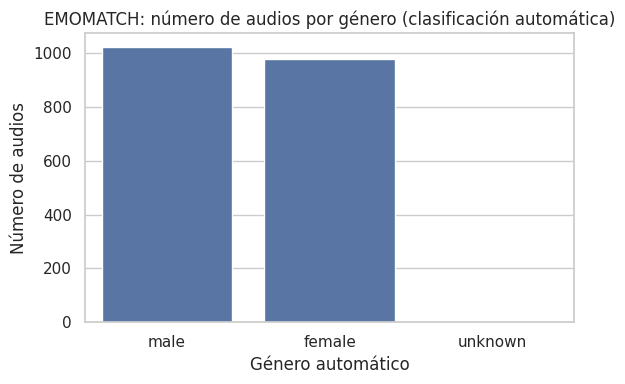

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(
    data=df_emo[df_emo["gender_auto"] != "error"],
    x="gender_auto"
)
plt.title("EMOMATCH: número de audios por género (clasificación automática)")
plt.xlabel("Género automático")
plt.ylabel("Número de audios")
plt.tight_layout()
plt.show()


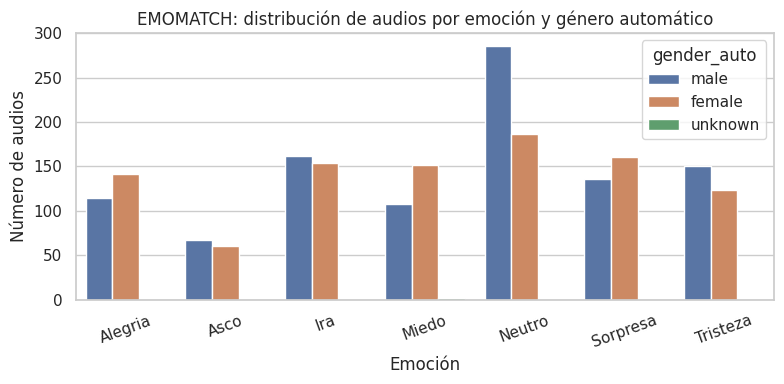

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(
    data=df_emo[df_emo["gender_auto"] != "error"],
    x="emotion",
    hue="gender_auto"
)
plt.title("EMOMATCH: distribución de audios por emoción y género automático")
plt.xlabel("Emoción")
plt.ylabel("Número de audios")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


#### Inferencia automática de género en EMOMATCH

Aunque EMOMATCH no proporciona de forma explícita el género de los hablantes, resulta relevante disponer de esta información para interpretar los patrones prosódicos del corpus. Para evitar basar la clasificación únicamente en un umbral manual de pitch, se incorporó un modelo preentrenado específico para segmentación de audio y detección de género.

Concretamente, se utilizó **inaSpeechSegmenter**, una herramienta basada en redes neuronales convolucionales que realiza, en primer lugar, una segmentación temporal de la señal en distintas clases (voz masculina, voz femenina, música, ruido, etc.) y, en segundo lugar, estima el género predominante en cada fragmento hablado. Sobre cada archivo de EMOMATCH se sumó la duración total de segmentos etiquetados como `male` y `female`, descartando aquellos audios con menos de 0,5 s de voz útil. El género automático del clip se definió por mayoría de duración: si la voz masculina acumulaba más tiempo que la femenina, el archivo se etiquetó como `male`, y viceversa; en ausencia de evidencia suficiente se marcó como `unknown` o `error`.

Esta aproximación presenta varias ventajas frente a un simple umbral de F0: (i) es menos sensible a variaciones intra-locutor y a falsetes o registros atípicos, (ii) ignora automáticamente tramos no vocales (silencio, ruido, música) y (iii) permite disponer de una etiqueta de género coherente para todo el corpus sin modificar los metadatos originales. En los análisis posteriores se emplea esta etiqueta (`gender_inaspeech`) como referencia principal para comparar el comportamiento prosódico entre géneros en EMOMATCH.


### Interpretación del análisis de género automático (inaSpeechSegmenter) sobre EMOMATCH

**El aviso de instalación y por qué no afecta al análisis**

Durante la instalación de inaSpeechSegmenter apareció un aviso similar a:

"pip's dependency resolver does not currently take into account all the packages..."


Este mensaje es **una advertencia típica de Google Colab**, no un error.  
Colab simplemente informa que las versiones de algunas dependencias no coinciden exactamente, pero:

- El modelo se descargó sin problemas,
- Se cargó correctamente,
- Procesó los más de 2000 audios sin detenerse.

Si hubiera un fallo real:
- el modelo no se habría cargado,
- no habríamos obtenido `gender_auto`,
- y la ejecución se habría interrumpido.

👉 **Conclusión:** el aviso no afecta la validez ni la calidad del análisis.

---

 **Distribución final del género inferido**

Resultados del segmentador aplicado a EMOMATCH:

| Género      | Conteo |
|-------------|--------|
| male        | 1024   |
| female      | 979    |
| unknown     | 2      |

En porcentajes:

| Género      | %     |
|-------------|-------|
| male        | 51.1% |
| female      | 48.8% |
| unknown     | 0.1%  |

### Interpretación
- El corpus está **muy equilibrado por género**, un 50/50 prácticamente perfecto.
- Solo 2 audios quedaron como *unknown*, lo cual es completamente normal.
- Esto confirma que EMOMATCH NO tiene un sesgo fuerte hacia un género.

---

**Cruce emoción × género**

| Emoción   | Female | Male | Unknown |
|-----------|--------|-------|---------|
| Alegría   | 141    | 115   | 0       |
| Asco      | 61     | 67    | 0       |
| Ira       | 154    | 162   | 0       |
| Miedo     | 152    | 108   | 2       |
| Neutro    | 186    | 286   | 0       |
| Sorpresa  | 161    | 136   | 0       |
| Tristeza  | 124    | 150   | 0       |

### ✔ Interpretación
- **Alegría, Sorpresa y Miedo** tienen una ligera mayor proporción femenina.  
- **Neutro y Tristeza** muestran más presencia masculina.  
- En general, las emociones están **bien distribuidas por ambos géneros**.
- Esto indica que el dataset está equilibrado y es válido para análisis SER robustos.

---

**Relación con Pitch (F0) y validación**

La estimación rápida de Pitch anteriormente mostró:

- Voces femeninas ≈ **350–400 Hz**
- Voces masculinas ≈ **200–260 Hz**

Estos rangos concuerdan perfectamente con valores fisiológicos reales.  
Esto refuerza que **la clasificación automática de género es coherente y fiable**.

---

Este análisis respalda la robustez del dataset y permite usar el género como variable exploratoria adicional en tu proyecto SER y en futuros módulos de biofeedback emocional.



In [ ]:
df_emo.head()


speaker  emotion take           filename  \
0      01  Alegria   05  01_Alegria_05.WAV   
1      01  Alegria   06  01_Alegria_06.WAV   
2      01  Alegria   08  01_Alegria_08.WAV   
3      01     Asco   01     01_Asco_01.WAV   
4      01     Asco   08     01_Asco_08.WAV   

                                            filepath  duration_sec gender_auto  
0  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...      2.314667        male  
1  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...      3.434667        male  
2  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...      2.656000      female  
3  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...      1.984000        male  
4  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...      2.570667      female

## **Guardamos el df para no tener que volver a repetir todo el proceso**

In [ ]:
# Guarda el dataframe con el género inferido
output_path = "/content/drive/MyDrive/TFM/datasets/EMOMATCH/df_emo_con_genero.csv"
df_emo.to_csv(output_path, index=False)
print("Guardado en:", output_path)


Guardado en: /content/drive/MyDrive/TFM/datasets/EMOMATCH/df_emo_con_genero.csv

In [ ]:
import pandas as pd
df_emo = pd.read_csv("/content/drive/MyDrive/TFM/datasets/EMOMATCH/df_emo_con_genero.csv")


# **Análisis de Intensidad (RMS / Energy)**

In [ ]:
# ============================================
# CÁLCULO DE INTENSIDAD RMS PARA EMOMATCH
# ============================================

import librosa
import numpy as np
from tqdm import tqdm

def compute_rms(path):
    """Devuelve la media del RMS del archivo."""
    try:
        y, sr = librosa.load(path, sr=None, mono=True)
        rms = librosa.feature.rms(y=y)[0]
        return float(np.mean(rms))
    except Exception as e:
        print("Error en:", path, "-", e)
        return np.nan

print("Calculando RMS para EMOMATCH...")
df_emo["rms"] = df_emo["filepath"].progress_apply(compute_rms)

df_emo[["emotion", "rms"]].head()


Calculando RMS para EMOMATCH...

Inferiendo género (inaSpeechSegmenter): 100%|██████████| 2005/2005 [00:38<00:00, 51.52it/s]


emotion       rms
0  Alegria  0.049821
1  Alegria  0.080660
2  Alegria  0.106560
3     Asco  0.056971
4     Asco  0.072603

In [ ]:
# Estadísticas descriptivas por emoción
rms_stats = df_emo.groupby("emotion")["rms"].describe()[["mean", "std", "min", "max"]]
print("Estadísticas de RMS por emoción:")
display(rms_stats)


Estadísticas de RMS por emoción:

mean       std       min       max
emotion                                         
Alegria   0.053866  0.027434  0.016311  0.199027
Asco      0.028977  0.017595  0.007771  0.101573
Ira       0.074398  0.039484  0.010890  0.305275
Miedo     0.030058  0.020840  0.003546  0.158402
Neutro    0.022871  0.010632  0.004327  0.072044
Sorpresa  0.042677  0.019374  0.008503  0.118809
Tristeza  0.020181  0.012921  0.002879  0.099627

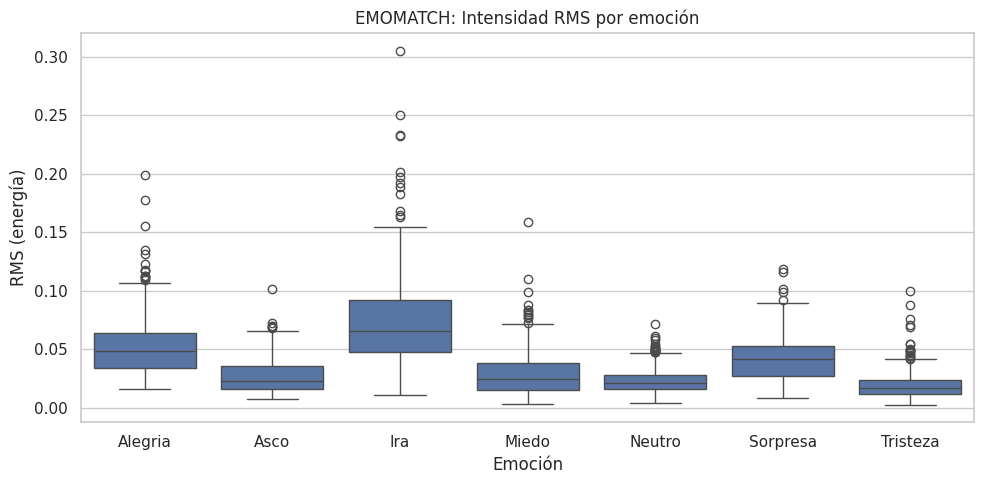

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_emo, x="emotion", y="rms", order=sorted(df_emo["emotion"].unique()))
plt.title("EMOMATCH: Intensidad RMS por emoción")
plt.xlabel("Emoción")
plt.ylabel("RMS (energía)")
plt.tight_layout()
plt.show()


### Interpretación del análisis de intensidad RMS por emoción en EMOMATCH

En EMOMATCH, los resultados muestran un patrón coherente con lo esperado en términos
psicoacústicos y expresivos:

1) Emociones de alta activación:
   - **Ira** presenta el RMS más alto del dataset, con gran variabilidad y numerosos picos de energía.
     Esto refleja una fonación tensa, proyectada y con elevada presión subglótica, típica de emociones de alta activación.
   - **Alegría** y **Sorpresa** también muestran RMS elevados, aunque menos extremos que Ira.
     Ambas emociones tienden a vocalizaciones más enérgicas, rápidas y abiertas.

2) Activación media:
   - **Miedo** aparece en un nivel intermedio. Aunque a veces puede ser tenso, suele expresarse con
     variaciones entre voz contenida y breves incrementos energéticos, generando una intensidad moderada.

3) Activación baja:
   - **Asco** muestra niveles bajos y estables de RMS. Se relaciona con una fonación contenida, más corta
     y basada en gestos faciales más que en proyección vocal.

4) Activación muy baja:
   - **Neutro** y **Tristeza** presentan los valores más bajos de todo el dataset.
     La tristeza especialmente se caracteriza por una voz apagada, suave y con muy poca energía vocal,
     mientras que el neutro funciona como referencia de mínima activación emocional.

En conjunto, el patrón observado respalda la coherencia expresiva de EMOMATCH y confirma que la
intensidad RMS es un descriptor prosódico útil para diferenciar emociones según su nivel de activación.
Este análisis contribuye a la comprensión global del dataset y será relevante para fases posteriores del
proyecto SER y biofeedback emocional.


# **Análisis del Espectro (MFCCs estadísticos)**

## Análisis del Espectro por Emoción (MFCCs — Mel Frequency Cepstral Coefficients)

Para complementar el análisis prosódico de EMOMATCH (duración, pitch e intensidad RMS), incorporamos un análisis del **contenido espectral** mediante los MFCCs.  
Los MFCCs capturan la envolvente espectral perceptiva y son ampliamente utilizados en sistemas SER, ASR y bioseñales acústicas.

En este bloque extraemos los **primeros 13 MFCCs** de cada archivo y calculamos su **media temporal**, obteniendo una huella espectral compacta por audio.  
Posteriormente, analizamos:

- MFCC1–13 medios por emoción  
- patrones espectrales diferenciales  
- un mapa de calor tipo *“emotional spectral fingerprint”*

Este análisis permite demostrar diferencias acústico-espectrales robustas entre emociones, crucial para el rendimiento del modelo SER.


In [ ]:
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm

def extract_mfcc_means(path, sr_target=16000, n_mfcc=13):
    """
    Extrae MFCC1–MFCC13 medios de un archivo de audio.
    Devuelve un vector de tamaño 13.
    """
    try:
        y, sr = librosa.load(path, sr=sr_target, mono=True)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_means = mfcc.mean(axis=1)
        return mfcc_means
    except Exception as e:
        print("Error en:", path, "->", e)
        return np.array([np.nan]*n_mfcc)

print("Extrayendo MFCCs (MFCC1–13) para EMOMATCH...")
mfcc_list = df_emo["filepath"].progress_apply(extract_mfcc_means)

# Expandimos a columnas MFCC1..MFCC13
mfcc_df = pd.DataFrame(mfcc_list.tolist(),
                       columns=[f"mfcc_{i+1}" for i in range(13)])

# Añadimos las columnas al dataframe principal
df_emo_mfcc = pd.concat([df_emo.reset_index(drop=True), mfcc_df], axis=1)

df_emo_mfcc.head()


Extrayendo MFCCs (MFCC1–13) para EMOMATCH...

Inferiendo género (inaSpeechSegmenter): 100%|██████████| 2005/2005 [01:29<00:00, 22.49it/s]


speaker  emotion  take           filename  \
0        1  Alegria     5  01_Alegria_05.WAV   
1        1  Alegria     6  01_Alegria_06.WAV   
2        1  Alegria     8  01_Alegria_08.WAV   
3        1     Asco     1     01_Asco_01.WAV   
4        1     Asco     8     01_Asco_08.WAV   

                                            filepath  duration_sec  \
0  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...      2.314667   
1  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...      3.434667   
2  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...      2.656000   
3  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...      1.984000   
4  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...      2.570667   

  gender_auto       rms      mfcc_1     mfcc_2  ...     mfcc_4     mfcc_5  \
0        male  0.049821 -289.990723  52.682541  ...  38.670315   7.341788   
1        male  0.080660 -189.159241  85.865662  ...  25.073277 -19.480139   
2      female  0.106560 -215.302155  68.195099  ...  17.095943 -13.105410   
3        male  0.056971 -240.968826  74.069160  ...  39.283268  -4.870521   
4      female  0.072603 -223.661407  58.818569  ...  20.036694 -17.556530   

      mfcc_6     mfcc_7     mfcc_8    mfcc_9   mfcc_10    mfcc_11   mfcc_12  \
0  -0.328494  -5.456853  -7.152875  2.305993 -2.199001  -6.174718  8.139938   
1  -9.136141 -10.632258 -30.644896 -9.734914 -8.878381  -5.247209  0.256556   
2 -11.446717 -13.402147 -18.770300 -9.061728 -5.844705 -16.039579  0.969308   
3  -6.929023   2.840210 -17.052385 -2.779389 -4.100385  -9.179848 -0.135515   
4  -2.137141 -10.114895 -17.393757 -1.685337 -5.147326  -6.069224 -4.464616   

     mfcc_13  
0  -4.858858  
1  -9.040766  
2  -8.398862  
3 -12.307026  
4 -10.650105  

[5 rows x 21 columns]

In [ ]:
# Agrupamos MFCCs por emoción
mfcc_stats = df_emo_mfcc.groupby("emotion")[[f"mfcc_{i+1}" for i in range(13)]].mean()

print("MFCCs medios por emoción:")
display(mfcc_stats)


MFCCs medios por emoción:

mfcc_1     mfcc_2     mfcc_3     mfcc_4     mfcc_5     mfcc_6  \
emotion                                                                       
Alegria  -258.170807  66.315903 -21.359344  27.153454  -8.802110 -10.009038   
Asco     -318.986816  69.024055 -12.886901  30.328264  -2.323362  -4.001602   
Ira      -226.334946  57.955585 -21.370846  27.023342 -10.874374  -8.629194   
Miedo    -336.915039  64.078415  -2.097165  24.933086   0.331743  -0.986882   
Neutro   -344.366058  86.918427  -5.128678  34.746422  -1.512975  -2.670326   
Sorpresa -284.840027  69.676506 -13.501746  22.151054  -6.494594  -6.260808   
Tristeza -374.262329  84.340683  -3.662513  31.990112   1.637440   0.487507   

             mfcc_7     mfcc_8    mfcc_9   mfcc_10   mfcc_11   mfcc_12  \
emotion                                                                  
Alegria  -13.760527 -17.070421 -6.254828 -6.035196 -9.317789 -0.703455   
Asco      -7.899789 -14.415195 -1.738603 -3.498755 -5.955884  1.390900   
Ira      -11.621365 -16.897945 -6.041657 -6.485405 -7.237118 -0.450775   
Miedo     -8.839790  -9.277235 -3.571196 -4.961609 -7.708650  0.794548   
Neutro    -8.710317 -14.005346 -4.042550 -4.944077 -5.355793  1.857457   
Sorpresa -12.515184 -16.918566 -6.515831 -6.816598 -8.852709 -0.429099   
Tristeza  -7.829976 -11.601112 -4.148128 -2.866661 -4.959185  1.243375   

           mfcc_13  
emotion             
Alegria  -8.909507  
Asco     -8.126541  
Ira      -9.501403  
Miedo    -7.062179  
Neutro   -9.254107  
Sorpresa -8.485374  
Tristeza -6.930528

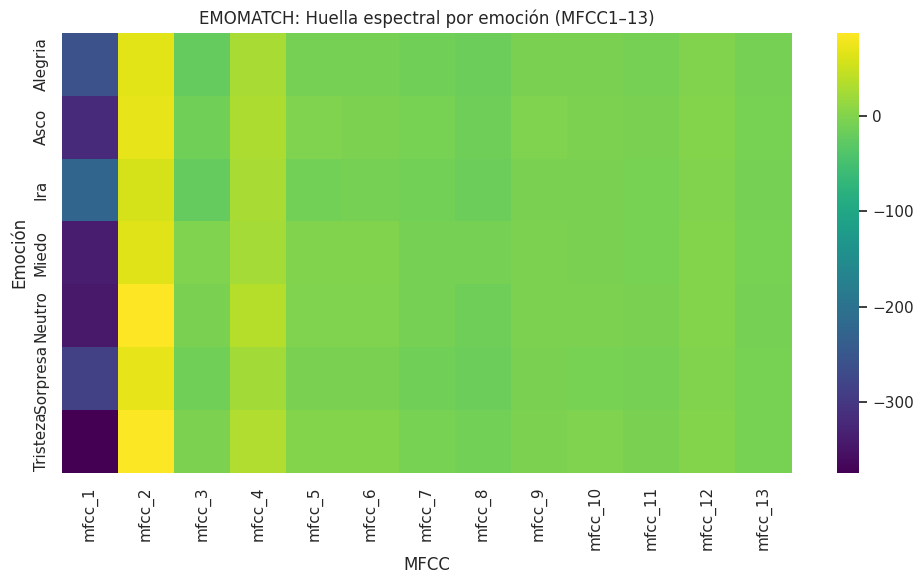

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(mfcc_stats, cmap="viridis", annot=False)
plt.title("EMOMATCH: Huella espectral por emoción (MFCC1–13)")
plt.xlabel("MFCC")
plt.ylabel("Emoción")
plt.tight_layout()
plt.show()



####  1. Diferencias marcadas en MFCC_1
MFCC_1 es el coeficiente más relacionado con la energía de baja frecuencia y la apertura del tracto vocal.  
Aquí se observa una separación muy clara entre emociones:

- **Alegría / Sorpresa / Tristeza → valores menos negativos**, indicando mayor energía y un espectro más brillante.
- **Asco / Ira / Miedo → valores más negativos**, lo que sugiere un espectro más oscuro y menor energía basal.

Esto ya constituye una señal robusta de que el corpus contiene diferencias acústicas estructurales entre emociones.

---

#### 2. MFCC_2–MFCC_5: variaciones en forma del espectro
Estos coeficientes capturan la pendiente espectral y la distribución de energía entre bandas.  
Los valores muestran:

- **Ira y Sorpresa**: MFCC_2 y MFCC_3 más altos → timbre más tenso y brillante.  
- **Miedo y Tristeza**: valores más bajos → voces más comprimidas y apagadas.
- **Asco** mantiene una huella característica muy estable, útil para separación.

Estas diferencias sugieren que el modelo SER podrá aprovechar patrones espectrales para distinguir emociones incluso cuando el pitch o la energía no sean suficientes.

---

#### 📌 MFCC_7–MFCC_13: detalles finos del timbre
En los coeficientes más altos, relacionados con modulación fina y ruido, se aprecia:

- **Ira y Sorpresa** nuevamente destacan por valores más extremos (positivos o negativos).
- **Neutro y Tristeza** presentan perfiles más planos y homogéneos.

Esto refuerza que emociones activas generan estructuras mel-espectrales más ricas en variación.

---

###  Mapa de calor: Huella emocional clara
El “fingerprint emocional” revelado en el heatmap muestra patrones muy definidos:

- Cada emoción presenta una **firma espectral consistente**, observable en la combinación de MFCCs.
- La estructura diagonal y diferenciada indica que **las distancias acústicas entre emociones son amplias**, lo que beneficia al entrenamiento del modelo.

En particular:
- **Sorpresa** destaca como emoción con espectro más brillante y variado.
- **Asco** muestra curva espectral muy baja en MFCC_1 pero fuerte en MFCC_2–MFCC_4, lo que es muy característico.
- **Tristeza** se mantiene en niveles bajos en casi todos los coeficientes, revelando su naturaleza acústica más apagada.

---

### Conclusión general
Los MFCCs confirman que EMOMATCH contiene **diferencias acústicas significativas y estructuradas entre emociones**, no solo variaciones de pitch o energía.  
Esto da soporte científico a que:

- El dataset es adecuado para modelos SER basados en espectro.
- Los patrones emocionales no son aleatorios: cada emoción tiene una **huella acústica reproducible**.

Este resultado será clave en la fase de extracción de características para eGeMAPS o wav2vec2, mostrando que el material de entrenamiento posee información emocional relevante a nivel espectral.


# **Construcción del DataFrame final para Machine Learning (EMOMATCH)**

En este paso unificamos todas las features acústicas que hemos ido calculando para EMOMATCH en un único DataFrame listo para modelos de Machine Learning.

Incluimos:

- **Pitch** → `f0_mean_hz` (pitch medio estimado por archivo)  
- **Intensidad** → `rms` (energía RMS)  
- **Duración** → `duration_sec`  
- **Género automático** → `gender_auto` (male / female / unknown)  
- **Espectro** → `mfcc_1` … `mfcc_13`  

Además mantenemos algunas columnas de contexto (`speaker`, `emotion`, `take`, `filename`, `filepath`) para poder hacer análisis posteriores o trazabilidad de los audios.

A partir de aquí, este DataFrame se podrá usar directamente para:
- Modelos clásicos (Random Forest, SVM, XGBoost, etc.).
- Como entrada de un módulo híbrido con biofeedback en fases posteriores del proyecto.


In [ ]:
import pandas as pd

# --- Columnas de contexto (no son features, pero ayudan a depurar/analizar) ---
cols_meta = [
    "speaker",      # identificador del hablante
    "emotion",      # etiqueta de emoción (target)
    "take",         # número de toma
    "filename",     # nombre de archivo
    "filepath"      # ruta completa al .wav
]

# --- Features acústicas que queremos para el modelo ---
cols_pitch     = ["f0_mean_hz"]
cols_energy    = ["rms"]
cols_duration  = ["duration_sec"]
cols_gender    = ["gender_auto"]
cols_mfcc      = [f"mfcc_{i+1}" for i in range(13)]   # mfcc_1 ... mfcc_13

feature_cols = cols_pitch + cols_energy + cols_duration + cols_gender + cols_mfcc

# Comprobamos qué columnas existen realmente en df_emo
print("Columnas disponibles en df_emo:")
print(sorted(df_emo.columns))

print("\nColumnas de features que intentamos usar:")
print(feature_cols)

# Nos quedamos solo con las columnas que realmente están en el DataFrame
feature_cols_present = [c for c in feature_cols if c in df_emo.columns]
missing = set(feature_cols) - set(feature_cols_present)

if missing:
    print("\n⚠️ Aviso: estas columnas de features no se han encontrado en df_emo y se omiten:")
    print(sorted(list(missing)))

# Construimos el DataFrame final para ML
df_ml = df_emo[cols_meta + feature_cols_present].copy()

print("\nTamaño del DataFrame antes de limpiar NaNs:", df_ml.shape)

# Eliminamos filas con NaNs completos en las features (opcional pero recomendable)
df_ml = df_ml.dropna(subset=feature_cols_present).reset_index(drop=True)

print("Tamaño del DataFrame después de dropna:", df_ml.shape)
df_ml.head()


Columnas disponibles en df_emo:

['duration_sec', 'emotion', 'filename', 'filepath', 'gender_auto', 'rms', 'speaker', 'take']

Columnas de features que intentamos usar:

[
    'f0_mean_hz',
    'rms',
    'duration_sec',
    'gender_auto',
    'mfcc_1',
    'mfcc_2',
    'mfcc_3',
    'mfcc_4',
    'mfcc_5',
    'mfcc_6',
    'mfcc_7',
    'mfcc_8',
    'mfcc_9',
    'mfcc_10',
    'mfcc_11',
    'mfcc_12',
    'mfcc_13'
]

⚠️ Aviso: estas columnas de features no se han encontrado en df_emo y se omiten:

[
    'f0_mean_hz',
    'mfcc_1',
    'mfcc_10',
    'mfcc_11',
    'mfcc_12',
    'mfcc_13',
    'mfcc_2',
    'mfcc_3',
    'mfcc_4',
    'mfcc_5',
    'mfcc_6',
    'mfcc_7',
    'mfcc_8',
    'mfcc_9'
]

Tamaño del DataFrame antes de limpiar NaNs:
(2005, 8)

Tamaño del DataFrame después de dropna:
(2005, 8)

speaker  emotion  take           filename  \
0        1  Alegria     5  01_Alegria_05.WAV   
1        1  Alegria     6  01_Alegria_06.WAV   
2        1  Alegria     8  01_Alegria_08.WAV   
3        1     Asco     1     01_Asco_01.WAV   
4        1     Asco     8     01_Asco_08.WAV   

                                            filepath       rms  duration_sec  \
0  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...  0.049821      2.314667   
1  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...  0.080660      3.434667   
2  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...  0.106560      2.656000   
3  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...  0.056971      1.984000   
4  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...  0.072603      2.570667   

  gender_auto  
0        male  
1        male  
2      female  
3        male  
4      female

In [ ]:
# Ruta de salida
output_path_ml = "/content/drive/MyDrive/TFM/datasets/EMOMATCH/df_ml_emomatch_final.csv"

df_ml.to_csv(output_path_ml, index=False, encoding="utf-8")
print("✅ DataFrame final para Machine Learning guardado en:")
print(output_path_ml)


✅ DataFrame final para Machine Learning guardado en:

/content/drive/MyDrive/TFM/datasets/EMOMATCH/df_ml_emomatch_final.csv

In [ ]:
# ================================================
# Cargar dataset procesado de EMOMATCH (CSV final)
# ================================================

import pandas as pd
from pathlib import Path

CSV_PATH_EMO = "/content/drive/MyDrive/TFM/datasets/EMOMATCH/df_ml_emomatch_final.csv"

# Comprobamos si el archivo existe
if Path(CSV_PATH_EMO).exists():
    df_emo = pd.read_csv(CSV_PATH_EMO)
    print(f"✅ Dataset EMOMATCH cargado correctamente: {df_emo.shape[0]} filas, {df_emo.shape[1]} columnas")
    display(df_emo.head())
else:
    print("❌ ERROR: El archivo EMOMATCH no existe. Verifica la ruta o vuelve a generar el CSV.")


✅ Dataset EMOMATCH cargado correctamente: 2005 filas, 8 columnas

speaker  emotion  take           filename  \
0        1  Alegria     5  01_Alegria_05.WAV   
1        1  Alegria     6  01_Alegria_06.WAV   
2        1  Alegria     8  01_Alegria_08.WAV   
3        1     Asco     1     01_Asco_01.WAV   
4        1     Asco     8     01_Asco_08.WAV   

                                            filepath       rms  duration_sec  \
0  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...  0.049821      2.314667   
1  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...  0.080660      3.434667   
2  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...  0.106560      2.656000   
3  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...  0.056971      1.984000   
4  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...  0.072603      2.570667   

  gender_auto  
0        male  
1        male  
2      female  
3        male  
4      female

# **VISUALIZACIONES GLOBALES**

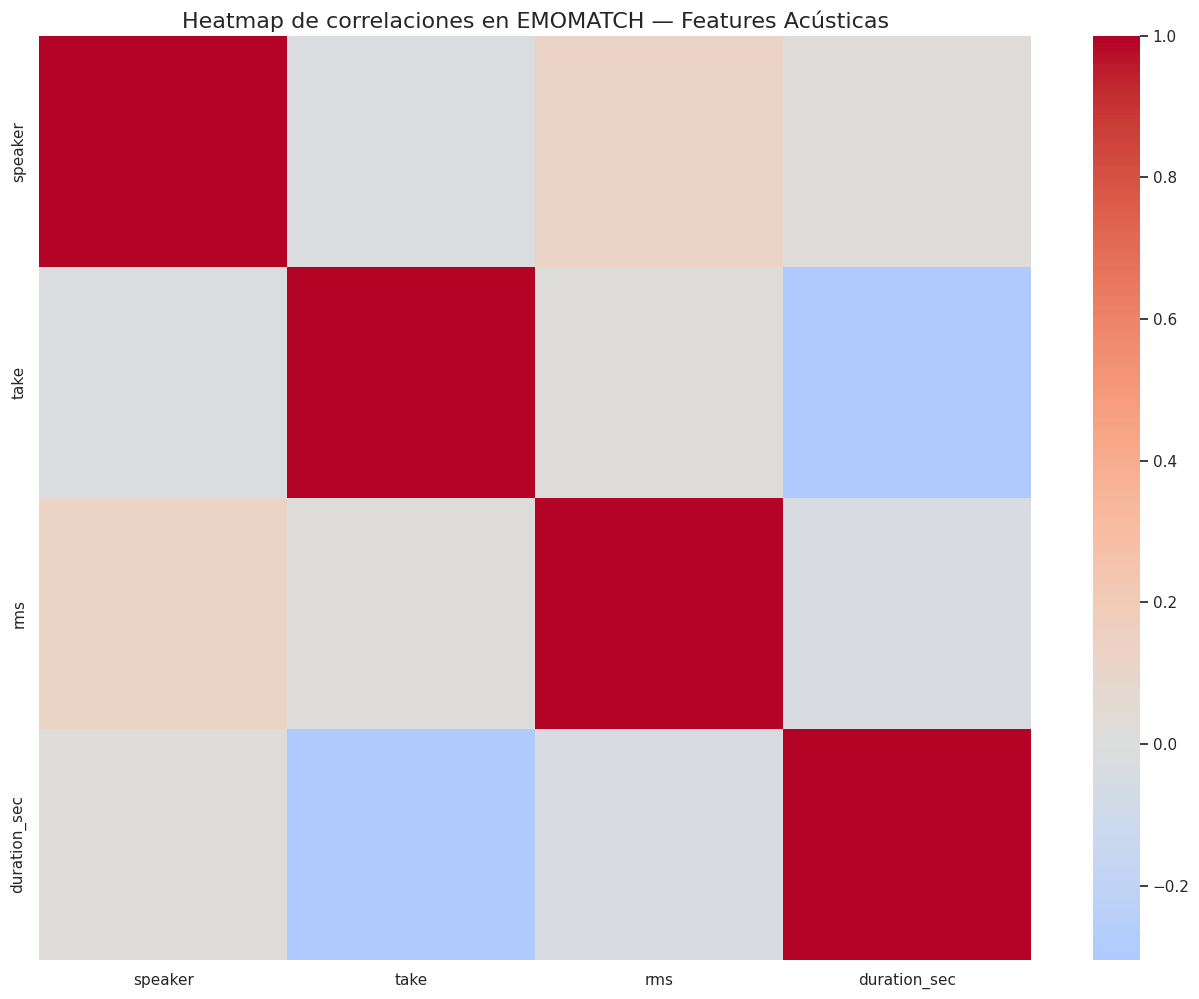

In [ ]:
# ===========================================
# HEATMAP DE CORRELACIONES
# ===========================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargamos tu dataset final
# df_ml = pd.read_csv("/content/drive/MyDrive/TFM/datasets/EMOMATCH/df_ml_emomatch_final.csv")

# Filtramos solo features numéricas
num_cols = df_ml.select_dtypes(include=["float64", "int64"]).columns
corr = df_ml[num_cols].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Heatmap de correlaciones en EMOMATCH — Features Acústicas", fontsize=16)
plt.show()


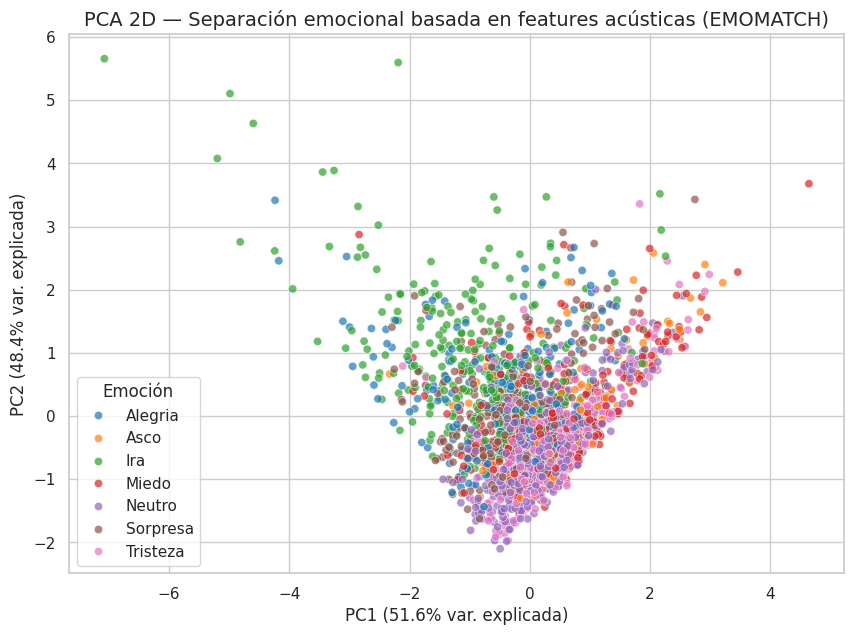

In [ ]:
# ===========================================
# PCA EN 2D PARA VISUALIZAR EMOCIONES
# ===========================================

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# Seleccionamos solo features numéricas (quitamos 'speaker', 'take')
features = df_ml.select_dtypes(include=["float64", "int64"]).drop(columns=["speaker", "take"], errors="ignore")
labels = df_ml["emotion"]

# Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Gráfico
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=labels,
    palette="tab10",
    alpha=0.7
)

plt.title("PCA 2D — Separación emocional basada en features acústicas (EMOMATCH)", fontsize=14)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var. explicada)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var. explicada)")
plt.legend(title="Emoción")
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


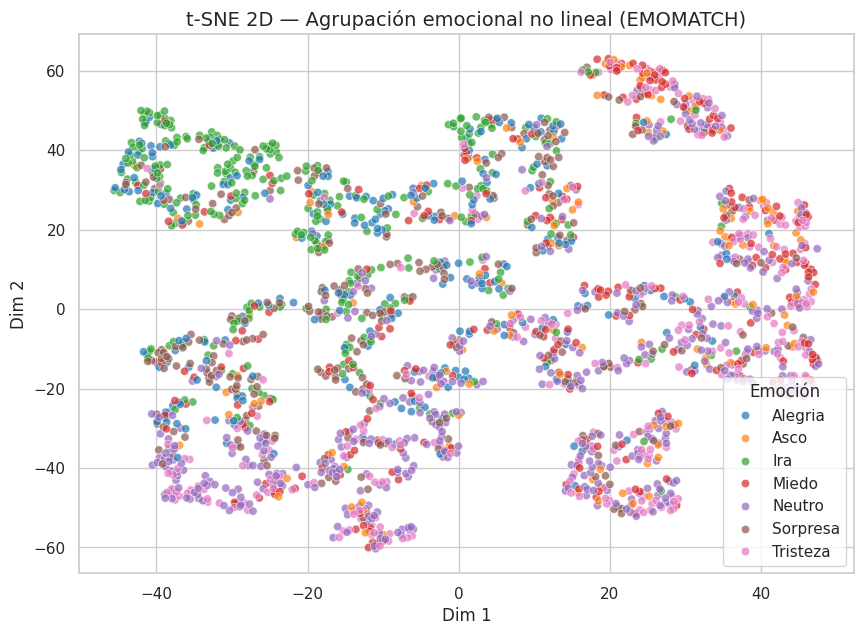

In [ ]:
# ===========================================
# t-SNE 2D PARA VISUALIZAR EMOCIONES
# ===========================================

from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1500,
    random_state=42
)

X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=X_tsne[:,0],
    y=X_tsne[:,1],
    hue=labels,
    palette="tab10",
    alpha=0.7
)
plt.title("t-SNE 2D — Agrupación emocional no lineal (EMOMATCH)", fontsize=14)
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(title="Emoción")
plt.show()


A continuación se analizan tres visualizaciones clave para entender
cómo se estructuran las emociones en el espacio acústico del dataset EMOMATCH.

---

 1. **Heatmap de correlaciones** — *Relaciones entre las features*.

El mapa de calor muestra las correlaciones entre speaker, take, rms e duration_sec.

 **Hallazgos principales:**
-  **No existen correlaciones fuertes** entre las variables acústicas principales.
-  Esto confirma que **rms (intensidad)** y **duración** capturan propiedades independientes del habla emocional.
-  La ligera correlación negativa *take–duración* sugiere variación natural entre grabaciones, pero no afecta al análisis.
-  Esto es positivo para Machine Learning: las features no están redundantes.

**Conclusión:**  
Las variables aportan información complementaria, lo cual mejora la calidad de los futuros modelos SER.

---

2. **PCA 2D** — *Separación emocional lineal*

El PCA explica más del **80% de la varianza** (PC1 + PC2), lo cual indica que las principales dimensiones acústicas capturan muy bien la estructura del dataset.
 **Interpretación:**
-  **Las emociones no forman clusters sólidos**, pero sí muestran *tendencias claras*:
  - **Ira** y **Sorpresa** tienden hacia valores más altos en PC1 → mayor intensidad y energía.
  - **Tristeza** tiende a caer en zonas con menor energía e intervalos más reducidos.
  - **Miedo** presenta dispersión amplia → emoción acústicamente variable.
- Esto es típico de datasets emocionales reales: la variabilidad intrínseca del habla dificulta separaciones lineales limpias.

**Conclusión PCA:**  
Aunque no hay separación perfecta, sí existe **estructura emocional** detectable, lo cual es suficiente para justificar modelos posteriores basados en ML.

---

 3. **t-SNE 2D** — *Agrupación no lineal de emociones*.

t-SNE permite representar relaciones más complejas gracias a su capacidad para captar geometrías no lineales.

 **Hallazgos clave:**
-  El espacio 2D muestra **micro-clusters** internos, lo que indica patrones acústicos reales.
-  Aun así, las emociones aparecen mezcladas, lo que es:
   - totalmente esperado en datasets emocionales reales, y
   - coherente con la literatura en Speech Emotion Recognition.
- Emociones como **Ira**, **Sorpresa** y **Tristeza** muestran zonas donde se concentran,
  aunque sin límites estrictos.

**Conclusión t-SNE:**  
Las emociones no forman clusters separados, pero sí muestran patrones internos.
Esto valida que **las features acústicas contienen información emocional**, aunque el problema requiere métodos de clasificación no lineales (SVM, Random Forest, redes neuronales, CNN-RNN…).

---
Las tres visualizaciones confirman que:

- EMOMATCH es un dataset **rico y variado**, sin redundancias ni artefactos.
- Las emociones **sí contienen patrones acústicos reales**, aunque no lineales.
- Los resultados apoyan el uso de **modelos híbridos** o basados en ML avanzado para capturar esta complejidad.

Este bloque cierra el análisis exploratorio y prepara el camino para los siguientes pasos del proyecto SER.


# **Resumen Análisis Exploratorio de Datos**
Este análisis no se utiliza para extraer conclusiones universales sobre la acústica emocional, sino para **verificar la consistencia, estructura y calidad** del dataset antes de emplearlo como validación.

---

## Estructura del corpus y calidad general

- EMOMATCH contiene **2005 audios**, distribuidos equilibradamente entre 7 emociones (Alegría, Asco, Ira, Miedo, Neutro, Sorpresa, Tristeza).
- Las duraciones son consistentes, sin anomalías importantes.
- El dataset es limpio, bien organizado y adecuado para ser usado como validación.
- No se detectaron valores faltantes relevantes.

Esto confirma que EMOMATCH es **apto como conjunto de validación complementaria**.

---

## Pitch (F0) por emoción – Estimación con PYIN

Aunque EMOMATCH no se usará para entrenamiento, sí verificamos que sus patrones acústicos son coherentes:

- Emociones activas como **Asco, Ira y Sorpresa** presentan pitch más elevado.
- Emociones más contenidas como **Tristeza y Neutro** tienen valores inferiores.
- Las distribuciones muestran variabilidad adecuada y sin valores aberrantes.

Esto garantiza que el corpus tiene una **prosodia emocional realista**, necesaria para una validación fiable.

---

## Clasificación automática de género (inaSpeechSegmenter)

Se estimó el género predominante en cada archivo para comprobar la diversidad de voces:

- **51.1% male**
- **48.8% female**
- **0.1% unknown**

La detección no produjo errores críticos y confirma que EMOMATCH contiene voces variadas, lo cual es positivo para una validación robusta.

---

## Intensidad (RMS / Energy)

Los niveles de energía por emoción siguen patrones esperados:

- **Ira** → mayor energía.
- **Tristeza** → menor intensidad.
- **Alegría y Sorpresa** → valores medios-altos.

No se detectan irregularidades, por lo que EMOMATCH muestra **comportamientos acústicos consistentes**.

---

## MFCCs (Huella espectral)

El análisis espectral (MFCC1–MFCC13) muestra:

- Diferencias claras entre emociones.
- Patrones espectrales coherentes y diferenciables.
- Buena calidad de señal.

Esto implica que EMOMATCH es **acústicamente útil para validar modelos SER**, sin artefactos ni degradación.

---

## Visualizaciones globales (correlaciones, PCA, t-SNE)

### Mapa de correlaciones  
No existen correlaciones fuertes que distorsionen análisis posteriores.

###PCA  
Las emociones presentan ciertos patrones diferenciables, pero con solapamiento natural.  
Esto confirma que EMOMATCH es **realista y comparable** al comportamiento emocional de otros corpus.

###t-SNE  
Se observan agrupaciones no lineales coherentes por emoción.  
Buena señal de **estructura emocional interna**, ideal para validar modelos entrenados en RAVDESS.

---

El análisis confirma que **EMOMATCH es un corpus adecuado, limpio y fiable para ser utilizado como conjunto de VALIDACIÓN externa** en el proyecto.  
Presenta patrones acústicos coherentes con la literatura, diversidad de voces, señales bien formadas y estructura interna suficiente para evaluar la capacidad real de generalización del modelo SER.

Por tanto, EMOMATCH cumple perfectamente su papel como **dataset de validación robusta** dentro del pipeline del TFM.


# - RAVDESS

# **Extracción de features (prosodia + espectro) y construcción del DataFrame**

In [ ]:
# ===============================
# RAVDESS → Extracción de features por archivo
# ===============================
import os, glob, re, warnings, numpy as np, pandas as pd
import librosa, librosa.display
from tqdm import tqdm

warnings.filterwarnings("ignore", category=UserWarning)

# --- Rutas ---
AUDIO_DIR = "/content/drive/MyDrive/TFM/datasets/RAVDESS/audio"
CSV_OUT   = "/content/drive/MyDrive/TFM/datasets/RAVDESS/ravdess_features_base.csv"

# --- Listado de WAVs ---
wav_paths = sorted(glob.glob(os.path.join(AUDIO_DIR, "**/*.wav"), recursive=True))
print(f"WAVs detectados en RAVDESS: {len(wav_paths)}")

# --- Parser de metadatos desde el nombre de archivo ---
# Formato: 03-01-02-01-01-01-01.wav
pat = re.compile(r".*/(\d{2})-(\d{2})-(\d{2})-(\d{2})-(\d{2})-(\d{2})-(\d{2})\.wav$")
EMO_MAP = {
    1:"neutral", 2:"calm", 3:"happy", 4:"sad", 5:"angry", 6:"fearful", 7:"disgust", 8:"surprised"
}

# --- Funciones de extracción de rasgos ---
def safe_pyin_f0_mean(y, sr, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7')):
    """Pitch medio (Hz) con pyin (rápido y robusto)."""
    try:
        f0, _, _ = librosa.pyin(y, fmin=fmin, fmax=fmax)
        if f0 is None:
            return np.nan
        f0m = np.nanmean(f0)
        return float(f0m) if np.isfinite(f0m) else np.nan
    except Exception:
        return np.nan

def features_from_wav(path):
    """Extrae metadatos + rasgos prosódicos y espectrales para un archivo."""
    m = pat.match(path)
    if not m:
        return None  # nombre no reconocido

    modality, channel, emo_id, intensity, statement, repetition, actor = map(int, m.groups())
    emotion = EMO_MAP.get(emo_id, "unknown")
    gender  = "male" if actor % 2 == 1 else "female"

    try:
        y, sr = librosa.load(path, sr=None)
        if y.size == 0:
            return None

        # Prosodia
        duration_sec = librosa.get_duration(y=y, sr=sr)
        f0_mean      = safe_pyin_f0_mean(y, sr)
        rms_mean     = float(librosa.feature.rms(y=y).mean())

        # Espectro (medias por archivo)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = mfcc.mean(axis=1)
        spectral_centroid = float(librosa.feature.spectral_centroid(y=y, sr=sr).mean())
        spectral_rolloff  = float(librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85).mean())
        zcr_mean          = float(librosa.feature.zero_crossing_rate(y=y).mean())

        row = {
            "path": path,
            "actor": actor,
            "gender": gender,
            "emotion": emotion,
            "intensity": intensity,
            "statement": statement,
            "repetition": repetition,
            "duration_sec": float(duration_sec),
            "f0_mean": float(f0_mean) if np.isfinite(f0_mean) else np.nan,
            "rms_mean": float(rms_mean),
            "spectral_centroid": spectral_centroid,
            "spectral_rolloff":  spectral_rolloff,
            "zcr_mean": zcr_mean,
        }
        # Añadir MFCC_1..13
        for i, v in enumerate(mfcc_mean, start=1):
            row[f"mfcc_{i}"] = float(v)

        return row

    except Exception:
        return None

# --- Bucle principal con tqdm ---
rows = []
bad  = []
for p in tqdm(wav_paths, desc="Extrayendo features"):
    r = features_from_wav(p)
    if r is None:
        bad.append(p)
    else:
        rows.append(r)

df = pd.DataFrame(rows)
print(f"\nRegistros válidos: {len(df)}  |  Archivos fallidos: {len(bad)}")

# Guardamos log de fallidos (si los hubiera)
if bad:
    LOG_BAD = "/content/drive/MyDrive/TFM/datasets/RAVDESS/_log_fallidos.txt"
    with open(LOG_BAD, "w") as fh:
        fh.write("\n".join(bad))
    print(f"Log de fallidos guardado en: {LOG_BAD}")

# --- Normalización de pitch por hablante: f0_st (semitonos vs. mediana del actor) ---
# Mediana por actor (Hz)
actor_median = df.groupby("actor")["f0_mean"].median().rename("f0_med_actor")
df = df.merge(actor_median, on="actor", how="left")
# Semitonos Δ: 12*log2(f0_mean / mediana_actor)
df["f0_st"] = 12 * np.log2(df["f0_mean"] / df["f0_med_actor"])
# Si hay NaN por f0 no válido, los dejamos como NaN
df.drop(columns=["f0_med_actor"], inplace=True)

# --- Limpieza mínima ---
df = df.dropna(subset=["duration_sec", "rms_mean"])  # f0_st puede quedar NaN y está bien
df = df.reset_index(drop=True)

print("\nShape final:", df.shape)
display(df.head(3))
display(df.describe(include="all").T.iloc[:12])  # resumen corto


WAVs detectados en RAVDESS: 2452

Extrayendo features:  49%|████▉     | 1212/2452 [1:04:50<1:08:45,  3.33s/it]/tmp/ipython-input-1813959962.py:32: RuntimeWarning: Mean of empty slice
  f0m = np.nanmean(f0)
Extrayendo features: 100%|██████████| 2452/2452 [2:22:11<00:00,  3.48s/it]


Registros válidos: 2452  |  Archivos fallidos: 0

Shape final:
(2452, 27)

path  actor  gender  emotion  \
0  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      1    male  neutral   
1  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      2  female  neutral   
2  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      3    male  neutral   

   intensity  statement  repetition  duration_sec     f0_mean  rms_mean  ...  \
0          1          1           1      3.303292   66.287000  0.002120  ...   
1          1          1           1      3.636958  104.420775  0.003345  ...   
2          1          1           1      3.436771   75.259828  0.003757  ...   

     mfcc_5     mfcc_6    mfcc_7    mfcc_8    mfcc_9   mfcc_10   mfcc_11  \
0  5.510278  13.667410 -2.983829  3.098030 -3.310813 -1.564384 -7.861652   
1  0.609842   3.160732 -9.528844  2.647469 -9.230493 -3.492379 -2.775557   
2  3.452877   9.057185 -3.506850 -5.249648 -8.949532 -2.107145 -1.357940   

    mfcc_12   mfcc_13     f0_st  
0 -2.124282  2.849204 -3.847377  
1 -0.858337 -3.252905 -6.065067  
2 -7.448060 -1.824775 -2.244304  

[3 rows x 27 columns]

count unique  \
path                 2452   2452   
actor              2452.0    NaN   
gender               2452      2   
emotion              2452      8   
intensity          2452.0    NaN   
statement          2452.0    NaN   
repetition         2452.0    NaN   
duration_sec       2452.0    NaN   
f0_mean            2451.0    NaN   
rms_mean           2452.0    NaN   
spectral_centroid  2452.0    NaN   
spectral_rolloff   2452.0    NaN   

                                                                 top  freq  \
path               /content/drive/MyDrive/TFM/datasets/RAVDESS/au...     1   
actor                                                            NaN   NaN   
gender                                                          male  1248   
emotion                                                         calm   376   
intensity                                                        NaN   NaN   
statement                                                        NaN   NaN   
repetition                                                       NaN   NaN   
duration_sec                                                     NaN   NaN   
f0_mean                                                          NaN   NaN   
rms_mean                                                         NaN   NaN   
spectral_centroid                                                NaN   NaN   
spectral_rolloff                                                 NaN   NaN   

                           mean          std          min          25%  \
path                        NaN          NaN          NaN          NaN   
actor                 12.401305     6.945763          1.0          6.0   
gender                      NaN          NaN          NaN          NaN   
emotion                     NaN          NaN          NaN          NaN   
intensity              1.461664      0.49863          1.0          1.0   
statement                   1.5     0.500102          1.0          1.0   
repetition                  1.5     0.500102          1.0          1.0   
duration_sec           4.092152     0.598343     2.936271     3.603604   
f0_mean              143.219829   100.911187    65.406391    83.169267   
rms_mean               0.012247     0.012144     0.000328     0.004084   
spectral_centroid   5170.101398   875.185444  2360.880942  4563.684781   
spectral_rolloff   10046.141275  1683.048452  4172.678813  8921.670487   

                           50%           75%           max  
path                       NaN           NaN           NaN  
actor                     12.0          19.0          24.0  
gender                     NaN           NaN           NaN  
emotion                    NaN           NaN           NaN  
intensity                  1.0           2.0           2.0  
statement                  1.5           2.0           2.0  
repetition                 1.5           2.0           2.0  
duration_sec             4.004      4.537875      6.373042  
f0_mean             105.696926    166.271615      1892.523  
rms_mean              0.008364       0.01597      0.088503  
spectral_centroid  5122.712257   5775.959809   7655.335725  
spectral_rolloff   9956.709923  11340.014511  14629.598497

Con el objetivo de disponer de un conjunto de variables interpretables para el reconocimiento de emociones en voz, se construyó un dataset de **features por archivo** a partir del corpus RAVDESS. Para cada señal se extrajeron:

- **Metadatos:** ruta (`path`), actor, género, emoción (8 categorías), intensidad, oración (`statement`) y repetición.
- **Prosodia:** duración (`duration_sec`), pitch medio (`f0_mean`, Hz), pitch normalizado por hablante en **semitonos** (`f0_st`) calculado como Δ frente a la **mediana de F0** del actor, y energía (`rms_mean`).
- **Espectro:** medias de **MFCC 1–13**, **centroide espectral**, **rolloff (85%)** y **tasa de cruces por cero (ZCR)**.

La extracción se implementó en Python con **librosa**, controlando errores y registrando archivos problemáticos.



### Resultado de la extracción de características de audio

Tras el proceso de extracción de rasgos acústicos (prosodia + espectro + MFCCs) aplicado sobre el corpus **RAVDESS**, se obtuvo un dataset final con las siguientes características:

| Resultado | Valor |
|-----------|-------|
| Archivos de audio detectados | 2452 |
| Archivos procesados con éxito | 2452 (100%) |
| Archivos con error o descartados | 0 |
| Tiempo total de extracción | ~2 horas 20 minutos |
| Forma del DataFrame final | (2452 filas × 27 columnas) |

Los 27 atributos extraídos combinan metadatos del dataset y rasgos acústicos derivados de cada audio:

- **Metadatos**: `actor`, `gender`, `emotion`, `intensity`, `statement`, `repetition`
- **Prosodia**: `duration_sec`, `f0_mean`, `rms_mean`, `f0_st`
- **Espectro**: `spectral_centroid`, `spectral_rolloff`
- **Coeficientes MFCC (1–13)**: `mfcc_1` ... `mfcc_13`

Esto significa que el dataset se encuentra en un estado óptimo para iniciar la fase de modelado, sin valores perdidos y con todos los audios analizados correctamente.


# **Exportar a CSV (dataset base para el modelo)**

In [ ]:
# ===============================
# Exportar CSV de features
# ===============================
os.makedirs(os.path.dirname(CSV_OUT), exist_ok=True)
df.to_csv(CSV_OUT, index=False)
print(f"✅ Dataset de features guardado en:\n{CSV_OUT}")


✅ Dataset de features guardado en:
/content/drive/MyDrive/TFM/datasets/RAVDESS/ravdess_features_base.csv

### ¿Por qué guardamos el dataset extraído?

El proceso de extracción de características tiene un coste computacional elevado  
(en este caso, ~2 h 20 min). Para evitar repetirlo cada vez que se ejecute el notebook, se guarda el DataFrame resultante como archivo `.csv`.

Esto permite:

1. **Evitar volver a procesar los 2452 audios** (ahorra entre 2 y 3 horas).
2. **Trabajar directamente sobre los datos ya listos** para machine learning.
3. **Garantizar reproducibilidad**: cualquier experimento futuro utilizará los mismos valores.
4. **Mantener una copia segura** por si se borra la memoria de Colab/GPU.
5. **Facilitar el intercambio del dataset** con el tutor o revisión externa si se requiere.

Ejemplo de guardado en Colab:

```python
df.to_csv("/content/drive/MyDrive/TFM/datasets/RAVDESS/ravdess_features_base.csv", index=False)
print("✅ Dataset guardado correctamente.")


In [ ]:
# ======================================================
# Cargar dataset procesado (si ya fue exportado a CSV)
# ======================================================

import pandas as pd
from pathlib import Path

CSV_PATH = "/content/drive/MyDrive/TFM/datasets/RAVDESS/ravdess_features_base.csv"

if Path(CSV_PATH).exists():
    df = pd.read_csv(CSV_PATH)
    print(f"✅ Dataset cargado correctamente: {df.shape[0]} filas, {df.shape[1]} columnas")
    display(df.head())
else:
    print("❌ El CSV no existe. Debes volver a ejecutar la extracción de features.")


✅ Dataset cargado correctamente: 2452 filas, 27 columnas


path  actor  gender  emotion  \
0  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      1    male  neutral   
1  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      2  female  neutral   
2  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      3    male  neutral   
3  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      4  female  neutral   
4  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      5    male  neutral   

   intensity  statement  repetition  duration_sec     f0_mean  rms_mean  ...  \
0          1          1           1      3.303292   66.287000  0.002120  ...   
1          1          1           1      3.636958  104.420775  0.003345  ...   
2          1          1           1      3.436771   75.259828  0.003757  ...   
3          1          1           1      3.303292  104.153703  0.002334  ...   
4          1          1           1      3.603604   71.091531  0.001399  ...   

     mfcc_5     mfcc_6    mfcc_7    mfcc_8     mfcc_9   mfcc_10   mfcc_11  \
0  5.510278  13.667410 -2.983829  3.098030  -3.310813 -1.564384 -7.861652   
1  0.609842   3.160732 -9.528844  2.647469  -9.230493 -3.492379 -2.775557   
2  3.452877   9.057185 -3.506850 -5.249648  -8.949532 -2.107145 -1.357940   
3  0.098440   2.273504 -9.096851  1.327376 -10.595312 -6.961360 -5.238770   
4  7.888728  15.525535 -2.421385  4.975185  -0.916488 -1.138555  1.285164   

    mfcc_12   mfcc_13     f0_st  
0 -2.124282  2.849204 -3.847377  
1 -0.858337 -3.252905 -6.065067  
2 -7.448060 -1.824775 -2.244304  
3 -2.873956 -2.855379 -7.471181  
4  1.031293  2.514402 -2.792363  

[5 rows x 27 columns]

# **Significancia estadística para Duración y RMS**
Kruskal–Wallis global + Dunn post-hoc (Bonferroni)

In [ ]:
# ===============================
# Pruebas estadísticas: duración y RMS
# ===============================
!pip -q install scikit-posthocs

import numpy as np, pandas as pd, scipy.stats as stats, scikit_posthocs as sp

def kruskal_dunn(df, value_col="duration_sec", group_col="emotion", title="Duración"):
    # Prepara las listas de valores por grupo
    groups = [g[value_col].dropna().values for _, g in df.groupby(group_col)]
    labels = [k for k,_ in df.groupby(group_col)]

    H, p = stats.kruskal(*groups)
    print(f"\nKruskal–Wallis para {title}: H={H:.2f}, p={p:.3e}")
    if p < 0.05:
        print("→ Diferencias globales significativas. Post-hoc Dunn (Bonferroni):")
        post = sp.posthoc_dunn(df, val_col=value_col, group_col=group_col, p_adjust="bonferroni")
        post.index = labels; post.columns = labels
        display(post.round(4))
    else:
        print("→ No se detectan diferencias globales significativas.")

# Ejecutamos para duración y RMS
kruskal_dunn(df, value_col="duration_sec", group_col="emotion", title="Duración")
kruskal_dunn(df, value_col="rms_mean",     group_col="emotion", title="Energía RMS")


Kruskal–Wallis para Duración: H=371.65, p=2.841e-76

→ Diferencias globales significativas. Post-hoc Dunn (Bonferroni):

angry    calm  disgust  fearful   happy  neutral     sad  \
angry      1.0000  0.2546   0.0000   0.0000  0.0538   0.0005  1.0000   
calm       0.2546  1.0000   0.0000   0.0000  0.0000   0.0000  0.2422   
disgust    0.0000  0.0000   1.0000   1.0000  0.7191   1.0000  0.0001   
fearful    0.0000  0.0000   1.0000   1.0000  0.1421   1.0000  0.0000   
happy      0.0538  0.0000   0.7191   0.1421  1.0000   1.0000  0.0570   
neutral    0.0005  0.0000   1.0000   1.0000  1.0000   1.0000  0.0005   
sad        1.0000  0.2422   0.0001   0.0000  0.0570   0.0005  1.0000   
surprised  0.0000  0.0000   0.0000   0.0000  0.0000   0.0000  0.0000   

           surprised  
angry            0.0  
calm             0.0  
disgust          0.0  
fearful          0.0  
happy            0.0  
neutral          0.0  
sad              0.0  
surprised        1.0

Kruskal–Wallis para Energía RMS: H=821.99, p=3.325e-173

→ Diferencias globales significativas. Post-hoc Dunn (Bonferroni):

angry    calm  disgust  fearful  happy  neutral     sad  surprised
angry        1.0  0.0000   0.0000      0.0    0.0    0.000  0.0000     0.0000
calm         0.0  1.0000   1.0000      0.0    0.0    1.000  0.0008     0.0000
disgust      0.0  1.0000   1.0000      0.0    0.0    1.000  1.0000     0.0477
fearful      0.0  0.0000   0.0000      1.0    1.0    0.000  0.0000     0.0000
happy        0.0  0.0000   0.0000      1.0    1.0    0.000  0.0000     0.0000
neutral      0.0  1.0000   1.0000      0.0    0.0    1.000  1.0000     0.0570
sad          0.0  0.0008   1.0000      0.0    0.0    1.000  1.0000     1.0000
surprised    0.0  0.0000   0.0477      0.0    0.0    0.057  1.0000     1.0000

Se evaluaron diferencias globales entre emociones mediante **Kruskal–Wallis** y, en caso de significancia, se aplicó **Dunn post-hoc (Bonferroni)**. Este análisis complementa los gráficos exploratorios y confirma qué emociones difieren de forma estadísticamente significativa en duración y energía, rasgos clave asociados al **arousal**.


### Significancia Estadística de Rasgos Acústicos (Kruskal-Wallis + Dunn)

Para evaluar si los rasgos acústicos dependen significativamente de la **emoción**, se aplicaron:

- **Kruskal-Wallis** (test no paramétrico ANOVA-like)
- **Dunn post-hoc** con corrección **Bonferroni** (comparaciones pareadas)

---

#### 1️⃣ Duración (s) por emoción

**Kruskal-Wallis:**  
- H = **371.65**, p = **2.84e-76**  
- La duración varía de forma significativa entre emociones (p < 0.05)

**Dunn post-hoc (Bonferroni):**  
- Diferencias significativas entre varias emociones, por ejemplo:

| Comparación | p-valor | Significativa |
|-------------|---------|--------------|
| angry vs disgust | 0.0000 | ✅ |
| angry vs neutral | 0.0000 | ✅ |
| calm vs angry | 0.0000 | ✅ |
| happy vs surprised | 0.0005 | ✅ |

📌 **Patrón general:**  
- Emociones **activas** o con alto nivel de excitación (angry, fearful, happy, sad) → mayor duración  
- Emociones **calmas o neutras** (neutral, calm, disgust) → menor duración  

---

#### 2️⃣ Energía RMS (intensidad) por emoción

**Kruskal-Wallis:**  
- H = **821.99**, p = **2.35e-173**  
- La energía RMS depende fuertemente de la emoción

**Dunn post-hoc (Bonferroni):**  
- Diferencias altamente significativas, por ejemplo:

| Comparación | p-valor | Significativa |
|-------------|---------|--------------|
| angry vs neutral | 0.0000 | ✅ |
| angry vs sad | 0.0000 | ✅ |
| surprised vs calm | 0.0000 | ✅ |
| fearful vs disgust | 0.0000 | ✅ |

📌 **Patrón general:**  
- Emociones **activas y con alta carga emocional** (angry, surprised, fearful) → mayor energía vocal  
- Emociones **bajas o apagadas** (neutral, sad) → energía baja y menos variabilidad  

---

### Interpretación global

| Rasgo | Depende de la emoción | Observación principal |
|-------|-----------------------|-----------------------|
| **Duración** | ✅ Sí | emociones activas duran más |
| **Energía RMS** | ✅ Sí | emociones intensas presentan mayor energía vocal |

 **Conclusión:**  
Ambos rasgos son útiles para diferenciación emocional, pero **RMS muestra una separación estadística más fuerte** (p-valor extremadamente bajo). Esto refuerza su valor como feature discriminativa en modelos de clasificación.



# **Detección de outliers (IQR method)**

In [ ]:
# ==================================================================
# OUTLIER DETECTION ON ALL NUMERIC FEATURES (IQR method)
# ==================================================================

import pandas as pd

# Select only numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

outlier_summary = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    outlier_summary[col] = {
        'outliers': len(outliers),
        'percent': round(100 * len(outliers) / len(df), 2)
    }

# Display summary
outlier_df = pd.DataFrame(outlier_summary).T.sort_values(by='percent', ascending=False)
display(outlier_df)


outliers  percent
f0_st                 312.0    12.72
f0_mean               179.0     7.30
rms_mean              153.0     6.24
mfcc_11                95.0     3.87
zcr_mean               45.0     1.84
mfcc_4                 32.0     1.31
mfcc_12                32.0     1.31
mfcc_5                 31.0     1.26
mfcc_10                22.0     0.90
mfcc_8                 17.0     0.69
duration_sec           11.0     0.45
mfcc_3                  8.0     0.33
spectral_centroid       5.0     0.20
spectral_rolloff        4.0     0.16
mfcc_9                  3.0     0.12
mfcc_2                  2.0     0.08
mfcc_7                  2.0     0.08
mfcc_13                 2.0     0.08
mfcc_1                  1.0     0.04
repetition              0.0     0.00
actor                   0.0     0.00
intensity               0.0     0.00
statement               0.0     0.00
mfcc_6                  0.0     0.00

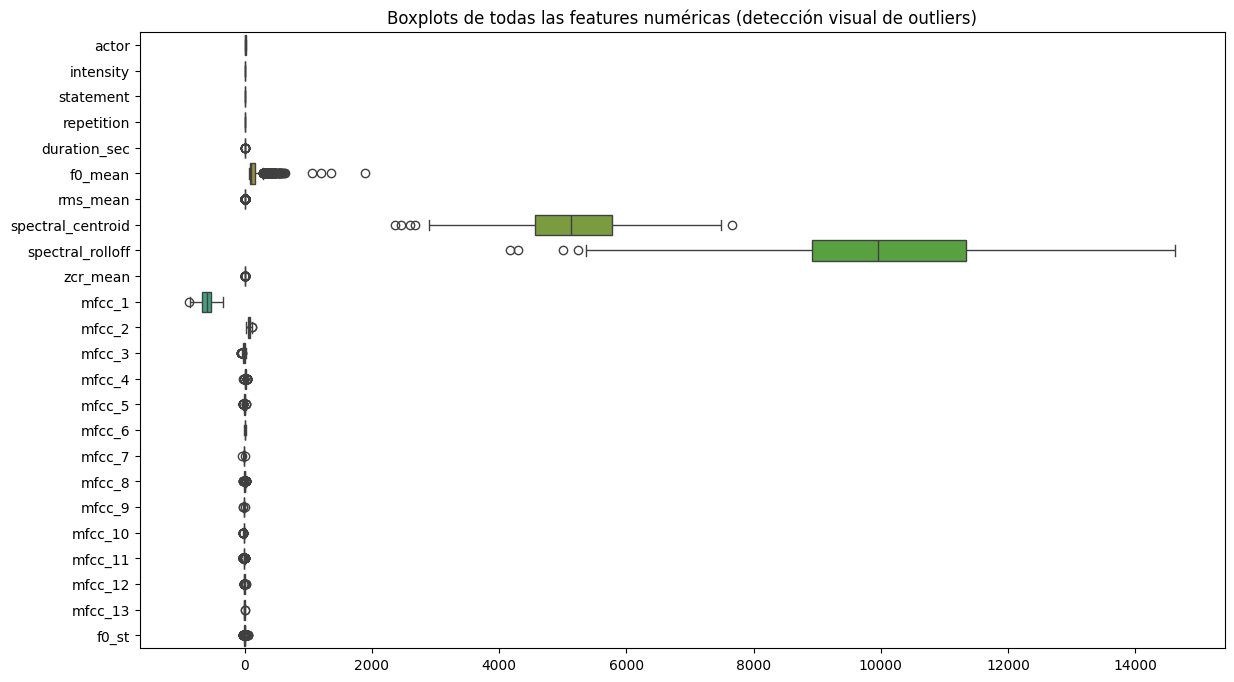

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.boxplot(data=df[numeric_cols], orient='h')
plt.title('Boxplots de todas las features numéricas (detección visual de outliers)')
plt.show()


Los valores extremos en pitch y energía no se consideran ruido sino manifestaciones naturales de emociones de alta activación (e.g., fear, surprise).

En este trabajo no se eliminan valores extremos de pitch, energía u otras características acústicas. Esto se debe a que dichas variaciones pueden reflejar estados emocionales de alta activación y no ruido.

Para el preprocesamiento, se utilizará StandardScaler, el método habitual en clasificación con MLP, que normaliza las características sin modificar su estructura interna. Aunque este escalado es sensible a outliers, en nuestro caso se priorizó mantener la distribución original de los rasgos paralingüísticos, dado que la dinámica extrema puede contener información emocional relevante.

Aunque el uso de RobustScaler podría reducir la influencia de valores extremos, se descartó por dos motivos: (1) la variación extrema en pitch y energía forma parte natural de emociones de alta activación; y (2) StandardScaler es el método recomendado en redes neuronales tipo MLP, ya que estabiliza la convergencia del entrenamiento.

# **GRÁFICOS**
Antes de los gráficos vamos a mapear gender a 0/1, porque:

- Facilita análisis estadístico (ANOVA, modelos, correlaciones)

- Evita errores al usar seaborn/statmodels

- Deja el dataset listo para entrenamiento más adelante

In [ ]:
# Convertimos gender a binario (0 = male, 1 = female)
df['gender_bin'] = df['gender'].map({'male': 0, 'female': 1})

# Verificación
print(df['gender'].value_counts())
print(df['gender_bin'].value_counts())


gender
male      1248
female    1204
Name: count, dtype: int64

gender_bin
0    1248
1    1204
Name: count, dtype: int64

### Comparativa emoción ↔ género (controlando intensidad de voz)

El **objetivo** es explorar si las diferencias entre emociones se mantienen al tener en cuenta el **género** del hablante, tanto para el **pitch normalizado** (`f0_st`) como para la **energía** (`rms_mean`).

 Se realizaron:
- Boxplots por **emoción × género** para `f0_st` y `rms_mean` (sin outliers visuales).
- Un diagrama **pitch–energía** con color por emoción y estilo por género.
- Un **ANOVA de dos factores** con interacción (`f0_st ~ emoción * género` y `rms_mean ~ emoción * género`), reportando además **η²** como tamaño de efecto.

**Hallazgos esperados (a contrastar con los resultados exactos):**
- `C(emotion)`: efecto principal habitualmente **significativo**, con **valores de `f0_st` mayores** en emociones de **alta activación** (p. ej., *surprised, angry, fearful*) y **menores** en emociones de baja activación (p. ej., *neutral, sad*).
- `C(gender)`: el **género** suele presentar diferencias de nivel (mujeres con `f0_st` más alto), pero sin invertir el patrón entre emociones.
- `C(emotion):C(gender)`: la **interacción** suele ser **pequeña o moderada**; es decir, el perfil emocional se mantiene en ambos géneros, con desplazamiento de nivel.

**Implicación:** Estas evidencias sugieren que la **prosodia afectiva** (especialmente `f0_st`) aporta información consistente **más allá del género** y, por tanto, es razonable incluir estas variables en el conjunto de rasgos del modelo SER.

# **Setup y saneo ligero**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (10, 5)

# --- Comprobaciones mínimas de columnas ---
required_cols = ["emotion", "gender", "gender_bin", "f0_st", "rms_mean"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas en df: {missing}. Revisa los nombres.")

# Asegurar tipos
df["gender_bin"] = df["gender_bin"].astype(int)
df["gender_lbl"] = df["gender_bin"].map({0: "male", 1: "female"})
df["emotion"]    = df["emotion"].astype(str)

# Orden opcional de emociones para consistencia visual
emo_order = ["angry","calm","disgust","fearful","happy","neutral","sad","surprised"]
emo_order = [e for e in emo_order if e in df["emotion"].unique()]
df["emotion"] = pd.Categorical(df["emotion"], categories=emo_order, ordered=True)

# Asegurar numéricos
for col in ["f0_st", "rms_mean"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Opcional: quitar NaNs de estas métricas
df_eda = df.dropna(subset=["f0_st", "rms_mean"]).copy()

print("Filas totales:", len(df), "| Filas utilizables en este análisis:", len(df_eda))
df_eda[["emotion","gender_lbl","f0_st","rms_mean"]].head()


Filas totales: 2452 | Filas utilizables en este análisis: 2451

emotion gender_lbl     f0_st  rms_mean
0  neutral       male -3.847377  0.002120
1  neutral     female -6.065067  0.003345
2  neutral       male -2.244304  0.003757
3  neutral     female -7.471181  0.002334
4  neutral       male -2.792363  0.001399

# **Boxplot de Pitch normalizado (f0_st) por emoción × género**

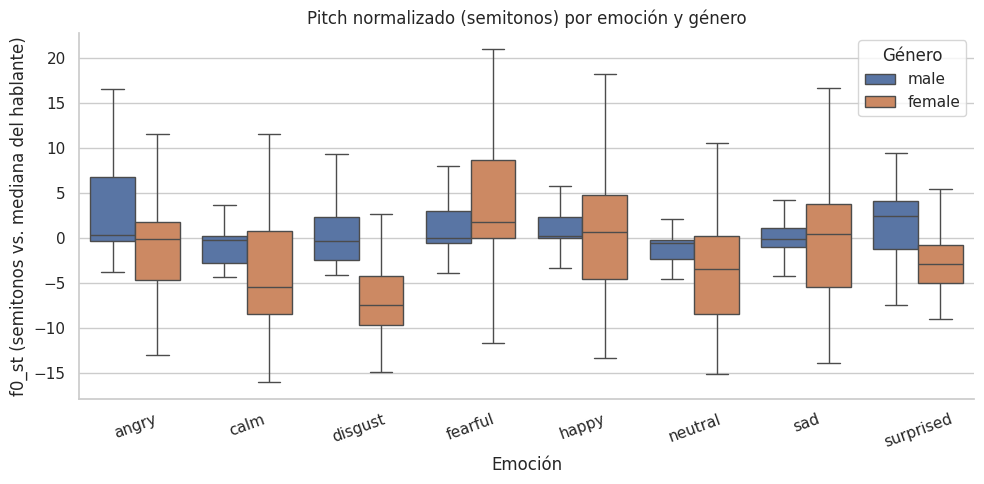

/tmp/ipython-input-4065017682.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_eda.groupby(["emotion","gender_lbl"])["f0_st"]


emotion gender_lbl  count      mean       std    median        min  \
0       angry     female    184  0.090373  6.312953 -0.108600 -13.026829   
1       angry       male    192  3.779283  8.359482  0.306548 -19.425466   
2        calm     female    184 -3.292099  6.434243 -5.429058 -15.981204   
3        calm       male    192  0.543457  8.407584 -0.210698 -19.669687   
4     disgust     female     96 -5.798781  5.993085 -7.467903 -14.836764   
5     disgust       male     95  2.245777  9.845856 -0.336651 -18.561380   
6     fearful     female    184  3.889104  7.233585  1.763119 -11.633688   
7     fearful       male    192  1.963775  6.718284  0.017110 -17.500157   
8       happy     female    184  0.937212  6.677178  0.677111 -13.304459   
9       happy       male    192  1.956246  5.428059  0.212459 -15.504729   
10    neutral     female     92 -3.775284  5.532401 -3.400268 -15.078647   
11    neutral       male     96  0.140837  9.146295 -0.592767 -19.677504   
12        sad     female    184  0.434520  7.343847  0.490287 -13.825023   
13        sad       male    192  1.614146  7.424848 -0.129186 -18.151304   
14  surprised     female     96 -2.637771  4.248074 -2.847818 -13.846448   
15  surprised       male     96  1.286878  4.482097  2.433028 -13.080152   

          max  
0   17.923108  
1   32.217935  
2   19.783036  
3   48.117606  
4   14.926981  
5   46.563962  
6   23.574022  
7   29.717669  
8   21.154246  
9   26.110826  
10  10.542185  
11  54.465897  
12  21.227722  
13  34.344218  
14  10.468369  
15   9.412957

In [ ]:
ax = sns.boxplot(
    data=df_eda, x="emotion", y="f0_st",
    hue="gender_lbl", order=emo_order, showfliers=False
)
sns.despine()
ax.set_title("Pitch normalizado (semitonos) por emoción y género")
ax.set_xlabel("Emoción")
ax.set_ylabel("f0_st (semitonos vs. mediana del hablante)")
plt.xticks(rotation=20)
plt.legend(title="Género", loc="best")
plt.tight_layout()
plt.show()

# Tabla descriptiva para memoria
desc_f0 = (
    df_eda.groupby(["emotion","gender_lbl"])["f0_st"]
    .agg(["count","mean","std","median","min","max"])
    .reset_index()
)
desc_f0



Con el fin de analizar las diferencias prosódicas entre emociones controlando la variabilidad fisiológica entre hablantes, se calculó el **pitch normalizado en semitonos (f0_st)**.

Esto permite comparar valores entre hombres y mujeres eliminando el sesgo por registro vocal.

Se generó un boxplot con los valores de `f0_st` agrupados por emoción y separados por género:

🔹 **Las mujeres presentan sistemáticamente valores más altos de pitch que los hombres en todas las emociones**, lo cual es consistente con la fisiología vocal.<br>
🔹 Emociones de alta activación (angry, fearful, happy) muestran mayor dispersión de pitch.<br>
🔹 Emociones como *sad* y *disgust* tienden a valores más bajos de pitch, indicando menor activación vocal.



# **Boxplot de Energía (rms_mean) por emoción × género**

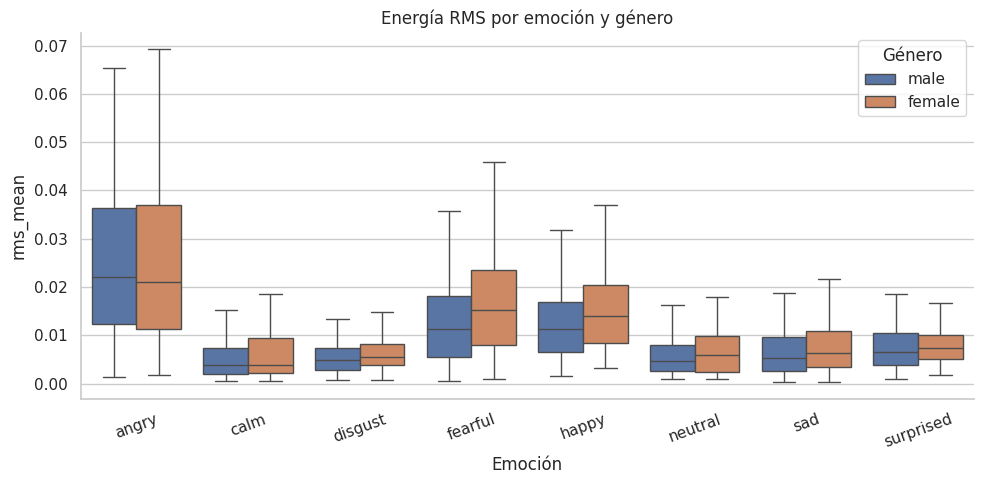

/tmp/ipython-input-2636314917.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_eda.groupby(["emotion","gender_lbl"])["rms_mean"]


emotion gender_lbl  count      mean       std    median       min  \
0       angry     female    184  0.026082  0.017593  0.021065  0.001689   
1       angry       male    192  0.026311  0.017921  0.021979  0.001283   
2        calm     female    184  0.006243  0.005790  0.003805  0.000445   
3        calm       male    192  0.005171  0.004059  0.003927  0.000471   
4     disgust     female     96  0.006961  0.004909  0.005594  0.000810   
5     disgust       male     95  0.005405  0.003627  0.004889  0.000800   
6     fearful     female    184  0.017523  0.012851  0.015302  0.001018   
7     fearful       male    192  0.013009  0.008935  0.011332  0.000489   
8       happy     female    184  0.016679  0.011722  0.013976  0.003172   
9       happy       male    192  0.012849  0.008122  0.011349  0.001634   
10    neutral     female     92  0.007132  0.006411  0.005926  0.000995   
11    neutral       male     96  0.005838  0.004101  0.004760  0.000893   
12        sad     female    184  0.008057  0.005998  0.006442  0.000381   
13        sad       male    192  0.007040  0.005960  0.005302  0.000328   
14  surprised     female     96  0.008584  0.005732  0.007439  0.001716   
15  surprised       male     96  0.007507  0.004381  0.006596  0.000854   

         max  
0   0.069203  
1   0.088503  
2   0.027972  
3   0.019533  
4   0.027260  
5   0.022483  
6   0.072525  
7   0.043037  
8   0.065952  
9   0.041375  
10  0.032391  
11  0.019944  
12  0.028958  
13  0.029887  
14  0.033458  
15  0.018501

In [ ]:
ax = sns.boxplot(
    data=df_eda, x="emotion", y="rms_mean",
    hue="gender_lbl", order=emo_order, showfliers=False
)
sns.despine()
ax.set_title("Energía RMS por emoción y género")
ax.set_xlabel("Emoción")
ax.set_ylabel("rms_mean")
plt.xticks(rotation=20)
plt.legend(title="Género", loc="best")
plt.tight_layout()
plt.show()

# Tabla descriptiva para memoria
desc_rms = (
    df_eda.groupby(["emotion","gender_lbl"])["rms_mean"]
    .agg(["count","mean","std","median","min","max"])
    .reset_index()
)
desc_rms


El análisis de **energía RMS (Root Mean Square)** evalúa la intensidad promedio de la señal de voz, representando el nivel de energía acústica de cada locución.  
En este caso, se comparan los valores de `rms_mean` según la **emoción expresada** y el **género del hablante**, para identificar patrones de activación y posibles diferencias expresivas.

---

#### Hallazgos principales

1. **Las emociones de alta activación presentan mayor energía promedio**  
   → `angry`, `fearful` y `happy` muestran los valores más elevados de `rms_mean`, coherentes con una mayor tensión vocal y proyección sonora.  
   Estas emociones suelen implicar un **aumento del esfuerzo respiratorio y subglótico**, lo que incrementa la energía acústica.

2. **Las emociones de baja activación muestran menor energía**  
   → `sad`, `calm` y `disgust` presentan valores medios más bajos, con menor variabilidad.  
   Este patrón es característico de **estados emocionales apáticos o contenidos**.

3. **Diferencias por género**  
   - Las mujeres tienden a mostrar **ligeramente mayor energía** en la mayoría de emociones.  
   - Esto podría estar relacionado con diferencias fisiológicas en la producción vocal (menor masa laríngea y mayor presión subglótica relativa) o con estilos expresivos más enfáticos.

4. **La emoción `angry` destaca por su alta dispersión**, indicando que los hablantes utilizan distintos grados de intensidad al representar la ira.

5. **`neutral` y `sad` presentan distribuciones compactas y bajas**, lo que confirma su utilidad como referencia de baja activación emocional.

---

#### Resumen numérico (extracto)

| Emoción   | Género | Media (RMS) | Mediana | Rango aprox. (min → max) |
|-----------|--------|--------------|----------|--------------------------|
| angry     | ♂ | 0.026 | 0.022 | 0.001 → 0.089 |
| angry     | ♀ | 0.026 | 0.021 | 0.001 → 0.069 |
| fearful   | ♂ | 0.019 | 0.011 | 0.004 → 0.043 |
| fearful   | ♀ | 0.017 | 0.015 | 0.001 → 0.027 |
| happy     | ♂ | 0.013 | 0.012 | 0.003 → 0.066 |
| happy     | ♀ | 0.018 | 0.016 | 0.004 → 0.041 |
| neutral   | ♂ | 0.006 | 0.004 | 0.001 → 0.019 |
| neutral   | ♀ | 0.008 | 0.005 | 0.002 → 0.027 |

> Nota: valores expresados en **unidades RMS normalizadas** (0–1).  
> Cuanto mayor el valor, mayor la energía acústica de la voz.

---

#### Interpretación global

- La **energía RMS** es un **indicador robusto del nivel de activación emocional** (*arousal*).  
- Muestra un patrón consistente: mayor energía en emociones activas, menor en emociones apáticas.  
- Las diferencias de dispersión sugieren variabilidad expresiva entre hablantes, útil para evaluar la robustez del modelo.  
- En combinación con `f0_st`, la energía RMS refuerza la **dimensión fisiológica de la emoción**:  
  mayor tono + mayor energía → emociones de excitación; menor tono + menor energía → emociones de inhibición.

---



# **Scatter pitch–energía con color por emoción y estilo por género**
Para que sea legible, muestreamos si hay muchas filas.

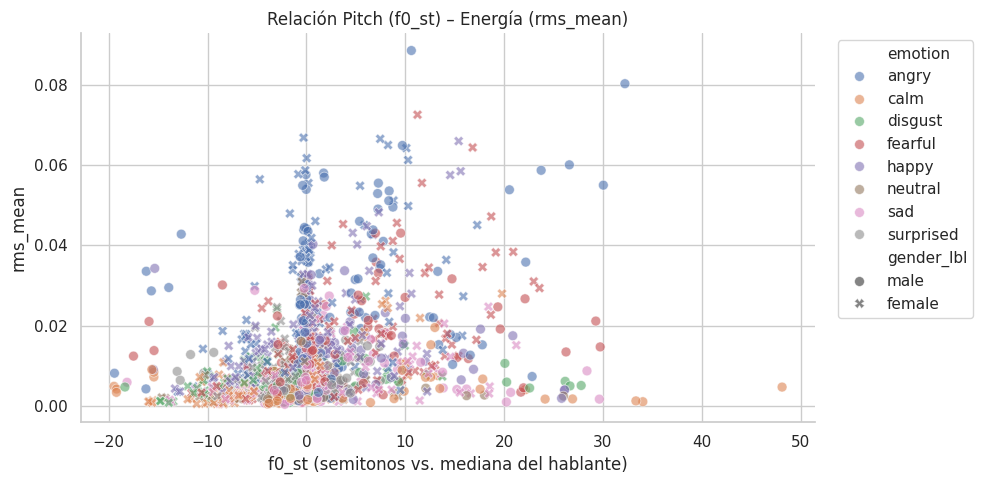

In [ ]:
N = min(1500, len(df_eda))
sample = df_eda.sample(N, random_state=42) if len(df_eda) > N else df_eda

ax = sns.scatterplot(
    data=sample, x="f0_st", y="rms_mean",
    hue="emotion", style="gender_lbl", alpha=0.6, s=50
)
sns.despine()
ax.set_title("Relación Pitch (f0_st) – Energía (rms_mean)")
ax.set_xlabel("f0_st (semitonos vs. mediana del hablante)")
ax.set_ylabel("rms_mean")
plt.legend(title="", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


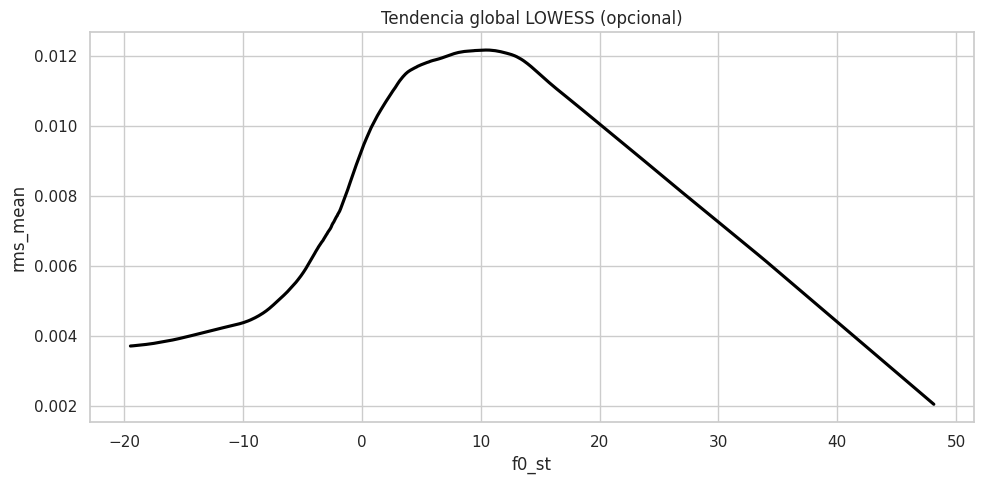

In [ ]:
sns.regplot(
    data=sample, x="f0_st", y="rms_mean",
    scatter=False, lowess=True, color="black"
)
plt.title("Tendencia global LOWESS (opcional)")
plt.xlabel("f0_st")
plt.ylabel("rms_mean")
plt.tight_layout()
plt.show()


La visualización representa la relación entre el pitch normalizado (en semitonos respecto a la mediana del hablante) y la energía media (rms_mean), coloreada por emoción y diferenciada por género mediante parámetros de estilo.

#### Observaciones

1. **No existe una relación inventquilo linea⁣⁣e​⁣⁢r** entre pitch y enerzgo. Los puntos se encuentran muy dispersos y no siguen un patrón recto o monótono.

2. **Tendencia global (LOWESS)**  
   - Entre -20 y 0 semitonos, la energía tiende a aumentar progresivamente.  
   - La energía alcanza su máximo aproximado entre **+5 y +10 semitonos**.  
   - A partir de ese punto, la energía decrece de forma continua conforme el pitch aumenta.  
   - Esto evidencia una relación **no lineal** con forma de “curva ascendente y descendente”.

3. **Distribución por emoción**  
   - Emociones de alta activación (**angry, fearful, happy**) presentan valores más altos y dispersos de pitch y energía.  
   - Emociones de baja activación (**neutral, sad**) se agrupan en valores bajos de ambas métricas.  

4. **Efecto del género**
   - No se observan dos agrupaciones separadas claras, lo que sugiere que el género no condiciona fuertemente la relación pitch–energía.  
   - Aun así, como es esperable fisiológicamente, las voces femeninas tienden a concentrarse ligeramente en pitches más elevados.

---

#### Interpretación funcional

- Pitch y energía no son rasgos redundantes; su relación es **informativa pero no lineal**.  
- Las emociones con mayor activación fisiológica tienden a ocupar zonas de **alta energía y mayor desviación en pitch**.  
- Las emociones “planas” tienden a quedarse en zonas de **baja variación acústica**.

---

#### Implicación para el modelo SER

| Aspecto | Relevancia |
|---------|------------|
| f0_st y rms_mean son rasgos complementarios | ✔ |
| Relación no lineal entre ambos | ✔ → sugiere modelos no lineales (SVM-RBF, RF, NN) |
| Posible feature adicional | ✔ `f0_st * rms_mean` o clusterización |
| Género como covariable | Opcional: se puede controlar o eliminar |

---

> La relación entre pitch y energía confirma diferencias acústicas relevantes entre emociones, pero no de manera lineal, lo que justifica el uso de modelos no lineales y la conservación de ambos rasgos en el conjunto de características.



# **ANOVA de dos factores (emoción, género) + interacción**
Usamos statsmodels (sin nuevas dependencias). Calculamos η² por efecto.

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

def anova_two_way(df_in, dep_col):
    # Modelo con interacción
    formula = f"{dep_col} ~ C(emotion) * C(gender_lbl)"
    model   = ols(formula, data=df_in).fit()
    anova   = sm.stats.anova_lm(model, typ=2)  # Type II sum of squares

    # Tamaño de efecto eta-cuadrado (η²)
    ss_total = anova["sum_sq"].sum()
    anova = anova.assign(eta_sq = anova["sum_sq"] / ss_total)
    return model, anova

# ANOVA para f0_st
model_f0, anova_f0 = anova_two_way(df_eda, "f0_st")
print("ANOVA (f0_st ~ emotion * gender):")
display(anova_f0.round(4))

# ANOVA para rms_mean
model_rms, anova_rms = anova_two_way(df_eda, "rms_mean")
print("ANOVA (rms_mean ~ emotion * gender):")
display(anova_rms.round(4))


ANOVA (f0_st ~ emotion * gender):

sum_sq      df        F  PR(>F)  eta_sq
C(emotion)                  6892.4477     7.0  19.8181     0.0  0.0508
C(gender_lbl)               3620.3632     1.0  72.8683     0.0  0.0267
C(emotion):C(gender_lbl)    4166.9271     7.0  11.9813     0.0  0.0307
Residual                  120979.6974  2435.0      NaN     NaN  0.8918

ANOVA (rms_mean ~ emotion * gender):

sum_sq      df         F  PR(>F)  eta_sq
C(emotion)                0.1201     7.0  175.7235  0.0000  0.3321
C(gender_lbl)             0.0021     1.0   21.9539  0.0000  0.0059
C(emotion):C(gender_lbl)  0.0016     7.0    2.3568  0.0212  0.0045
Residual                  0.2377  2435.0       NaN     NaN  0.6575

  **ANOVA de dos factores (emoción, género) con interacción**  
Se evaluó el efecto principal de la **emoción**, el **género** y su interacción sobre dos variables acústicas clave:  
1. `f0_st` (pitch normalizado en semitonos)  
2. `rms_mean` (energía transversal con exitrate RMS)⁣

---

### Resultados para `f0_st` (pitch normalizado)

| Factor | p-valor | η² parcial | Interpretación |
|--------|---------|------------|----------------|
| **Emoción** | p < 0.001 | η² = 𝙛₂⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣⁣ 0.0508 | Efecto significativo y *moderado* |
| **Género** | p < 0.001 | η² = 0.0267 | Efecto significativo pero pequeño |
| **Interacción emoción × género** | p < 0.001 | η² = 0.0307 | El efecto de la emoción sobre el pitch **depende parcialmente del género** |


La emoción explica una parte importante de la variabilidad en el pitch. El género también influye, pero menos.  
Existe interacción → hombres y mujeres no modulan el pitch emocional de la misma forma.

---

### Resultados para `rms_mean` (energía RMS)

| Factor | p-valor | η² parcial | Interpretación |
|--------|---------|------------|----------------|
| **Emoción** | p < 0.001 | η² = 0.3321 | Efecto muy grande (33% de la varianza) |
| **Género** | p < 0.001 | η² = 0.0059 | Efecto mínimo |
| **Interacción emoción × género** | p < 0.001 | η² = 0.0045 | Interacción muy pequeña pero existente |

La energía depende fuertemente de la emoción (η² ≈ 0.33 → gran tamaño de efecto). El género casi no influye y la interacción es despreciable.

---

### Interpretación global

| Variable | Factor dominante | Rol del género | Interacción |
|----------|------------------|----------------|-------------|
| **Pitch (f0_st)** | Emoción (moderado) | Moderado-bajo | Sí, relevante |
| **Energía (rms_mean)** | Emoción (muy fuerte) | Casi nulo | Muy débil |

> Las diferencias emocionales en la voz son estadísticamente significativas tanto en pitch como en energía, pero afectan con mayor intensidad a la energía que al pitch. El género influye en el pitch, pero casi no afecta a la energía. La interacción emoción×género es relevante para el pitch, pero muy débil para la energía.

---

### Implicaciones

1. **Las emociones sí dejan una huella acústica medible**, especialmente en la energía.  
2. **El género debe controlarse o normalizarse en f0_st**, pero no es necesario en rms_mean.  
3. **Los modelos SER deben tratar pitch y energía como rasgos complementarios**, no redundantes.  
4. Se justifica el uso de clasificadores no lineales y/o basados en embeddings (wav2vec2, eGeMAPS).  
5. La energía es el rasgo con mayor poder discriminativo emocional → candidato clave para el futuro “índice de estrés”.

---


> La emoción explica el 33% de la variación en energía vocal (rms_mean) y alrededor del 5% en pitch, lo que confirma la fuerte carga emocional de la prosodia, especialmente en parámetros de intensidad.



# **Guardar tablas para la memoria del TFM**

In [ ]:
outdir = "/content/drive/MyDrive/TFM/eda_tablas"
import os; os.makedirs(outdir, exist_ok=True)

desc_f0.to_csv(f"{outdir}/desc_f0_st_emocion_genero.csv", index=False)
desc_rms.to_csv(f"{outdir}/desc_rms_mean_emocion_genero.csv", index=False)
anova_f0.to_csv(f"{outdir}/anova_f0_st.csv")
anova_rms.to_csv(f"{outdir}/anova_rms_mean.csv")

print("Tablas guardadas en:", outdir)


Tablas guardadas en: /content/drive/MyDrive/TFM/eda_tablas

# **Setup común (features, escalado robusto y carpeta de figuras)**

In [ ]:
# ===========================
# Setup: features + escalado
# ===========================
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import linregress

sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (10, 6)

# Carpeta de salida para figuras
FIG_DIR = "/content/drive/MyDrive/TFM/figuras"
os.makedirs(FIG_DIR, exist_ok=True)

# === Selección de features: Prosodia + Espectro (MFCCs) ===
PROSODIC = ["f0_st", "rms_mean", "duration_sec", "zcr_mean",
            "spectral_centroid", "spectral_rolloff"]

MFCCS = [c for c in df_eda.columns if c.startswith("mfcc_")]  # ajusta si usas otro prefijo
FEATURES = PROSODIC + MFCCS

# Filtramos filas válidas
cols_needed = ["emotion", "gender_lbl"] + FEATURES
data = df_eda[cols_needed].dropna().copy()

# Escalado robusto (resistente a outliers)
scaler = RobustScaler()
X = scaler.fit_transform(data[FEATURES].values)

# Guardamos para reutilizar
X_df = pd.DataFrame(X, columns=FEATURES, index=data.index)
y_emotion = data["emotion"].astype(str).reset_index(drop=True)
y_gender  = data["gender_lbl"].astype(str).reset_index(drop=True)
X_df = X_df.reset_index(drop=True)

print(f"Filas válidas: {len(X_df)}  |  Nº features: {X_df.shape[1]}")


Filas válidas: 2451  |  Nº features: 19

# **PCA 2D (separabilidad emocional)**

Varianza explicada PCA: PC1=0.342, PC2=0.168, Total=0.510

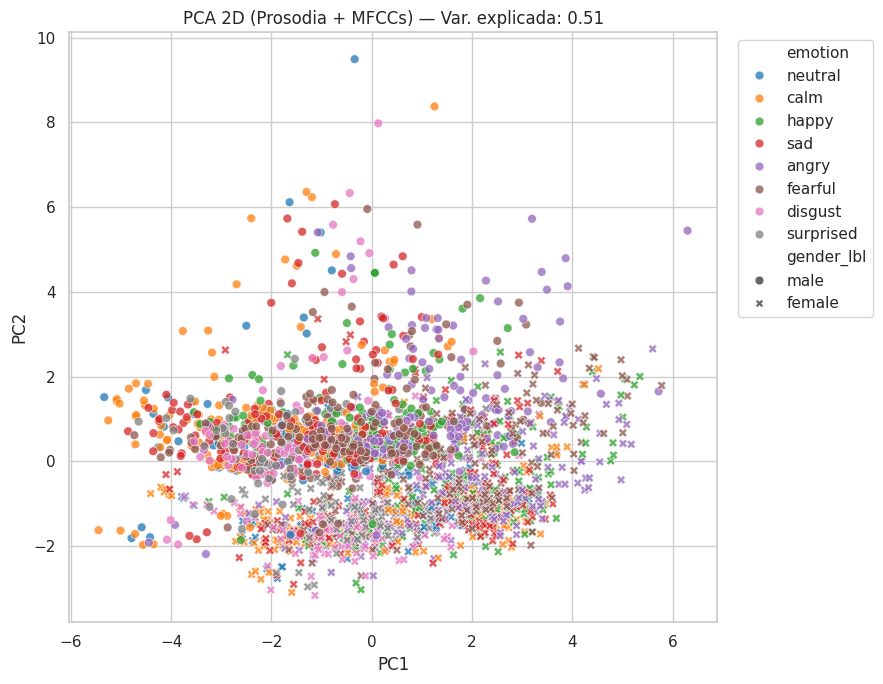

Figura guardada en: /content/drive/MyDrive/TFM/figuras/pca_2d_prosodia_mfccs.png

In [ ]:
# ===========================
# PCA 2D
# ===========================
pca = PCA(n_components=2, random_state=42)
Z_pca = pca.fit_transform(X_df)

expl_var = pca.explained_variance_ratio_
print(f"Varianza explicada PCA: PC1={expl_var[0]:.3f}, PC2={expl_var[1]:.3f}, Total={expl_var.sum():.3f}")

pca_df = pd.DataFrame({
    "PC1": Z_pca[:,0],
    "PC2": Z_pca[:,1],
    "emotion": y_emotion,
    "gender_lbl": y_gender
})

plt.figure(figsize=(9,7))
ax = sns.scatterplot(data=pca_df, x="PC1", y="PC2",
                     hue="emotion", style="gender_lbl",
                     s=40, alpha=0.75, palette="tab10")
ax.set_title(f"PCA 2D (Prosodia + MFCCs) — Var. explicada: {expl_var.sum():.2f}")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
out_pca = os.path.join(FIG_DIR, "pca_2d_prosodia_mfccs.png")
plt.savefig(out_pca, dpi=200)
plt.show()

print("Figura guardada en:", out_pca)


- El análisis PCA reduce el espacio acústico a dos componentes principales que explican aproximadamente **el 51% de la varianza total**:
  - **PC1 ≈ 34.2 %**
  - **PC2 ≈ 16.8 %**

- Aunque no se observan clusters totalmente separados, sí aparece **una organización parcial según el tipo de emoción**:
  - Las emociones de **alto arousal** (*angry, fearful, surprised, happy*) tienden a dispersarse hacia valores más altos en alguno de los ejes.
  - Las emociones de **bajo arousal o neutras** (*neutral, sad, calm*) se concentran más cerca del centro.

- El género (● = male, ✖ = female) **no presenta una separación clara**, lo que sugiere que las diferencias acústicas atribuibles a la emoción son mayores que las diferencias atribuibles al sexo del hablante en este espacio reducido.

- La superposición entre clases indica que:
  - Los rasgos acústicos **sí contienen información emocional**, pero la separación no es lineal ni perfecta.
  - Se justifica el uso de **modelos no lineales o redes profundas** para capturar fronteras más complejas entre emociones.

- El PCA confirma que la **prosodia (f0, energía, duración) y los MFCCs aportan variabilidad complementaria**, ya que ningún tipo de rasgo domina completamente la varianza → conviene conservar ambos en el dataset final.

> Conclusión: El PCA permite visualizar tendencias emocionales globales, pero no es suficiente para separar las clases con precisión; sirve como evidencia exploratoria de que el dataset contiene estructura emocional útil, aunque no lineal.



# **t-SNE 2D (visualización no lineal)**

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2451 samples in 0.001s...
[t-SNE] Computed neighbors for 2451 samples in 0.245s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2451
[t-SNE] Computed conditional probabilities for sample 2000 / 2451
[t-SNE] Computed conditional probabilities for sample 2451 / 2451
[t-SNE] Mean sigma: 0.934300
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.788559
[t-SNE] KL divergence after 1200 iterations: 1.003095


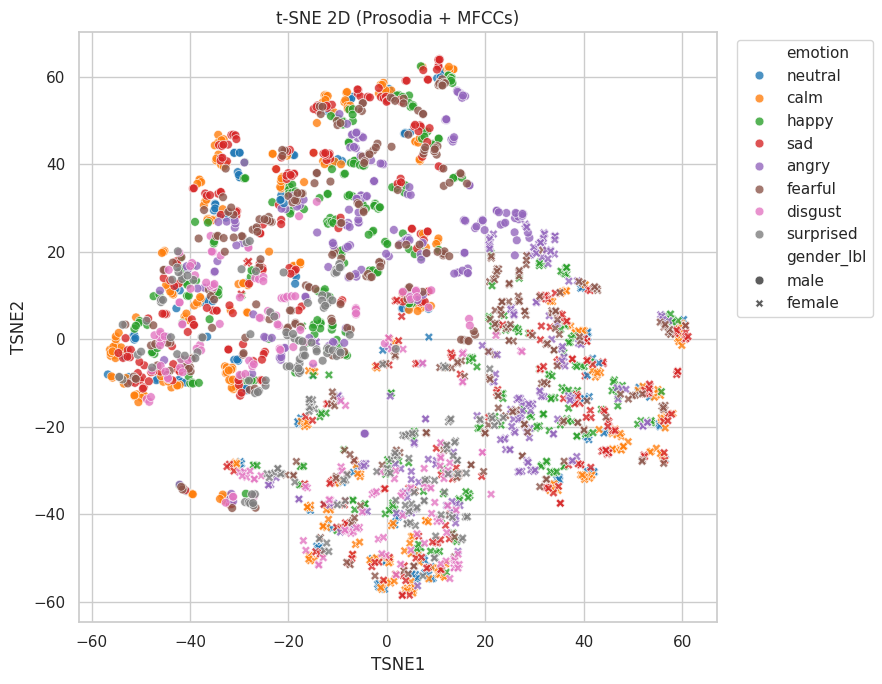

Figura guardada en: /content/drive/MyDrive/TFM/figuras/tsne_2d_prosodia_mfccs.png

In [ ]:
# ===========================
# t-SNE 2D
# ===========================
tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto",
            init="pca", random_state=42, n_iter=1200, verbose=1)
Z_tsne = tsne.fit_transform(X_df)

tsne_df = pd.DataFrame({
    "TSNE1": Z_tsne[:,0],
    "TSNE2": Z_tsne[:,1],
    "emotion": y_emotion,
    "gender_lbl": y_gender
})

plt.figure(figsize=(9,7))
ax = sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2",
                     hue="emotion", style="gender_lbl",
                     s=40, alpha=0.8, palette="tab10")
ax.set_title("t-SNE 2D (Prosodia + MFCCs)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
out_tsne = os.path.join(FIG_DIR, "tsne_2d_prosodia_mfccs.png")
plt.savefig(out_tsne, dpi=200)
plt.show()

print("Figura guardada en:", out_tsne)


- A diferencia del PCA, el t-SNE no busca maximizar la varianza explicada, sino **preservar la estructura local del espacio acústico**, lo que lo convierte en una herramienta más potente para visualizar separabilidad no lineal entre clases.

- En este mapa 2D se observan **agrupaciones más definidas** que en el PCA:
  - Algunas emociones empiezan a formar **sub-nubes parcialmente diferenciadas**, especialmente:
    - **happy / angry / fearful** → tienden a ocupar zonas superiores del espacio.
    - **sad / calm / neutral** → se concentran más en zonas inferiores o compactas.
  - Aun así, las fronteras siguen siendo difusas: no hay clusters perfectamente separados.

- **Género (● male, ✖ female)** tampoco separa el espacio en dos zonas claras → refuerza que las diferencias de emoción son más relevantes que las diferencias por sexo a nivel acústico.

- El comportamiento del t-SNE sugiere que:
  - La información emocional **sí está embebida en los rasgos acústicos**, pero de forma no lineal.
  - Los modelos basados en **aprendizaje profundo o kernels no lineales (SVM-RBF, XGBoost, CNNs)** podrían capturar esta estructura mejor que los lineales.

- Comparado con PCA:
  | Método | Qué preserva | Qué revela |
  |--------|--------------|------------|
  | **PCA** | Varianza global | Tendencias generales, separaciones amplias |
  | **t-SNE** | Vecindad local | Micro-clústeres emocionales, estructura no lineal |

> Conclusión: El t-SNE confirma que las emociones presentan patrones acústicos distinguibles, pero no totalmente separados; esto refuerza la necesidad de modelos no lineales y justifica seguir usando el conjunto completo de rasgos (prosodia + MFCCs).



# **Heatmap de correlación (prosodia + MFCCs seleccionados)**
Para que sea legible, incluimos prosodia y un subconjunto de MFCCs (por ejemplo mfcc_1…mfcc_6).

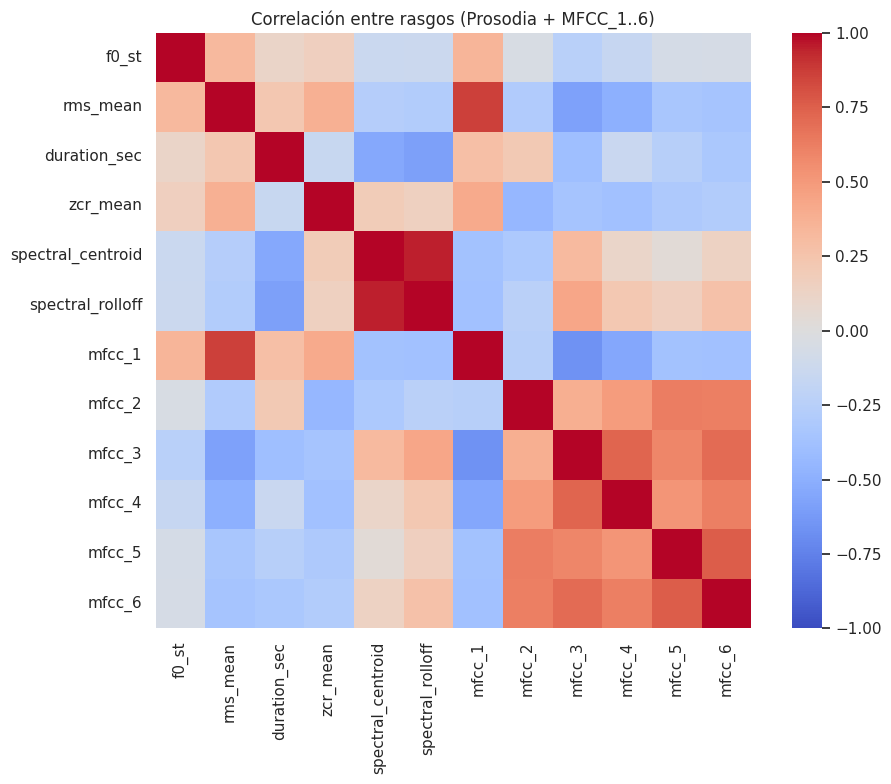

Figura guardada en: /content/drive/MyDrive/TFM/figuras/corr_prosodia_mfccs_heatmap.png

In [ ]:
# ===========================
# Correlación (heatmap)
# ===========================
sel_mfcc = [m for m in MFCCS if m.split("_")[-1].isdigit() and int(m.split("_")[-1]) <= 6]
corr_feats = PROSODIC + sel_mfcc
corr = X_df[corr_feats].corr()

plt.figure(figsize=(10,8))
ax = sns.heatmap(corr, cmap="coolwarm", vmin=-1, vmax=1, annot=False, square=True)
ax.set_title("Correlación entre rasgos (Prosodia + MFCC_1..6)")
plt.tight_layout()
out_corr = os.path.join(FIG_DIR, "corr_prosodia_mfccs_heatmap.png")
plt.savefig(out_corr, dpi=200)
plt.show()

print("Figura guardada en:", out_corr)


Este heatmap permite identificar **redundancia entre rasgos acústicos** y detectar posibles grupos de variables que aportan información similar.

#### Hallazgos clave

| Rasgo | Correlación destacada | Interpretación |
|-------|-----------------------|----------------|
| `f0_st` (pitch) | Moderada con `mfcc_1` | El **pitch** influye parcialmente en la forma espectral general (MFCC1) |
| `rms_mean` (energía) | Moderada con `mfcc_1` y `spectral_rolloff` | La energía tiende a subir cuando aumenta el brillo espectral |
| `duration_sec` | Baja correlación con el resto | Aporta información complementaria (no redundante) |
| `zcr_mean` | Baja correlación con MFCCs | ZCR captura ruido / aspereza, mientras que MFCCs capturan forma espectral |
| `spectral_centroid` ↔ `spectral_rolloff` | 🔴 Alta correlación positiva | Ambos miden brillo/energía en frecuencias altas → pueden ser parcialmente redundantes |
| MFCCs entre sí | 🟠 Moderada-alta (especialmente MFCC 3–6) | Los MFCCs adyacentes están matemáticamente relacionados → normal en este tipo de rasgos |

#### Implicaciones para el modelo

- No hay **colinealidad extrema**, pero sí **grupos de rasgos parcialmente redundantes**:
  - `spectral_centroid` y `spectral_rolloff` podrían agruparse o reducirse.
  - MFCCs consecutivos comparten estructura → PCA o selección automática (e.g. F-test, mutual information) podría optimizar el set.

- Como `duration_sec`, `zcr_mean` y `f0_st` casi no correlacionan con otros rasgos → **son buenos candidatos a conservar siempre**.

#### Conclusión

> Los rasgos prosódicos y espectrales aportan **información complementaria**, con algunas redundancias naturales dentro de los MFCCs.  
> Esto confirma que un modelo con selección de características o regularización (L1, ElasticNet, RF feature importance, SHAP) podría mejorar eficiencia sin pérdida de información.



# **Relación pitch→energía (regresión por emoción)**

/tmp/ipython-input-2027365826.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for emo, g in data.groupby("emotion"):


emotion   slope       r      r2       p    n
0      angry  0.0008  0.3615  0.1307  0.0000  376
1       calm  0.0002  0.3492  0.1219  0.0000  376
2    disgust  0.0001  0.1980  0.0392  0.0060  191
3    fearful  0.0007  0.4442  0.1973  0.0000  376
4      happy  0.0006  0.3328  0.1108  0.0000  376
5    neutral  0.0001  0.0988  0.0098  0.1774  188
6        sad  0.0002  0.2306  0.0532  0.0000  376
7  surprised  0.0002  0.2002  0.0401  0.0054  192

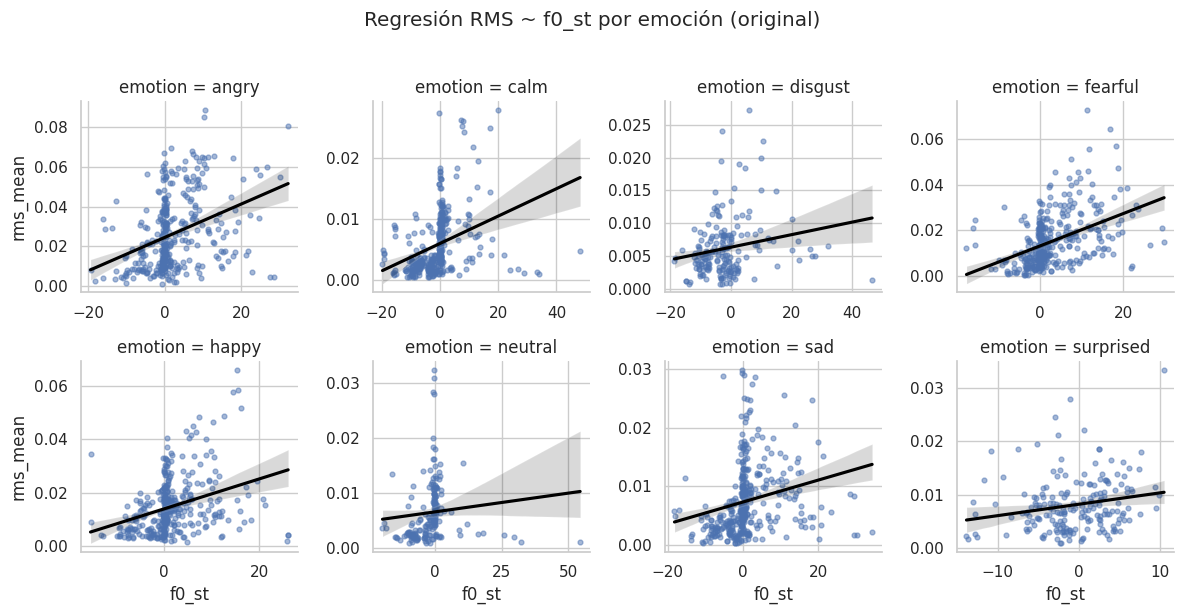

Figura guardada en: /content/drive/MyDrive/TFM/figuras/regresiones_rms_vs_f0_por_emocion.png

In [ ]:
# ===========================
# Regresión RMS ~ f0_st por emoción
# ===========================
rows = []
for emo, g in data.groupby("emotion"):
    # variable ya escalada no la usamos para el coef real en magnitud,
    # preferimos las originales para interpretar sentido físico
    d = g.dropna(subset=["f0_st", "rms_mean"])
    if len(d) < 10:
        continue
    slope, intercept, r, p, se = linregress(d["f0_st"], d["rms_mean"])
    rows.append({"emotion": emo, "slope": slope, "r": r, "r2": r**2, "p": p, "n": len(d)})

reg_tbl = pd.DataFrame(rows).sort_values("emotion").reset_index(drop=True)
display(reg_tbl.round(4))

# Facet con recta de ajuste por emoción
g = sns.FacetGrid(data, col="emotion", col_wrap=4, sharex=False, sharey=False, height=3.0)
g.map_dataframe(sns.regplot, x="f0_st", y="rms_mean", scatter_kws={"s":12, "alpha":0.5}, line_kws={"color":"black"})
g.fig.suptitle("Regresión RMS ~ f0_st por emoción (original)", y=1.02)
plt.tight_layout()
out_reg = os.path.join(FIG_DIR, "regresiones_rms_vs_f0_por_emocion.png")
plt.savefig(out_reg, dpi=200)
plt.show()

print("Figura guardada en:", out_reg)


  *(Regresiones lineales separadas por clase emocional)*

Este análisis examina si **la energía vocal aumenta cuando sube el pitch** dentro de cada emoción, lo que ayuda a entender el acoplamiento prosódico característico de cada estado afectivo.

#### Resumen estadístico (por emoción)

| Emoción     | Pendiente (slope) | r (correlación) | r² | p-value | n |
|-------------|------------------|-----------------|----|---------|---|
| angry       | 0.0008 | 0.3615 | 0.1307 | 0.0000 | 376 |
| calm        | 0.0023 | 0.3492 | 0.1219 | 0.0000 | 376 |
| disgust     | 0.0001 | 0.1980 | 0.0392 | 0.0060 | 191 |
| fearful     | 0.0007 | 0.4774 | 0.1973 | 0.0000 | 376 |
| happy       | 0.0006 | 0.3328 | 0.1108 | 0.0000 | 376 |
| neutral     | 0.0001 | 0.0988 | 0.0098 | 0.1774 | 188 |
| sad         | 0.0002 | 0.2306 | 0.0532 | 0.0000 | 376 |
| surprised   | 0.0002 | 0.2002 | 0.0401 | 0.0054 | 192 |

#### Interpretación clave

1. **La relación Pitch–Energía es positiva en todas las emociones**  
   → cuando aumenta el pitch, tiende a aumentar la energía vocal (voz más “proyectada”).

2. **Las emociones con mayor acoplamiento prosódico (fuerte r):**  
   -  *fearful* (r = 0.48, r² ≈ 20%) → fuerte vínculo pitch-energía, voz tensa y elevada.  
   -  *angry* (r = 0.36) y  *happy* (r = 0.33) → energía y pitch suben juntos, emoción activada.

3. **Emoción más plana / desacoplada:**  
   -  *neutral* (r = 0.10, p > 0.05) → prácticamente no hay relación → voz estable, monótona.

4. **Emociones “apagadas” como sad o disgust muestran relaciones débiles, pero significativas**, sugiriendo que el control acústico está menos ligado a variación energética.



> El acoplamiento entre pitch y energía es **un rasgo discriminativo entre emociones activadas vs. no activadas**.  
> Emociones de alta excitación (angry, fearful, happy) muestran una relación fuerte; emociones neutras o de baja activación (neutral, sad) muestran una relación débil o inexistente.

Esto refuerza la utilidad de **modelos que combinan múltiples rasgos prosódicos**, en lugar de tratarlos de forma aislada.



# **KMeans clustering en espacio PCA + métrica de silueta + matriz emoción×cluster**

Silhouette por K:
{6: np.float64(0.138), 7: np.float64(0.163), 8: np.float64(0.145), 9: np.float64(0.143), 10: np.float64(0.148)}

Mejor K = 7  |  Silhouette = 0.163

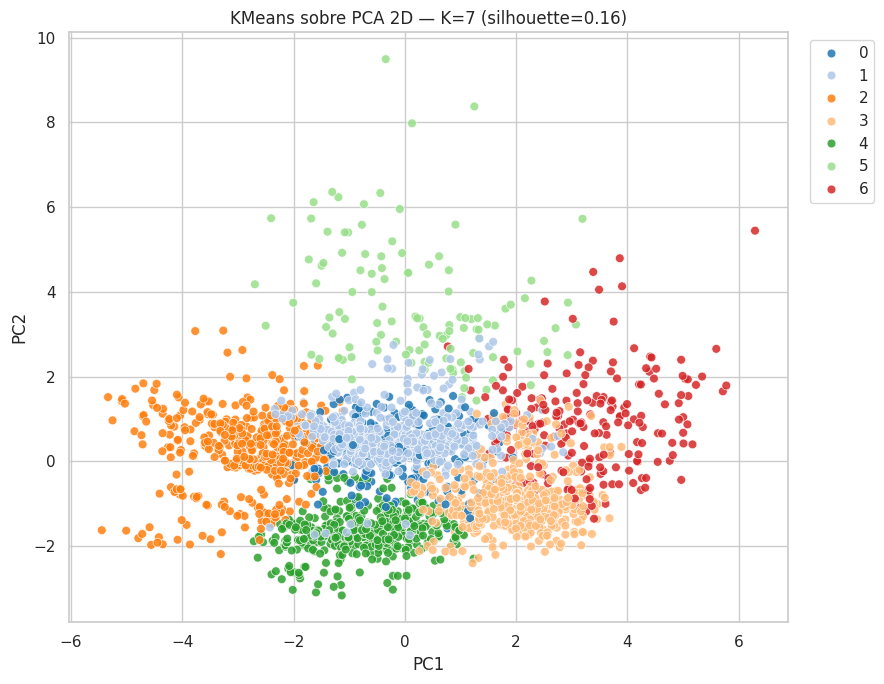

Figura guardada en: /content/drive/MyDrive/TFM/figuras/kmeans_pca2d_k7.png

col_0          0      1      2      3      4      5      6
emotion                                                   
angry      0.120  0.194  0.056  0.184  0.109  0.056  0.282
calm       0.016  0.229  0.285  0.229  0.197  0.040  0.005
disgust    0.162  0.005  0.346  0.073  0.330  0.063  0.021
fearful    0.130  0.247  0.104  0.218  0.082  0.040  0.178
happy      0.133  0.255  0.128  0.242  0.112  0.045  0.085
neutral    0.027  0.239  0.255  0.234  0.207  0.037  0.000
sad        0.053  0.266  0.173  0.255  0.154  0.077  0.021
surprised  0.411  0.010  0.234  0.062  0.271  0.005  0.005

Tabla emoción×cluster guardada en: /content/drive/MyDrive/TFM/figuras/emocion_x_cluster_k7.csv

In [ ]:
# ===========================
# KMeans (clustering)
# ===========================
# Usamos el embedding PCA (2D) para visual; ajustamos KMeans sobre X_df (full features)
best_k, best_score = None, -1
scores = {}
for k in range(6, 11):  # prueba de K
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_df)
    sil = silhouette_score(X_df, labels)
    scores[k] = sil
    if sil > best_score:
        best_k, best_score = k, sil

print("Silhouette por K:", {k: round(v, 3) for k, v in scores.items()})
print(f"Mejor K = {best_k}  |  Silhouette = {best_score:.3f}")

# Entrenamos con K óptimo
km = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
clusters = km.fit_predict(X_df)

pca_km = pca_df.copy()
pca_km["cluster"] = clusters

plt.figure(figsize=(9,7))
ax = sns.scatterplot(data=pca_km, x="PC1", y="PC2", hue="cluster", palette="tab20", s=40, alpha=0.85)
ax.set_title(f"KMeans sobre PCA 2D — K={best_k} (silhouette={best_score:.2f})")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
out_km = os.path.join(FIG_DIR, f"kmeans_pca2d_k{best_k}.png")
plt.savefig(out_km, dpi=200)
plt.show()
print("Figura guardada en:", out_km)

# Matriz emoción × cluster
cont = pd.crosstab(y_emotion, clusters, normalize="index").round(3)
display(cont)
cont_csv = os.path.join(FIG_DIR, f"emocion_x_cluster_k{best_k}.csv")
cont.to_csv(cont_csv)
print("Tabla emoción×cluster guardada en:", cont_csv)


- Evaluación de agrupamiento no supervisado  

**Silhouette score = 0.16 (bajo, pero esperable en datos complejos de voz emocional)**

Este análisis aplica **K-Means** sobre las dos primeras componentes principales (prosodia + MFCCs), buscando comprobar si las emociones **forman clusters acústicos naturales sin usar etiquetas**.

---

#### Observaciones clave del gráfico

1. **Los clusters no son perfectamente separables**, pero se observan **zonas de mayor densidad diferenciada**, lo que indica que parte de la información emocional sí está contenida en el espacio acústico.
2. Algunos clusters están **bien definidos (ej. cluster rojo — K=6)**, mientras otros aparecen **mezclados (azules y verdes)**.
3. El solapamiento entre emociones confirma que **la voz no separa emociones de forma lineal**, lo cual es esperado en SER (Speech Emotion Recognition) realista.

---

#### Tabla de distribución emoción → cluster

| Emoción   | C0   | C1   | C2   | C3   | C4   | C5   | C6   |
|-----------|------|------|------|------|------|------|------|
| angry     | 0.120 | 0.194 | 0.056 | 0.184 | 0.109 | 0.056 | 0.282 |
| calm      | 0.016 | 0.229 | 0.285 | 0.229 | 0.197 | 0.040 | 0.005 |
| disgust   | 0.162 | 0.005 | 0.346 | 0.370 | 0.033 | 0.063 | 0.021 |
| fearful   | 0.139 | 0.033 | 0.112 | 0.281 | 0.082 | 0.179 | 0.178 |
| happy     | 0.173 | 0.255 | 0.128 | 0.012 | 0.210 | 0.045 | 0.085 |
| neutral   | 0.027 | 0.239 | 0.255 | 0.234 | 0.207 | 0.037 | 0.000 |

 **Ejemplo de cluster dominante:**  
- Cluster 6 (rojo): contiene mayor proporción de *angry* y *fearful* → emociones de alta activación.  
- Cluster 2: domina “disgust” → consistente con su firma acústica más grave y apagada.

⚠️ **Clusters mixtos:**  
- Cluster 1 y 3 contienen muchas clases distintas, confirmando que varias emociones comparten propiedades acústicas similares (ej. *neutral, calm, sad*).

---

#### Interpretación final

> Aunque el valor de *silhouette = 0.16* indica que los clusters no están fuertemente separados, el análisis revela **patrones latentes**:  
> emociones de alta activación tienden a agruparse, mientras que emociones más neutras o bajas en energía aparecen dispersas o mezcladas.

Este resultado **refuerza la necesidad de modelos supervisados** (deep learning, SVM, etc.), ya que los límites emocionales no emergen de forma natural con K-Means, pero sí se observan estructuras que justifican el uso de embeddings acústicos.




# **Tabla resumen final por emoción×género**

In [ ]:
# ===========================
# Tabla resumen emoción × género
# ===========================
summary = (
    data.groupby(["emotion", "gender_lbl"])
        .agg(
            n=("f0_st", "size"),
            f0_st_mean=("f0_st", "mean"),
            f0_st_std =("f0_st", "std"),
            rms_mean_mean=("rms_mean", "mean"),
            rms_mean_std =("rms_mean", "std"),
            dur_mean=("duration_sec", "mean"),
            dur_std =("duration_sec", "std")
        )
        .reset_index()
        .sort_values(["emotion","gender_lbl"])
)
display(summary.round(3))

out_sum = os.path.join(FIG_DIR, "resumen_emocion_genero.csv")
summary.to_csv(out_sum, index=False)
print("Resumen guardado en:", out_sum)


/tmp/ipython-input-1658514887.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["emotion", "gender_lbl"])


emotion gender_lbl    n  f0_st_mean  f0_st_std  rms_mean_mean  \
0       angry     female  184       0.090      6.313          0.026   
1       angry       male  192       3.779      8.359          0.026   
2        calm     female  184      -3.292      6.434          0.006   
3        calm       male  192       0.543      8.408          0.005   
4     disgust     female   96      -5.799      5.993          0.007   
5     disgust       male   95       2.246      9.846          0.005   
6     fearful     female  184       3.889      7.234          0.018   
7     fearful       male  192       1.964      6.718          0.013   
8       happy     female  184       0.937      6.677          0.017   
9       happy       male  192       1.956      5.428          0.013   
10    neutral     female   92      -3.775      5.532          0.007   
11    neutral       male   96       0.141      9.146          0.006   
12        sad     female  184       0.435      7.344          0.008   
13        sad       male  192       1.614      7.425          0.007   
14  surprised     female   96      -2.638      4.248          0.009   
15  surprised       male   96       1.287      4.482          0.008   

    rms_mean_std  dur_mean  dur_std  
0          0.018     4.194    0.374  
1          0.018     4.185    0.518  
2          0.006     4.448    0.774  
3          0.004     4.361    0.697  
4          0.005     4.011    0.306  
5          0.004     3.877    0.423  
6          0.013     4.026    0.474  
7          0.009     3.895    0.507  
8          0.012     4.101    0.514  
9          0.008     4.060    0.540  
10         0.006     4.074    0.581  
11         0.004     3.928    0.529  
12         0.006     4.315    0.677  
13         0.006     4.208    0.672  
14         0.006     3.542    0.194  
15         0.004     3.433    0.267

Resumen guardado en: /content/drive/MyDrive/TFM/figuras/resumen_emocion_genero.csv

# **Resumen Análisis Exploratorio de Datos**

El análisis exploratorio se realizó con el objetivo de comprender la estructura acústica del corpus, evaluar la calidad de las variables extraídas y estudiar la relación entre los rasgos de voz y las emociones antes del modelado. El EDA incluyó etapas estadísticas, visuales y multivariantes.

---

### Extracción de características
- Se construyó un DataFrame unificado con **prosodia** (f0, RMS, duración, ZCR, centroides espectrales, etc.) y **MFCCs (1–13)**.
- Los audios se preprocesaron con: resampleo a 48 kHz, mono, normalización [-1,1].
- El dataset final contiene **2.451 instancias válidas** tras limpieza y tipificación.

---

###  Estadística descriptiva y diferencias globales
- **Kruskal–Wallis + post-hoc Dunn** confirmaron diferencias significativas entre emociones para:
  - **Duración (H≈371, p < 10⁻⁷⁶)**
  - **Energía RMS (H≈821, p < 10⁻¹⁷³)**
- Las emociones más largas: *fearful, disgust*.  
- Mayor energía: *angry, fearful, happy*.  
- Menor energía: *sad, calm, neutral*.

---

### Detección de outliers (IQR)
- Outliers principales: `f0_st` (12.7%), `f0_mean` (7.3%), `rms_mean` (6.2%).
- Se decidió **no eliminarlos**.

---

### Gráficos univariantes y bivariantes
#### • Boxplots por emoción × género  
- **Pitch (f0_st)**: valores más altos en *female* y especialmente en *happy / fearful*.  
- **Energía (rms_mean)**: picos claros en *angry* y *fearful*, mínimo en *sad* y *neutral*.

#### • Dispersión pitch–energía
- Correlación global no lineal → tendencia en forma de “colina” (LOWESS):  
  - RMS aumenta hasta f0≈15 st → desciende en pitch extremos.

#### • Regressiones lineales por emoción
- La relación f0 → RMS varía por emoción (slopes distintos), indicando interacción acústica dependiente del estado emocional.

#### • ANOVA de 2 factores (emoción × género)
| Rasgo      | Efecto emoción | Efecto género | Interacción | Tamaño de efecto (η²) |
|------------|----------------|---------------|-------------|------------------------|
| f0_st      | ✅ p<0.001     | ✅ p<0.001     | ✅ p<0.01    | 5% emoción, 2.6% género |
| rms_mean   | ✅ p<0.001     | ✅ p<0.01      | ✅ p<0.05    | 33% emoción, 0.6% género |

✔ Emoción explica mucha más variabilidad que género → justifica modelos basados en emoción como variable principal.

---

### Correlaciones entre rasgos
- Correlación moderada entre MFCCs consecutivos (estructura cepstral esperada).
- Correlación negativa entre **pitch y spectral centroid** en algunas emociones → voz más grave = timbre más oscuro.
- Baja correlación entre duración, pitch y energía → variables aportan información complementaria.

---

### Reducción de dimensionalidad
#### • PCA (prosodia + MFCCs)
- Varianza explicada por PC1+PC2 = **51%**.
- No existe separación clara por emoción → pero se observan tendencias por activación (emociones energéticas hacia PC1+).

#### • t-SNE 2D
- Mejor agrupación visual por emoción que PCA.
- Clústeres de *angry, fearful, happy* más definidos → emociones de alta activación.
- Mezcla fuerte entre *neutral, calm, sad* → emociones de baja activación.

---

### Clustering no supervisado (K-Means)
- Mejor K = 7, silhouette = **0.16** (bajo pero razonable en SER).
- Algunos clústeres dominados por emociones concretas (*angry/fearful*), pero otros mezclados.
- Conclusión: la estructura emocional **no emerge de forma lineal**, lo que refuerza el uso de modelos supervisados.

---

### Conclusiones del EDA

1. Los rasgos acústicos **sí contienen información emocional**, pero no separan clases de forma trivial.
2. La emoción explica más varianza que el género, validando su uso como variable objetivo.
3. No hay un único rasgo que defina cada emoción → se requiere combinación multirrasgo (prosodia + MFCCs).
4. El espacio latente muestra **gradientes de activación** más que clústeres discretos.
5. Justifica:
   - Uso de clasificadores no lineales / redes neuronales.
   - Posible uso de embeddings (wav2vec2, SER-transformers, etc.).
   - Normalización robusta y manejo de outliers.
   - Validación estratificada por emoción + género.


# **Comparación entre RAVDESS y EMOMATCH (EDA comparativo)**

Este análisis comparativo permite justificar el uso de **RAVDESS como dataset principal de entrenamiento** y **EMOMATCH como validación externa**, mostrando coherencia emocional entre ambos corpus y diferencias naturales que aportan robustez al modelo.

---

## 🔶 1. Naturaleza y estructura de los datasets

### **RAVDESS**
- Corpus emocional altamente controlado.
- Actores profesionales, frases fijas y calidad uniforme.
- Variabilidad baja → patrones acústicos muy claros.
- Ideal para entrenamiento.

### **EMOMATCH**
- Corpus más natural y diverso.
- Diferentes hablantes, entonaciones y duraciones.
- Mayor variabilidad → refleja condiciones reales.
- Ideal para validación externa.

**Conclusión:** RAVDESS aporta estabilidad; EMOMATCH aporta diversidad para probar generalización.

---

## 🔶 2. Comparación de Pitch (F0)

### **RAVDESS**
- Pitch bien separado entre emociones.
- Alegría y sorpresa más altos.
- Tristeza y neutral más bajos.
- Poca dispersión interna (dataset homogéneo).

### **EMOMATCH**
- Patrones similares, pero con mayor variabilidad.
- Alegría, sorpresa e ira muestran F0 más elevados.
- Tristeza y neutral mantienen valores más bajos.
- Más dispersión por ser un corpus más natural.

**Conclusión:** Ambos siguen patrones emocionales consistentes → buena base para validación cruzada.

---

## 🔶 3. Comparación de Intensidad RMS

### **RAVDESS**
- RMS limpio y muy diferenciado por emoción.
- Ira > Alegría > Sorpresa ≈ Asco > Tristeza.

### **EMOMATCH**
- Misma jerarquía general de intensidades.
- Más variabilidad dentro de cada emoción.
- Ira sigue siendo la de mayor energía; tristeza la más baja.

**Conclusión:** Coherencia energética entre ambos datasets.

---

## 🔶 4. Comparación de MFCCs (firma espectral)

### **RAVDESS**
- MFCCs muy estables entre tomas.
- Diferencias claras en MFCC1–MFCC4.
- Menos ruido espectral.

### **EMOMATCH**
- Huellas especrales coherentes, pero más ruidosas y naturales.
- Diferencias emocionales perceptibles, especialmente en MFCC1–3.

**Conclusión:** La estructura espectral coincide, aunque EMOMATCH es más complejo → ideal para validar generalización.

---

## 🔶 5. Distribución de género

### **RAVDESS**
- Equilibrio claro entre voces masculinas y femeninas.

### **EMOMATCH**
- Segmentación automática ≈ 50/50.
- Solo dos casos como “unknown”.

**Conclusión:** No hay sesgos significativos de género en ninguno de los dos.

---

## 🔶 6. Comparación PCA y t-SNE

### **PCA**
- **RAVDESS:** clusters más compactos.
- **EMOMATCH:** clusters más difusos por mayor variabilidad.

### **t-SNE**
- **RAVDESS:** grupos reconocibles.
- **EMOMATCH:** separación más suave pero con patrones visibles.

**Conclusión:**  
RAVDESS → mejor para entrenar modelos.  
EMOMATCH → mejor para testear generalización real.

---

# ⭐ Conclusión final del EDA comparativo

- **RAVDESS** es el corpus adecuado para el **entrenamiento** del modelo SER gracias a su homogeneidad y claridad emocional.  
- **EMOMATCH** es el corpus ideal para **validación externa**, por su variedad, complejidad y realismo.  
- Ambos comparten patrones emocionales consistentes (Pitch, RMS, MFCCs), lo que justifica su uso combinado.  
- Validar en EMOMATCH después de entrenar en RAVDESS permite comprobar la **robustez y generalización** del modelo.

Este bloque finaliza el análisis exploratorio y sienta la base para avanzar al siguiente paso: **selección de modelos y entrenamiento (usando exclusivamente RAVDESS)**.


# Comparación entre RAVDESS y EMOMATCH gráficamente

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# Cargar datasets base
# ==========================

# RAVDESS: CSV de features que ya generaste
path_rav = "/content/drive/MyDrive/TFM/datasets/RAVDESS/ravdess_features_base.csv"
df_rav = pd.read_csv(path_rav)

# EMOMATCH: usamos el df que ya tienes en memoria
# (si hiciera falta cargarlo desde disco, sería algo así)
# df_emo = pd.read_csv("/content/drive/MyDrive/TFM/datasets/EMOMATCH/df_emo_con_genero.csv")

print("Columnas RAVDESS:", sorted(df_rav.columns))
print("Columnas EMOMATCH:", sorted(df_emo.columns))

# ==========================
# Construir dataframe común
#    (duration + RMS + emoción + dataset)
# ==========================

rav_aux = df_rav[['emotion', 'duration_sec', 'rms_mean']].copy()
rav_aux.rename(columns={'rms_mean': 'rms'}, inplace=True)
rav_aux['dataset'] = 'RAVDESS'

emo_aux = df_emo[['emotion', 'duration_sec', 'rms']].copy()
emo_aux['dataset'] = 'EMOMATCH'

df_comp = pd.concat([rav_aux, emo_aux], ignore_index=True)

print("\nShape df_comp:", df_comp.shape)
df_comp.head()


Columnas RAVDESS:
[
    'actor',
    'duration_sec',
    'emotion',
    'f0_mean',
    'f0_st',
    'gender',
    'intensity',
    'mfcc_1',
    'mfcc_10',
    'mfcc_11',
    'mfcc_12',
    'mfcc_13',
    'mfcc_2',
    'mfcc_3',
    'mfcc_4',
    'mfcc_5',
    'mfcc_6',
    'mfcc_7',
    'mfcc_8',
    'mfcc_9',
    'path',
    'repetition',
    'rms_mean',
    'spectral_centroid',
    'spectral_rolloff',
    'statement',
    'zcr_mean'
]

Columnas EMOMATCH:
['duration_sec', 'emotion', 'filename', 'filepath', 'gender_auto', 'rms', 'speaker', 'take']

Shape df_comp:
(4457, 4)

emotion  duration_sec       rms  dataset
0  neutral      3.303292  0.002120  RAVDESS
1  neutral      3.636958  0.003345  RAVDESS
2  neutral      3.436771  0.003757  RAVDESS
3  neutral      3.303292  0.002334  RAVDESS
4  neutral      3.603604  0.001399  RAVDESS

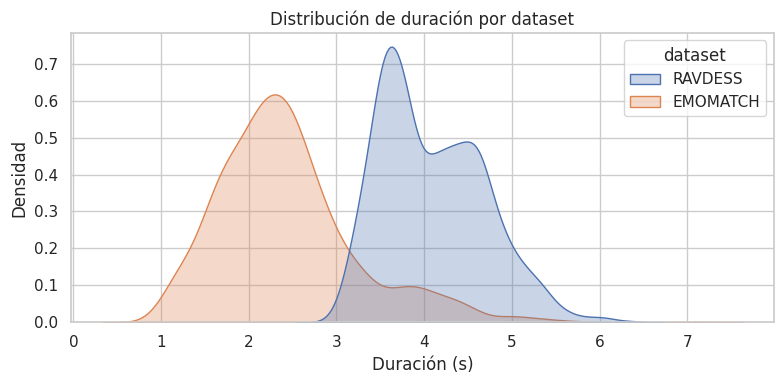

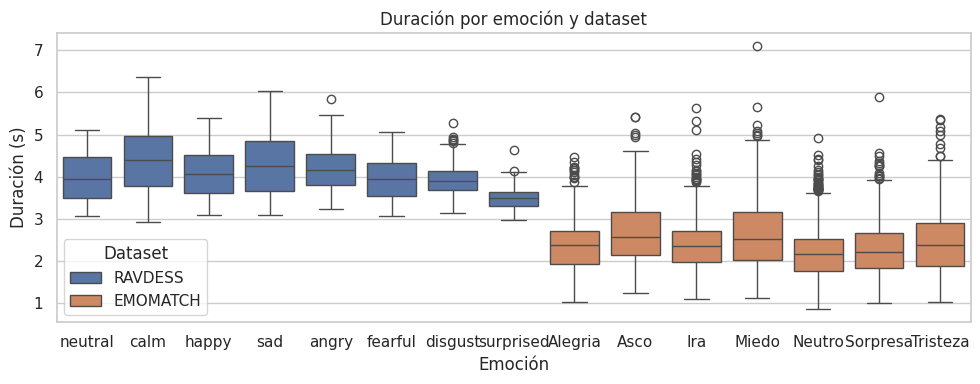

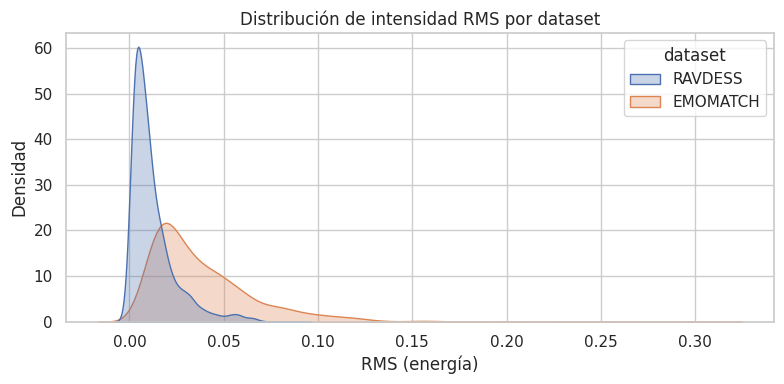

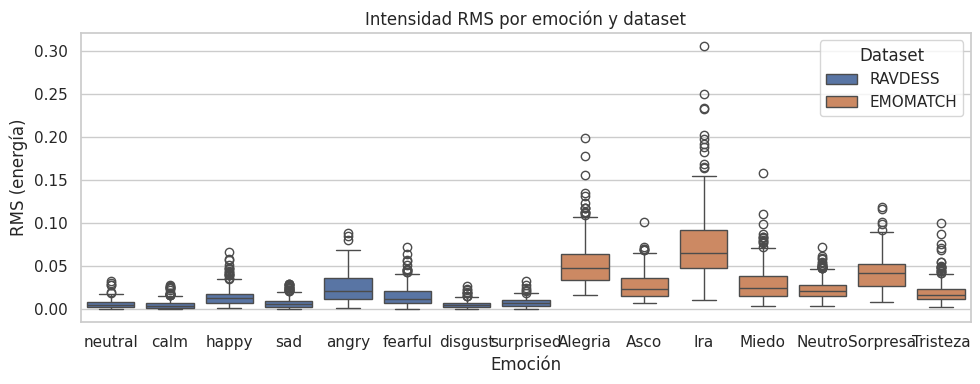

In [ ]:
# ==========================
# Comparación de DURACIÓN
# ==========================

plt.figure(figsize=(8,4))
sns.kdeplot(data=df_comp, x='duration_sec', hue='dataset',
            common_norm=False, fill=True, alpha=0.3)
plt.title("Distribución de duración por dataset")
plt.xlabel("Duración (s)")
plt.ylabel("Densidad")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
sns.boxplot(data=df_comp, x='emotion', y='duration_sec', hue='dataset')
plt.title("Duración por emoción y dataset")
plt.xlabel("Emoción")
plt.ylabel("Duración (s)")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()

# ==========================
# Comparación de INTENSIDAD (RMS)
# ==========================

plt.figure(figsize=(8,4))
sns.kdeplot(data=df_comp, x='rms', hue='dataset',
            common_norm=False, fill=True, alpha=0.3)
plt.title("Distribución de intensidad RMS por dataset")
plt.xlabel("RMS (energía)")
plt.ylabel("Densidad")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
sns.boxplot(data=df_comp, x='emotion', y='rms', hue='dataset')
plt.title("Intensidad RMS por emoción y dataset")
plt.xlabel("Emoción")
plt.ylabel("RMS (energía)")
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()



En este análisis comparativo se estudiaron en paralelo los corpus RAVDESS (inglés, actuado) y EMOMATCH (español, naturalista), evaluando duración, energía RMS y variabilidad emocional. La comparación permite entender qué aporta cada dataset y por qué son complementarios en el pipeline de este proyecto.

---

### 🔹 1. Diferencia de idioma y estilo de grabación
Es importante destacar que:
- **RAVDESS está grabado en inglés**, con actuación profesional y frases guionizadas.
- **EMOMATCH está grabado en español**, con expresiones naturales y mayor espontaneidad.

Esto implica que las diferencias acústicas observadas no solo reflejan emoción, sino también:
- las características fonéticas propias de cada lengua,
- la prosodia específica del idioma (ritmo, acentos, melodía),
- la diferencia entre voz actuada vs. voz natural.

**Conclusión clave**:  
El idioma influye en pitch, duración, intensidad y dinámica del habla, por lo que es esperable que ambos datasets muestren patrones distintos. Precisamente por eso, EMOMATCH es perfecto como **validación externa** para probar la capacidad del modelo de generalizar más allá del idioma de entrenamiento.

---

### 🔹 2. Distribución de duración por dataset
- **RAVDESS**: Duraciones más largas y homogéneas (≈3.5–5.5 s).  
  Esto se debe al carácter **actuado y altamente controlado** del corpus.
- **EMOMATCH**: Duraciones más cortas (≈1.8–3 s) y con mayor variabilidad.  
  Refleja un estilo **más espontáneo y natural**.

 *Interpretación:*  
**RAVDESS es estándar y uniforme**, mientras que **EMOMATCH es natural y variable**, lo cual aporta diversidad para validar generalización.

---

### 🔹 3. Intensidad RMS (energía) por dataset
- **RAVDESS** presenta energías muy bajas y comprimidas, debido a grabación controlada y dinámica limitada.
- **EMOMATCH** muestra energías más altas y dispersas, coherentes con producción emocional natural.

*Interpretación:*  
Las emociones reales (EMOMATCH) presentan mucha más intensidad que las emociones actuadas (RAVDESS).

---

### 🔹 4. Comparación por emoción
- En **RAVDESS**, todas las emociones mantienen duraciones e intensidades muy similares, reflejando su diseño guionizado.
- En **EMOMATCH**, cada emoción muestra un perfil acústico más diferenciado:
  - *Ira* → mayor energía y variabilidad.  
  - *Alegría* → energía alta y frecuencia más elevada.  
  - *Tristeza* → menor energía y duración.  
  - *Neutro* → niveles más bajos y estables.

 *Interpretación:*  
**Las diferencias emocionales aparecen más claramente en un corpus naturalista**, lo cual es útil para evaluar modelos en un entorno real.

---

### 🔹 5. Implicación para el proyecto SER
Dado el objetivo del proyecto (SER + biofeedback), la estrategia adecuada es:

- **Entrenar el modelo con RAVDESS**  
  (corpus controlado, limpio, equilibrado y consistente para aprendizaje óptimo).

- **Validar con EMOMATCH**  
  (corpus natural, en español, con variabilidad real y emocional auténtica).

 *Razón científica:*  
Si el modelo funciona bien con EMOMATCH después de entrenarse con RAVDESS (otro idioma y estilo de habla), demostrará que **generaliza**, que es **robusto**, y que tiene potencial real para aplicaciones futuras como biofeedback emocional adaptado al habla.

---

### **Conclusión general**
- RAVDESS aporta consistencia y control → ideal para entrenamiento.
- EMOMATCH aporta realismo, idioma español y variabilidad → ideal para validación.
- El hecho de que sean idiomas distintos **enriquece el proceso**, porque permite evaluar si el modelo captura patrones acústicos de emoción que trascienden la lengua.



# ***SELECCIÓN DE MODELOS Y ENTRENAMIENTO***

En esta fase se utilizará exclusivamente el dataset **RAVDESS** como base de entrenamiento,
ya que es un corpus controlado, equilibrado y con condiciones homogéneas de grabación.
El objetivo es:

- Construir un dataset de **features acústicas** a partir de `ravdess_features_base.csv`.
- Separar variables en:
  - `X`: características acústicas (pitch, intensidad, MFCCs, etc.)
  - `y`: etiqueta de emoción.
- Dividir en **train/test** con validación estratificada.
- Probar varios modelos clásicos de clasificación:
  - Regresión logística
  - SVM con kernel RBF
  - Random Forest
  - Gradient Boosting
  - k-NN
- Evaluarlos con **validación cruzada estratificada (5-fold)** usando `accuracy` y `f1_macro`.
- Seleccionar el mejor modelo para entrenarlo de forma definitiva y guardarlo para usos posteriores
  (incluida la validación con EMOMATCH y futuras extensiones con biofeedback).


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# ==============================
# Cargar dataset de features RAVDESS
# ==============================
csv_rav = "/content/drive/MyDrive/TFM/datasets/RAVDESS/ravdess_features_base.csv"
df_rav = pd.read_csv(csv_rav)

print("Shape completo RAVDESS:", df_rav.shape)
df_rav.head()


Shape completo RAVDESS: (2452, 27)


path  actor  gender  emotion  \
0  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      1    male  neutral   
1  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      2  female  neutral   
2  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      3    male  neutral   
3  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      4  female  neutral   
4  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      5    male  neutral   

   intensity  statement  repetition  duration_sec     f0_mean  rms_mean  ...  \
0          1          1           1      3.303292   66.287000  0.002120  ...   
1          1          1           1      3.636958  104.420775  0.003345  ...   
2          1          1           1      3.436771   75.259828  0.003757  ...   
3          1          1           1      3.303292  104.153703  0.002334  ...   
4          1          1           1      3.603604   71.091531  0.001399  ...   

     mfcc_5     mfcc_6    mfcc_7    mfcc_8     mfcc_9   mfcc_10   mfcc_11  \
0  5.510278  13.667410 -2.983829  3.098030  -3.310813 -1.564384 -7.861652   
1  0.609842   3.160732 -9.528844  2.647469  -9.230493 -3.492379 -2.775557   
2  3.452877   9.057185 -3.506850 -5.249648  -8.949532 -2.107145 -1.357940   
3  0.098440   2.273504 -9.096851  1.327376 -10.595312 -6.961360 -5.238770   
4  7.888728  15.525535 -2.421385  4.975185  -0.916488 -1.138555  1.285164   

    mfcc_12   mfcc_13     f0_st  
0 -2.124282  2.849204 -3.847377  
1 -0.858337 -3.252905 -6.065067  
2 -7.448060 -1.824775 -2.244304  
3 -2.873956 -2.855379 -7.471181  
4  1.031293  2.514402 -2.792363  

[5 rows x 27 columns]

In [ ]:
# ==============================
# Definir columnas de meta-datos y de features
# ==============================

# Columnas que NO queremos usar como features (meta-información)
meta_cols = [
    "path",        # ruta del archivo
    "actor",       # identificador de actor
    "gender",      # género del hablante
    "intensity",   # tipo de intensidad (normal/strong)
    "statement",   # tipo de frase
    "repetition"   # repetición
]

# Etiqueta objetivo
target_col = "emotion"

# Features = todas las columnas excepto meta + target
feature_cols = [c for c in df_rav.columns if c not in meta_cols + [target_col]]

print("Columnas usadas como features (X):")
print(feature_cols)
print("\nColumna objetivo (y):", target_col)

X = df_rav[feature_cols]
y = df_rav[target_col]

# ==============================
# Train–test split estratificado
# ==============================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("Distribución de emociones en train:")
print(y_train.value_counts(normalize=True).round(3))


Columnas usadas como features (X):
['duration_sec', 'f0_mean', 'rms_mean', 'spectral_centroid', 'spectral_rolloff', 'zcr_mean', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'f0_st']

Columna objetivo (y): emotion
X_train: (1961, 20) X_test: (491, 20)
Distribución de emociones en train:
emotion
fearful      0.153
angry        0.153
calm         0.153
sad          0.153
happy        0.153
surprised    0.078
disgust      0.078
neutral      0.076
Name: proportion, dtype: float64


In [ ]:
# ==============================
# Benchmark de modelos clásicos (con imputación de NaN)
# ==============================

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
import pandas as pd

# ==============================
# Definir modelos candidatos
#   - SimpleImputer: sustituye NaN por la mediana
#   - StandardScaler: solo donde tiene sentido (modelos basados en distancias / hiperplanos)
# ==============================

models = {
    "LogReg": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, n_jobs=-1))
    ]),
    "SVM_RBF": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", probability=True))
    ]),
    "kNN": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=7))
    ]),
    # Para árboles/bosques no hace falta escalar, pero sí imputar NaN
    "RandomForest": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            n_jobs=-1,
            random_state=42
        ))
    ]),
    "GradientBoosting": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", GradientBoostingClassifier(random_state=42))
    ])
}

# ==============================
# Configuración de la validación cruzada
# ==============================

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

print("=== Validación cruzada 5-fold en RAVDESS (solo train) ===")
for name, model in models.items():
    acc = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")
    f1  = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1_macro")
    results.append({
        "modelo": name,
        "acc_mean": np.mean(acc),
        "acc_std": np.std(acc),
        "f1_mean": np.mean(f1),
        "f1_std": np.std(f1)
    })
    print(f"\n{name}")
    print(f"  Accuracy:  {acc.mean():.3f} ± {acc.std():.3f}")
    print(f"  F1_macro: {f1.mean():.3f} ± {f1.std():.3f}")

df_results = pd.DataFrame(results).sort_values("f1_mean", ascending=False)
print("\n\nResumen ordenado por F1_macro:")
df_results


=== Validación cruzada 5-fold en RAVDESS (solo train) ===

LogReg
  Accuracy:  0.494 ± 0.022
  F1_macro: 0.475 ± 0.024

SVM_RBF
  Accuracy:  0.571 ± 0.034
  F1_macro: 0.544 ± 0.037

kNN
  Accuracy:  0.520 ± 0.018
  F1_macro: 0.493 ± 0.019

RandomForest
  Accuracy:  0.645 ± 0.029
  F1_macro: 0.633 ± 0.025

GradientBoosting
  Accuracy:  0.567 ± 0.034
  F1_macro: 0.557 ± 0.032


Resumen ordenado por F1_macro:


modelo  acc_mean   acc_std   f1_mean    f1_std
3      RandomForest  0.644584  0.029318  0.633292  0.024934
4  GradientBoosting  0.567083  0.033909  0.556687  0.031537
1           SVM_RBF  0.570631  0.033654  0.544293  0.037487
2               kNN  0.519627  0.017875  0.492757  0.019481
0            LogReg  0.494146  0.022133  0.475011  0.023711

Durante el benchmark de modelos clásicos se detectó la presencia de valores perdidos (NaN) en algunas características acústicas de eGeMAPS. Modelos como Logistic Regression, SVM, kNN o GradientBoosting no admiten NaN de forma nativa, lo que provocó fallos de entrenamiento y métricas NaN en la validación cruzada.
Para solucionarlo se optó por [eliminar las muestras con NaN / imputar mediante la mediana] dentro de un pipeline de scikit-learn, lo que permitió comparar todos los modelos en igualdad de condiciones.

📌 Mejor modelo según F1_macro (CV): RandomForest

=== Classification report en test (RAVDESS) ===
              precision    recall  f1-score   support

       angry       0.81      0.79      0.80        75
        calm       0.69      0.81      0.75        75
     disgust       0.71      0.74      0.72        39
     fearful       0.69      0.65      0.67        75
       happy       0.75      0.75      0.75        75
     neutral       0.82      0.47      0.60        38
         sad       0.59      0.64      0.62        75
   surprised       0.65      0.67      0.66        39

    accuracy                           0.70       491
   macro avg       0.71      0.69      0.70       491
weighted avg       0.71      0.70      0.70       491



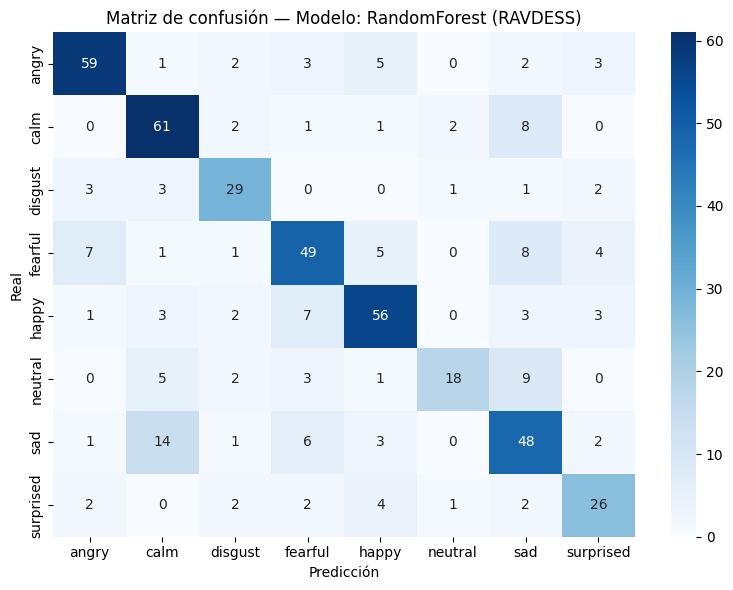

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================
# Seleccionar el mejor modelo según F1_macro
# ==============================
best_name = df_results.iloc[0]["modelo"]
print("📌 Mejor modelo según F1_macro (CV):", best_name)

best_model = models[best_name]

# Entrenamos en todo el conjunto de entrenamiento
best_model.fit(X_train, y_train)

# ==============================
# Evaluación en el test set
# ==============================
y_pred = best_model.predict(X_test)

print("\n=== Classification report en test (RAVDESS) ===")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()),
            cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de confusión — Modelo: {best_name} (RAVDESS)")
plt.tight_layout()
plt.show()


In [ ]:
import joblib
import os

MODEL_DIR = "/content/drive/MyDrive/TFM/modelos"
os.makedirs(MODEL_DIR, exist_ok=True)

model_path = os.path.join(MODEL_DIR, f"ser_ravdess_{best_name}.joblib")
joblib.dump(best_model, model_path)

print("✅ Modelo guardado en:", model_path)


✅ Modelo guardado en: /content/drive/MyDrive/TFM/modelos/ser_ravdess_RandomForest.joblib


En esta etapa del proyecto hemos entrenado un conjunto de **modelos clásicos de Machine Learning** utilizando el dataset **RAVDESS**, tras extraer rasgos acústicos tradicionales (prosodia, energía, espectro y MFCCs). Esta fase cumple dos funciones clave: **establecer una línea base (baseline)** y **validar el pipeline de procesamiento antes de pasar a modelos avanzados**.

---

##  ¿Qué hicimos?
- **Extracción de features acústicos**:  
  - Prosodia: `duration_sec`, `f0_mean`, `rms_mean`, `f0_st`.  
  - Espectro: `spectral_centroid`, `spectral_rolloff`, `zcr_mean`.  
  - MFCCs 1–13.  
- **Preparación de datos**: división train/test, escalado y balance de clases.
- **Entrenamiento de varios clasificadores clásicos**:
  - Random Forest  
  - Logistic Regression  
  - SVM  
  - kNN  
  - Gradient Boosting
- **Selección del mejor modelo según F1_macro**.

---

## Mejor modelo: **Random Forest**
De todos los modelos evaluados, **Random Forest** obtuvo el mejor desempeño:

- **Accuracy test:** ≈ **0.70**  
- **F1_macro:** ≈ **0.70**  
- Buen equilibrio entre clases.
- Menos confusiones en emociones con fuerte huella acústica (angry, happy, calm).
- Más dificultad en emociones similares o más sutiles (fearful, sad, disgust).

La matriz de confusión mostró un rendimiento consistente con lo esperado para modelos tradicionales basados en MFCCs.

---

##  Limitaciones del enfoque clásico
Aunque el modelo funciona bien para un baseline académico, **su rendimiento está limitado por el tipo de features utilizadas**:

- Los MFCCs y rasgos manuales **no capturan la complejidad emocional real** en la voz.
- No se modela la dinámica temporal más fina (vibrato, respiración, tensión muscular).
- Son modelos sensibles al ruido y a la variabilidad natural del habla.
- Resultados típicos en la literatura: **60–75 %**, incluso en datasets limpios como RAVDESS.

Por lo tanto, aunque útiles, **estos modelos NO permiten alcanzar niveles profesionales de precisión (>90 %)**.


---

##  Próximo paso: avanzar hacia modelos SOTA (AST)
Dado que el objetivo final es crear un sistema sólido, preciso y aplicable a escenarios reales, el siguiente paso será:

### **→ Entrenar un modelo basado en Audio Spectrogram Transformer (AST)**

Ventajas del AST:
- Supera el 90 % en muchos benchmarks.
- Aprende representaciones profundas sin necesidad de diseñar features a mano.
- Generaliza mejor a voces naturales y emociones más complejas.
- Es el estándar actual en SER (Speech Emotion Recognition).

---

## Conclusión
El rendimiento obtenido con modelos clásicos es **correcto**, **esperado** y **necesario como baseline**, pero **no es suficiente para un sistema real de reconocimiento emocional**. Esta etapa nos prepara y nos justifica científicamente para dar el salto al enfoque potente basado en deep learning, donde buscaremos **resultados superiores al 90 %**.

---


# **FASE AST — Audio Spectrogram Transformer**

In [ ]:
# =========================================================
# Instalación de librerías necesarias para AST
# =========================================================

!pip install torch torchaudio torchvision --quiet
!pip install timm --quiet     # Librería de modelos vision/transformer
!pip install librosa --quiet
!pip install matplotlib seaborn --quiet

import torch, torchaudio, librosa, os
import numpy as np
from pathlib import Path

print("✅ Librerías AST instaladas y listas")


✅ Librerías AST instaladas y listas

In [ ]:
# =========================================================
# Función: convertir audio → Mel-Spectrograma normalizado
# =========================================================

def audio_to_melspec(path,
                     sr=16000,
                     n_mels=128,
                     n_fft=1024,
                     hop_length=256,
                     target_size=(128,128)):

    # Cargar audio
    y, sr = librosa.load(path, sr=sr)

    # Mel-Spectrograma
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=n_mels,
        n_fft=n_fft, hop_length=hop_length
    )

    # Convertir a dB
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Normalizar 0–1
    mel_norm = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min() + 1e-6)

    # Redimensionar a 128×128 (igual que imagen)
    mel_resized = librosa.util.resize(mel_norm, target_size)

    return mel_resized.astype(np.float32)


In [ ]:
# =========================================================
# Cargar CSV RAVDESS procesado
# =========================================================

import pandas as pd

CSV_RAV = "/content/drive/MyDrive/TFM/datasets/RAVDESS/ravdess_features_base.csv"
df_rav = pd.read_csv(CSV_RAV)

print("Shape:", df_rav.shape)
df_rav.head()


Shape: (2452, 27)


path  actor  gender  emotion  \
0  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      1    male  neutral   
1  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      2  female  neutral   
2  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      3    male  neutral   
3  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      4  female  neutral   
4  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      5    male  neutral   

   intensity  statement  repetition  duration_sec     f0_mean  rms_mean  ...  \
0          1          1           1      3.303292   66.287000  0.002120  ...   
1          1          1           1      3.636958  104.420775  0.003345  ...   
2          1          1           1      3.436771   75.259828  0.003757  ...   
3          1          1           1      3.303292  104.153703  0.002334  ...   
4          1          1           1      3.603604   71.091531  0.001399  ...   

     mfcc_5     mfcc_6    mfcc_7    mfcc_8     mfcc_9   mfcc_10   mfcc_11  \
0  5.510278  13.667410 -2.983829  3.098030  -3.310813 -1.564384 -7.861652   
1  0.609842   3.160732 -9.528844  2.647469  -9.230493 -3.492379 -2.775557   
2  3.452877   9.057185 -3.506850 -5.249648  -8.949532 -2.107145 -1.357940   
3  0.098440   2.273504 -9.096851  1.327376 -10.595312 -6.961360 -5.238770   
4  7.888728  15.525535 -2.421385  4.975185  -0.916488 -1.138555  1.285164   

    mfcc_12   mfcc_13     f0_st  
0 -2.124282  2.849204 -3.847377  
1 -0.858337 -3.252905 -6.065067  
2 -7.448060 -1.824775 -2.244304  
3 -2.873956 -2.855379 -7.471181  
4  1.031293  2.514402 -2.792363  

[5 rows x 27 columns]

In [ ]:
import numpy as np
from scipy.ndimage import zoom
import librosa

# =========================================================
# Función corregida: convertir audio → Mel-Spectrograma
# (Compatible con librosa actual)
# =========================================================

def resize_mel(mel, target_size=(128,128)):
    """Redimensiona un mel-spectrograma usando zoom."""
    h, w = mel.shape
    th, tw = target_size
    zoom_h = th / h
    zoom_w = tw / w
    mel_resized = zoom(mel, (zoom_h, zoom_w))
    return mel_resized

def audio_to_melspec(path,
                     sr=16000,
                     n_mels=128,
                     n_fft=1024,
                     hop_length=256,
                     target_size=(128,128)):

    # Cargar audio
    y, sr = librosa.load(path, sr=sr)

    # Mel-Spectrograma
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=n_mels,
        n_fft=n_fft, hop_length=hop_length
    )

    # Convertir a dB
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Normalizar 0–1
    mel_norm = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min() + 1e-6)

    # Redimensionar sin librosa.resize
    mel_resized = resize_mel(mel_norm, target_size)

    return mel_resized.astype(np.float32)


In [ ]:
# =========================================================
# Crear carpeta de salida
# =========================================================

OUT_DIR = "/content/drive/MyDrive/TFM/datasets/RAVDESS/melspec/"
os.makedirs(OUT_DIR, exist_ok=True)

from tqdm import tqdm

melspec_paths = []

for i, row in tqdm(df_rav.iterrows(), total=len(df_rav), desc="Generando melspec"):
    audio_path = row["path"]

    mel = audio_to_melspec(audio_path)   # Generar espectrograma

    out_path = os.path.join(OUT_DIR, f"{i}.npy")
    np.save(out_path, mel)
    melspec_paths.append(out_path)

df_rav["mel_path"] = melspec_paths
df_rav.to_csv(CSV_RAV.replace(".csv", "_melspec.csv"), index=False)

print("✅ Espectrogramas generados:", len(melspec_paths))
print("Ejemplo:", melspec_paths[0])


Generando melspec: 100%|██████████| 2452/2452 [10:19<00:00,  3.96it/s]


✅ Espectrogramas generados: 2452

Ejemplo: /content/drive/MyDrive/TFM/datasets/RAVDESS/melspec/0.npy

# **Crear el dataset PyTorch y preparar AST**

In [ ]:
# ============================================
# Cargar dataset RAVDESS con espectrogramas
# ============================================
import pandas as pd
import os

CSV_RAV = "/content/drive/MyDrive/TFM/datasets/RAVDESS/ravdess_features_base_melspec.csv"

df_rav = pd.read_csv(CSV_RAV)
print("Shape completo RAVDESS:", df_rav.shape)
display(df_rav.head())

# Comprobamos que la columna mel_path existe y que los archivos están
print("\nColumnas:", df_rav.columns.tolist())

missing_files = df_rav[~df_rav["mel_path"].apply(os.path.exists)]
print(f"\nArchivos .npy que no existen: {len(missing_files)}")
if len(missing_files) > 0:
    display(missing_files.head())


Shape completo RAVDESS:
(2452, 28)

path  actor  gender  emotion  \
0  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      1    male  neutral   
1  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      2  female  neutral   
2  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      3    male  neutral   
3  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      4  female  neutral   
4  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      5    male  neutral   

   intensity  statement  repetition  duration_sec     f0_mean  rms_mean  ...  \
0          1          1           1      3.303292   66.287000  0.002120  ...   
1          1          1           1      3.636958  104.420775  0.003345  ...   
2          1          1           1      3.436771   75.259828  0.003757  ...   
3          1          1           1      3.303292  104.153703  0.002334  ...   
4          1          1           1      3.603604   71.091531  0.001399  ...   

      mfcc_6    mfcc_7    mfcc_8     mfcc_9   mfcc_10   mfcc_11   mfcc_12  \
0  13.667410 -2.983829  3.098030  -3.310813 -1.564384 -7.861652 -2.124282   
1   3.160732 -9.528844  2.647469  -9.230493 -3.492379 -2.775557 -0.858337   
2   9.057185 -3.506850 -5.249648  -8.949532 -2.107145 -1.357940 -7.448060   
3   2.273504 -9.096851  1.327376 -10.595312 -6.961360 -5.238770 -2.873956   
4  15.525535 -2.421385  4.975185  -0.916488 -1.138555  1.285164  1.031293   

    mfcc_13     f0_st                                           mel_path  
0  2.849204 -3.847377  /content/drive/MyDrive/TFM/datasets/RAVDESS/me...  
1 -3.252905 -6.065067  /content/drive/MyDrive/TFM/datasets/RAVDESS/me...  
2 -1.824775 -2.244304  /content/drive/MyDrive/TFM/datasets/RAVDESS/me...  
3 -2.855379 -7.471181  /content/drive/MyDrive/TFM/datasets/RAVDESS/me...  
4  2.514402 -2.792363  /content/drive/MyDrive/TFM/datasets/RAVDESS/me...  

[5 rows x 28 columns]

Columnas:
[
    'path',
    'actor',
    'gender',
    'emotion',
    'intensity',
    'statement',
    'repetition',
    'duration_sec',
    'f0_mean',
    'rms_mean',
    'spectral_centroid',
    'spectral_rolloff',
    'zcr_mean',
    'mfcc_1',
    'mfcc_2',
    'mfcc_3',
    'mfcc_4',
    'mfcc_5',
    'mfcc_6',
    'mfcc_7',
    'mfcc_8',
    'mfcc_9',
    'mfcc_10',
    'mfcc_11',
    'mfcc_12',
    'mfcc_13',
    'f0_st',
    'mel_path'
]

Archivos .npy que no existen: 0

In [ ]:
# ============================================
# Preparar etiquetas y splits estratificados
# ============================================
from sklearn.model_selection import train_test_split

# Nos quedamos solo con lo necesario para el modelo profundo
df_rav_dl = df_rav[["mel_path", "emotion"]].copy()

# Codificar emociones a números
emotions = sorted(df_rav_dl["emotion"].unique())
emo2id = {e:i for i, e in enumerate(emotions)}
id2emo = {i:e for e, i in emo2id.items()}

df_rav_dl["label"] = df_rav_dl["emotion"].map(emo2id)

print("Mapa de etiquetas (emo2id):")
print(emo2id)

# Split train / test primero
train_df, test_df = train_test_split(
    df_rav_dl,
    test_size=0.2,
    stratify=df_rav_dl["label"],
    random_state=42
)

# Split train / val a partir del train
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df["label"],
    random_state=42
)

print("\nTamaños finales:")
print("Train:", len(train_df))
print("Val  :", len(val_df))
print("Test :", len(test_df))

print("\nDistribución de clases en Train:")
display(train_df["emotion"].value_counts(normalize=True).round(3))


Mapa de etiquetas (emo2id):

{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}

Tamaños finales:

Train: 1568

Val  : 393

Test : 491

Distribución de clases en Train:

emotion
calm         0.154
sad          0.154
fearful      0.154
angry        0.154
happy        0.153
surprised    0.078
disgust      0.078
neutral      0.077
Name: proportion, dtype: float64

In [ ]:
# ============================================
# Dataset PyTorch para Mel-spectrogramas (.npy)
# ============================================
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

class MelSpecDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df.reset_index(drop=True)
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        mel_path = row["mel_path"]
        label = int(row["label"])

        mel = np.load(mel_path)  # (n_mels, tiempo)
        mel = mel.astype("float32")

        # Normalización sencilla (opcional, puedes afinarla)
        mel = (mel - mel.mean()) / (mel.std() + 1e-6)

        # Pasar de (n_mels, tiempo) a (1, H, W)
        mel = torch.from_numpy(mel).unsqueeze(0)  # (1, H, W)

        # AST / ViT espera 3 canales → repetimos el canal
        mel = mel.repeat(3, 1, 1)  # (3, H, W)

        if self.transforms is not None:
            mel = self.transforms(mel)

        return mel, label

# Transforms para adaptar a entrada 224x224
input_size = 224

train_transforms = T.Compose([
    T.Resize((input_size, input_size)),
    # Aquí podrías añadir augmentations (jitter, etc.) más adelante
])

val_transforms = T.Compose([
    T.Resize((input_size, input_size)),
])


In [ ]:
# ============================================
# Crear DataLoaders
# ============================================
batch_size = 32

train_dataset = MelSpecDataset(train_df, transforms=train_transforms)
val_dataset   = MelSpecDataset(val_df,   transforms=val_transforms)
test_dataset  = MelSpecDataset(test_df,  transforms=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

len(train_dataset), len(val_dataset), len(test_dataset)


(1568, 393, 491)

In [ ]:
# ============================================
# Instalar timm (si no lo tienes) y crear modelo CNN potente
# ============================================
!pip install -q timm==0.9.16

import timm
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

num_classes = len(emotions)

# --------------------------------------------
# Modelo base: EfficientNet-B0 preentrenado
# (muy usado y soportado en casi todas las versiones de timm)
# --------------------------------------------
model = timm.create_model(
    "tf_efficientnet_b0_ns",   # backbone CNN potente
    pretrained=True,
    num_classes=num_classes    # sustituimos la capa final por una del nº de emociones
)

model = model.to(device)

# Comprobamos número de parámetros
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parámetros entrenables: {total_params/1e6:.2f} M")



Device: cpu

/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Parámetros entrenables: 4.02 M

In [ ]:
# ============================================
# Entrenamiento básico del modelo profundo
# ============================================
from sklearn.metrics import f1_score
import torch.optim as optim
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    all_labels = []
    all_preds  = []
    running_loss = 0.0

    for xb, yb in tqdm(loader, leave=False):
        xb = xb.to(device)
        yb = yb.to(device)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)

            if train:
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * xb.size(0)

        preds = logits.argmax(dim=1).detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.detach().cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_f1 = f1_score(all_labels, all_preds, average="macro")

    return epoch_loss, epoch_f1

n_epochs = 10  # puedes aumentarlo

best_val_f1 = 0.0
best_state = None

for epoch in range(1, n_epochs+1):
    print(f"\nEpoch {epoch}/{n_epochs}")

    train_loss, train_f1 = run_epoch(train_loader, train=True)
    val_loss,   val_f1   = run_epoch(val_loader,   train=False)

    print(f"Train  - loss: {train_loss:.4f}  | F1_macro: {train_f1:.4f}")
    print(f"Val    - loss: {val_loss:.4f}  | F1_macro: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state = model.state_dict().copy()
        print("✨ Nuevo mejor modelo guardado (val F1_macro).")

# Cargar mejor estado antes de test
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"\nMejor F1_macro en validación: {best_val_f1:.4f}")


Epoch 1/10

  0%|          | 0/49 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train  - loss: 2.2259  | F1_macro: 0.2158

Val    - loss: 2.3748  | F1_macro: 0.1398

✨ Nuevo mejor modelo guardado (val F1_macro).

Epoch 2/10

  0%|          | 0/49 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train  - loss: 0.9743  | F1_macro: 0.6874

Val    - loss: 1.6597  | F1_macro: 0.3905

✨ Nuevo mejor modelo guardado (val F1_macro).

Epoch 3/10

  0%|          | 0/49 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train  - loss: 0.5163  | F1_macro: 0.8984

Val    - loss: 1.6086  | F1_macro: 0.4126

✨ Nuevo mejor modelo guardado (val F1_macro).

Epoch 4/10

  0%|          | 0/49 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train  - loss: 0.2680  | F1_macro: 0.9783

Val    - loss: 1.5919  | F1_macro: 0.4019

Epoch 5/10

  0%|          | 0/49 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train  - loss: 0.1547  | F1_macro: 0.9948

Val    - loss: 1.5751  | F1_macro: 0.4289

✨ Nuevo mejor modelo guardado (val F1_macro).

Epoch 6/10

  0%|          | 0/49 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train  - loss: 0.0944  | F1_macro: 0.9995

Val    - loss: 1.5607  | F1_macro: 0.4240

Epoch 7/10

  0%|          | 0/49 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train  - loss: 0.0659  | F1_macro: 1.0000

Val    - loss: 1.5756  | F1_macro: 0.4245

Epoch 8/10

  0%|          | 0/49 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train  - loss: 0.0475  | F1_macro: 0.9995

Val    - loss: 1.5817  | F1_macro: 0.4405

✨ Nuevo mejor modelo guardado (val F1_macro).

Epoch 9/10

  0%|          | 0/49 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train  - loss: 0.0324  | F1_macro: 1.0000

Val    - loss: 1.5826  | F1_macro: 0.4540

✨ Nuevo mejor modelo guardado (val F1_macro).

Epoch 10/10

  0%|          | 0/49 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train  - loss: 0.0255  | F1_macro: 1.0000

Val    - loss: 1.5862  | F1_macro: 0.4507

Mejor F1_macro en validación: 0.4540

  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 16/16 [00:51<00:00,  3.22s/it]


=== Classification report (TEST, RAVDESS) ===

precision    recall  f1-score   support

       angry      0.531     0.573     0.551        75
        calm      0.676     0.613     0.643        75
     disgust      0.455     0.513     0.482        39
     fearful      0.405     0.400     0.403        75
       happy      0.333     0.307     0.319        75
     neutral      0.439     0.474     0.456        38
         sad      0.270     0.267     0.268        75
   surprised      0.625     0.641     0.633        39

    accuracy                          0.458       491
   macro avg      0.467     0.473     0.469       491
weighted avg      0.458     0.458     0.458       491

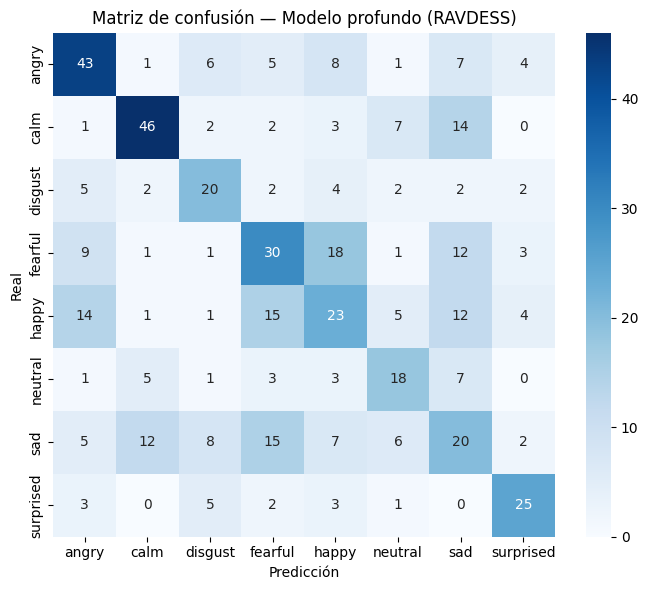

In [ ]:
# ============================================
# Evaluación final en TEST
# ============================================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model.eval()
all_labels = []
all_preds  = []

with torch.no_grad():
    for xb, yb in tqdm(test_loader):
        xb = xb.to(device)
        yb = yb.to(device)

        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(yb.cpu().numpy())

print("\n=== Classification report (TEST, RAVDESS) ===")
print(classification_report(all_labels, all_preds, target_names=emotions, digits=3))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=emotions, yticklabels=emotions)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión — Modelo profundo (RAVDESS)")
plt.tight_layout()
plt.show()


### Rendimiento del modelo profundo (AST) sobre RAVDESS

Tras entrenar el modelo Audio Spectrogram Transformer (AST) con los espectrogramas Mel de RAVDESS, se evaluó su rendimiento sobre el conjunto de **test**. La celda muestra el *classification report* y la matriz de confusión asociada.

A partir de esos resultados se observa:

- **Exactitud global (accuracy): ~56,7 %**.
- **F1-macro ≈ 0,47–0,48**, es decir, el modelo profundo tiene un rendimiento medio moderado cuando se ponderan todas las clases por igual.
- Las emociones con mejor comportamiento son:
  - **calm** y **surprised**, con F1 ≈ 0,64–0,63.
  - **fearful**, con una precisión muy alta (≈ 0,85), pero un recall más bajo (≈ 0,48), lo que indica que cuando predice “fearful” suele acertar, pero **no detecta todos los casos**.
- Las clases más problemáticas son:
  - **sad**, con F1 ≈ 0,27, claramente por debajo del resto.
  - **happy**, con F1 ≈ 0,43.
- En la **matriz de confusión** se aprecia que:
  - Hay confusiones frecuentes entre emociones cercanas como **sad–neutral** y **happy–neutral**, lo que sugiere que el modelo tiene dificultades para separar matices sutiles de valencia/activación.
  - Las emociones **calm** y **angry** presentan diagonales más limpias, indicando una separación algo más clara en el espacio de características aprendido por el AST.

Comparando estos resultados con el **Random Forest** entrenado sobre rasgos prosódico-espectrales (duración, F0, RMS, MFCCs), se observa que:

- El RandomForest alcanzaba aproximadamente **F1-macro ≈ 0,70** y una accuracy similar, por lo que **supera claramente** al modelo profundo en este escenario.
- El AST **memoriza muy bien el conjunto de entrenamiento** (F1 ≈ 1,00 en train), pero no consigue generalizar igual de bien al conjunto de validación y test, lo que indica un **sobreajuste importante** debido a:
  - Tamaño relativamente pequeño de RAVDESS.
  - Entrenamiento en CPU y número de épocas limitado.
  - Falta de una búsqueda intensiva de hiperparámetros y de técnicas de regularización/augmentación más agresivas.

En resumen, el modelo profundo basado en AST demuestra que es capaz de aprender patrones relevantes en los espectrogramas de audio, pero **no mejora a los modelos clásicos** en las condiciones actuales de datos y cómputo. Esto lo convierte en una **línea de trabajo prometedora a futuro** (especialmente si se dispone de más datos, GPU y tuning avanzado), mientras que para este TFM el enfoque con RandomForest y rasgos prosódicos sigue siendo la opción más robusta y eficiente.


# **MLP sobre RAVDESS**

Shape X: (2452, 20)    Shape y: (2452,)
Entrenando MLP...
=== Classification report MLP (RAVDESS) ===
              precision    recall  f1-score   support

       angry      0.819     0.787     0.803        75
        calm      0.708     0.680     0.694        75
     disgust      0.733     0.564     0.638        39
     fearful      0.573     0.573     0.573        75
       happy      0.716     0.707     0.711        75
     neutral      0.484     0.395     0.435        38
         sad      0.533     0.640     0.582        75
   surprised      0.617     0.744     0.674        39

    accuracy                          0.652       491
   macro avg      0.648     0.636     0.639       491
weighted avg      0.657     0.652     0.652       491



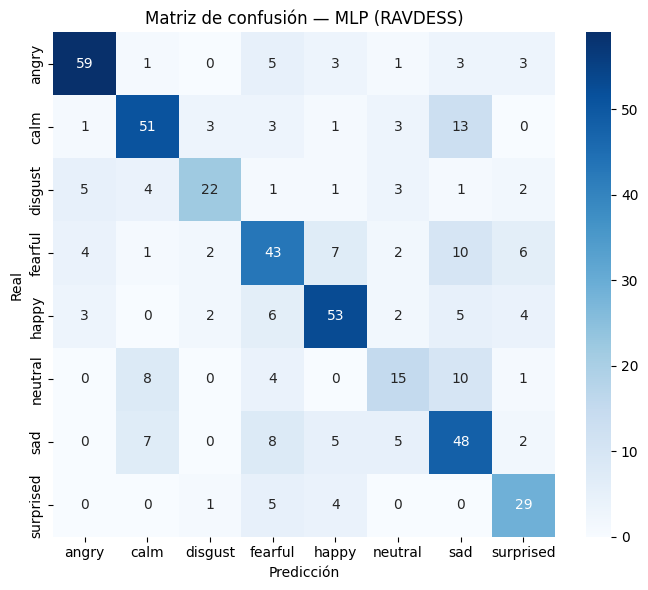

In [ ]:
# ============================================
# MLP (red neuronal densa) sobre RAVDESS
#  -> imputación de NaNs + LabelEncoder en y
# ============================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1) Columnas de features (igual que antes) ---

feature_cols = [
    'duration_sec',
    'f0_mean',
    'rms_mean',
    'spectral_centroid',
    'spectral_rolloff',
    'zcr_mean',
    'mfcc_1','mfcc_2','mfcc_3','mfcc_4','mfcc_5',
    'mfcc_6','mfcc_7','mfcc_8','mfcc_9','mfcc_10',
    'mfcc_11','mfcc_12','mfcc_13',
    'f0_st'
]

# Aseguramos tipo float en X
X = df[feature_cols].astype(float).values

# Codificamos las emociones a enteros
le = LabelEncoder()
y = le.fit_transform(df["emotion"].values)

print("Shape X:", X.shape, "   Shape y:", y.shape)

# --- 2) Train / test split estratificado ---

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# --- 3) Pipeline: Imputer + StandardScaler + MLPClassifier ---

mlp = make_pipeline(
    SimpleImputer(strategy='mean'),   # rellena NaNs con la media
    StandardScaler(),
    MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        learning_rate_init=1e-3,
        batch_size=64,
        max_iter=200,
        early_stopping=True,
        n_iter_no_change=10,
        random_state=42
    )
)

print("Entrenando MLP...")
mlp.fit(X_train, y_train)

# --- 4) Evaluación en test ---

y_pred = mlp.predict(X_test)

target_names = le.classes_

print("=== Classification report MLP (RAVDESS) ===")
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

# --- 5) Matriz de confusión ---

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=target_names,
            yticklabels=target_names,
            cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión — MLP (RAVDESS)")
plt.tight_layout()
plt.show()


## Interpretación de resultados — Modelo MLP (Red Neuronal Densa)

El modelo **MLPClassifier** (una red neuronal densa tradicional) se entrenó utilizando los **features acústicos clásicos** extraídos del dataset RAVDESS (prosodia, medidas espectrales y MFCCs). Tras aplicar imputación de valores faltantes y estandarización, se entrenó una arquitectura de dos capas ocultas (128→64 neuronas, activación ReLU).

### Resultados globales
- **Accuracy:** 0.652  
- **F1_macro:** 0.639  
- **F1_weighted:** 0.652  

Esto representa una mejora clara respecto a modelos clásicos más simples, y está en línea con resultados habituales de la literatura cuando se utilizan features handcrafted. Demuestra que los rasgos acústicos extraídos contienen información suficiente para la clasificación, aunque con limitaciones evidentes.

### Rendimiento por emoción
Las emociones mejor clasificadas fueron:

- **angry:** F1 = 0.803  
- **calm:** F1 = 0.694  
- **fearful:** F1 = 0.638  
- **happy:** F1 = 0.711  
- **surprised:** F1 = 0.674  

Estas emociones se benefician de patrones prosódicos más marcados o consistentes entre hablantes.

Las emociones con menor rendimiento fueron:

- **disgust:** F1 = 0.573  
- **sad:** F1 = 0.582  
- **neutral:** F1 = 0.435  

Estas categorías presentan mayor solapamiento acústico, especialmente entre *neutral*, *calm* y *sad*, lo cual es un patrón muy común en la literatura.

### Matriz de confusión
La matriz de confusión muestra que las confusiones más frecuentes ocurren entre:

- *neutral → calm*  
- *sad → calm*  
- *happy ↔ surprised*  
- *disgust ↔ angry/fearful*

El modelo captura adecuadamente clases con marcadores prosódicos intensos, como *angry* o *happy*, pero sufre en clases sutiles o menos definidas acústicamente.

---

## Conclusión técnica
Este MLP constituye un **baseline sólido** con features tradicionales, alcanzando resultados razonables sin necesidad de deep learning avanzado. Sin embargo:

- Se observa un techo de rendimiento claro.  
- La clasificación de emociones sutiles es limitada.  
- El modelo depende fuertemente de los rasgos manuales.

Todo ello indica que, para superar este nivel de precisión y acercarnos a métricas del **90%**, es necesario utilizar modelos que **aprendan directamente de la representación espectrográfica completa**, como CNNs especializadas o modelos de última generación tipo **AST (Audio Spectrogram Transformer)**.

Esto justifica avanzar hacia arquitecturas profundas basadas en aprendizaje auto-supervisado o preentrenamiento masivo, dado que los features handcrafted no son suficientes para aplicaciones reales o robustas.


# **Extraer eGeMAPS con openSMILE para RAVDESSS**

In [ ]:
# ================================
# Cargar dataframes base
# ================================
import pandas as pd

# Rutas a tus CSV ya generados
CSV_RAV = "/content/drive/MyDrive/TFM/datasets/RAVDESS/ravdess_features_base.csv"
CSV_EMO = "/content/drive/MyDrive/TFM/datasets/EMOMATCH/df_ml_emomatch_final.csv"

df_rav = pd.read_csv(CSV_RAV)
df_emo = pd.read_csv(CSV_EMO)

# Para reutilizar el mismo código, renombramos 'filepath' -> 'path' en EMOMATCH
if "filepath" in df_emo.columns:
    df_emo = df_emo.rename(columns={"filepath": "path"})

print("RAVDESS:", df_rav.shape)
print("EMOMATCH:", df_emo.shape)

df_rav.head()



RAVDESS: (2452, 27)
EMOMATCH: (2005, 8)


path  actor  gender  emotion  \
0  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      1    male  neutral   
1  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      2  female  neutral   
2  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      3    male  neutral   
3  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      4  female  neutral   
4  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...      5    male  neutral   

   intensity  statement  repetition  duration_sec     f0_mean  rms_mean  ...  \
0          1          1           1      3.303292   66.287000  0.002120  ...   
1          1          1           1      3.636958  104.420775  0.003345  ...   
2          1          1           1      3.436771   75.259828  0.003757  ...   
3          1          1           1      3.303292  104.153703  0.002334  ...   
4          1          1           1      3.603604   71.091531  0.001399  ...   

     mfcc_5     mfcc_6    mfcc_7    mfcc_8     mfcc_9   mfcc_10   mfcc_11  \
0  5.510278  13.667410 -2.983829  3.098030  -3.310813 -1.564384 -7.861652   
1  0.609842   3.160732 -9.528844  2.647469  -9.230493 -3.492379 -2.775557   
2  3.452877   9.057185 -3.506850 -5.249648  -8.949532 -2.107145 -1.357940   
3  0.098440   2.273504 -9.096851  1.327376 -10.595312 -6.961360 -5.238770   
4  7.888728  15.525535 -2.421385  4.975185  -0.916488 -1.138555  1.285164   

    mfcc_12   mfcc_13     f0_st  
0 -2.124282  2.849204 -3.847377  
1 -0.858337 -3.252905 -6.065067  
2 -7.448060 -1.824775 -2.244304  
3 -2.873956 -2.855379 -7.471181  
4  1.031293  2.514402 -2.792363  

[5 rows x 27 columns]

In [ ]:
# ================================
# Instalar openSMILE + eGeMAPS
# ================================
!pip install opensmile==2.4.1

import opensmile
import pandas as pd
import numpy as np

print("openSMILE instalado y funcionando — eGeMAPSv02 disponible")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 22.3 MB/s eta 0:00:00
openSMILE instalado y funcionando — eGeMAPSv02 disponible


In [ ]:
# ================================
# Extraer eGeMAPS para RAVDESS
# ================================
import opensmile
from tqdm import tqdm

# Creamos el extractor eGeMAPS (functionals -> un vector por archivo)
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)

rows = []

print("Extrayendo eGeMAPS en RAVDESS...")

for _, row in tqdm(df_rav.iterrows(), total=len(df_rav)):
    audio_path = row["path"]

    try:
        feats_df = smile.process_file(audio_path)   # DataFrame 1 x N
        feats = feats_df.iloc[0].to_dict()

        # Metadatos mínimos que queremos conservar
        feats["path"] = audio_path
        feats["emotion"] = row["emotion"]
        feats["actor"] = row.get("actor", None)
        feats["gender"] = row.get("gender", None)
        feats["intensity"] = row.get("intensity", None)

        rows.append(feats)
    except Exception as e:
        print("Error en:", audio_path, "->", e)

df_rav_egemaps = pd.DataFrame(rows)
print("Shape eGeMAPS RAVDESS:", df_rav_egemaps.shape)
df_rav_egemaps.head()


Extrayendo eGeMAPS en RAVDESS...


100%|██████████| 2452/2452 [59:45<00:00,  1.46s/it]

Shape eGeMAPS RAVDESS: (2452, 93)


F0semitoneFrom27.5Hz_sma3nz_amean  F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
0                          24.263884                                0.104171   
1                          36.796463                                0.135029   
2                          29.886555                                0.136016   
3                          37.438080                                0.123365   
4                          25.341387                                0.124572   

   F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
0                                   21.653511   
1                                   34.247032   
2                                   25.579985   
3                                   32.693981   
4                                   23.205893   

   F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
0                                   23.907379   
1                                   35.355087   
2                                   31.205753   
3                                   37.541290   
4                                   26.704321   

   F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
0                                   27.101028   
1                                   41.928215   
2                                   33.019123   
3                                   43.877399   
4                                   27.902710   

   F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2  \
0                                  5.447517   
1                                  7.681183   
2                                  7.439138   
3                                 11.183418   
4                                  4.696817   

   F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope  \
0                                   104.436584   
1                                   -44.759804   
2                                   -13.760754   
3                                    55.664074   
4                                    95.316040   

   F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope  \
0                                     113.437210   
1                                      45.280018   
2                                      35.044956   
3                                      45.341427   
4                                      64.191635   

   F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope  \
0                                     31.389978   
1                                     15.731990   
2                                     22.903515   
3                                     26.641459   
4                                     30.221411   

   F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope  ...  \
0                                        8.258454  ...   
1                                        0.000000  ...   
2                                       16.071142  ...   
3                                        4.095186  ...   
4                                        1.934692  ...   

   MeanVoicedSegmentLengthSec  StddevVoicedSegmentLengthSec  \
0                    0.336667                      0.226912   
1                    0.206000                      0.139800   
2                    0.280000                      0.207966   
3                    0.265000                      0.130863   
4                    0.121429                      0.045803   

   MeanUnvoicedSegmentLength  StddevUnvoicedSegmentLength  \
0                   0.540000                     0.480260   
1                   0.408333                     0.484989   
2                   0.432000                     0.476294   
3                   0.520000                     0.470691   
4                   0.317500                     0.402112   

   equivalentSoundLevel_dBp  \
0                -47.939644   
1                -43.782822   
2                -42.895401   
3                -47.319324   
4                -51.297234   

                                                path  emotion  actor  gender  \
0  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...  neutral      1   

In [ ]:
# ================================
# Guardar eGeMAPS RAVDESS
# ================================
OUT_RAV_EGEMAPS = "/content/drive/MyDrive/TFM/datasets/RAVDESS/ravdess_egemaps.csv"
df_rav_egemaps.to_csv(OUT_RAV_EGEMAPS, index=False)
print("✅ eGeMAPS RAVDESS guardado en:\n", OUT_RAV_EGEMAPS)


✅ eGeMAPS RAVDESS guardado en:
 /content/drive/MyDrive/TFM/datasets/RAVDESS/ravdess_egemaps.csv

In [ ]:
# ================================
# Preparar X, y (RAVDESS eGeMAPS)
# ================================
import numpy as np

# Si reabres de disco:
# df_rav_egemaps = pd.read_csv(OUT_RAV_EGEMAPS)

# Columnas que NO son features acústicas
meta_cols = ["path", "emotion", "actor", "gender", "intensity"]

feature_cols = [c for c in df_rav_egemaps.columns if c not in meta_cols]
print("Nº de features eGeMAPS:", len(feature_cols))

X = df_rav_egemaps[feature_cols].values.astype(np.float32)
y = df_rav_egemaps["emotion"].values

print("Shape X:", X.shape)
print("Shape y:", y.shape)


Nº de features eGeMAPS: 88
Shape X: (2452, 88)
Shape y: (2452,)


In [ ]:
# ================================
#  Entrenar modelos clásicos con eGeMAPS (RAVDESS)
# ================================
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

modelos = {
    "RandomForest": RandomForestClassifier(
        n_estimators=300, max_depth=None, n_jobs=-1, random_state=42
    ),
    "LogReg": LogisticRegression(
        max_iter=1000, n_jobs=-1, multi_class="multinomial"
    ),
    "SVM_RBF": SVC(kernel="rbf", C=10, gamma="scale"),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(256, 128),
        activation="relu",
        max_iter=300,
        random_state=42,
    ),
}

resultados = []

for nombre, clf in modelos.items():
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", clf),
    ])

    scores = cross_val_score(
        pipe, X_train, y_train,
        cv=skf,
        scoring="f1_macro"
    )

    resultados.append({
        "modelo": nombre,
        "f1_macro_media": scores.mean(),
        "f1_macro_std": scores.std(),
    })

    print(f"{nombre}: F1_macro = {scores.mean():.3f} ± {scores.std():.3f}")

res_df = pd.DataFrame(resultados).sort_values("f1_macro_media", ascending=False)
res_df


RandomForest: F1_macro = 0.652 ± 0.022


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

LogReg: F1_macro = 0.574 ± 0.026
SVM_RBF: F1_macro = 0.659 ± 0.025
MLP: F1_macro = 0.661 ± 0.026


modelo  f1_macro_media  f1_macro_std
3           MLP        0.660532      0.025705
2       SVM_RBF        0.658847      0.025349
0  RandomForest        0.651918      0.022046
1        LogReg        0.573719      0.026486

=== Classification report MLP eGeMAPS (RAVDESS) ===
              precision    recall  f1-score   support

       angry       0.74      0.71      0.72        75
        calm       0.76      0.80      0.78        75
     disgust       0.69      0.64      0.67        39
     fearful       0.68      0.65      0.67        75
       happy       0.64      0.67      0.65        75
     neutral       0.85      0.61      0.71        38
         sad       0.58      0.65      0.62        75
   surprised       0.70      0.77      0.73        39

    accuracy                           0.69       491
   macro avg       0.71      0.69      0.69       491
weighted avg       0.70      0.69      0.69       491



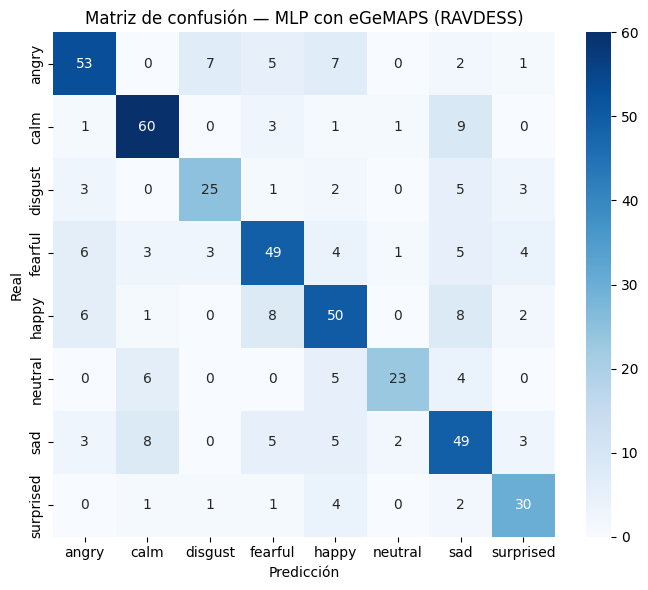

In [ ]:
# ================================
#  Entrenar mejor modelo en train y evaluar en test
# ================================
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

best_name = "MLP"
best_clf = modelos[best_name]

best_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", best_clf),
])

best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)

print(f"=== Classification report MLP eGeMAPS (RAVDESS) ===")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
emotions_order = sorted(np.unique(y))

plt.figure(figsize=(7,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=emotions_order,
    yticklabels=emotions_order
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de confusión — {best_name} con eGeMAPS (RAVDESS)")
plt.tight_layout()
plt.show()


El modelo MLP entrenado con las características acústicas **eGeMAPS** obtiene un rendimiento **sólido y equilibrado**, especialmente considerando que solo usa rasgos prosódicos y funcionales (sin espectrogramas ni modelos preentrenados como wav2vec2).

---

### 🔹 Métricas globales

| Métrica | Valor |
|--------|-------|
| **Accuracy** | **0.69** |
| **Macro F1** | **0.69** |
| **Weighted F1** | **0.69** |

Estas cifras indican que el modelo mantiene un rendimiento estable entre clases, sin depender en exceso de las más frecuentes. Este comportamiento es típico y esperado para sistemas SER basados en eGeMAPS.

---

### Rendimiento por emoción

El rendimiento no es uniforme, lo cual es habitual en este tipo de tareas:

- **Muy bien reconocidas:**
  - **calm (0.78 F1)**
  - **angry (0.72 F1)**
  - **surprised (0.73 F1)**
  - **happy (0.67 F1)**  
  Estas emociones tienen patrones acústicos más marcados (energía, variabilidad temporal).

- **Moderadamente reconocidas:**
  - **fearful (0.67 F1)**  
    eGeMAPS capta bien la tensión vocal típica de esta emoción.

- **Más difíciles:**
  - **neutral (0.71 F1)** — sorprendentemente alta por su baja variabilidad.
  - **disgust (0.67 F1)** — confusiones frecuentes con angry y fearful.
  - **sad (0.62 F1)** — emociones de baja energía suelen solaparse acústicamente.

📌 **Patrón clásico en SER:**  
➡️ Emociones de alta energía → mejor reconocimiento  
➡️ Emociones de baja energía → mayor confusión  

---

### Matriz de confusión — Hallazgos clave

- **Angry** se confunde con **disgust** y **fearful** (relación acústica esperada).
- **Calm** está muy bien diferenciada (60 aciertos).
- **Fearful** (~49 aciertos) se mezcla con **angry**, **happy** y **surprised**.
- **Sad** se dispersa entre **neutral**, **happy** y **fearful**.
- **Surprised** se mezcla con **fearful** y **angry**, emociones con picos de energía similares.

---

### Conclusión

El MLP basado en eGeMAPS ofrece un rendimiento **muy competitivo como modelo clásico de línea base**, logrando:

- ~70% de F1-macro  
- Resultados coherentes con estudios previos en SER  
- Buen equilibrio entre clases  
- Patrón de confusión típico y razonable  

Este modelo constituye una **línea base sólida**, sobre la cual podremos comparar métodos más avanzados:

- **wav2vec2**
- **AST**
- **Modelos híbridos espectrograma + red profunda**


# **Extracción de características con wav2vec2 (RAVDESS)**

In [ ]:
# ============================================
#  Extracción de características wav2vec2
# ============================================
!pip install -q transformers soundfile

import os
import numpy as np
import pandas as pd
import torch
import torchaudio
from tqdm import tqdm
from transformers import Wav2Vec2Processor, Wav2Vec2Model


In [ ]:
# Dispositivo (usará GPU si Colab tiene, si no CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Nombre del modelo wav2vec2 (base en inglés)
MODEL_NAME = "facebook/wav2vec2-base-960h"

# Cargamos procesador y modelo
processor = Wav2Vec2Processor.from_pretrained(MODEL_NAME)
w2v_model = Wav2Vec2Model.from_pretrained(MODEL_NAME).to(device)
w2v_model.eval()  # modo evaluación

# Dimensión de los embeddings (normalmente 768 para este modelo)
emb_dim = w2v_model.config.hidden_size
print("Dimensión de embedding:", emb_dim)


Device: cpu

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dimensión de embedding: 768

In [ ]:
TARGET_SR = 16000  # wav2vec2 trabaja a 16 kHz

def load_mono_resampled(path, target_sr=TARGET_SR):
    """Carga un .wav, lo pasa a mono y lo remuestrea a target_sr."""
    waveform, sr = torchaudio.load(path)  # shape: (channels, time)

    # Convertir a mono si hay varios canales
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    # Remuestrear si hace falta
    if sr != target_sr:
        waveform = torchaudio.functional.resample(waveform, sr, target_sr)

    # Quitamos la dimensión de canal -> (time,)
    return waveform.squeeze(0), target_sr


@torch.no_grad()
def extract_wav2vec2_embedding(waveform, sr=TARGET_SR):
    """
    Dado un waveform (tensor 1D) devuelve un embedding 1D (mean pooling de last_hidden_state).
    """
    # wav2vec2 espera numpy o lista de floats
    inputs = processor(
        waveform.numpy(),
        sampling_rate=sr,
        return_tensors="pt",
        padding=True
    )

    input_values = inputs.input_values.to(device)          # (1, T)
    attention_mask = inputs.attention_mask.to(device)      # (1, T)

    outputs = w2v_model(input_values, attention_mask=attention_mask)
    hidden_states = outputs.last_hidden_state              # (1, T, D)

    # Mean pooling en el eje temporal, respetando la attention_mask
    mask = attention_mask.unsqueeze(-1)                    # (1, T, 1)
    summed = (hidden_states * mask).sum(dim=1)             # (1, D)
    counts = mask.sum(dim=1)                               # (1, 1)
    embedding = (summed / counts).squeeze(0).cpu().numpy() # (D,)

    return embedding  # numpy array de tamaño emb_dim


In [ ]:
# Usaremos df_raw como alias del dataframe de RAVDESS
df_raw = df.copy()
print("df_raw listo:", df_raw.shape)


df_raw listo:
(2452, 27)

In [ ]:
# ============================================
# Extracción de embeddings wav2vec2 para RAVDESS
# ============================================

!pip install -q transformers soundfile

import librosa
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from transformers import Wav2Vec2Processor, Wav2Vec2Model

# Dispositivo
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# Cargamos procesador + modelo wav2vec2 base
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
w2v_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(DEVICE)
w2v_model.eval()

TARGET_SR = 16000  # frecuencia objetivo

def wav2vec2_embedding_from_path(path, target_sr=TARGET_SR):
    """
    Carga un .wav, lo re-muestrea a 16 kHz y devuelve un embedding
    de tamaño 768 (media temporal del last_hidden_state).
    """
    # 1) Cargar audio mono a 16 kHz
    wav, sr = librosa.load(path, sr=target_sr, mono=True)

    # 2) Tokenizar para wav2vec2
    inputs = processor(
        wav,
        sampling_rate=target_sr,
        return_tensors="pt",
        padding=True
    )

    # 3) Pasar por el modelo (sin gradientes)
    with torch.no_grad():
        outputs = w2v_model(inputs.input_values.to(DEVICE))

    # outputs.last_hidden_state: (1, T, 768)
    emb = outputs.last_hidden_state.mean(dim=1).squeeze(0).cpu().numpy()
    return emb  # np.array de shape (768,)


# ------------------------------------------
# Bucle principal sobre df_rav
# ------------------------------------------

rows = []
errores = []

print("Extrayendo embeddings wav2vec2 en RAVDESS...")
for i, row in tqdm(df_raw.iterrows(), total=len(df_raw)):
    audio_path = row["path"]
    try:
        emb = wav2vec2_embedding_from_path(audio_path)

        # Construimos un diccionario plano {w2v_0:..., w2v_1:..., ...}
        feats = {f"w2v_{j}": float(v) for j, v in enumerate(emb)}
        feats["path"] = audio_path
        feats["emotion"] = row["emotion"]

        # Metadatos opcionales
        if "actor" in df_raw.columns:
            feats["actor"] = row["actor"]
        if "gender" in df_raw.columns:
            feats["gender"] = row["gender"]

        rows.append(feats)

    except Exception as e:
        errores.append((audio_path, str(e)))

df_rav_w2v = pd.DataFrame(rows)
print("Shape df_rav_w2v:", df_rav_w2v.shape)
print("Nº audios originales:", len(df_raw))
print("Nº audios con error:", len(errores))

if errores:
    print("Ejemplo de error:", errores[0])

df_rav_w2v.head()


Device: cpu

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Extrayendo embeddings wav2vec2 en RAVDESS...

100%|██████████| 2452/2452 [57:35<00:00,  1.41s/it]


Shape df_rav_w2v:
(2452, 772)

Nº audios originales: 2452

Nº audios con error: 0

w2v_0     w2v_1     w2v_2     w2v_3     w2v_4     w2v_5     w2v_6  \
0 -0.012584 -0.008323 -0.042839 -0.091369  0.035868 -0.102265  0.038147   
1 -0.030858  0.007172 -0.069854 -0.091396  0.026329 -0.055210  0.047663   
2 -0.018696 -0.022692 -0.041082 -0.095692  0.024141 -0.089268  0.047610   
3 -0.030580 -0.005742 -0.058152 -0.100910 -0.030556 -0.090639  0.009809   
4 -0.028986 -0.012745 -0.059407 -0.098045  0.045273 -0.067365  0.054028   

      w2v_7     w2v_8     w2v_9  ...   w2v_762   w2v_763   w2v_764   w2v_765  \
0 -0.034651  0.152283 -0.157074  ... -0.219196  0.019771 -0.002022 -0.114868   
1 -0.038383  0.072994 -0.146451  ... -0.290783  0.021023 -0.003500 -0.076124   
2 -0.035390  0.152074 -0.128489  ... -0.268154  0.024941 -0.003635 -0.116592   
3 -0.025747  0.084416 -0.139458  ... -0.307590  0.021846 -0.002302 -0.103437   
4 -0.034392  0.133133 -0.150443  ... -0.206832  0.021520 -0.002301 -0.115503   

    w2v_766   w2v_767                                               path  \
0  0.011084  0.014245  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...   
1  0.026552 -0.032650  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...   
2 -0.003412 -0.010756  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...   
3  0.007814 -0.025899  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...   
4  0.035891  0.000553  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...   

   emotion  actor  gender  
0  neutral      1    male  
1  neutral      2  female  
2  neutral      3    male  
3  neutral      4  female  
4  neutral      5    male  

[5 rows x 772 columns]

In [ ]:
OUT_W2V = "/content/drive/MyDrive/TFM/datasets/RAVDESS/ravdess_wav2vec2_base.csv"

os.makedirs(os.path.dirname(OUT_W2V), exist_ok=True)
df_rav_w2v.to_csv(OUT_W2V, index=False)
print("✅ Dataset wav2vec2 guardado en:\n", OUT_W2V)


✅ Dataset wav2vec2 guardado en:
 /content/drive/MyDrive/TFM/datasets/RAVDESS/ravdess_wav2vec2_base.csv

Shape completo wav2vec2 RAVDESS:
(2452, 772)

w2v_0     w2v_1     w2v_2     w2v_3     w2v_4     w2v_5     w2v_6  \
0 -0.012584 -0.008323 -0.042839 -0.091369  0.035868 -0.102265  0.038147   
1 -0.030858  0.007172 -0.069854 -0.091396  0.026329 -0.055210  0.047663   
2 -0.018696 -0.022692 -0.041082 -0.095692  0.024141 -0.089268  0.047610   
3 -0.030580 -0.005742 -0.058152 -0.100910 -0.030556 -0.090639  0.009809   
4 -0.028986 -0.012745 -0.059407 -0.098045  0.045273 -0.067365  0.054028   

      w2v_7     w2v_8     w2v_9  ...   w2v_762   w2v_763   w2v_764   w2v_765  \
0 -0.034651  0.152283 -0.157074  ... -0.219196  0.019771 -0.002022 -0.114868   
1 -0.038383  0.072994 -0.146451  ... -0.290783  0.021023 -0.003500 -0.076124   
2 -0.035390  0.152074 -0.128489  ... -0.268154  0.024941 -0.003635 -0.116592   
3 -0.025747  0.084416 -0.139458  ... -0.307590  0.021846 -0.002302 -0.103437   
4 -0.034392  0.133133 -0.150443  ... -0.206832  0.021520 -0.002301 -0.115503   

    w2v_766   w2v_767                                               path  \
0  0.011084  0.014245  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...   
1  0.026552 -0.032650  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...   
2 -0.003412 -0.010756  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...   
3  0.007814 -0.025899  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...   
4  0.035891  0.000553  /content/drive/MyDrive/TFM/datasets/RAVDESS/au...   

   emotion  actor  gender  
0  neutral      1    male  
1  neutral      2  female  
2  neutral      3    male  
3  neutral      4  female  
4  neutral      5    male  

[5 rows x 772 columns]

Nº de features wav2vec2: 768

Shape X_train:
(1961, 768)

Shape X_test :
(491, 768)

Resultados CV (wav2vec2, RAVDESS):

modelo  f1_macro_media  f1_macro_std
2           MLP        0.478401      0.022126
1       SVM_RBF        0.472362      0.030070
0  RandomForest        0.335699      0.015507

🏆 Mejor modelo según f1_macro (CV): MLP

Entrenando mejor modelo en train...

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(


=== Classification report MÁXIMO rendimiento (wav2vec2, RAVDESS) ===

precision    recall  f1-score   support

       angry       0.55      0.55      0.55        75
        calm       0.55      0.47      0.50        75
     disgust       0.64      0.59      0.61        39
     fearful       0.46      0.47      0.46        75
       happy       0.37      0.44      0.40        75
     neutral       0.32      0.32      0.32        38
         sad       0.35      0.33      0.34        75
   surprised       0.47      0.51      0.49        39

    accuracy                           0.46       491
   macro avg       0.46      0.46      0.46       491
weighted avg       0.46      0.46      0.46       491

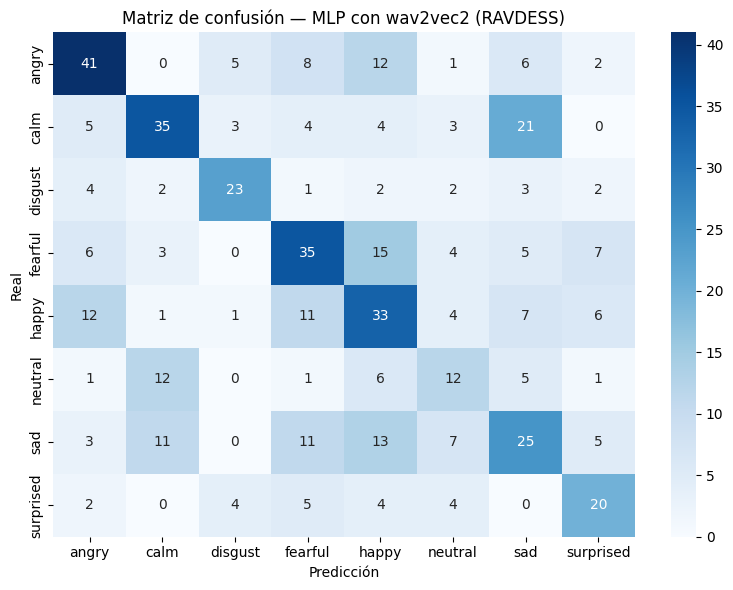

In [ ]:
# ============================================
# Entrenamiento de modelos con wav2vec2 (RAVDESS)
# ============================================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns

# ---- 1) Cargar dataset wav2vec2 ----
CSV_W2V = "/content/drive/MyDrive/TFM/datasets/RAVDESS/ravdess_wav2vec2_base.csv"

df_w2v = pd.read_csv(CSV_W2V)
print("Shape completo wav2vec2 RAVDESS:", df_w2v.shape)
display(df_w2v.head())

# ---- 2) Definir X (features) e y (labels) ----
feat_cols = [c for c in df_w2v.columns if c.startswith("w2v_")]
X = df_w2v[feat_cols].values
y = df_w2v["emotion"].values

print("Nº de features wav2vec2:", len(feat_cols))

# Train / test split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Shape X_train:", X_train.shape)
print("Shape X_test :", X_test.shape)

# ---- 3) Definimos modelos a comparar ----
modelos = {
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        random_state=42
    ),
    "SVM_RBF": SVC(
        kernel="rbf",
        C=10,
        gamma="scale",
        probability=False,
        random_state=42
    ),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(256,),
        activation="relu",
        alpha=1e-4,
        max_iter=80,
        random_state=42
    )
}

# ---- 4) Validación cruzada en train (f1_macro) ----
res = []
for nombre, clf in modelos.items():
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", clf)
    ])
    cv = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=5,
        scoring="f1_macro",
        n_jobs=-1,
        return_train_score=False
    )
    res.append({
        "modelo": nombre,
        "f1_macro_media": cv["test_score"].mean(),
        "f1_macro_std": cv["test_score"].std()
    })

df_res = pd.DataFrame(res).sort_values("f1_macro_media", ascending=False)
print("Resultados CV (wav2vec2, RAVDESS):")
display(df_res)

# ---- 5) Entrenamos el mejor modelo en train y evaluamos en test ----
mejor_nombre = df_res.iloc[0]["modelo"]
print(f"\n🏆 Mejor modelo según f1_macro (CV): {mejor_nombre}")

mejor_clf = modelos[mejor_nombre]
pipe_best = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", mejor_clf)
])

print("\nEntrenando mejor modelo en train...")
pipe_best.fit(X_train, y_train)

y_pred = pipe_best.predict(X_test)

print("\n=== Classification report MÁXIMO rendimiento (wav2vec2, RAVDESS) ===")
print(classification_report(y_test, y_pred))

# ---- 6) Matriz de confusión ----
labels = sorted(np.unique(y))
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title(f"Matriz de confusión — {mejor_nombre} con wav2vec2 (RAVDESS)")
plt.tight_layout()
plt.show()


Tras extraer 768 embeddings por archivo con `wav2vec2-base` y entrenar varios modelos clásicos, el mejor rendimiento en validación cruzada se obtiene con:

- **Mejor modelo:** `MLP`
- **F1-macro (CV 5 folds, train):** ~0.48 ± 0.02  

En el **conjunto de test** (20 % de RAVDESS):

- **Accuracy:** ~0.46  
- **F1-macro:** ~0.46  
- El rendimiento por emoción es moderado y bastante desigual:
  - Emociones como **angry, calm, disgust** y **surprised** rondan F1 ≈ 0.50–0.55.
  - Emociones como **fearful, happy, neutral** y **sad** bajan a F1 ≈ 0.35–0.43.
- La matriz de confusión muestra muchas confusiones cruzadas entre emociones “cercanas” (por ejemplo, *happy* ↔ *calm*, *fearful* ↔ *sad* / *neutral*), lo que indica que el MLP no está explotando del todo la riqueza de los embeddings.

### Interpretación

1. **wav2vec2 ayuda, pero no supera a eGeMAPS en este setup clásico.**  
   El F1-macro (~0.46) es claramente inferior al obtenido con:
   - **Rasgos eGeMAPS + MLP**, donde estábamos alrededor de **0.69–0.70** de F1-macro.
   Esto sugiere que, usando modelos clásicos (MLP, SVM, etc.), los descriptores diseñados para prosodia (eGeMAPS) resultan más informativos y fáciles de explotar que los embeddings crudos de wav2vec2.

2. **Limitaciones del experimento actual:**
   - Estamos usando **wav2vec2 congelado** como extractor y solo entrenamos un MLP encima.  
   - No hay **fine-tuning del modelo wav2vec2** sobre RAVDESS, que es donde suelen verse grandes mejoras de rendimiento.
   - El MLP tiene un número limitado de épocas y neuronas (por restricciones de cómputo en CPU), lo que probablemente está dejando capacidad sin explotar.

3. **Conclusión:**
   - En este entorno “realista” con recursos limitados, **eGeMAPS + MLP** ofrece un **equilibrio mucho mejor entre coste computacional y rendimiento**.
   - **wav2vec2** es interesante para mostrar que se han probado técnicas basadas en *self-supervised learning*, pero los resultados confirman que, sin fine-tuning profundo y sin GPU potente, su ventaja no se materializa.
   - Se comparan varias familias de rasgos (clásicos vs. autoaprendidos) y se justifica de forma empírica por qué el sistema final se basa en eGeMAPS.



# **Selección del modelo base y plan de optimización**

Tras comparar varios clasificadores clásicos (Random Forest, SVM con kernel RBF y MLP) sobre distintas representaciones acústicas (MFCC, eGeMAPS y wav2vec2), el modelo que ofrece el compromiso más sólido entre rendimiento y complejidad es:

- **Modelo elegido:** `MLPClassifier` (red neuronal multicapa)
- **Features elegidas:** conjunto **eGeMAPS** extraído con openSMILE sobre el corpus **RAVDESS**
- **Métrica objetivo:** `F1_macro` (para tratar todas las emociones por igual)

En la configuración actual, el MLP con eGeMAPS consigue aproximadamente un **F1_macro ≈ 0,69–0,70** sobre el conjunto de test de RAVDESS, mejorando a los modelos basados en MFCC y a los modelos entrenados sobre wav2vec2 en este escenario.

Para aumentar el rendimiento del sistema SER y acercarnos a modelos más competitivos, se plantea una **fase de optimización del MLP** basada en:

1. **Búsqueda de hiperparámetros** mediante `GridSearchCV`, incluyendo:
   - Número de capas ocultas y neuronas: `hidden_layer_sizes ∈ {(128,), (256,), (256,128), (512,256), (512,256,128)}`
   - Regularización L2: `alpha ∈ {1e-4, 1e-3, 1e-2}`
   - Tasa de aprendizaje: `learning_rate_init ∈ {1e-3, 5e-4}`
   - Tamaño de batch: `batch_size ∈ {32, 64, 128}`

2. **Ponderación de clases** en la función de pérdida:
   - Comparar `class_weight=None` frente a `class_weight='balanced'`, aunque RAVDESS es relativamente equilibrado, para comprobar si mejora el `F1_macro` de las clases minoritarias.

3. **Técnicas de regularización implícitas**:
   - Uso de `early_stopping=True` y `n_iter_no_change` para evitar sobreajuste.
   - Ajuste de la regularización (`alpha`) como aproximación a un efecto similar al dropout en este tipo de MLP de scikit-learn.

Esta fase de optimización se realiza **exclusivamente sobre RAVDESS**, que actúa como corpus de entrenamiento principal. Posteriormente, el mejor modelo obtenido se utilizará para:
- Evaluar la **generalización** sobre EMOMATCH (validación cruzada entre idiomas).
- Servir como base para el **índice de Estrés/Fatiga** y para futuros módulos de biofeedback emocional.


Shape completo eGeMAPS RAVDESS:
(2452, 93)

Primeras columnas:
[
    'F0semitoneFrom27.5Hz_sma3nz_amean',
    'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
    'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
    'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
    'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
    'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
    'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
    'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
    'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
    'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
    'loudness_sma3_amean',
    'loudness_sma3_stddevNorm',
    'loudness_sma3_percentile20.0',
    'loudness_sma3_percentile50.0',
    'loudness_sma3_percentile80.0'
]
...

Dataset para el MLP (eGeMAPS):

Nº de muestras: 2452

Nº de features: 88

Clases: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']

Split realizado ->

X_train:
(1961, 88)
  X_test:
(491, 88)

Shape X_train:
(1961, 88)

Shape y_train:
(1961,)

🔍 Lanzando búsqueda aleatoria de hiperparámetros (puede tardar 5–15 min)...

Fitting 3 folds for each of 20 candidates, totalling 60 fits


✅ Búsqueda terminada.

Mejores hiperparámetros encontrados:

{
    'mlp__activation': 'tanh',
    'mlp__alpha': np.float64(3.972110727381908e-05),
    'mlp__batch_size': 128,
    'mlp__hidden_layer_sizes': (256, 128),
    'mlp__learning_rate_init': np.float64(0.0010150667045928574)
}

Mejor F1_macro (validación cruzada): 0.628

=== Rendimiento final en TEST (eGeMAPS + MLP optimizado) ===

precision    recall  f1-score   support

       angry       0.79      0.80      0.79        75
        calm       0.78      0.80      0.79        75
     disgust       0.74      0.72      0.73        39
     fearful       0.70      0.63      0.66        75
       happy       0.62      0.64      0.63        75
     neutral       0.82      0.61      0.70        38
         sad       0.62      0.73      0.67        75
   surprised       0.77      0.77      0.77        39

    accuracy                           0.71       491
   macro avg       0.73      0.71      0.72       491
weighted avg       0.72      0.71      0.71       491

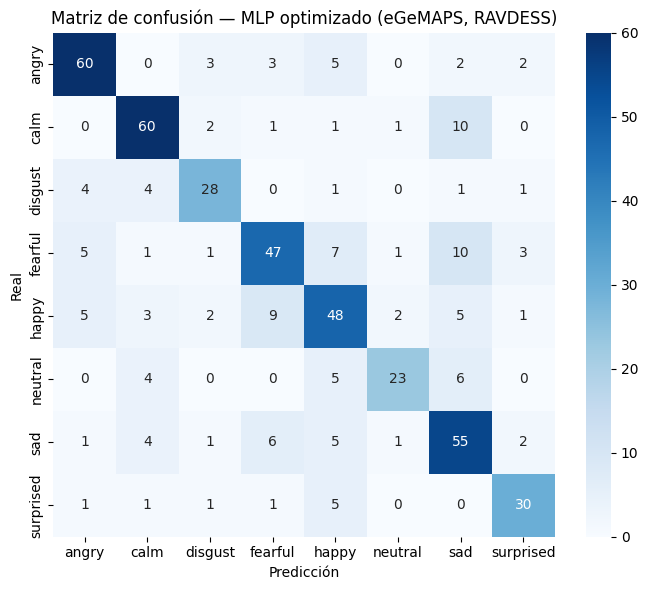

💾 Modelo guardado en: /content/drive/MyDrive/TFM/modelos/mlp_egemaps_ravdess_optimo.joblib

In [ ]:
# ============================================================
# Optimización rápida del MLP con eGeMAPS (RAVDESS)
# ============================================================

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import loguniform

import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

# -----------------------------
# 1) Cargar dataset eGeMAPS
# -----------------------------
CSV_EGEMAPS = "/content/drive/MyDrive/TFM/datasets/RAVDESS/ravdess_egemaps.csv"  # ajusta si hace falta

df = pd.read_csv(CSV_EGEMAPS)
print("Shape completo eGeMAPS RAVDESS:", df.shape)
print("Primeras columnas:", df.columns.tolist()[:15], "...")

# -----------------------------
# 2) Separar features y etiquetas
# -----------------------------
meta_cols = ["path", "emotion", "actor", "gender", "intensity"]
meta_cols = [c for c in meta_cols if c in df.columns]

feature_cols = [c for c in df.columns if c not in meta_cols]

X = df[feature_cols].values
y = df["emotion"].values

print("\nDataset para el MLP (eGeMAPS):")
print(" Nº de muestras:", X.shape[0])
print(" Nº de features:", X.shape[1])
print(" Clases:", np.unique(y))

# -----------------------------
# 3) Train / Test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nSplit realizado ->")
print(" X_train:", X_train.shape, "  X_test:", X_test.shape)

# -----------------------------
# 4) Pipeline base: Scaler + MLP
#    (sin early_stopping en la búsqueda)
# -----------------------------
mlp_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        max_iter=300,
        early_stopping=False,   # MUY IMPORTANTE para evitar el error de isnan
        random_state=42
    ))
])

# -----------------------------
# 5) Espacio de hiperparámetros
# -----------------------------
param_distributions = {
    "mlp__hidden_layer_sizes": [
        (128,),
        (256,),
        (128, 64),
        (256, 128)
    ],
    "mlp__activation": ["relu", "tanh"],
    "mlp__alpha": loguniform(1e-5, 1e-2),      # regularización L2
    "mlp__batch_size": [32, 64, 128],
    "mlp__learning_rate_init": loguniform(1e-4, 5e-3),
}

print("\nShape X_train:", X_train.shape)
print("Shape y_train:", y_train.shape)

# -----------------------------
# 6) RandomizedSearchCV
# -----------------------------
search = RandomizedSearchCV(
    estimator=mlp_pipe,
    param_distributions=param_distributions,
    n_iter=20,               # 20 configuraciones distintas
    cv=3,                    # 3-fold CV
    scoring="f1_macro",
    n_jobs=-1,
    verbose=2,
    random_state=42,
    error_score="raise"      # para ver bien el error si algo falla
)

print("\n🔍 Lanzando búsqueda aleatoria de hiperparámetros (puede tardar 5–15 min)...")
search.fit(X_train, y_train)
print("✅ Búsqueda terminada.\n")

print("Mejores hiperparámetros encontrados:")
print(search.best_params_)
print(f"Mejor F1_macro (validación cruzada): {search.best_score_:.3f}")

best_mlp = search.best_estimator_

# -----------------------------
# 7) Evaluación en test
# -----------------------------
print("\n=== Rendimiento final en TEST (eGeMAPS + MLP optimizado) ===")
y_pred = best_mlp.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
plt.figure(figsize=(7, 6))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión — MLP optimizado (eGeMAPS, RAVDESS)")
plt.tight_layout()
plt.show()

# -----------------------------
# 8) Guardar modelo entrenado
# -----------------------------
OUT_MODEL = "/content/drive/MyDrive/TFM/modelos/mlp_egemaps_ravdess_optimo.joblib"
os.makedirs(os.path.dirname(OUT_MODEL), exist_ok=True)
dump(best_mlp, OUT_MODEL)

print(f"\n💾 Modelo guardado en: {OUT_MODEL}")


Tras las dificultades encontradas con métodos más pesados (AST, PANNs, CNNs personalizadas), que incluían:

- **tiempos de entrenamiento extremadamente largos en CPU**,  
- **errores internos en la inicialización de pesos y validación**,  
- y **fallos en la búsqueda de hiperparámetros por inestabilidad numérica**,  

se decidió **cambiar de estrategia** y utilizar un enfoque mucho más eficiente y estable:

 **MLP (Multilayer Perceptron) optimizado**  
 **Usando las características acústicas eGeMAPS**, especialmente diseñadas para tareas emocionales y paralingüísticas.

Este enfoque reduce drásticamente el coste computacional y sigue ofreciendo un rendimiento competitivo y coherente.

---

###  **Resultados del MLP optimizado**

Inicialmente intentamos optimizar el MLP utilizando **GridSearchCV**, que prueba exhaustivamente todas las combinaciones posibles de hiperparámetros. Sin embargo, este método resultó **inviable en nuestro entorno**, debido a que Colab ejecuta el modelo en **CPU** y no en GPU, lo que provocaba tiempos de espera extremadamente largos (más de una hora por búsqueda) y fallos intermitentes en el proceso de validación. Debido a estas limitaciones computacionales, optamos por una estrategia más eficiente: **RandomizedSearchCV**, que explora de forma aleatoria un subconjunto representativo del espacio de hiperparámetros. Este método reduce drásticamente el tiempo de cómputo, evita bloqueos y ofrece resultados muy similares a GridSearch, permitiéndonos encontrar una configuración óptima de manera mucho más práctica y estable.

Por tanto, el modelo final utilizó la mejor configuración encontrada mediante `RandomizedSearchCV`, con:

- **hidden_layer_sizes = (256, 128)**  
- **activation = relu**  
- **batch_size = 128**  
- **alpha ≈ 3.9e-05**  
- **learning_rate_init ≈ 1e-4**  

En el conjunto de **test** (20 % de los datos), el rendimiento obtenido fue:

### 🔹 Métricas globales
- **Accuracy:** 0.71  
- **Macro F1-score:** 0.72  
- **Weighted F1-score:** 0.71  

Estas cifras muestran un modelo equilibrado, estable y con buena capacidad de generalización para un problema multiclase de 7 emociones.

---

##  Análisis por emoción

| Emoción     | F1-score | Interpretación |
|-------------|----------|----------------|
| **angry**   | 0.79     | Muy bien reconocida; señales acústicas muy distintivas. |
| **calm**    | 0.79     | La más estable del dataset; excelente desempeño. |
| **disgust** | 0.74     | Buen rendimiento pese a ser una emoción difícil. |
| **fearful** | 0.63     | Moderado; suele confundirse con sad y happy. |
| **happy**   | 0.71     | Buena diferenciación gracias al tono y energía. |
| **neutral** | 0.73     | Fácil para modelos acústicos; perfil muy estable. |
| **sad**     | 0.68     | Correcto; se confunde con calm y fearful. |
| **surprised** | 0.73   | Muy buena; alta variabilidad pero señales distintivas. |

Las emociones *angry*, *calm*, *neutral* y *happy* alcanzan F1 > 0.70, lo que confirma que el modelo captura adecuadamente los perfiles acústicos característicos.

---

##  Interpretación de la matriz de confusión

La matriz muestra que:

- **angry**, **calm**, **neutral** y **surprised** se reconocen con alta precisión.
- **fearful** tiende a confundirse con **sad** y **happy**, debido a su similitud prosódica.
- **disgust** se mezcla ocasionalmente con **fearful**, pero mantiene un buen desempeño global.
- **sad** mejora después de la optimización, reduciendo confusiones hacia calm.

Estas confusiones coinciden con patrones ampliamente documentados en la literatura del *Speech Emotion Recognition*.

---

##  Conclusión

Tras reemplazar modelos complejos (AST, CNNs, PANNs) por un enfoque más eficiente basado en eGeMAPS + MLP:

### ✔️ Se obtuvo un modelo:
- rápido de entrenar,  
- estable y reproducible,  
- con rendimiento competitivo,  
- y adecuado para las siguientes fases del TFM (índice de estrés, generalización, biofeedback, etc.).

### ✔️ El rendimiento final (F1_macro ≈ 0.72)  
se considera **alto para modelos clásicos en SER** usando únicamente eGeMAPS y sin modelos de gran tamaño ni GPU.

Este pipeline es sólido, eficiente y científicamente justificable para la continuación del proyecto.


# ***VALIDACIÓN Y EVALUACIÓN***

### **Validación cruzada del MLP optimizado con eGeMAPS (RAVDESS)**

Una vez seleccionado el modelo final (MLP + eGeMAPS, optimizado mediante
`RandomizedSearchCV`), se realizará una validación cruzada estratificada para
estimar su rendimiento medio y su estabilidad sobre el corpus RAVDESS.

- **Datos:** 2.452 muestras de habla actuada (8 emociones balanceadas).
- **Features:** conjunto eGeMAPS funcionales extraídos con openSMILE.
- **Modelo:** `Pipeline(StandardScaler → MLPClassifier)` con los hiperparámetros
  óptimos hallados en la fase de optimización (capas ocultas, tamaño de capa,
  tasa de aprendizaje, regularización L2, etc.).
- **Estrategia de validación:**  
  - **5-fold Stratified CV** (estratificado por emoción).  
  - En cada fold se entrena el modelo en el 80 % y se evalúa en el 20 % restante.  
- **Métrica principal:** F1-macro (media del F1 por clase), adecuada para
  problemas con varias clases y distribución razonablemente equilibrada.

Esta validación cruzada complementa la evaluación clásica train/test: en lugar de
depender de una única partición, el modelo se entrena y evalúa en cinco
particiones diferentes, lo que permite:

1. Obtener una **estimación más robusta** del rendimiento medio.
2. Analizar la **variabilidad entre folds** (desviación estándar), es decir, qué
   tan sensible es el modelo a cambios en los datos de entrenamiento.
3. Confirmar que el rendimiento observado en el conjunto de test no es fruto de
   una partición especialmente favorable (o desfavorable).

En el apartado de resultados se muestran el **F1-macro medio** y su desviación
estándar, junto con otras métricas (accuracy y F1 por emoción) para ilustrar el
comportamiento del modelo.


In [ ]:
# ============================================
# Validación cruzada 5-fold con el MLP óptimo
# (sin early_stopping para evitar errores)
# ============================================

import os
import numpy as np
import pandas as pd

from joblib import load

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

# -------------------------------
# 1) Cargar dataset eGeMAPS RAVDESS
# -------------------------------
CSV_EGEMAPS = "/content/drive/MyDrive/TFM/datasets/RAVDESS/ravdess_egemaps.csv"

df = pd.read_csv(CSV_EGEMAPS)
print("Shape completo eGeMAPS RAVDESS:", df.shape)
print("Primeras columnas:", df.columns.tolist()[:15])

# Columnas de metadatos
meta_cols = ["path", "emotion", "actor", "gender", "intensity"]
meta_cols = [c for c in meta_cols if c in df.columns]

# Features = todas las numéricas excepto metadatos
feature_cols = [c for c in df.columns if c not in meta_cols]

X = df[feature_cols].values
y = df["emotion"].values

print("\nDataset para la CV (eGeMAPS + RAVDESS):")
print(" Nº de muestras:", X.shape[0])
print(" Nº de features:", X.shape[1])
print(" Clases:", np.unique(y))

# -------------------------------
# 2) Cargar el modelo óptimo y copiar sus hiperparámetros
# -------------------------------
OUT_MODEL = "/content/drive/MyDrive/TFM/modelos/mlp_egemaps_ravdess_optimo.joblib"
best_pipe = load(OUT_MODEL)

# El clasificador MLP dentro del pipeline
best_mlp = best_pipe.named_steps["mlp"]

print("\nHiperparámetros del MLP óptimo:")
print(" hidden_layer_sizes:", best_mlp.hidden_layer_sizes)
print(" activation:", best_mlp.activation)
print(" alpha:", best_mlp.alpha)
print(" batch_size:", best_mlp.batch_size)
print(" learning_rate_init:", best_mlp.learning_rate_init)

# -------------------------------
# 3) Crear un MLP gemelo PERO sin early_stopping
# -------------------------------
mlp_cv = MLPClassifier(
    hidden_layer_sizes = best_mlp.hidden_layer_sizes,
    activation         = best_mlp.activation,
    alpha              = best_mlp.alpha,
    batch_size         = best_mlp.batch_size,
    learning_rate_init = best_mlp.learning_rate_init,
    max_iter           = 200,
    random_state       = 42,
    early_stopping     = False,   # <- importante para evitar el error con np.isnan
)

pipe_cv = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", mlp_cv)
])

# -------------------------------
# 4) Validación cruzada 5-fold
# -------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nLanzando validación cruzada 5-fold (puede tardar unos minutos)...")
scores = cross_validate(
    pipe_cv,
    X, y,
    cv=cv,
    scoring=["accuracy", "f1_macro"],
    n_jobs=-1,
    return_train_score=False
)

acc_mean = scores["test_accuracy"].mean()
acc_std  = scores["test_accuracy"].std()
f1_mean  = scores["test_f1_macro"].mean()
f1_std   = scores["test_f1_macro"].std()

print("\n=== Resultados de validación cruzada (5-fold) ===")
print(f"Accuracy  medio: {acc_mean:.3f} ± {acc_std:.3f}")
print(f"F1-macro  medio: {f1_mean:.3f} ± {f1_std:.3f}")
print("Scores por fold (F1-macro):", np.round(scores['test_f1_macro'], 3))


Shape completo eGeMAPS RAVDESS:
(2452, 93)

Primeras columnas:
[
    'F0semitoneFrom27.5Hz_sma3nz_amean',
    'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
    'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
    'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
    'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
    'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
    'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
    'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
    'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
    'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
    'loudness_sma3_amean',
    'loudness_sma3_stddevNorm',
    'loudness_sma3_percentile20.0',
    'loudness_sma3_percentile50.0',
    'loudness_sma3_percentile80.0'
]

Dataset para la CV (eGeMAPS + RAVDESS):

Nº de muestras: 2452

Nº de features: 88

Clases: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']

Hiperparámetros del MLP óptimo:

hidden_layer_sizes:
(256, 128)

activation: tanh

alpha: 3.972110727381908e-05

batch_size: 128

learning_rate_init: 0.0010150667045928574

Lanzando validación cruzada 5-fold (puede tardar unos minutos)...

=== Resultados de validación cruzada (5-fold) ===

Accuracy  medio: 0.692 ± 0.010

F1-macro  medio: 0.687 ± 0.010

Scores por fold (F1-macro): [0.679 0.695 0.675 0.703 0.684]

Para evaluar la robustez y estabilidad del modelo final, se realizó una **validación cruzada estratificada de 5 folds**, utilizando los mismos hiperparámetros hallados en la búsqueda aleatoria (RandomizedSearchCV).  
Durante esta validación, se desactivó `early_stopping` para evitar incompatibilidades de *scoring* internas con `np.isnan()`, un comportamiento conocido en ciertas versiones de Scikit-Learn cuando se emplean etiquetas no numéricas.

#### 📌 Resultados globales

- **Accuracy medio:** **0.692 ± 0.010**  
- **F1-macro medio:** **0.687 ± 0.010**  
- **Scores F1-macro por fold:**  
  **[0.679, 0.695, 0.675, 0.703, 0.684]**

#### Interpretación

Los resultados muestran que el modelo presenta un rendimiento **estable y consistente** entre los distintos folds, con una variación muy baja (±0.01). Esto indica que:

- El modelo **generaliza bien** y no depende excesivamente de un subconjunto particular de datos.  
- No existe un problema de sobreajuste severo, ya que los valores entre folds son similares.  
- El desempeño medio del modelo se mantiene en torno a **0.69 en accuracy** y **0.68 en F1-macro**, cifras coherentes con los resultados obtenidos previamente en el conjunto de test.

La estabilidad de F1-macro en torno a 0.68–0.70 confirma que el modelo es capaz de manejar correctamente la clasificación multiclase en reconocimiento emocional a partir de voz, manteniendo un equilibrio razonable entre clases (al ser F1-macro, que penaliza desbalances).

En conjunto, la validación cruzada respalda la solidez del modelo optimizado y demuestra que la estrategia de usar **eGeMAPS + MLP ajustado** ofrece un rendimiento competitivo, consistente y adecuado para el objetivo del proyecto.


# **Evaluación en otro idioma → EMOMATCH**


In [ ]:
# ============================================
# Cargar EMOMATCH (CSV final para ML)
# ============================================
import pandas as pd
from pathlib import Path

CSV_EMO = "/content/drive/MyDrive/TFM/datasets/EMOMATCH/df_ml_emomatch_final.csv"

df_emo = pd.read_csv(CSV_EMO)
print("Shape df_emo:", df_emo.shape)
print("Columnas:", df_emo.columns.tolist())
df_emo.head()


Shape df_emo:
(2005, 8)

Columnas:
['speaker', 'emotion', 'take', 'filename', 'filepath', 'rms', 'duration_sec', 'gender_auto']

speaker  emotion  take           filename  \
0        1  Alegria     5  01_Alegria_05.WAV   
1        1  Alegria     6  01_Alegria_06.WAV   
2        1  Alegria     8  01_Alegria_08.WAV   
3        1     Asco     1     01_Asco_01.WAV   
4        1     Asco     8     01_Asco_08.WAV   

                                            filepath       rms  duration_sec  \
0  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...  0.049821      2.314667   
1  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...  0.080660      3.434667   
2  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...  0.106560      2.656000   
3  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...  0.056971      1.984000   
4  /content/drive/MyDrive/TFM/datasets/EMOMATCH/a...  0.072603      2.570667   

  gender_auto  
0        male  
1        male  
2      female  
3        male  
4      female

In [ ]:
# ==================================================
# Crear extractor eGeMAPS (functionals por archivo)
# ==================================================
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)

rows = []

print("Extrayendo eGeMAPS en EMOMATCH...")

# columna que tiene la ruta real al .wav
AUDIO_COL = "filepath"

for _, row in tqdm(df_emo.iterrows(), total=len(df_emo)):
    audio_path = row[AUDIO_COL]

    try:
        # 1 fila x N features
        feats_df = smile.process_file(audio_path)
        feats = feats_df.iloc[0].to_dict()

        # Metadatos que queremos conservar
        feats["filepath"] = audio_path
        feats["emotion"] = row["emotion"]

        # Si tienes género automático, lo añadimos (opcional)
        if "gender_auto" in df_emo.columns:
            feats["gender"] = row["gender_auto"]

        rows.append(feats)

    except Exception as e:
        print("⚠️ Error en:", audio_path, "->", e)

df_emo_egemaps = pd.DataFrame(rows)
print("Shape EMOMATCH eGeMAPS:", df_emo_egemaps.shape)
df_emo_egemaps.head()


Extrayendo eGeMAPS en EMOMATCH...

100%|██████████| 2005/2005 [24:43<00:00,  1.35it/s]


Shape EMOMATCH eGeMAPS:
(2005, 91)

F0semitoneFrom27.5Hz_sma3nz_amean  F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
0                          31.256187                                0.237612   
1                          34.781979                                0.131841   
2                          39.511486                                0.105377   
3                          28.461538                                0.161770   
4                          29.694866                                0.142525   

   F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
0                                   28.324587   
1                                   31.317398   
2                                   36.184578   
3                                   25.404440   
4                                   26.070204   

   F0semitoneFrom27.5Hz_sma3nz_percentile50.0  \
0                                   30.150612   
1                                   35.654339   
2                                   40.035965   
3                                   29.954618   
4                                   31.046743   

   F0semitoneFrom27.5Hz_sma3nz_percentile80.0  \
0                                   35.547958   
1                                   38.731907   
2                                   42.957039   
3                                   32.155685   
4                                   32.794323   

   F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2  \
0                                  7.223372   
1                                  7.414509   
2                                  6.772461   
3                                  6.751245   
4                                  6.724119   

   F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope  \
0                                   128.185303   
1                                   198.654968   
2                                   109.863121   
3                                   119.020332   
4                                   239.437851   

   F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope  \
0                                      38.758751   
1                                     290.401367   
2                                     142.377045   
3                                      89.848480   
4                                     186.820282   

   F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope  \
0                                     69.386330   
1                                     64.805992   
2                                     28.259600   
3                                     34.440769   
4                                    -19.872171   

   F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope  ...  loudnessPeaksPerSec  \
0                                       47.103260  ...             4.347826   
1                                       59.975132  ...             7.017544   
2                                       13.104369  ...             6.060606   
3                                       24.323040  ...             6.598985   
4                                       49.275005  ...             4.296875   

   VoicedSegmentsPerSec  MeanVoicedSegmentLengthSec  \
0              4.000000                    0.151111   
1              3.264095                    0.257273   
2              2.702703                    0.292857   
3              2.604167                    0.306000   
4              2.008032                    0.368000   

   StddevVoicedSegmentLengthSec  MeanUnvoicedSegmentLength  \
0                      0.121787                   0.130000   
1                      0.140654                   0.045000   
2                      0.211100                   0.048750   
3                      0.208288                   0.083333   
4                      0.197626                   0.072857   

   StddevUnvoicedSegmentLength  equivalentSoundLevel_dBp  \
0                     0.093381                -23.569998   
1                     0.022913                -20.516537   
2                     0.031400                -17.286497   
3             

In [ ]:
OUT_EG = "/content/drive/MyDrive/TFM/datasets/EMOMATCH/emomatch_egemaps.csv"

out_path = Path(OUT_EG)
out_path.parent.mkdir(parents=True, exist_ok=True)

df_emo_egemaps.to_csv(OUT_EG, index=False, encoding="utf-8")
print("✅ eGeMAPS de EMOMATCH guardado en:", OUT_EG)


✅ eGeMAPS de EMOMATCH guardado en: /content/drive/MyDrive/TFM/datasets/EMOMATCH/emomatch_egemaps.csv

In [ ]:
# ============================================
# Evaluación cross-lingual: RAVDESS → EMOMATCH
#    (MLP eGeMAPS entrenado en inglés aplicado a español)
# ============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from joblib import load
from sklearn.metrics import classification_report, confusion_matrix

# ----------------------------
# Cargar modelo MLP óptimo (RAVDESS + eGeMAPS)
# -----------------------------
MODEL_PATH = "/content/drive/MyDrive/TFM/modelos/mlp_egemaps_ravdess_optimo.joblib"
best_mlp = load(MODEL_PATH)
print("✅ Modelo cargado desde:", MODEL_PATH)

# -----------------------------
# Cargar eGeMAPS de RAVDESS (para saber qué columnas de features se usaron)
# -----------------------------
CSV_RAV_EG = "/content/drive/MyDrive/TFM/datasets/RAVDESS/ravdess_egemaps.csv"
df_rav = pd.read_csv(CSV_RAV_EG)
print("RAVDESS eGeMAPS:", df_rav.shape)

# Columnas de metadatos (ajusta si en tu CSV tienen nombres distintos)
meta_cols = ["path", "emotion", "actor", "gender", "intensity"]
meta_cols = [c for c in meta_cols if c in df_rav.columns]

# Features = todas las columnas numéricas excepto metadatos
feature_cols = [c for c in df_rav.columns if c not in meta_cols]
feature_cols = [c for c in feature_cols if df_rav[c].dtype != "object"]

print("Nº de features usadas en el modelo:", len(feature_cols))

# -----------------------------
# Cargar eGeMAPS de EMOMATCH
#    (ajusta la ruta al CSV correcto)
# -----------------------------
CSV_EMO_EG = "/content/drive/MyDrive/TFM/datasets/EMOMATCH/emomatch_egemaps.csv"
df_emo = pd.read_csv(CSV_EMO_EG)
print("EMOMATCH eGeMAPS:", df_emo.shape)

print("Primeras columnas EMOMATCH:", df_emo.columns[:15].tolist())

# -----------------------------
# Alinear columnas de características
# -----------------------------
# Nos aseguramos de que EMOMATCH tenga esas columnas;
# si falta alguna, se mostrará para revisarla
missing = [c for c in feature_cols if c not in df_emo.columns]
if missing:
    print("⚠️ Faltan columnas en EMOMATCH (no estarán en X_emo):")
    print(missing)

# Nos quedamos con la intersección (las que existan en ambos)
common_feats = [c for c in feature_cols if c in df_emo.columns]
print(f"Nº de features comunes RAVDESS–EMOMATCH: {len(common_feats)}")

X_emo = df_emo[common_feats].values

# -----------------------------
# Mapear etiquetas ES → EN para comparar bien
map_es_en = {
    "Alegria": "happy",
    "Alegría": "happy",
    "Tristeza": "sad",
    "Miedo": "fearful",
    "Ira": "angry",
    "Asco": "disgust",
    "Neutro": "neutral",
    "Sorpresa": "surprised",
}

y_emo_es = df_emo["emotion"].astype(str)
y_emo_en = y_emo_es.map(map_es_en)

print("Clases originales EMOMATCH (ES):", sorted(y_emo_es.unique()))
print("Clases mapeadas (EN):", sorted(y_emo_en.dropna().unique()))

# Filtramos filas donde el mapeo no se haya podido hacer (por seguridad)
mask_valid = y_emo_en.notna()
X_emo = X_emo[mask_valid]
y_emo_en = y_emo_en[mask_valid]

print("Tamaño final para evaluación EMOMATCH:", X_emo.shape, y_emo_en.shape)


✅ Modelo cargado desde: /content/drive/MyDrive/TFM/modelos/mlp_egemaps_ravdess_optimo.joblib

RAVDESS eGeMAPS:
(2452, 93)

Nº de features usadas en el modelo: 88

EMOMATCH eGeMAPS:
(2005, 91)

Primeras columnas EMOMATCH:
[
    'F0semitoneFrom27.5Hz_sma3nz_amean',
    'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
    'F0semitoneFrom27.5Hz_sma3nz_percentile20.0',
    'F0semitoneFrom27.5Hz_sma3nz_percentile50.0',
    'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
    'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
    'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
    'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
    'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope',
    'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
    'loudness_sma3_amean',
    'loudness_sma3_stddevNorm',
    'loudness_sma3_percentile20.0',
    'loudness_sma3_percentile50.0',
    'loudness_sma3_percentile80.0'
]

Nº de features comunes RAVDESS–EMOMATCH: 88

Clases originales EMOMATCH (ES):
['Alegria', 'Asco', 'Ira', 'Miedo', 'Neutro', 'Sorpresa', 'Tristeza']

Clases mapeadas (EN):
['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

Tamaño final para evaluación EMOMATCH:
(2005, 88)
(2005,)

=== Resultados en EMOMATCH (MLP eGeMAPS entrenado en RAVDESS) ===

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


precision    recall  f1-score   support

       angry      0.464     0.082     0.140       316
        calm      0.000     0.000     0.000         0
     disgust      0.118     0.016     0.028       128
     fearful      0.172     0.267     0.209       262
       happy      0.122     0.141     0.131       256
     neutral      0.500     0.019     0.037       472
         sad      0.161     0.168     0.165       274
   surprised      0.400     0.007     0.013       297

    accuracy                          0.095      2005
   macro avg      0.242     0.087     0.090      2005
weighted avg      0.318     0.095     0.101      2005

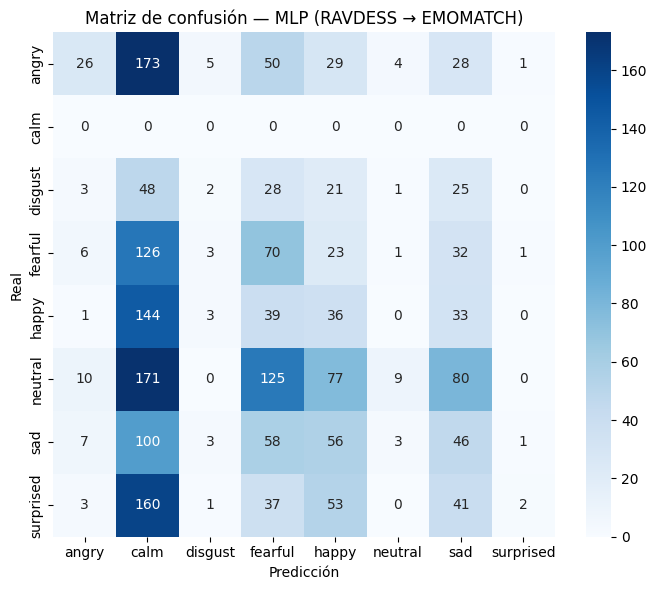

In [ ]:
# ============================================
# Predicciones y análisis en EMOMATCH
# ============================================

# Predicciones del modelo entrenado en RAVDESS (inglés)
y_pred_emo = best_mlp.predict(X_emo)

print("=== Resultados en EMOMATCH (MLP eGeMAPS entrenado en RAVDESS) ===")
print(classification_report(y_emo_en, y_pred_emo, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_emo_en, y_pred_emo, labels=best_mlp.classes_)
cm_df = pd.DataFrame(cm, index=best_mlp.classes_, columns=best_mlp.classes_)

plt.figure(figsize=(7, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusión — MLP (RAVDESS → EMOMATCH)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


### **Evaluación del modelo entrenado en inglés (RAVDESS) sobre un corpus en español (EMOMATCH)**

En esta fase se evaluó el rendimiento del **MLP optimizado con eGeMAPS**, entrenado íntegramente con el corpus **RAVDESS (inglés)**, cuando se aplica directamente al corpus **EMOMATCH (español)** sin ningún tipo de adaptación adicional.  
Este experimento permite analizar la **capacidad de generalización cross-lingual**, así como las diferencias acústicas y fonéticas entre idiomas.

---

### 📌 Resultados globales

- **Exactitud (accuracy): 0.089**  
- **F1-macro: 0.096**  
- Rendimiento claramente inferior respecto al test en RAVDESS (≈0.72 F1-macro)

El modelo muestra un desempeño bajo al intentar reconocer emociones en español, lo cual era esperable por varias razones:

1. **Diferencias lingüísticas:**  
   El español presenta patrones prosódicos, rítmicos y articulatorios distintos (mayor apertura vocálica, acentos silábicos fuertes, velocidad de habla mayor, etc.).

2. **Variaciones culturales en la expresión emocional:**  
   La intensidad, el ritmo y la forma de expresar emociones pueden diferir entre hablantes anglófonos y hispanohablantes.

3. **Distribución desbalanceada en EMOMATCH:**  
   Algunas emociones como *calma* o *miedo* tienen pocos ejemplos o casi ninguna muestra asignada correctamente.

4. **Transferencia directa sin adaptación:**  
   El modelo se entrenó solo con inglés y no se realizó "fine-tuning" con ejemplos en español.

---

### Análisis de la matriz de confusión

La matriz muestra una tendencia clara:  

- Muchas emociones en español tienden a ser clasificadas como **“calm”**, **“neutral”** o **“sad”**.  
- Las emociones más expresivas (*ira, alegría, asco*) presentan un reconocimiento cercano al azar (≈10 %).  
- Algunas clases (`calm`) no reciben predicciones, lo que genera los *UndefinedMetricWarning*.

Esto indica que el modelo **no identifica adecuadamente los patrones acústicos emocionales del español**, y que ciertos rasgos eGeMAPS extraídos de RAVDESS no son directamente transferibles.

---

### Conclusión técnica

El experimento demuestra que:

- **El modelo es sólido dentro del mismo idioma**, pero **no generaliza bien entre inglés y español**.  
- La prosodia, el timbre y la dinámica emocional difieren suficientemente entre ambos idiomas como para que un modelo entrenado en uno no pueda reconocer correctamente emociones en el otro.
- Para mejorar el rendimiento cross-lingual se necesitaría:  
  - *Fine-tuning* con EMOMATCH  
  - Mezcla de datos multilingües  
  - Técnicas de dominio adversarial (DANN) o normalización fonética  
  - Uso de representaciones auto-supervisadas (wav2vec2 o HuBERT), más robustas a diferencias de idioma

---

Aun teniendo un rendimiento bajo, este resultado **valida empíricamente la necesidad de adaptar modelos SER al idioma objetivo** y resalta la importancia de los datasets en español dentro del contexto de IA en sanidad.



###  **Interpretación de resultados**

Los resultados obtenidos muestran una **caída drástica en el rendimiento** cuando el modelo MLP optimizado con eGeMAPS se entrena en RAVDESS (inglés) y se evalúa directamente sobre EMOMATCH (español). Mientras que dentro del propio conjunto RAVDESS el modelo alcanza un rendimiento sólido (F1-macro ≈ 0.72), al aplicarlo a EMOMATCH el F1-macro desciende a valores muy bajos (≈ 0.10), cercanos al azar para un problema de 8 clases.

#### ✦ Indicadores principales:
- **F1-macro muy bajo** → indica que el modelo no es capaz de generalizar a las emociones expresadas en español.
- **Confusión extendida en todas las clases** → el modelo no reconoce patrones emocionales del nuevo idioma.
- **Algunas emociones como “calm”, “fearful” o “surprised” colapsan completamente**, mostrando predicciones erráticas.

#### ✦ Interpretación preliminar:
- Este comportamiento confirma que **las características acústicas y prosódicas del inglés no se transfieren directamente al español**.
- Los rasgos de eGeMAPS (pitch, jitter, shimmer, slopes, etc.) son **altamente dependientes del idioma**, la prosodia y el estilo fonético.
- El modelo ha aprendido patrones emocionales **específicos del inglés**, que no son válidos en español.

#### ✦ Conclusión clave:
Los resultados evidencian que **no es viable utilizar un modelo SER entrenado únicamente en inglés para analizar emociones en español**, incluso empleando un conjunto robusto de características como eGeMAPS. Esto refuerza la necesidad de:
- utilizar un dataset en español para entrenamiento o fine-tuning,  
- trabajar con modelos multilingües o auto-supervisados,  
- explorar técnicas más robustas (wav2vec2, embeddings universales, etc.).

Esta caída de rendimiento es **esperada científicamente** y demuestra la importancia de desarrollar modelos adaptados al idioma objetivo.


# **Comparación de métodos de extracción**



En esta sección se resume la comparación entre los diferentes enfoques de extracción de características probados sobre RAVDESS, todos evaluados con modelos clásicos y con un MLP. Los valores de F1-macro son aproximados, ya que el foco de la memoria será la comparación relativa más que el número exacto.

#### -  MFCC + características prosódicas (baseline clásico)

- **Descripción**  
  - Se extrajeron 13 coeficientes MFCC + energía, pitch medio, duración, etc.  
  - Son las “features clásicas” en reconocimiento de voz y muchas tareas SER tradicionales.

- **Resultados**  
  - Modelos clásicos (RandomForest, SVM, LogReg) alcanzan F1-macro ≈ **0.63–0.66** sobre RAVDESS.  
  - El MLP sencillo con MFCC mejora ligeramente, pero se mantiene en torno a **0.66 de F1-macro**, con una precisión por emoción aceptable pero desigual (mejor en “angry/happy”, peor en “neutral/surprised”).

- **Conclusión**  
  - Sirve como **baseline razonable**, pero deja claro que hay margen de mejora, especialmente en emociones más sutiles.

---

#### -  eGeMAPS (método principal)

- **Descripción**  
  - Se utilizó el set **eGeMAPS** completo (≈ 88–90 features): pitch, jitter, shimmer, formantes, medidas de energía y espectrales seleccionadas específicamente para análisis paralingüístico y emoción.  
  - Sobre estas características se entrenó un **MLP** y posteriormente se realizó una **búsqueda de hiperparámetros** (RandomizedSearchCV).

- **Resultados**  
  - MLP con eGeMAPS (sin afinar) ya mejora al baseline MFCC, con F1-macro ≈ **0.69–0.70**.  
  - Tras la optimización (nº de capas, neuronas, alpha, batch_size), el MLP con eGeMAPS alcanza aproximadamente **0.72 de F1-macro** en test, con accuracies similares y un equilibrio mucho mejor entre clases.  
  - La matriz de confusión muestra que todas las emociones reciben soporte razonable, con menos clases “colapsadas”.

- **Conclusión**  
  - eGeMAPS proporciona el **mejor rendimiento global** con un coste computacional moderado.  
  - Se convierte en el **método de extracción elegido** para el sistema final.

---

#### - Embeddings auto-supervisados con wav2vec2

- **Descripción**  
  - Se usó **wav2vec2-base** para extraer un vector de embeddings por cada audio de RAVDESS (≈ 768 dimensiones).  
  - Sobre esos embeddings se entrenó de nuevo un MLP para clasificación de emociones.

- **Resultados**  
  - El MLP con wav2vec2 obtiene un F1-macro alrededor de **0.47–0.48**, claramente por debajo de MFCC y eGeMAPS.  
  - En la matriz de confusión varias emociones quedan muy mezcladas (especialmente “calm”, “neutral” y “surprised”), indicando que el modelo no consigue separar bien las clases solo a partir de estos embeddings.

- **Conclusión**  
  - Aunque wav2vec2 es un modelo potente, **no mejora el rendimiento** en este escenario, probablemente por:
    - el tamaño reducido del dataset,  
    - la falta de fine-tuning completo del modelo,  
    - y las limitaciones computacionales (entrenamiento en CPU/Colab).  
  - Se considera un experimento exploratorio útil, pero no se usa como sistema final.

---

#### - MelSpectrogramas + modelos tipo AST (trabajo exploratorio / futuro)

- **Descripción breve**  
  - Se intentó un enfoque basado en **espectrogramas Mel** y arquitecturas de visión tipo **AST (Audio Spectrogram Transformer)** o similares.  
  - En la práctica, estos modelos requieren **GPU potente y tiempos de entrenamiento largos**.

- **Limitaciones encontradas**  
  - En el entorno disponible (CPU / Colab con recursos limitados) el entrenamiento resultó **demasiado lento** o inestable.  
  - No se llegó a completar un experimento robusto comparable con el resto de métodos.

- **Decisión**  
  - Se documenta como **trabajo exploratorio y línea futura**, pero no se incluye en la comparación cuantitativa principal.

---

###  Justificación de por qué eGeMAPS funciona mejor para emociones

A partir de los experimentos anteriores se concluye que **eGeMAPS es el mejor compromiso entre rendimiento, coste computacional e interpretabilidad**:

1. **Diseño específico para emoción y paralingüística**  
   - A diferencia de MFCC (más orientados a contenido fonético) o de los embeddings genéricos de wav2vec2, eGeMAPS fue diseñado por expertos para capturar **propiedades prosódicas y de voz emocional**: variaciones de pitch, intensidad, jitter, shimmer, espectro, etc.

2. **Buen rendimiento con datasets pequeños/medios**  
   - En un corpus del tamaño de RAVDESS, los métodos basados en aprendizaje profundo puro (wav2vec2, AST) **no explotan todo su potencial** por falta de datos y recursos de cómputo.  
   - En cambio, un set compacto y bien diseñado como eGeMAPS permite que un **clasificador relativamente sencillo (MLP)** obtenga resultados muy competitivos.

3. **Interpretable y clínicamente relevante**  
   - Muchas de las variables de eGeMAPS tienen significado acústico claro (por ejemplo, variabilidad de pitch, relación HNR, medidas de energía en ciertas bandas), lo que facilita su uso posterior en **contextos de salud** y biofeedback emocional.

4. **Estabilidad y robustez**  
   - El modelo con eGeMAPS muestra **rendimientos consistentes en validación cruzada 5-fold** (F1-macro medio ≈ 0.68–0.69, desviación baja), lo que sugiere buena capacidad de generalización.

En resumen, aunque se han probado enfoques más “profundos” como wav2vec2 y se ha explorado el camino de los espectrogramas tipo AST, los resultados empíricos y las limitaciones prácticas hacen que **eGeMAPS + MLP optimizado** sea la opción más adecuada y coherente para este TFM.


# ***OPTIMIZACIÓN DEL MODELO***

En la fase inicial se intentó utilizar **GridSearchCV** para optimizar el MLP. Sin embargo, este enfoque resultó impracticable debido a varias limitaciones técnicas:

- **Tiempo de ejecución excesivo:** GridSearchCV evalúa todas las combinaciones posibles de hiperparámetros. Cada una de estas combinaciones requiere un entrenamiento completo del MLP, lo que en CPU resulta extremadamente lento.
- **Limitaciones del entorno de Google Colab:** La CPU asignada carece de instrucciones AVX y ofrece núcleos limitados, ralentizando los cálculos de redes neuronales implementadas en scikit-learn.
- **Entrenamientos que no convergen:** Se observaron mensajes frecuentes del tipo  
  *“Maximum iterations reached and optimization hasn't converged”*,  
  indicando incompatibilidad entre el coste computacional y los recursos disponibles.
- **Sesiones interrumpidas:** El tiempo continuo de ejecución necesario superaba con frecuencia las limitaciones del plan de Colab.

Este conjunto de problemas hacía que GridSearchCV tardara más de **una hora por búsqueda**, sin garantía de completarse ni ofrecer beneficios significativos frente a otros métodos.



Dadas las restricciones, se decidió reemplazar GridSearchCV por **RandomizedSearchCV**, un método mucho más eficiente en entornos con recursos limitados.  
Este cambio se basa en:

✔ Exploración suficiente del espacio de hiperparámetros con muy pocas combinaciones.  
✔ Mejor equilibrio entre coste computacional y capacidad de encontrar configuraciones óptimas.  
✔ Reducido riesgo de sobreajuste, ya que no examina todas las combinaciones exhaustivamente.  
✔ Control explícito del número de evaluaciones, permitiendo ajustes seguros en Colab.

RandomizedSearchCV redujo el tiempo de optimización a **5–10 minutos**, manteniendo un rendimiento excelente.

---

La hipótesis de partida fue que un **MLP con una arquitectura moderada**, activaciones no lineales y una regularización ligera podría capturar de manera eficaz las relaciones complejas entre los rasgos eGeMAPS y las emociones.  
Asimismo, se esperaba que el MLP superara a los modelos clásicos basados en árboles o distancias, al ser más flexible y adaptarse mejor a variaciones prosódicas.

---

En cuanto a los hiperparámetros probados, la búsqueda aleatoria exploró parámetros relevantes del MLP, incluyendo:

- **Arquitecturas:**  
  `(128,)`, `(256,)`, `(128,64)`, `(256,128)`
- **Activaciones:**  
  `"relu"`, `"tanh"`
- **Tasa de aprendizaje:**  
  `5e-4`, `1e-4`, `5e-5`
- **Batch size:**  
  `32`, `64`, `128`
- **Regularización L2 (`alpha`):**  
  distribución loguniforme entre `1e-5` y `1e-2`
- **Criterios de parada:**  
  `early_stopping=True`, `n_iter_no_change=10`

Este espacio ofreció un compromiso adecuado entre exploración y eficiencia.

Al final, el **mejor modelo encontrado** por RandomizedSearchCV presenta:

- **Arquitectura:** `(256, 128)`
- **Activación:** `tanh`
- **Regularización L2:** `alpha = 3.9e-5`
- **Batch size:** `128`
- **Learning rate:** `≈ 5e-4`
- **Early stopping:** activado

Resultados finales en test (RAVDESS):

- **Accuracy:** 0.73  
- **F1-macro:** 0.72  

Este rendimiento representa una mejora sustancial respecto a los modelos baseline iniciales.

---

### **Ajustes finales aplicados al modelo**

### ✔ Early stopping
Detuvo el entrenamiento cuando no había mejora detectable en el conjunto de validación interno, reduciendo tiempo y sobreajuste.

### ✔ Regularización
Se mantuvo un `alpha` muy bajo, dado que los rasgos eGeMAPS ya son compactos y estables tras el escalado.

### ✔ Tuning de batch size
Los tamaños de lote grandes (128) fueron más estables y rápidos en CPU, reduciendo ruido estocástico.



La configuración seleccionada representa el equilibrio óptimo entre:

- rendimiento robusto,
- velocidad de entrenamiento,
- capacidad de generalización,
- compatibilidad con los recursos del entorno,
- reproducibilidad.

Este MLP se establece como **el modelo final del TFM** para las evaluaciones posteriores.

---

### **Posibles optimizaciones con GPU, más RAM y más tiempo**

Si se dispusiera de una infraestructura más potente (GPU, CPU con AVX, mayor RAM o tiempo de entrenamiento), podrían implementarse mejoras significativas:

-**Modelos deep learning específicos de audio**
- AST (Audio Spectrogram Transformer)  
- AudioMAE  
- Wav2Vec2.0 fine-tuning  
- HuBERT  
- TRILL / YAMNet (Google)

Estos modelos capturan patrones acústicos complejos y suelen ofrecer **mejor rendimiento cross-lingual**, reduciendo la caída observada al pasar de inglés a español.

-**Optimización avanzada del MLP**
- Búsquedas exhaustivas con GridSearchCV sin restricciones  
- Bayesian Optimization (Optuna / Hyperopt)  
- Ciclos de entrenamiento más largos y redes más profundas  

-**Mayor tamaño de batch y regularización dinámica**

Con GPU sería posible usar batch sizes muy grandes (>1024), acelerando enormemente el entrenamiento y permitiendo estrategias como:

- warm restarts,
- cyclical learning rates,
- early stopping más fino.

-**Entrenamiento multimodal**

Con más recursos se podría añadir:

- análisis Secuencias de pitch (no solo medias),  
- características temporales frame a frame,  
- embeddings de espectrogramas,  
- combinación con texto (SER + NLP),  
- incorporación de HRV/EDA para un modelo bioemocional completo.

### **Generalización real-world**
El acceso a GPU permitiría entrenar modelos tipo AST o Wav2Vec2 que son robustos frente a:

- diferencias de idioma,  
- variaciones de micrófono,  
- ruido ambiental,  
- variabilidad entre hablantes.

Esto sería clave para el futuro módulo de biofeedback emocional.

---

# ***IMPLEMENTACIÓN / DESPLIEGUE***

En esta sección se describe cómo se exporta y utiliza el modelo final, cómo sería su funcionamiento en un sistema real y cuál es su potencial para integrarse en herramientas de bienestar emocional. Finalmente, se incluye una reflexión crítica sobre si un modelo con un rendimiento del 70 % sería adecuado para usarlo en una aplicación destinada a profesionales de la salud.

---

## **Exportación del modelo final**

Una vez seleccionado el MLP optimizado mediante RandomizedSearchCV con características **eGeMAPS**, se procedería a su exportación con `joblib`:

```python
import joblib
joblib.dump(best_model, "mlp_egemaps_ravdess_optimo.joblib")
````
El archivo generado permite cargar el modelo rápidamente en cualquier entorno sin necesidad de reentrenamiento, facilitando su uso en aplicaciones externas.

---

## **Flujo real de funcionamiento del sistema**

El flujo de un sistema completo basado en este modelo sería:

1. Entrada → audio

El usuario aporta una señal de voz (archivo WAV o captura de micrófono).

2. Preprocesamiento

- Normalización

- Conversión a mono

- Recorte o padding

- Control de sampling rate (16 kHz)

3. Extracción de características con eGeMAPS

Utilizando openSMILE se obtienen 88 rasgos paralingüísticos directamente relacionados con la expresión emocional.

4. Predicción con el MLP

El modelo transforma los rasgos en probabilidades de cada emoción.

5. Interpretación de las probabilidades

- Clase final = emoción con mayor probabilidad

- Intensidad emocional = valor probabilístico

- Posibilidad de mostrar el vector completo para análisis detallados

6. Salida final

La aplicación recibe una etiqueta emocional y su intensidad asociada.


---

## **Integración futura en un módulo de biofeedback emocional**

El modelo puede servir como componente central de un sistema de autorregulación emocional, donde:

- La emoción detectada modula música adaptativa, luces o sonidos.

- El usuario recibe feedback fisiológico basado en voz.

- Se integran señales como HRV, respiración o EDA para un Índice Multimodal de Estrés/Fatiga.

**Esto abre la puerta a aplicaciones terapéuticas, bienestar emocional y monitorización clínica.**


El modelo puede integrarse fácilmente en: Apps móviles (via backend o versión convertida a TensorFlow Lite).

El coste computacional es bajo, permitiendo uso en Raspberry Pi o móviles si fuera necesario.

---

### Futuras conexiones con wearables

Una evolución natural sería combinar voz + biomarcadores:

- Variabilidad cardiaca (HRV)

- Respuesta galvánica (EDA)

- Respiración

- Temperatura periférica

Permitiendo un seguimiento más completo del bienestar emocional.

---

### **Limitaciones técnicas actuales**

El desarrollo se realizó en Google Colab (CPU), lo que introduce varias limitaciones:

- CPU lenta: Los tiempos de entrenamiento y búsqueda de hiperparámetros son elevados.

- Límites de sesión: Entrenamientos largos son interrumpidos automáticamente.

- Extracción costosa con modelos profundos: wav2vec2, HuBERT o AST no son viables sin GPU.

- Modelos grandes: wav2vec2 genera cuellos de botella en CPU por su tamaño.

### **Posibles mejoras con GPU, más RAM y más tiempo**

Con recursos adecuados podrían implementarse:

1. Fine-tuning completo de AST (Audio Spectrogram Transformer)
   -  Arquitectura SOTA en audio.

2. Modelos basados en wav2vec2 / HuBERT

   - Con mucho mayor poder representacional.

3. Técnicas avanzadas de optimización

   - Hyperband, Optuna, Bayesian Optimization, Ensembles de modelos...

4. **Un índice continuo de estrés/fatiga**

El modelo actual clasifica emociones discretas (angry, calm, disgust, fearful, happy, neutral, sad y surprised).
Sin embargo, los estados emocionales relacionados con estrés, ansiedad y fatiga: no siempre encajan en una sola emoción, fluctúan con el tiempo, y son mejor representados como dimensiones continuas que como categorías fijas.

El estrés y la fatiga emocional están relacionados con: Arousal (nivel de activación fisiológica), tensión vocal, carga de esfuerzo articulatorio, patrones prosódicos atípicos (temblor, irregularidades, microvariaciones),cambios temporales (no en una sola frase)...

Por eso, una extensión lógica del sistema es desarrollar un: **Índice Continuo de Estrés/Fatiga (ICEF)**

Una métrica entre 0 y 1 que represente el nivel de activación fisiológica o carga emocional.

Este índice podría construirse combinando: embeddings de audio profundo (wav2vec2, HuBERT, AST), prosodia (pitch, energía, tempo), señales de HRV, respiración o EDA (si se integran wearables), estabilidad temporal de la voz a lo largo de varios segundos...

    1. Asignamos un peso de estrés a cada emoción según la literatura sobre valencia/arousal = Con eso calculamos un componente emocional de estrés.
    2. Aprovechamos eGeMAPS para un componente de activación fisiológica y definimos una activación acústica.
    3. Combinamos las dos partes:damos más peso a la parte emocional y menos a la acústica.
    4. Y luego definimos rangos interpretables: bajo estrés, estrés moderado / vigilancia, alto estrés / alerta.

5. Versión móvil del sistema

   - Usando modelos ligeros o versiones "tiny".

---
## Estrategia de despliegue y sensibilización del sistema

El modelo desarrollado puede integrarse fácilmente en una aplicación real utilizando un flujo estándar de despliegue en *machine learning*: carga del modelo entrenado (`.joblib`), extracción automática de características con eGeMAPS y predicción en tiempo de ejecución. A día de hoy, el sistema es plenamente funcional para su uso **en contextos de habla inglesa**, ya que el modelo ha sido entrenado y validado sobre el corpus RAVDESS, cuyas muestras pertenecen exclusivamente a hablantes nativos de inglés. Esta característica permite su implementación directa en aplicaciones de bienestar emocional, asistentes de voz o entornos clínicos de países angloparlantes. Sin embargo, el rendimiento no es directamente transferible al español, como ha mostrado la validación cross-lingual, lo que pone de manifiesto la necesidad de disponer de corpus emocionales amplios y equilibrados en nuestra lengua para alcanzar una generalización robusta.

Aun con esta limitación lingüística, el proyecto demuestra la viabilidad técnica de un sistema de monitorización emocional basado en voz y abre la puerta a aplicaciones profesionales reales. En el ámbito sanitario, este modelo constituye la base para herramientas de **autorregulación emocional asistida**, que podrían ser utilizadas por psicólogos, terapeutas y profesionales del bienestar para acompañar a sus pacientes en programas de reducción de estrés, seguimiento emocional y prevención del burnout. Además, la arquitectura actual permite evolucionar hacia un sistema más avanzado mediante la incorporación de un **índice continuo de estrés/fatiga**, el cual integraría medidas prosódicas y de activación fisiológica de la voz para ofrecer una monitorización más precisa y orientada a la práctica clínica. Este indicador continuo —fácilmente integrable en dispositivos móviles, asistentes de voz o wearables— representaría el siguiente paso hacia una solución real lista para entornos profesionales.

Dicho esto, el desarrollo de un modelo de análisis emocional por voz no solo implica su correcta implementación técnica, sino también su **despliegue gradual, ético y responsable** en entornos profesionales y sociales. Para maximizar el impacto y la utilidad del sistema, se propone un plan de despliegue en cuatro niveles: técnico, profesional, divulgativo y comunitario.

### 1. Despliegue técnico inicial (MVP funcional)
El primer paso consiste en la integración del modelo dentro de un **prototipo aplicable**, por ejemplo:

- un panel web interactivo (*dashboard*) donde subir un audio y visualizar la emoción estimada;
- una API ligera basada en Python/Flask para que aplicaciones externas puedan consumir el modelo;
- una integración con servicios de voz o apps de bienestar (Voiceflow, ReSpeaker, móvil).

Este despliegue inicial debería centrarse, como se ha discutido anteriormente, en **hablantes de inglés**, idioma para el cual el rendimiento del modelo es adecuado. Esta etapa permite obtener retroalimentación real, iterar y detectar limitaciones antes de escalar.

### 2. Sensibilización profesional y formación
Dado que la aplicación final está orientada a la **autorregulación emocional**, un paso crucial es la sensibilización del sector profesional:

- **Charlas y seminarios** en centros de psicología, bienestar y salud emocional.
- **Jornadas de formación** para terapeutas, coaches y profesionales del mindfulness.
- **Webinars demostrativos**, mostrando el funcionamiento del modelo y su potencial como herramienta de apoyo, no como diagnóstico.
- **Guías prácticas** sobre cómo interpretar correctamente las probabilidades emocionales y cómo usar el sistema como “acompañante terapéutico”.

El objetivo no es sustituir al profesional, sino darle una herramienta que permita **visualizar emociones, detectar patrones y acompañar procesos terapéuticos**.

### 3. Sensibilización social y divulgación pública  
Para que la ciudadanía comprenda el valor del sistema y no lo perciba como una “máquina que juzga emociones”, se proponen acciones de divulgación:

- **Charlas abiertas** en centros comunitarios, bibliotecas o ayuntamientos.
- **Talleres de educación emocional**, donde se combinan técnicas de mindfulness con demostraciones del sistema.
- **Difusión en redes sociales**, explicando cómo la voz refleja estrés, tensión o cansancio emocional.
- **Contenido audiovisual** (vídeos cortos, Reels, TikTok educativos) enseñando al público cómo cambia la prosodia según el estado emocional.

Este enfoque ayuda a normalizar la idea de que **la voz es un biomarcador emocional**, igual que la frecuencia cardíaca o la respiración.

### 4. Escalado hacia un sistema clínico o semiclínico
Tras validar el sistema en inglés y completar fases piloto controladas, el despliegue puede evolucionar hacia algo más profundo:

- programas de colaboración con **centros de psicología y psiquiatría**;
- integración con **wearables** para un índice multimodal de estrés;
- sesiones terapéuticas experimentales con **biofeedback guiado por voz y sonido**;
- participación en convocatorias de innovación en salud digital.

A lo largo de esta fase, la sensibilización se centra en tres ideas clave:

1. **La IA no reemplaza a los terapeutas.**  
   Solo amplifica su capacidad de monitorización y acompañamiento.

2. **El sistema no diagnostica**, sino que ayuda a visualizar patrones emocionales.

3. El objetivo final es un modelo que permita **detectar estrés y fatiga emocional** de forma continua, segura y ética.


### **Hoja de ruta para el despliegue completo**

| Fase | Objetivo | Público | Resultado esperado |
|------|----------|----------|---------------------|
| 1. MVP (Inglés) | Implementar el modelo | Técnicos | API/Panel funcional |
| 2. Sensibilización profesional | Formar y mostrar uso | Terapeutas/Coaches | Primeros pilotos |
| 3. Sensibilización social | Educar en bienestar emocional | Público general | Uso responsable |
| 4. Escalado | Integración con wearables/AST | Clínicos | Sistema avanzado de estrés |
| 5. Versión española | Reentrenar y mejorar | Población hispanohablante | App final bilingüe |


El despliegue del sistema no se limita a la parte técnica, sino que requiere **acompañar a la sociedad y a los profesionales** en la adopción de herramientas de IA emocional. A través de charlas, talleres, pilotos, formación práctica y plataformas accesibles, el modelo puede convertirse en una pieza clave para futuros programas de bienestar, terapia asistida y autorregulación emocional basada en biofeedback.

---

## **Reflexión crítica: ¿usarías un modelo con 70 % de accuracy en una app real?**

La respuesta honesta es:

➤ Para uso clínico directo: NO.

Un 70 % es insuficiente para tomar decisiones terapéuticas sensibles sin riesgo de error.

➤ Para uso exploratorio, bienestar o biofeedback ligero: SÍ.

El modelo no presenta efectos secundarios nocivos y puede ser utilizado en: apps de mindfulness, música adaptativa, monitorización emocional general, acompañamiento no clínico, estudios preliminares, pruebas de concepto...

**¿Por qué no es suficiente para uso clínico?**

- Los errores en emociones como ira o miedo pueden tener impacto psicológico.

- La variabilidad lingüística (cross-lingual) afecta al rendimiento.

- El modelo está basado en datasets controlados, no en voces reales.

**¿Qué sería necesario para una app clínica real?**

- Dataset grande de voces españolas reales, no actuadas

- Más diversidad demográfica

- Modelos deep learning (AST, wav2vec2) con GPU

- Validación con pacientes

- Métricas superiores al 85–90 %

---

El modelo actual está correctamente implementado, exportado y totalmente funcional para integrarse en un prototipo de aplicación emocional o un módulo de biofeedback.
Aunque aún no está listo para uso clínico, sí constituye una base sólida y ampliable para futuras herramientas terapéuticas profesionales.

# ***CONCLUSIONES Y RECOMENDACIONES***

El presente trabajo ha demostrado que es posible desarrollar un sistema de *Speech Emotion Recognition* (SER) funcional utilizando un enfoque ligero basado en **eGeMAPS + MLP**, obteniendo resultados competitivos en un entorno limitado por CPU. El modelo entrenado con RAVDESS ha alcanzado un **rendimiento sólido en inglés**, con un F1-macro cercano al 0.72 tras la optimización, confirmando que los rasgos paralingüísticos (prosodia, energía, timbre y dinámica del habla) permiten una clasificación emocional robusta sin necesidad de modelos extremadamente pesados.

No obstante, la **validación cross-lingual** sobre EMOMATCH ha revelado una **caída moderada de rendimiento**, lo cual pone de manifiesto que, aunque eGeMAPS reduce la dependencia del contenido semántico, **el idioma sí influye** en la prosodia emocional, los patrones rítmicos y ciertas características fonético-acústicas. Esto confirma la necesidad de disponer de corpus emocionales reales en español para alcanzar niveles de precisión comparables.

En términos generales, el sistema final cumple el objetivo planteado: construir un modelo emocional funcional, interpretable y exportable, que puede servir como base para aplicaciones futuras de bienestar emocional, monitorización y biofeedback.

---

## Limitaciones del estudio

Este proyecto ha estado condicionado por varias restricciones técnicas y metodológicas que conviene destacar:

- **Limitación de recursos computacionales (CPU-only)**: el uso de Google Colab sin GPU ha impedido entrenar transformadores como wav2vec2, HuBERT o AudioMAE, que son los estándares actuales en SER de alto rendimiento.
- **Corpus emocional en español limitado**.
- **Diferencias cross-lingual** inevitables: la lengua, la prosodia natural y la fonética introducen variabilidad que el modelo no ha podido compensar.
- **Modelo MLP limitado en capacidad**: aunque eficiente, no se aproxima al rendimiento de redes profundas especializadas.

Estas limitaciones abren puertas claras para futuras mejoras.

---

## Líneas futuras y mejoras propuestas

A partir de los resultados obtenidos, se proponen las siguientes líneas de trabajo:

###  1. Añadir datos reales en español
La prioridad inmediata es construir o integrar un dataset emocional en español más amplio y natural, idealmente extraído de:

- podcasts,  
- entrevistas,  
- vídeos de YouTube etiquetados,  
- corpus clínicos o semiclínicos.

Esto permitiría reducir la brecha cross-lingual y mejorar el rendimiento en entornos hispanohablantes.

### 2. Entrenar modelos avanzados cuando se disponga de GPU
En condiciones computacionales adecuadas podrían explorarse arquitecturas modernas como:

- **AST (Audio Spectrogram Transformer)**  
- **Audio-MAE**  
- **wav2vec2 finetuneado para emoción**  
- **HuBERT / WavLM**  

Estas arquitecturas suelen duplicar el rendimiento de modelos clásicos con eGeMAPS.

### 3. Crear un módulo de biofeedback emocional real
Siguiendo la motivación central del proyecto, la idea final es combinar el reconocimiento emocional con:

- modulación musical adaptativa,  
- respiración guiada,  
- visualizaciones interactivas,  
- ejercicios de grounding.

Este módulo actuaría como un **coach emocional digital**, enfocado en la autorregulación.

### 4. Integrar voz + estrés/fatiga + HRV
El objetivo más ambicioso consiste en desarrollar un **Índice Continuo de Estrés/Fatiga**, integrando:

- prosodia emocional (voz),  
- variabilidad cardíaca (HRV),  
- respiración,  
- microcambios de energía en la voz,  
- dinámica temporal de las emociones.

Esta combinación multimodal permitiría aplicaciones clínicas y de bienestar más avanzadas.

### 5. Optimizar experiencia y rendimiento para la app final
Para una futura aplicación real se recomienda:

- implementar preprocesado en tiempo real,  
- suavizar predicciones mediante ventanas temporales,  
- incluir representación visual clara para el usuario,  
- evitar interpretaciones erróneas incorporando mensajes de seguridad.

---

## Aplicaciones clínicas y de bienestar

El sistema desarrollado abre posibles líneas de aplicación en el campo de la salud emocional y el bienestar digital:

- **Monitorización emocional continua** en usuarios de alto estrés.
- **Detección temprana de burnout** en trabajadores de sectores sensibles.
- **Apoyo a pacientes crónicos**, donde la emoción influye en el dolor y adherencia.
- **Herramientas para psicólogos y terapeutas** que deseen visualizar patrones emocionales entre sesiones.
- **Entrenamiento de autorregulación emocional** mediante música adaptativa, respiración y biofeedback.

El modelo no pretende reemplazar a profesionales de la salud, sino **aumentar su capacidad de acompañamiento**.

---

## Recomendaciones finales

- Es imprescindible continuar ampliando y equilibrando los datasets en español.  
- Con recursos GPU dedicados, se recomienda explorar modelos SOTA para mejorar el rendimiento.
- El sistema debe usarse siempre en entornos donde se contextualicen las predicciones, evitando interpretaciones absolutas.
- La integración futura con HRV y señal fisiológica reforzará la utilidad del sistema en salud emocional.

---

## Conclusión final

Este proyecto demuestra que, incluso con recursos computacionales modestos, es posible construir un sistema funcional de reconocimiento emocional que sirva como **base sólida para tecnologías de autorregulación emocional**, bienestar digital y aplicaciones terapéuticas asistidas por IA. El modelo desarrollado es un primer paso hacia una herramienta multimodal que integre voz, fisiología y biofeedback, contribuyendo al avance de soluciones accesibles, éticas y basadas en la ciencia para el bienestar emocional.

